In [1]:
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

In [2]:
num_questions = 0
num_posible = 0
num_imposible = 0

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
def get_data(path): 
    #read each file and retrieve the contexts, questions and answers
    with open(path, 'rb') as f:
        raw_data = json.load(f)
    contexts = []
    questions = []
    answers = []
    num_q = 0
    num_pos = 0
    num_imp = 0
    c=0
    q=0
    for group in raw_data['data']:
        for paragraph in group['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                num_q  = num_q  +1
                print(num_q,question)
                #if qa['is_impossible'] == True:
                    #num_imp = num_imp +1
                #else:
                    #num_pos = num_pos +1
                for answer in qa['answers']:
                    contexts.append(context.lower())
                    questions.append(question.lower())
                    answers.append(answer)
    return num_q, num_pos, num_imp, contexts, questions, answers

In [5]:
num_q, num_pos, num_imp, train_contexts, train_questions, train_answers = get_data('squad_master/spoken_train-v1.1.json')
num_questions  = num_q
num_posible = num_pos
num_imposible  = num_imp

1 What is in front of the Notre Dame Main Building?
2 The Basilica of the Sacred heart at Notre Dame is beside to which structure?
3 How often is Notre Dame's the Juggler published?
4 What is the daily student paper at Notre Dame called?
5 How many student news papers are found at Notre Dame?
6 Where is the headquarters of the Congregation of the Holy Cross?
7 What is the oldest structure at Notre Dame?
8 What individuals live at Fatima House at Notre Dame?
9 How many BS level degrees are offered in the College of Engineering at Notre Dame?
10 Before the creation of the College of Engineering similar studies were carried out at which Notre Dame college?
11 How many departments are within the Stinson-Remick Hall of Engineering?
12 What entity provides help with the management of time for new students at Notre Dame?
13 How many colleges for undergraduates are at Notre Dame?
14 What was created at Notre Dame in 1962 to assist first year students?
15 What type of degree is an M.Div.?
16 Wh

In [6]:
print(len(train_questions))
print(len(train_contexts))

37111
37111


In [7]:
print(len(train_answers))

37111


In [8]:
print(type(num_questions))
print(type(train_contexts))

<class 'int'>
<class 'list'>


In [9]:
print(train_questions[0:10])
print(train_answers[0:10])

['what is in front of the notre dame main building?', 'the basilica of the sacred heart at notre dame is beside to which structure?', "how often is notre dame's the juggler published?", 'what is the daily student paper at notre dame called?', 'how many student news papers are found at notre dame?', 'where is the headquarters of the congregation of the holy cross?', 'what is the oldest structure at notre dame?', 'what individuals live at fatima house at notre dame?', 'how many bs level degrees are offered in the college of engineering at notre dame?', 'before the creation of the college of engineering similar studies were carried out at which notre dame college?']
[{'answer_start': 187, 'text': 'a copper statue of christ'}, {'answer_start': 58, 'text': 'the main building'}, {'answer_start': 316, 'text': 'twice'}, {'answer_start': 614, 'text': 'the observer'}, {'answer_start': 128, 'text': 'three'}, {'answer_start': 117, 'text': 'rome'}, {'answer_start': 229, 'text': 'old college'}, {'an

In [10]:
num_q, num_pos, num_imp, valid_contexts, valid_questions, valid_answers = get_data('squad_master/spoken_test-v1.1.json')
num_questions  = num_questions + num_q
num_posible = num_posible + num_pos
num_imposible = num_imposible  + num_imp

print(f"Total number of questions: {num_questions}")
print(f"Total number of Answerable questions: {num_posible}")
print(f"Total number of impossible questions: {num_imposible}")

1 Which NFL team represented the AFC at Super Bowl 50?
2 Which NFL team represented the NFC at Super Bowl 50?
3 Where did Super Bowl 50 take place?
4 Which NFL team won Super Bowl 50?
5 What color was used to emphasize the 50th anniversary of the Super Bowl?
6 What was the theme of Super Bowl 50?
7 What is the AFC short for?
8 What was the theme of Super Bowl 50?
9 What does AFC stand for?
10 Who won Super Bowl 50?
11 What venue did Super Bowl 50 take place in?
12 What city did Super Bowl 50 take place in?
13 If Roman numerals were used, what would Super Bowl 50 have been called?
14 What city did Super Bowl 50 take place in?
15 What stadium did Super Bowl 50 take place in?
16 What team was the AFC champion?
17 What team was the NFC champion?
18 Who won Super Bowl 50?
19 Which team won Super Bowl 50.
20 Where was Super Bowl 50 held?
21 The name of the NFL championship game is?
22 What 2015 NFL team one the AFC playoff?
23 How many appearances have the Denver Broncos made in the Super Bo

In [11]:
print(len(valid_questions))
print(len(valid_contexts))

15875
15875


In [12]:
print(valid_questions[0:10])
print(valid_answers[0:10])

['which nfl team represented the afc at super bowl 50?', 'which nfl team represented the afc at super bowl 50?', 'which nfl team represented the afc at super bowl 50?', 'which nfl team represented the nfc at super bowl 50?', 'which nfl team represented the nfc at super bowl 50?', 'which nfl team represented the nfc at super bowl 50?', 'where did super bowl 50 take place?', 'where did super bowl 50 take place?', 'which nfl team won super bowl 50?', 'which nfl team won super bowl 50?']
[{'answer_start': 190, 'text': 'denver broncos'}, {'answer_start': 190, 'text': 'denver broncos'}, {'answer_start': 190, 'text': 'denver broncos'}, {'answer_start': 264, 'text': 'carolina panthers'}, {'answer_start': 264, 'text': 'carolina panthers'}, {'answer_start': 264, 'text': 'carolina panthers'}, {'answer_start': 442, 'text': 'santa clara california'}, {'answer_start': 398, 'text': 'levis stadium'}, {'answer_start': 190, 'text': 'denver broncos'}, {'answer_start': 190, 'text': 'denver broncos'}]


In [13]:
def add_answer_end(answers, contexts):
    for answer, context in zip(answers, contexts):
        answer['text'] = answer['text'].lower()
        answer['answer_end'] = answer['answer_start'] + len(answer['text'])

add_answer_end(train_answers, train_contexts)
add_answer_end(valid_answers, valid_contexts)

In [14]:
print(f"Context: {train_contexts[0]}")
print(f"Question: {train_questions[0]}")
print(f"Answer: {train_answers[0]}")

Context: architecturally the school has a catholic character. atop the main building school dome is the golden statue of the virgin mary. immediately in front of the main building in facing it is a copper statue of christ with arms appraised with the legend and the bad meow names. next to the main building is the basilica of the sacred heart. immediately behind the basilica is the grotto im mary in place of prayer and reflection. it is a replica of the grotto at lourdes france where the virgin mary reputedly appeared to st bernadette still burning eighteen fifty eight. at the end of the main drive and in a direct line that connects through three statues in the gold dome is as simple modern stone statue of mary.
Question: what is in front of the notre dame main building?
Answer: {'answer_start': 187, 'text': 'a copper statue of christ', 'answer_end': 212}


In [15]:
test_rec = 30
print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Answer: {valid_answers[test_rec]}")

Context: super bowl fifty was an american football game to determine the champion of the national football league nfl for the twenty fifteen season. the american football conference a f c c champion denver broncos defeated the national football conference n f c c champion carolina panthers twenty four to ten to earn their third super bowl title. the game was played on february seventh twenty sixteen and levis stadium in the san francisco bay area santa clara california. as this was the fiftieth super bowl the league emphasized the golden anniversary with various goldsteins initiatives as well as temporarily suspending the tradition of naming each super bowl game with roman numerals under which they gain would have been known as super bowl l sell that the logo could prominently featured the arabic numerals fifty.
Question: what city did super bowl 50 take place in?
Answer: {'answer_start': 442, 'text': 'santa clara', 'answer_end': 453}


789


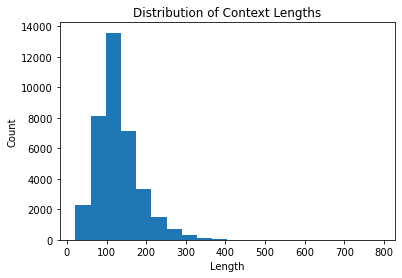

In [16]:
#Text lengths to contextx
token_lens = []

for txt in train_contexts:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens.append(len(txt.split(' ')))
  

print(max(token_lens))

plt.hist(token_lens,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

34
37111


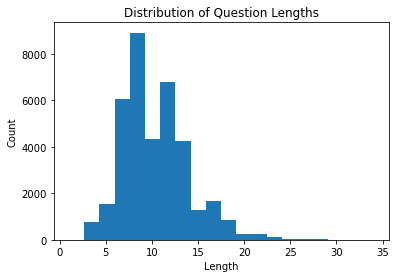

In [17]:
#Test lengths of Questions
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens2.append(len(txt.split(' ')))

print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [18]:
MAX_LENGTH = 250
MODEL_PATH = "bert-base-uncased"

In [19]:
print(len(train_questions))
print(len(train_contexts))

37111
37111


In [20]:
print(valid_questions[8])

which nfl team won super bowl 50?


In [21]:
tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)
train_encodings_fast = tokenizerFast(train_questions, train_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings_fast = tokenizerFast(valid_questions,valid_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)

In [22]:
type(train_encodings_fast)

transformers.tokenization_utils_base.BatchEncoding

In [23]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['input_ids'][0]))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
37111
250


In [24]:
print(train_encodings_fast['input_ids'][0])

[101, 2054, 2003, 1999, 2392, 1997, 1996, 10289, 8214, 2364, 2311, 1029, 102, 6549, 2135, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 2082, 8514, 2003, 1996, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1999, 5307, 2009, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 10439, 14995, 6924, 2007, 1996, 5722, 1998, 1996, 2919, 2033, 5004, 3415, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 10047, 2984, 1999, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 2358, 16595, 9648, 4674, 2145, 5255, 7763, 5595, 2809, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 2093, 11342, 1999, 1996, 2751, 8514, 2003, 2004, 3722, 2715, 2962, 6231, 1997, 2984, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [25]:
type(train_answers[0]['text'])
train_answers[0].keys()

dict_keys(['answer_start', 'text', 'answer_end'])

In [26]:
def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
            if match:
                ret_start = a+1
                ret_end = a+i+1
                break
    return(ret_start, ret_end)

In [27]:
test_rec=92

z,x = ret_Answer_start_and_end_train(test_rec)
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

114 115
pat
pat obrien
[CLS] which person portrayed knute rockne in the 1940 movie " knute rockne? " [SEP] george gap with the schools legendary football player during nineteen sixteen to twenty. he played semi professional baseball in smoke drink and gambled when not playing sports. he was also humble generous to the needy and a man of integrity. it was in nineteen twenty eight that fame coach can you brought me used his final conversation with the dying get to inspire the notre dame team to beat the army team and win one for the gipper the nineteen forty film can you drop me all american start pat obrien is can you drop me and ronald reagan as get. today in the team competes in notre dame stadium and eighty thousand seven hundred ninety five seat stadium on campus. the current head coaches brian kelly hired from the university of cincinnati on december eleventh two thousand nine. kellys record in midway through his sixth season at notre dame is fifty two to twenty one. in twenty twel

In [28]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
37111


In [29]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
    s, e = ret_Answer_start_and_end_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1

    
train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

478


In [30]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
37111


In [31]:
test_rec = 1
print(train_encodings_fast['start_positions'][test_rec])
print(train_encodings_fast['end_positions'][test_rec])
predict_answer_tokens = train_encodings_fast.input_ids[test_rec][train_encodings_fast['start_positions'][test_rec] : train_encodings_fast['end_positions'][test_rec]]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

150
151
the
the main building
[CLS] the basilica of the sacred heart at notre dame is beside to which structure? [SEP] architecturally the school has a catholic character. atop the main building school dome is the golden statue of the virgin mary. immediately in front of the main building in facing it is a copper statue of christ with arms appraised with the legend and the bad meow names. next to the main building is the basilica of the sacred heart. immediately behind the basilica is the grotto im mary in place of prayer and reflection. it is a replica of the grotto at lourdes france where the virgin mary reputedly appeared to st bernadette still burning eighteen fifty eight. at the end of the main drive and in a direct line that connects through three statues in the gold dome is as simple modern stone statue of mary. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [32]:
def ret_Answer_start_and_end_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(valid_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != valid_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
            if match:
                ret_start = a+1
                ret_end = a+i+1
                break
    return(ret_start, ret_end)

In [33]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(valid_encodings_fast['input_ids']) ):
    #print(h)
    s, e = ret_Answer_start_and_end_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1

    
valid_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

236


In [34]:
test_rec=2

z,x = ret_Answer_start_and_end_valid(test_rec)
predict_answer_tokens = valid_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(valid_answers[test_rec]['text'])
print(tokenizerFast.decode(valid_encodings_fast['input_ids'][test_rec]))

denver
denver broncos
[CLS] which nfl team represented the afc at super bowl 50? [SEP] super bowl fifty was an american football game to determine the champion of the national football league nfl for the twenty fifteen season. the american football conference a f c c champion denver broncos defeated the national football conference n f c c champion carolina panthers twenty four to ten to earn their third super bowl title. the game was played on february seventh twenty sixteen and levis stadium in the san francisco bay area santa clara california. as this was the fiftieth super bowl the league emphasized the golden anniversary with various goldsteins initiatives as well as temporarily suspending the tradition of naming each super bowl game with roman numerals under which they gain would have been known as super bowl l sell that the logo could prominently featured the arabic numerals fifty. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [35]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['start_positions']))
print(len(train_encodings_fast['end_positions']))
print(len(valid_encodings_fast['input_ids']))
print(len(valid_encodings_fast['start_positions']))
print(len(valid_encodings_fast['end_positions']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
37111
37111
37111
15875
15875
15875


In [36]:
tokenizerFast.decode(train_encodings_fast['input_ids'][0])

'[CLS] what is in front of the notre dame main building? [SEP] architecturally the school has a catholic character. atop the main building school dome is the golden statue of the virgin mary. immediately in front of the main building in facing it is a copper statue of christ with arms appraised with the legend and the bad meow names. next to the main building is the basilica of the sacred heart. immediately behind the basilica is the grotto im mary in place of prayer and reflection. it is a replica of the grotto at lourdes france where the virgin mary reputedly appeared to st bernadette still burning eighteen fifty eight. at the end of the main drive and in a direct line that connects through three statues in the gold dome is as simple modern stone statue of mary. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [37]:
test_row= 0
print(train_contexts[test_row][train_answers[test_row]['answer_start']:train_answers[test_row]['answer_end']])

a copper statue of christ


In [38]:
answer_start_index = 75
answer_end_index = 79
predict_answer_tokens = train_encodings_fast.input_ids[0][answer_start_index : answer_end_index]
tokenizerFast.decode(predict_answer_tokens)

'basilica of the sacred'

In [39]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [40]:
train_dataset = InputDataset(train_encodings_fast)
valid_dataset = InputDataset(valid_encodings_fast)

In [41]:
print(len(train_dataset))
print(train_dataset[0].keys())

37111
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])


In [42]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=1)

In [43]:
bert_model = BertModel.from_pretrained(MODEL_PATH)  #MODEL_PATH = "bert-base-uncased"

class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2 
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)  # taking Start logits from last BERT layer, End Logits from third to last layer
        logits = self.linear_relu_stack(out)
        
        start_logits, end_logits = logits.split(1, dim=-1)
        
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
model = QAModel()

In [45]:
# my function to manually calculate Cross Entropy Loss
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

In [46]:
def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):
    
    #calculate Probabilities by applying Softmax to the Start and End Logits. Then get 1 - probabilities
    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end
    
    #get log of probabilities. Note: NLLLoss required log probabilities. This is the Natural Log (Log base e)
    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)
    
    nll = nn.NLLLoss()
    
    fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)
    
    #return mean of the Loss for the start and end logits
    return ((fl_start + fl_end)/2)

In [47]:
optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []

/home/hgaddam/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        print(batch)
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids, 
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
        #loss = loss_fn(out_start, out_end, start_positions, end_positions)  # <---BASELINE.  Cross Entropy Loss is returned by Default
        loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1) #using gamma = 1
        losses.append(loss.item())
        loss.backward()
        optim.step()
        
        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)
            
        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())
        #ctr = ctr +1
        #if ctr==50:
        #    break
        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [49]:
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)
            
            out_start, out_end = model(input_ids=input_ids, 
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)
            print(start_pred,end_pred)
            answer=tokenizerFast.convert_tokens_to_string([input_ids][start_pred:end_pred+1])
            print("answer",answer)
            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
            #ctr = ctr +1
            #if ctr==50:
            #    break
        ret_acc = sum(acc)/len(acc)
        ret_loss = 0
    return(ret_acc)

In [54]:
model.to(device)

QAModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [55]:
EPOCHS = 10

#model.to(device)

for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    val_acc = eval_model(model, valid_data_loader)
    print(f"Validation Accuracy: {val_acc}")

Running Epoch :   0%|          | 1/2320 [00:00<06:33,  5.89it/s]

{'input_ids': tensor([[ 101, 2004, 4941,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2129, 2020,  ...,    0,    0,    0],
        [ 101, 2079, 3767,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83, 116, 118, 117, 135, 125,  69,  85,   1,  77, 128, 103,  43,  65,
         53, 100]), 'end_positions': tensor([ 84, 117, 119, 118, 136, 126,  70,  86,   2

Running Epoch :   0%|          | 3/2320 [00:00<06:29,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 1005,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2003, 2147,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2040, 2165,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([161,  91,  83,  33, 109, 182,   0,  40,  60, 111,  30,  14,  33,  95,
         54,  96]), 'end_positions': tensor([162,  92,  84,  34, 110, 183,   0,  41,  61

Running Epoch :   0%|          | 5/2320 [00:00<06:26,  5.98it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2096, 2002,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2053,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2513,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 28, 115,  14,  66,  22, 110, 111,  15, 146, 110,  45,  85,  65, 213,
         22, 201]), 'end_positions': tensor([ 29, 116,  15,  67,  23, 111, 112,  16, 147

Running Epoch :   0%|          | 7/2320 [00:01<06:25,  6.00it/s]

{'input_ids': tensor([[  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2064,  1037,  ...,     0,     0,     0],
        [  101,  2129,  2146,  ...,  1999,  1996,   102],
        ...,
        [  101, 14168,  2705,  ...,     0,     0,     0],
        [  101,  2129,  2146,  ...,     0,     0,     0],
        [  101,  2073,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([124, 140, 173,  65, 171, 133,  90,  79,  53, 135,   0,  78,  31,  34,
         87, 201]), 'end_positions': tensor([125, 14

Running Epoch :   0%|          | 9/2320 [00:01<06:24,  6.00it/s]

{'input_ids': tensor([[ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2338,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3303,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 72, 131, 101, 170,  91,  82,  66,  32, 169, 123,  47, 125,  46,  53,
         83,  37]), 'end_positions': tensor([ 73, 132, 102, 171,  92,  83,  67,  33, 170

Running Epoch :   0%|          | 11/2320 [00:01<06:25,  5.99it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2895,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2029, 2161,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 66,  15, 124,  51,  81,  68,  91, 103,  41, 159, 115, 147, 188,  93,
         80, 127]), 'end_positions': tensor([ 67,  16, 125,  52,  82,  69,  92, 104,  42

Running Epoch :   1%|          | 13/2320 [00:02<06:24,  6.00it/s]

{'input_ids': tensor([[  101,  2054,  6254,  ...,     0,     0,     0],
        [  101,  2029, 10282,  ...,     0,     0,     0],
        [  101,  2054,  2653,  ...,     0,     0,     0],
        ...,
        [  101,  2013,  2073,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2040,  2419,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 34,  80,  64,  49,  68,  59, 101, 105, 135, 144,  38, 128,  94,  22,
        143, 235]), 'end_positions': tensor([ 35,  8

Running Epoch :   1%|          | 15/2320 [00:02<06:24,  6.00it/s]

{'input_ids': tensor([[  101,  1996, 15099,  ...,  2032,  1998,   102],
        [  101,  1996,  2827,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  3167,  ...,  8346,  2046,   102],
        [  101,  3171, 12795,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 41, 100,  30,  34,  15,  58, 158,  49, 122, 112,  41, 117, 185, 245,
         25,  23]), 'end_positions': tensor([ 42, 10

Running Epoch :   1%|          | 17/2320 [00:02<06:23,  6.00it/s]

{'input_ids': tensor([[ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ..., 4072, 2005,  102],
        [ 101, 2040, 3855,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2338,  ...,    0,    0,    0],
        [ 101, 2044, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 3737,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([110, 144,  81,  30,  44,  16,  91, 140,  82, 212,  92, 131, 144, 218,
        107,  79]), 'end_positions': tensor([111, 145,  82,  31,  45,  17,  92, 141,  83

Running Epoch :   1%|          | 19/2320 [00:03<06:23,  6.00it/s]

{'input_ids': tensor([[ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2044, 2010,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2054, 5119,  ...,    0,    0,    0],
        [ 101, 2054, 4650,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 22, 147,  43,  66, 105, 127, 176,  97,  97,  34,  47,  50, 222,  16,
        122,  23]), 'end_positions': tensor([ 23, 148,  44,  67, 106, 128, 177,  98,  98

Running Epoch :   1%|          | 21/2320 [00:03<06:23,  6.00it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101, 16392,  2003,  ...,  2180,  1996,   102],
        [  101,  1999,  2054,  ...,     0,     0,     0],
        ...,
        [  101,  2003,  1996,  ...,     0,     0,     0],
        [  101,  6683,  7520,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 64, 143,  29,  53,  19,  45,  33,  29, 103, 133, 132,  88, 107, 102,
         56,  62]), 'end_positions': tensor([ 65, 14

Running Epoch :   1%|          | 23/2320 [00:03<06:23,  5.99it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3589,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 42, 152,  17, 103, 129,  75,  73, 120, 125, 122,  23,  51, 128, 161,
         23, 160]), 'end_positions': tensor([ 43, 153,  18, 104, 130,  76,  74, 121, 126

Running Epoch :   1%|          | 25/2320 [00:04<06:22,  5.99it/s]

{'input_ids': tensor([[ 101, 2040, 4081,  ...,    0,    0,    0],
        [ 101, 2079, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 4772,  ..., 1996, 9489,  102],
        [ 101, 2073, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([137, 183, 133,  79,  91, 126,  49, 163,  30, 153,  35, 164, 113,  54,
        108, 111]), 'end_positions': tensor([138, 184, 134,  80,  92, 127,  50, 164,  31

Running Epoch :   1%|          | 27/2320 [00:04<06:22,  5.99it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,  1998,  1996,   102],
        [  101,  2054,  2079,  ..., 17886,  3512,   102],
        ...,
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2064,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 53, 130, 209,  78,  27, 147,  50,   0, 167,  15,  99,  32, 207,  24,
         62, 124]), 'end_positions': tensor([ 54, 13

Running Epoch :   1%|▏         | 29/2320 [00:04<06:22,  5.99it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 3956, 5748,  ...,    0,    0,    0],
        [ 101, 2129, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2003, 2009,  ...,    0,    0,    0],
        [ 101, 2013, 2054,  ..., 4503, 3227,  102],
        [ 101, 2043, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([123,  31,  53,  42,  50,  38, 125, 104,  93, 116, 128, 131, 152,  96,
        166,  56]), 'end_positions': tensor([124,  32,  54,  43,  51,  39, 126, 105,  94

Running Epoch :   1%|▏         | 31/2320 [00:05<06:21,  5.99it/s]

{'input_ids': tensor([[  101,  2054,  7812,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2040,  2764,  ...,     0,     0,     0],
        ...,
        [  101,  1999, 29309,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  7870,  2007,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([146, 130,  91,  78,  72,  26, 109,  25,  67,  16,  18, 111,  51, 147,
         32, 105]), 'end_positions': tensor([147, 13

Running Epoch :   1%|▏         | 33/2320 [00:05<06:21,  6.00it/s]

{'input_ids': tensor([[  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2054,  5201,  ...,     0,     0,     0],
        [  101,  2054,  2093,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 14293,  ...,     0,     0,     0],
        [  101,  2054,  3700,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([100, 141,  25, 212, 168, 105,  53,  61, 146,  86, 162,  71,  53,  47,
         79, 128]), 'end_positions': tensor([101, 14

Running Epoch :   2%|▏         | 35/2320 [00:05<06:21,  5.99it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 1996, 2417,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2038,  ...,    0,    0,    0],
        [ 101, 2043, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([105,  88,  84,  23,  50,  33,  75, 156,  28, 130,  81, 158,  36, 143,
         11, 122]), 'end_positions': tensor([106,  89,  85,  24,  51,  34,  76, 157,  29

Running Epoch :   2%|▏         | 37/2320 [00:06<06:20,  5.99it/s]

{'input_ids': tensor([[  101,  1996, 23307,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0],
        ...,
        [  101,  2339,  2001,  ...,     0,     0,     0],
        [  101,  1996, 11760,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,  2053, 23045,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 43, 125, 115,  68,  55, 105, 152, 196, 205,  32,  20,  77,  24,  40,
         73, 231]), 'end_positions': tensor([ 44, 12

Running Epoch :   2%|▏         | 39/2320 [00:06<06:21,  5.98it/s]

{'input_ids': tensor([[ 101, 2054, 2112,  ...,    0,    0,    0],
        [ 101, 2054, 4249,  ...,    0,    0,    0],
        [ 101, 2043, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 4145,  ...,    0,    0,    0],
        [ 101, 2054, 2060,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 88,  44, 107,  33, 102,  50, 117, 232,  58,  71, 120,  93,  41, 149,
        119,  25]), 'end_positions': tensor([ 89,  45, 108,  34, 103,  51, 118, 233,  59

Running Epoch :   2%|▏         | 41/2320 [00:06<06:21,  5.98it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2804,  ...,    0,    0,    0],
        [ 101, 2054, 2946,  ...,    0,    0,    0],
        [ 101, 2129, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([161, 147,  43, 101, 238,  22,  35, 103, 176,  25, 159,  15,  20, 107,
        130,  93]), 'end_positions': tensor([162, 148,  44, 102, 239,  23,  36, 104, 177

Running Epoch :   2%|▏         | 43/2320 [00:07<06:20,  5.99it/s]

{'input_ids': tensor([[ 101, 2054, 5036,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2054, 1057,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 4245,  ...,    0,    0,    0],
        [ 101, 2054, 3303,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([114,  62, 165, 120, 129,  35,  49,  43,  65,  27,   9, 169, 140,  93,
        129,  40]), 'end_positions': tensor([115,  63, 166, 121, 130,  36,  50,  44,  66

Running Epoch :   2%|▏         | 45/2320 [00:07<06:19,  5.99it/s]

{'input_ids': tensor([[ 101, 2054, 2801,  ...,    0,    0,    0],
        [ 101, 2129, 2079,  ..., 2166, 1012,  102],
        [ 101, 2129, 2079,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2515,  ...,    0,    0,    0],
        [ 101, 4623, 2003,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 38, 207, 105,  69,  27,  74,  78,  16, 168,  80, 189,  33,  22,  40,
        157,  24]), 'end_positions': tensor([ 39, 208, 106,  70,  28,  75,  79,  17, 169

Running Epoch :   2%|▏         | 47/2320 [00:07<06:19,  5.99it/s]

{'input_ids': tensor([[  101, 10022,  1005,  ...,     0,     0,     0],
        [  101,  2054,  4240,  ...,     0,     0,     0],
        [  101,  2040,  3478,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2563,  2150,  ...,  2332,  1997,   102],
        [  101,  2040,  2218,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([163, 114, 132, 224,   0,  78,  39, 104, 144, 132,  96, 163,  57,  59,
         96,  24]), 'end_positions': tensor([164, 11

Running Epoch :   2%|▏         | 49/2320 [00:08<06:19,  5.98it/s]

{'input_ids': tensor([[ 101, 2054, 2267,  ...,    0,    0,    0],
        [ 101, 2054, 2576,  ...,    0,    0,    0],
        [ 101, 2054, 4055,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 68,  85, 128,  83,  51,  29, 115,  73,  26,  87,  22,  39, 184,  16,
        211, 209]), 'end_positions': tensor([ 69,  86, 129,  84,  52,  30, 116,  74,  27

Running Epoch :   2%|▏         | 51/2320 [00:08<06:20,  5.96it/s]

{'input_ids': tensor([[ 101, 1996, 3311,  ...,    0,    0,    0],
        [ 101, 2054, 2194,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2043, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 74,  18,  90, 169, 143,  97, 137, 137,  75,  89,  12,  25,  84, 112,
        153, 126]), 'end_positions': tensor([ 75,  19,  91, 170, 144,  98, 138, 138,  76

Running Epoch :   2%|▏         | 53/2320 [00:08<06:20,  5.97it/s]

{'input_ids': tensor([[ 101, 2029, 4121,  ...,    0,    0,    0],
        [ 101, 2054, 2299,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 2688, 1999,  102],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 6433,  ...,    0,    0,    0],
        [ 101, 2054, 3032,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 55,  89, 154,  61,  74,  46,  48, 123,  83,  57,  35, 198, 161,  21,
         95,  61]), 'end_positions': tensor([ 56,  90, 155,  62,  75,  47,  49, 124,  84

Running Epoch :   2%|▏         | 55/2320 [00:09<06:19,  5.97it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 1996, 3742,  ...,    0,    0,    0],
        [ 101, 2054, 2150,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 6454,  ...,    0,    0,    0],
        [ 101, 1996, 8594,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([230,  80,  22, 202,  37, 148,  19,  13,  72,  98,  80, 144, 114,  61,
         54, 132]), 'end_positions': tensor([231,  81,  23, 203,  38, 149,  20,  14,  73

Running Epoch :   2%|▏         | 57/2320 [00:09<06:19,  5.97it/s]

{'input_ids': tensor([[  101, 25479,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2029,  2828,  ...,     0,     0,     0],
        [  101,  2054,  2375,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([184, 129,  18,  40, 137,  28,  40,  33, 119, 117,  89, 167,  42, 198,
         55,  71]), 'end_positions': tensor([185, 13

Running Epoch :   3%|▎         | 59/2320 [00:09<06:19,  5.96it/s]

{'input_ids': tensor([[ 101, 1999, 2054,  ..., 1012, 5074,  102],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 9304,  ...,    0,    0,    0],
        [ 101, 2054, 2194,  ...,    0,    0,    0],
        [ 101, 2054, 2866,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0,  31, 115,  39, 205,  62, 114,  56, 213,  82,  31, 100, 126,  53,
        133,  55]), 'end_positions': tensor([  0,  32, 116,  40, 206,  63, 115,  57, 214

Running Epoch :   3%|▎         | 61/2320 [00:10<06:18,  5.97it/s]

{'input_ids': tensor([[ 101, 2040, 3479,  ...,    0,    0,    0],
        [ 101, 2029, 5434,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 3690,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2005, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 39,  69,  86,  42,  61,  73, 114, 164,  43,  31,  21,  57, 180, 153,
         52,  53]), 'end_positions': tensor([ 40,  70,  87,  43,  62,  74, 115, 165,  44

Running Epoch :   3%|▎         | 63/2320 [00:10<06:18,  5.96it/s]

{'input_ids': tensor([[ 101, 2339, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2012, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 5387,  ...,    0,    0,    0],
        [ 101, 2029, 2406,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 73,  52,  76,  86,  84,  22, 120,  73,  23,  89,  71, 237, 116, 169,
        183, 110]), 'end_positions': tensor([ 74,  53,  77,  87,  85,  23, 121,  74,  24

Running Epoch :   3%|▎         | 65/2320 [00:10<06:18,  5.96it/s]

{'input_ids': tensor([[ 101, 2040, 3271,  ...,    0,    0,    0],
        [ 101, 2054, 2112,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2043, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  48,  74, 122, 201,  16, 199,  32, 103, 125,  93,  43,  47,  77,
         48,  55]), 'end_positions': tensor([ 84,  49,  75, 123, 202,  17, 200,  33, 104

Running Epoch :   3%|▎         | 67/2320 [00:11<06:17,  5.97it/s]

{'input_ids': tensor([[  101,  2043,  2079,  ...,     0,     0,     0],
        [  101,  1996, 25891,  ...,     0,     0,     0],
        [  101,  4748,  7389,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2112,  ...,     0,     0,     0],
        [  101,  2054,  5123,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 25, 107, 154,  96, 144, 110,  68,  48, 185,  47,  27, 162, 122,  26,
        202,  81]), 'end_positions': tensor([ 26, 10

Running Epoch :   3%|▎         | 69/2320 [00:11<06:17,  5.96it/s]

{'input_ids': tensor([[  101,  2054,  2181,  ...,     0,     0,     0],
        [  101,  2040, 12282,  ...,     0,     0,     0],
        [  101,  2129,  2411,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  4998,  2013,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([92, 45, 46,  0, 60, 28, 76, 81, 71, 91, 10, 54, 93, 69, 53, 34]), 'end_positions': tensor([93, 46, 47,  0, 61, 29, 77, 82,

Running Epoch :   3%|▎         | 71/2320 [00:11<06:16,  5.97it/s]

{'input_ids': tensor([[  101,  1999,  8741,  ...,     0,     0,     0],
        [  101,  2054,  2457,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        ...,
        [  101,  9166,  4294,  ...,     0,     0,     0],
        [  101, 10461,  1005,  ...,  2189,  2029,   102],
        [  101,  2040,  2001,  ...,  5043,  5990,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 62,  75,  93, 192, 219,  79, 108,  97, 125,  44,   0, 101,  46,  33,
         30, 195]), 'end_positions': tensor([ 63,  7

Running Epoch :   3%|▎         | 73/2320 [00:12<06:16,  5.97it/s]

{'input_ids': tensor([[ 101, 1996, 7074,  ...,    0,    0,    0],
        [ 101, 2054, 2082,  ...,    0,    0,    0],
        [ 101, 2054, 3297,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2143,  ...,    0,    0,    0],
        [ 101, 2029, 2277,  ...,    0,    0,    0],
        [ 101, 2040, 2626,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([168,  48, 204, 123, 143, 141, 211,  75,  43,  59,  94,  72, 131, 139,
        113,  29]), 'end_positions': tensor([169,  49, 205, 124, 144, 142, 212,  76,  44

Running Epoch :   3%|▎         | 75/2320 [00:12<06:16,  5.97it/s]

{'input_ids': tensor([[ 101, 4998, 2013,  ...,    0,    0,    0],
        [ 101, 2077, 3510,  ...,    0,    0,    0],
        [ 101, 2040, 6661,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2006, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([220, 132,  87, 115, 138,  78,  80,  19,  19, 110, 115, 173, 169, 106,
        118,  87]), 'end_positions': tensor([221, 133,  88, 116, 139,  79,  81,  20,  20

Running Epoch :   3%|▎         | 77/2320 [00:12<06:15,  5.97it/s]

{'input_ids': tensor([[ 101, 2029, 3297,  ...,    0,    0,    0],
        [ 101, 2515, 9160,  ...,    0,    0,    0],
        [ 101, 3005, 9029,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 3063,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ..., 1012, 4517,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([113,  80,  72,  23,  42, 213, 135,  70, 131, 122, 115, 110,  34,  91,
        122,  96]), 'end_positions': tensor([114,  81,  73,  24,  43, 214, 136,  71, 132

Running Epoch :   3%|▎         | 79/2320 [00:13<06:16,  5.96it/s]

{'input_ids': tensor([[ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ..., 1999, 1996,  102],
        [ 101, 2054, 2048,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2283,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 89,  26, 184, 122,  85, 168,  94, 112,  81,  29,  69, 138,  45, 117,
          0, 218]), 'end_positions': tensor([ 90,  27, 185, 123,  86, 169,  95, 113,  82

Running Epoch :   3%|▎         | 81/2320 [00:13<06:15,  5.97it/s]

{'input_ids': tensor([[ 101, 2129, 2020,  ...,    0,    0,    0],
        [ 101, 2129, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2001,  ...,    0,    0,    0],
        [ 101, 2070, 2822,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0,  69, 121, 127, 105,  90,  71,  39,  27,  71,  30,  33, 113,  56,
        124,  19]), 'end_positions': tensor([  0,  70, 122, 128, 106,  91,  72,  40,  28

Running Epoch :   4%|▎         | 83/2320 [00:13<06:14,  5.97it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2000,  3183,  ...,     0,     0,     0],
        [  101,  2029,  1997,  ...,     0,     0,     0],
        ...,
        [  101,  2013,  2148,  ...,     0,     0,     0],
        [  101,  2029,  3862,  ...,     0,     0,     0],
        [  101,  2054, 19331,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 38,  21, 132, 173, 114,  98, 106, 167, 109,  97,  98, 159,  46, 113,
         40, 168]), 'end_positions': tensor([ 39,  2

Running Epoch :   4%|▎         | 85/2320 [00:14<06:14,  5.97it/s]

{'input_ids': tensor([[  101,  2087,  3415,  ...,     0,     0,     0],
        [  101,  1996,  2353,  ...,     0,     0,     0],
        [  101,  2040, 16171,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2064,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 12,  50,  37, 110,  74, 112,  30,  27, 109,  52, 167,  97, 114,  78,
        173, 123]), 'end_positions': tensor([ 13,  5

Running Epoch :   4%|▍         | 87/2320 [00:14<06:14,  5.97it/s]

{'input_ids': tensor([[  101,  2529,  9230,  ...,     0,     0,     0],
        [  101,  2073,  1999,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2076,  2029,  ...,     0,     0,     0],
        [  101,  2466, 15271,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 87,  29,  63,  37,  94,  32,  25,  39, 131,  46,  34,  34, 139, 115,
         44,  28]), 'end_positions': tensor([ 88,  3

Running Epoch :   4%|▍         | 89/2320 [00:14<06:13,  5.97it/s]

{'input_ids': tensor([[  101,  1996,  2555,  ...,     0,     0,     0],
        [  101,  2040,  5681,  ...,     0,     0,     0],
        [  101,  2029, 11708,  ...,  3312,  2015,   102],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2129,  2024,  ...,     0,     0,     0],
        [  101,  1996,  6438,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([119,  89,  39, 100,  22,  89, 117,  90, 110, 105,  34,  71,  48,  25,
         15,  43]), 'end_positions': tensor([120,  9

Running Epoch :   4%|▍         | 91/2320 [00:15<06:13,  5.97it/s]

{'input_ids': tensor([[ 101, 2001, 3813,  ...,    0,    0,    0],
        [ 101, 2054, 3345,  ...,    0,    0,    0],
        [ 101, 2040, 2758,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2043, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 92, 161, 108,  98,  94,  13,  12, 112,  47,  60,  15, 121,  31, 114,
         87,  19]), 'end_positions': tensor([ 93, 162, 109,  99,  95,  14,  13, 113,  48

Running Epoch :   4%|▍         | 93/2320 [00:15<06:12,  5.97it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 4078,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 55,  13,  88, 105, 138, 166,  84, 108,  55,  30,  18,  59,  50, 158,
        103, 102]), 'end_positions': tensor([ 56,  14,  89, 106, 139, 167,  85, 109,  56

Running Epoch :   4%|▍         | 95/2320 [00:15<06:12,  5.97it/s]

{'input_ids': tensor([[  101,  2043,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2040,  5836,  ...,     0,     0,     0],
        [  101,  1999, 12362,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 19,  35,  13, 110, 107, 104, 173, 110,  67,  41, 109,  38,  16, 227,
         54,  45]), 'end_positions': tensor([ 20,  3

Running Epoch :   4%|▍         | 97/2320 [00:16<06:12,  5.96it/s]

{'input_ids': tensor([[ 101, 2040, 2170,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2103,  ...,    0,    0,    0],
        [ 101, 2029, 8281,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  69, 197,  52, 109,  20, 151, 136,  49, 161,  20,  42,  86,  33,
        110,  30]), 'end_positions': tensor([ 84,  70, 198,  53, 110,  21, 152, 137,  50

Running Epoch :   4%|▍         | 99/2320 [00:16<06:12,  5.97it/s]

{'input_ids': tensor([[ 101, 2073, 2038,  ...,    0,    0,    0],
        [ 101, 2040, 2649,  ...,    0,    0,    0],
        [ 101, 2040, 2580,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2516,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([106,  79,  11, 184,  69,  86, 173,  76, 168, 131,  22, 131,  38, 101,
        117, 158]), 'end_positions': tensor([107,  80,  12, 185,  70,  87, 174,  77, 169

Running Epoch :   4%|▍         | 101/2320 [00:16<06:11,  5.97it/s]

{'input_ids': tensor([[  101,  2054,  3047,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2515,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2154,  ...,     0,     0,     0],
        [  101,  2054,  8355,  ...,     0,     0,     0],
        [  101,  2426, 14024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 28,  45,  98,  92,  43,  47,  25,  87,   0, 197,  10,  49,  22,  16,
        155, 140]), 'end_positions': tensor([ 29,  4

Running Epoch :   4%|▍         | 103/2320 [00:17<06:11,  5.97it/s]

{'input_ids': tensor([[ 101, 2013, 2073,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 3249,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 9078, 5915,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 70, 146, 110,  80, 136,  97,  36, 101,  14, 206, 135, 192, 141, 103,
        104, 137]), 'end_positions': tensor([ 71, 147, 111,  81, 137,  98,  37, 102,  15

Running Epoch :   5%|▍         | 105/2320 [00:17<06:11,  5.96it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 76, 173, 149,  69, 167,  44, 197,  47,  62,  17, 182,  64,  68,  19,
         65,  55]), 'end_positions': tensor([ 77, 174, 150,  70, 168,  45, 198,  48,  63

Running Epoch :   5%|▍         | 107/2320 [00:17<06:11,  5.96it/s]

{'input_ids': tensor([[ 101, 2054, 3029,  ...,    0,    0,    0],
        [ 101, 2040, 8509,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2040, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([139, 113,  52,  72,  19, 106,  77,  46,  61,  26,  99,  94,  90, 133,
         58,  67]), 'end_positions': tensor([140, 114,  53,  73,  20, 107,  78,  47,  62

Running Epoch :   5%|▍         | 109/2320 [00:18<06:11,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3297,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ..., 3792, 1996,  102],
        [ 101, 2043, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([100,  95,  72,  66, 100, 121,  88,  45,  58,  49,  21,  69,  43, 106,
        230,  95]), 'end_positions': tensor([101,  96,  73,  67, 101, 122,  89,  46,  59

Running Epoch :   5%|▍         | 111/2320 [00:18<06:10,  5.96it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2129,  2574,  ...,     0,     0,     0],
        [  101,  2079,  3337,  ...,     0,     0,     0],
        ...,
        [  101, 22866,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2005,  2129,  ...,  9530, 13542,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([136,  21, 129, 138,  88,  24,  63, 183,  18,  89,  80,  97, 187,  97,
        169, 149]), 'end_positions': tensor([137,  2

Running Epoch :   5%|▍         | 113/2320 [00:18<06:10,  5.96it/s]

{'input_ids': tensor([[  101,  2054,  2064,  ...,     0,     0,     0],
        [  101,  2040, 21208,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2040,  9362,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([106, 104, 138,  92,  70,  77,  34, 179, 145, 123, 120, 243, 131,  60,
         37, 148]), 'end_positions': tensor([107, 10

Running Epoch :   5%|▍         | 115/2320 [00:19<06:09,  5.96it/s]

{'input_ids': tensor([[ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 1996, 3445,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2093, 6186,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2114, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([148, 128, 185, 237,  48, 121, 145,  78,  85, 115,  70,  99, 112,  84,
         98,  43]), 'end_positions': tensor([149, 129, 186, 238,  49, 122, 146,  79,  86

Running Epoch :   5%|▌         | 117/2320 [00:19<06:09,  5.96it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 2785,  ...,    0,    0,    0],
        [ 101, 1999, 2297,  ...,    0,    0,    0],
        ...,
        [ 101, 2043, 2106,  ...,    0,    0,    0],
        [ 101, 2060, 2084,  ...,    0,    0,    0],
        [ 101, 2013, 2029,  ..., 1999, 2093,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 93,  47,  57,  93,  44,  16, 136,  77, 144, 116, 136,   0,  92, 103,
        194, 150]), 'end_positions': tensor([ 94,  48,  58,  94,  45,  17, 137,  78, 145

Running Epoch :   5%|▌         | 119/2320 [00:19<06:09,  5.96it/s]

{'input_ids': tensor([[ 101, 2054, 2806,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2079,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3151,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 32,  94,  55,  43,  60, 136,  68,  48, 176,  16, 154,  47, 121, 141,
        139,  73]), 'end_positions': tensor([ 33,  95,  56,  44,  61, 137,  69,  49, 177

Running Epoch :   5%|▌         | 121/2320 [00:20<06:08,  5.96it/s]

{'input_ids': tensor([[ 101, 2129, 2003,  ...,    0,    0,    0],
        [ 101, 2105, 2054,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2257,  ...,    0,    0,    0],
        [ 101, 1999, 1037,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 50,  51,  37, 158,  63,  31,  18,  98, 127,  11, 134,  93, 106, 155,
         71, 103]), 'end_positions': tensor([ 51,  52,  38, 159,  64,  32,  19,  99, 128

Running Epoch :   5%|▌         | 123/2320 [00:20<06:08,  5.96it/s]

{'input_ids': tensor([[  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101, 12318,  1996,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ..., 10922,  1012,   102],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2178,  2005,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([129,  78, 128,  46,   0, 109,  97,  29, 200,  95, 114,  56,  34,  58,
         40,  15]), 'end_positions': tensor([130,  7

Running Epoch :   5%|▌         | 125/2320 [00:20<06:08,  5.96it/s]

{'input_ids': tensor([[  101,  2073,  2515,  ...,     0,     0,     0],
        [  101,  2040,  4716,  ...,     0,     0,     0],
        [  101,  2040,  2081,  ...,     0,     0,     0],
        ...,
        [  101, 10047,  2386,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0],
        [  101,  4359, 22597,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([108,  90, 129,  70,  32,  39,  21, 150, 236, 147, 120,  59,  90,  73,
         48, 134]), 'end_positions': tensor([109,  9

Running Epoch :   5%|▌         | 127/2320 [00:21<06:08,  5.96it/s]

{'input_ids': tensor([[  101,  2054,  6143,  ...,     0,     0,     0],
        [  101,  2024, 25947,  ...,     0,     0,     0],
        [  101,  2054,  3068,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  7189,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 25, 112, 140,   0,  86,  31, 201, 143, 213,  71,  57, 101, 121, 117,
         54, 108]), 'end_positions': tensor([ 26, 11

Running Epoch :   6%|▌         | 129/2320 [00:21<06:10,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 3047,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 3418,  ...,    0,    0,    0],
        [ 101, 2054, 2060,  ...,    0,    0,    0],
        [ 101, 2054, 3653,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([113,  39,  28, 221,  96,  75, 122,  55,  50, 141,  57, 194,  99, 108,
        138, 173]), 'end_positions': tensor([114,  40,  29, 222,  97,  76, 123,  56,  51

Running Epoch :   6%|▌         | 131/2320 [00:21<06:08,  5.93it/s]

{'input_ids': tensor([[ 101, 2005, 2129,  ...,    0,    0,    0],
        [ 101, 2054, 3690,  ...,    0,    0,    0],
        [ 101, 2054, 2089,  ...,    0,    0,    0],
        ...,
        [ 101, 2009, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 65,  11,  99,  18,  51, 135, 106,  73, 106, 120, 117, 103,  62,  29,
        214,  74]), 'end_positions': tensor([ 66,  12, 100,  19,  52, 136, 107,  74, 107

Running Epoch :   6%|▌         | 133/2320 [00:22<06:08,  5.94it/s]

{'input_ids': tensor([[  101,  1996,  4529,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  4682, 11208,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2048,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([218,  17,  39,  76,  68, 111, 170,  85, 101,  87,  65,  94, 115, 117,
         57, 145]), 'end_positions': tensor([219,  1

Running Epoch :   6%|▌         | 135/2320 [00:22<06:07,  5.95it/s]

{'input_ids': tensor([[ 101, 2349, 2000,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2043, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 4941,  ...,    0,    0,    0],
        [ 101, 1996, 2372,  ...,    0,    0,    0],
        [ 101, 2029, 2346,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 89,  68, 229, 104,  80, 157,  99, 127, 137, 126,  96, 135, 156, 211,
         24,  44]), 'end_positions': tensor([ 90,  69, 230, 105,  81, 158, 100, 128, 138

Running Epoch :   6%|▌         | 137/2320 [00:22<06:06,  5.96it/s]

{'input_ids': tensor([[  101,  2429,  2000,  ...,     0,     0,     0],
        [  101,  2029,  5721,  ...,     0,     0,     0],
        [  101,  2054,  3047,  ...,     0,     0,     0],
        ...,
        [  101,  2188, 28696,  ...,     0,     0,     0],
        [  101,  2054,  2645,  ...,  6241,  1998,   102],
        [  101,  2043,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([116,  67,  80,  12, 168, 150,  18,  89,  96, 174, 160,  95,  71, 163,
         57,  91]), 'end_positions': tensor([117,  6

Running Epoch :   6%|▌         | 139/2320 [00:23<06:06,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 3538,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2038,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 3163,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 77, 103, 134,  94,  70, 153, 155, 139,  67,  93, 120,  48,  57, 208,
        111,  78]), 'end_positions': tensor([ 78, 104, 135,  95,  71, 154, 156, 140,  68

Running Epoch :   6%|▌         | 141/2320 [00:23<06:05,  5.96it/s]

{'input_ids': tensor([[  101,  1999,  2230,  ...,  2177,  3581,   102],
        [  101,  2040,  2245,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  3063,  ...,     0,     0,     0],
        [  101,  1996,  6698,  ...,     0,     0,     0],
        [  101,  2029, 24904,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 65, 111,  34,  75,  97,  21,  65,  23, 112,  37,  51,  24,  55, 155,
         57, 103]), 'end_positions': tensor([ 66, 11

Running Epoch :   6%|▌         | 143/2320 [00:23<06:05,  5.96it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2220, 10465,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2003,  2045,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 17,  19, 109, 124, 119,  35,  44, 227, 134,   0,  37,  96,  99, 115,
         31,  69]), 'end_positions': tensor([ 18,  2

Running Epoch :   6%|▋         | 145/2320 [00:24<06:04,  5.96it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2054, 18240,  ...,     0,     0,     0],
        ...,
        [  101,  2040, 17202,  ...,     0,     0,     0],
        [  101,  2040,  2003,  ...,     0,     0,     0],
        [  101,  2073,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([145,  81,  22,  22,  46,  75,  60,  23,  44,  30, 121, 128,  23, 126,
        100,  39]), 'end_positions': tensor([146,  8

Running Epoch :   6%|▋         | 147/2320 [00:24<06:04,  5.96it/s]

{'input_ids': tensor([[  101,  2040,  2245,  ...,     0,     0,     0],
        [  101,  2054,  2299,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  3532,  4454,  ...,     0,     0,     0],
        [  101,  2040, 15131,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([106, 144, 105, 169,  35,  27,   0,  35, 104, 165,  56, 127,  52,  40,
         37,  72]), 'end_positions': tensor([107, 14

Running Epoch :   6%|▋         | 149/2320 [00:24<06:04,  5.96it/s]

{'input_ids': tensor([[  101,  1999, 12441,  ...,     0,     0,     0],
        [  101,  1999,  3725,  ...,     0,     0,     0],
        [  101,  4998,  2013,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2003,  1996,  ...,  3634,  2274,   102],
        [  101,  1996, 18771,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 63, 124,  91,  16,  75, 216, 130, 169,  50,  16,  44, 206,  43, 148,
        162,  52]), 'end_positions': tensor([ 64, 12

Running Epoch :   7%|▋         | 151/2320 [00:25<06:03,  5.96it/s]

{'input_ids': tensor([[  101,  2054,  2079,  ...,     0,     0,     0],
        [  101, 14569, 14919,  ...,     0,     0,     0],
        [  101,  2012,  2054,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 78, 121,  33, 141,  69,  40,  82, 140,  95,  82,  95,  76, 154,  86,
        104,  27]), 'end_positions': tensor([ 79, 12

Running Epoch :   7%|▋         | 153/2320 [00:25<06:03,  5.96it/s]

{'input_ids': tensor([[ 101, 1037, 2261,  ...,    0,    0,    0],
        [ 101, 2054, 2433,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ..., 1996, 8956,  102],
        ...,
        [ 101, 2054, 3092,  ...,    0,    0,    0],
        [ 101, 3005, 2331,  ..., 4228, 1038,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83, 187, 159,  32,  80,  27,  37,  58, 114,  69,  85,  35,  62,  56,
        161, 152]), 'end_positions': tensor([ 84, 188, 160,  33,  81,  28,  38,  59, 115

Running Epoch :   7%|▋         | 155/2320 [00:25<06:03,  5.96it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2005, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 9329,  ...,    0,    0,    0],
        [ 101, 2029, 2048,  ...,    0,    0,    0],
        [ 101, 2339, 2020,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 42, 111, 117, 102,  65,  33,  91, 132,  73,  30,  20, 184,  18,  65,
         31,  85]), 'end_positions': tensor([ 43, 112, 118, 103,  66,  34,  92, 133,  74

Running Epoch :   7%|▋         | 157/2320 [00:26<06:02,  5.96it/s]

{'input_ids': tensor([[ 101, 2054, 2688,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2626,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 2103,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 85,  44, 110, 182,  31,  66, 125, 109, 106,  24, 108,  27, 108,  37,
         32, 117]), 'end_positions': tensor([ 86,  45, 111, 183,  32,  67, 126, 110, 107

Running Epoch :   7%|▋         | 159/2320 [00:26<06:02,  5.96it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 1996, 2653,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2653,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 73,  51,  42, 155,  59,  49, 109, 137,  98, 118, 104, 120, 223,  40,
         18,  28]), 'end_positions': tensor([ 74,  52,  43, 156,  60,  50, 110, 138,  99

Running Epoch :   7%|▋         | 161/2320 [00:26<06:02,  5.96it/s]

{'input_ids': tensor([[ 101, 2040, 2435,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3497,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 4543,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 49, 112,  16,  37,  55, 138,  67,  97,  47,  55,  22,  97,  19, 139,
        125,  41]), 'end_positions': tensor([ 50, 113,  17,  38,  56, 139,  68,  98,  48

Running Epoch :   7%|▋         | 163/2320 [00:27<06:02,  5.95it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2076,  2029,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2177,  ...,     0,     0,     0],
        [  101, 10390,  7166,  ...,     0,     0,     0],
        [  101,  2054,  4995,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([199,  98, 182, 236, 196,  81, 115, 123, 238,  90,  38,  51, 110,  31,
        157,  41]), 'end_positions': tensor([200,  9

Running Epoch :   7%|▋         | 165/2320 [00:27<06:02,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2653,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2442,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 2576,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 47, 149,  61,  77, 189, 156,  21,  75, 120,  63,  16,  73,  39, 145,
        144,  95]), 'end_positions': tensor([ 48, 150,  62,  78, 190, 157,  22,  76, 121

Running Epoch :   7%|▋         | 167/2320 [00:27<06:01,  5.96it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 3104, 2014,  102],
        [ 101, 2129, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 5652,  ...,    0,    0,    0],
        [ 101, 2073, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([108,  38,  65,  96,  50, 129,  90,  39,  81,  79,  72, 107,  74,  26,
         24, 180]), 'end_positions': tensor([109,  39,  66,  97,  51, 130,  91,  40,  82

Running Epoch :   7%|▋         | 169/2320 [00:28<06:01,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2029, 2555,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 76,  45, 110, 129, 176,  82, 136,  22, 135, 106, 181, 141, 157,  47,
        111, 122]), 'end_positions': tensor([ 77,  46, 111, 130, 177,  83, 137,  23, 136

Running Epoch :   7%|▋         | 171/2320 [00:28<06:00,  5.96it/s]

{'input_ids': tensor([[  101,  2054, 11822,  ...,     0,     0,     0],
        [  101,  2070,  6617,  ...,     0,     0,     0],
        [  101,  2129,  2031,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2003,  ...,     0,     0,     0],
        [  101,  2040,  6272,  ...,     0,     0,     0],
        [  101,  2054,  6907,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 78, 112, 109,  17, 147,  98,  25,  42, 128, 143,   9,  51,  32,  18,
        102,  36]), 'end_positions': tensor([ 79, 11

Running Epoch :   7%|▋         | 173/2320 [00:28<06:00,  5.96it/s]

{'input_ids': tensor([[  101, 19632,  1998,  ...,     0,     0,     0],
        [  101,  2040,  2626,  ...,     0,     0,     0],
        [  101,  2054,  5538,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 11371,  ...,  3034,  1012,   102],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2339,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 63,  15, 175, 123,  25, 142, 112,  74, 100, 103,  11,  85,  39, 216,
         80, 129]), 'end_positions': tensor([ 64,  1

Running Epoch :   8%|▊         | 175/2320 [00:29<06:00,  5.95it/s]

{'input_ids': tensor([[  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2054,  3589,  ...,     0,     0,     0],
        [  101,  2073,  2064,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2054,  3029,  ...,     0,     0,     0],
        [  101,  2029,  5783,  ...,  6359, 10250,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 14,  48,  81, 149,  43,  97,  92,  22,  36,  75,  63, 137, 213, 112,
         77, 241]), 'end_positions': tensor([ 15,  4

Running Epoch :   8%|▊         | 177/2320 [00:29<06:00,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2291,  ...,    0,    0,    0],
        [ 101, 2029, 4619,  ..., 2416, 1999,  102],
        ...,
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 66, 123, 117, 138, 195,  16, 116,  60, 115,  79, 105, 130,  49,  79,
         13, 133]), 'end_positions': tensor([ 67, 124, 118, 139, 196,  17, 117,  61, 116

Running Epoch :   8%|▊         | 179/2320 [00:29<05:59,  5.96it/s]

{'input_ids': tensor([[  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2842,  ...,     0,     0,     0],
        [  101,  2044, 26486,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 12884,  ...,     0,     0,     0],
        [  101,  1999,  2735,  ...,     0,     0,     0],
        [  101,  2054,  2797,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([120, 127,  44,  43, 146, 123,  24,  33,  96,  30, 108, 113,  25,  65,
        114,  76]), 'end_positions': tensor([121, 12

Running Epoch :   8%|▊         | 181/2320 [00:30<05:59,  5.95it/s]

{'input_ids': tensor([[ 101, 2065, 3809,  ...,    0,    0,    0],
        [ 101, 3035, 1005,  ..., 2517, 2011,  102],
        [ 101, 2044, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([190, 112, 153, 136, 135,  85, 124, 170,  55,  21,  30, 104, 215, 134,
        126, 137]), 'end_positions': tensor([191, 113, 154, 137, 136,  86, 125, 171,  56

Running Epoch :   8%|▊         | 183/2320 [00:30<05:58,  5.96it/s]

{'input_ids': tensor([[  101, 11085, 25911,  ...,     0,     0,     0],
        [  101,  2040,  3216,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  3015,  ...,     0,     0,     0],
        [  101,  2054,  4338,  ...,     0,     0,     0],
        [  101,  2029,  5790,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 99,  87, 118,  65,  20,  25,  70, 135,  98, 178,  59,  44,  60,  79,
         36, 138]), 'end_positions': tensor([100,  8

Running Epoch :   8%|▊         | 185/2320 [00:31<05:58,  5.96it/s]

{'input_ids': tensor([[ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 5577,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2339, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([140,  62,  14,   0, 130,  98, 106,  84,  91,  94,  60,  43, 112,  58,
         89, 110]), 'end_positions': tensor([141,  63,  15,   0, 131,  99, 107,  85,  92

Running Epoch :   8%|▊         | 187/2320 [00:31<05:58,  5.95it/s]

{'input_ids': tensor([[ 101, 2397, 9298,  ...,    0,    0,    0],
        [ 101, 1996, 2142,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ..., 2480, 4189,  102],
        [ 101, 2054, 2236,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 26, 114,   0,  46,  62,  30,  38, 135, 166,   0,  87,  49,  36,  20,
        214, 115]), 'end_positions': tensor([ 27, 115,   0,  47,  63,  31,  39, 136, 167

Running Epoch :   8%|▊         | 189/2320 [00:31<05:57,  5.95it/s]

{'input_ids': tensor([[  101,  2054,  2653,  ...,     0,     0,     0],
        [  101,  2029,  3101,  ...,  2180,  1996,   102],
        [  101,  1999,  3408,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2172,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2019, 10047,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 60,  85, 162, 113,  30, 100,  89, 123, 118, 102, 136,  73, 208,  54,
         19,  65]), 'end_positions': tensor([ 61,  8

Running Epoch :   8%|▊         | 191/2320 [00:32<05:58,  5.94it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2104, 3005,  ..., 2104, 3017,  102],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3609,  ...,    0,    0,    0],
        [ 101, 2013, 2029,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 59,   6, 112,  55,  57, 221,   0, 134, 129, 230,  21, 117,  30, 103,
         43,  27]), 'end_positions': tensor([ 60,   7, 113,  56,  58, 222,   0, 135, 130

Running Epoch :   8%|▊         | 193/2320 [00:32<05:57,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 3137,  ..., 5595, 2416,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 61, 123,  38,  57,  31, 128,  27, 194,  95,  46, 128,  85, 180,  19,
         20, 210]), 'end_positions': tensor([ 62, 124,  39,  58,  32, 129,  28, 195,  96

Running Epoch :   8%|▊         | 195/2320 [00:32<05:57,  5.94it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2006, 2054,  ..., 2046, 2028,  102],
        [ 101, 2012, 2029,  ...,    0,    0,    0],
        [ 101, 2247, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 60, 198,  97,  66, 107,  48,  92, 135, 237,  80,  47, 109, 107,  56,
        133,  52]), 'end_positions': tensor([ 61, 199,  98,  67, 108,  49,  93, 136, 238

Running Epoch :   8%|▊         | 197/2320 [00:33<05:56,  5.95it/s]

{'input_ids': tensor([[  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2014,  2678,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2122,  2578,  ...,     0,     0,     0],
        [  101,  2225, 11388,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([104,  79, 114,  40,  74,  83,  39, 106,  12,  27,  53, 129,  25,  72,
         43,  94]), 'end_positions': tensor([105,  8

Running Epoch :   9%|▊         | 199/2320 [00:33<05:55,  5.96it/s]

{'input_ids': tensor([[  101,  2054,  4438,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101, 10369,  3707,  ...,     0,     0,     0],
        ...,
        [  101,  2077,  2541,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2029,  6161,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([193,  84,  77,  10,  91,  89,  49,  83,  45,  19, 140,  31,  72, 122,
        115, 145]), 'end_positions': tensor([194,  8

Running Epoch :   9%|▊         | 201/2320 [00:33<05:55,  5.96it/s]

{'input_ids': tensor([[ 101, 2054, 3463,  ...,    0,    0,    0],
        [ 101, 1999, 3088,  ...,    0,    0,    0],
        [ 101, 2029, 2865,  ...,    0,    0,    0],
        ...,
        [ 101, 1040,  102,  ...,    0,    0,    0],
        [ 101, 2379, 2054,  ...,    0,    0,    0],
        [ 101, 2040, 3216,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([110,  47,  35,  33, 184,  88,  48,  59,   9,  62, 241,  53, 132, 210,
        167,  59]), 'end_positions': tensor([111,  48,  36,  34, 185,  89,  49,  60,  10

Running Epoch :   9%|▉         | 203/2320 [00:34<05:55,  5.96it/s]

{'input_ids': tensor([[  101,  2129,  2146,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2020,  ..., 10920,  3157,   102],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  2054,  3663,  ..., 16653,  2005,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([112, 109,  14, 149, 133, 123,  19, 135,  29, 120,  56, 233,  85, 244,
        133, 239]), 'end_positions': tensor([113, 11

Running Epoch :   9%|▉         | 205/2320 [00:34<05:55,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2005, 2054,  ...,    0,    0,    0],
        [ 101, 2029, 2801,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([189, 150, 131,  58,  50,  93,  99, 126, 205,  77,  33,  18,  81,  85,
         77,  36]), 'end_positions': tensor([190, 151, 132,  59,  51,  94, 100, 127, 206

Running Epoch :   9%|▉         | 207/2320 [00:34<05:54,  5.95it/s]

{'input_ids': tensor([[  101,  2054,  3640,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  1996, 11505,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  3216,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2064,  ...,  4011,  2000,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([121,  52,  33, 108, 108,  50,  22,  65,  55,   0,  31,  83, 224,  96,
         74, 116]), 'end_positions': tensor([122,  5

Running Epoch :   9%|▉         | 209/2320 [00:35<05:54,  5.96it/s]

{'input_ids': tensor([[ 101, 2339, 2003,  ...,    0,    0,    0],
        [ 101, 2339, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2129, 2003,  ..., 4504, 1999,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 54, 227, 109,  39,  18, 136,  14,  87,  46,  90,  89,  17, 149, 188,
        157, 202]), 'end_positions': tensor([ 55, 228, 110,  40,  19, 137,  15,  88,  47

Running Epoch :   9%|▉         | 211/2320 [00:35<05:53,  5.96it/s]

{'input_ids': tensor([[  101, 23864,  2078,  ...,     0,     0,     0],
        [  101,  2065,  1037,  ...,     0,     0,     0],
        [  101,  2054,  4676,  ...,  1012,   102,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2167,  ...,  5631,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 61,  70,  86, 137,  64, 120,  41, 163,  48,  51,  82,  44,  29,  27,
         88, 236]), 'end_positions': tensor([ 62,  7

Running Epoch :   9%|▉         | 213/2320 [00:35<05:54,  5.95it/s]

{'input_ids': tensor([[  101,  2035, 25964,  ...,     0,     0,     0],
        [  101,  2054,  2038,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,  2962,  2287,   102],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2054,  4024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 92,  90, 150, 190,  88, 110, 123, 124,  52,  24, 149, 119, 145, 152,
         38,  88]), 'end_positions': tensor([ 93,  9

Running Epoch :   9%|▉         | 215/2320 [00:36<05:53,  5.95it/s]

{'input_ids': tensor([[  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  1996,  4866,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        ...,
        [  101, 25396,  2013,  ...,     0,     0,     0],
        [  101,  2029, 12710,  ...,     0,     0,     0],
        [  101,  2040,  4149,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 92, 107, 198, 182, 194,  47, 107,  92,  42,  73,  36,  97,  35, 110,
         29,  51]), 'end_positions': tensor([ 93, 10

Running Epoch :   9%|▉         | 217/2320 [00:36<05:53,  5.95it/s]

{'input_ids': tensor([[ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2622,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2339, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 53,  99,  30,  34, 219, 144, 135,  48,  92, 173,  62,  38, 148, 121,
        113, 111]), 'end_positions': tensor([ 54, 100,  31,  35, 220, 145, 136,  49,  93

Running Epoch :   9%|▉         | 219/2320 [00:36<05:52,  5.96it/s]

{'input_ids': tensor([[  101,  2040,  2580,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2020,  ...,     0,     0,     0],
        [  101,  2073,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,  9247, 24137,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 67,  97,  51,  30, 100,  38, 196, 114, 159,  91,  93, 108, 115,  49,
         70, 172]), 'end_positions': tensor([ 68,  9

Running Epoch :  10%|▉         | 221/2320 [00:37<05:52,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2888, 2462,  ...,    0,    0,    0],
        [ 101, 2029, 3193,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3303,  ...,    0,    0,    0],
        [ 101, 2005, 3412,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ..., 1996, 2530,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([100,  22,  47,  17,  27,  76,  25,  38,  48, 134,   0,  37,  21, 174,
         97,   0]), 'end_positions': tensor([101,  23,  48,  18,  28,  77,  26,  39,  49

Running Epoch :  10%|▉         | 223/2320 [00:37<05:52,  5.95it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2029,  4368,  ...,     0,     0,     0],
        [  101,  2040,  2018,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 17680,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,  2073,  2015,   102],
        [  101,  2040,  2001,  ...,  2004,  1996,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([122,  86, 128, 127, 124, 174,  86,  61,  86,  46, 106, 142,  34,  80,
        214,  40]), 'end_positions': tensor([123,  8

Running Epoch :  10%|▉         | 225/2320 [00:37<05:52,  5.95it/s]

{'input_ids': tensor([[  101,  2040,  6376,  ...,  7987, 28580,   102],
        [  101, 10734,  2510,  ...,     0,     0,     0],
        [  101,  2043,  2024,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2020,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([125,  37,  83,  33,  50,  66, 108,  68,  95, 135, 102, 102,  71,  53,
         52,  92]), 'end_positions': tensor([126,  3

Running Epoch :  10%|▉         | 227/2320 [00:38<05:51,  5.96it/s]

{'input_ids': tensor([[ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2000, 2054,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3558,  ...,    0,    0,    0],
        [ 101, 2054, 7750,  ...,    0,    0,    0],
        [ 101, 9019, 2189,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([102,  71,  14,  71,  34, 187, 119, 134, 118,  67,  61,  65, 130,  84,
        100,  12]), 'end_positions': tensor([103,  72,  15,  72,  35, 188, 120, 135, 119

Running Epoch :  10%|▉         | 229/2320 [00:38<05:51,  5.96it/s]

{'input_ids': tensor([[  101,  2129,  2003,  ...,  2643, 10639,   102],
        [  101,  2040, 22013,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2714,  ...,     0,     0,     0],
        [  101,  2029,  3029,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([211,  88,  36,  98,  38, 140,  63,  20, 209, 133,  58, 135,  65, 119,
        126,  28]), 'end_positions': tensor([212,  8

Running Epoch :  10%|▉         | 231/2320 [00:38<05:51,  5.95it/s]

{'input_ids': tensor([[  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2073,  2024,  ...,     0,     0,     0],
        [  101,  2040, 28604,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  2280,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2842,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([128, 103, 112, 131,  98, 106,  30, 229,  49,  70,  52,  40,  72,  43,
         96, 126]), 'end_positions': tensor([129, 10

Running Epoch :  10%|█         | 233/2320 [00:39<05:50,  5.95it/s]

{'input_ids': tensor([[ 101, 2106, 2198,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2076, 2010,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  8,  76, 115,  46,  78,  61,  61,  50,  14,  75,  36, 206,  27,  24,
         35, 172]), 'end_positions': tensor([  9,  77, 116,  47,  79,  62,  62,  51,  15

Running Epoch :  10%|█         | 235/2320 [00:39<05:50,  5.95it/s]

{'input_ids': tensor([[  101,  2129,  2079,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ..., 10920,  2176,   102],
        [  101,  2073,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2029,  4153,  ...,     0,     0,     0],
        [  101,  2054,  2052,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([145, 224,  59,  29, 105, 107, 174, 104,  61,  85, 225,  52, 123,  50,
        114, 125]), 'end_positions': tensor([146, 22

Running Epoch :  10%|█         | 237/2320 [00:39<05:50,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 3297,  ...,    0,    0,    0],
        [ 101, 2054, 2130,  ...,    0,    0,    0],
        [ 101, 2029, 9435,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ..., 2715, 4968,  102],
        [ 101, 2054, 3006,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 81,  14, 147,  43,  87,  19,  44,  66, 103, 122,  74,  74, 106,  29,
         52,  89]), 'end_positions': tensor([ 82,  15, 148,  44,  88,  20,  45,  67, 104

Running Epoch :  10%|█         | 239/2320 [00:40<05:49,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2031,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 76, 123,  16, 156,  62, 121, 104,  61, 129, 100,  13,  80, 196, 214,
        103,  52]), 'end_positions': tensor([ 77, 124,  17, 157,  63, 122, 105,  62, 130

Running Epoch :  10%|█         | 241/2320 [00:40<05:49,  5.95it/s]

{'input_ids': tensor([[ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2077, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2043, 2003,  ...,    0,    0,    0],
        [ 101, 1996, 4889,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 55,   0,  43, 104, 160, 104,  75,  34, 163, 121,  81, 124, 103, 165,
        108,  70]), 'end_positions': tensor([ 56,   0,  44, 105, 161, 105,  76,  35, 164

Running Epoch :  10%|█         | 243/2320 [00:40<05:48,  5.95it/s]

{'input_ids': tensor([[ 101, 2040, 4600,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 9433,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2407,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2750, 2025,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 28,  60,  88,  53, 100, 118, 205,  55,  35, 118,  46,  36,  41,  82,
         35, 169]), 'end_positions': tensor([ 29,  61,  89,  54, 101, 119, 206,  56,  36

Running Epoch :  11%|█         | 245/2320 [00:41<05:48,  5.95it/s]

{'input_ids': tensor([[ 101, 2129, 2515,  ...,    0,    0,    0],
        [ 101, 2029, 4841,  ...,    0,    0,    0],
        [ 101, 2054, 2744,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 3395,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 35,  14,  49,  59, 170, 138,  73,  66,  38,  84,  71,  41,  18,  91,
         42,  22]), 'end_positions': tensor([ 36,  15,  50,  60, 171, 139,  74,  67,  39

Running Epoch :  11%|█         | 247/2320 [00:41<05:48,  5.95it/s]

{'input_ids': tensor([[  101,  1037, 17264,  ...,     0,     0,     0],
        [  101,  2054,  6018,  ...,     0,     0,     0],
        [  101,  2054,  2806,  ...,  1999, 11977,   102],
        ...,
        [  101,  2012,  2054,  ...,     0,     0,     0],
        [  101,  2040,  4625,  ...,  5802,  3064,   102],
        [  101,  1996, 24547,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 62,  52, 111, 100,  53, 138, 209,  81,  62, 159,  65,  56, 117,  78,
        172, 167]), 'end_positions': tensor([ 63,  5

Running Epoch :  11%|█         | 249/2320 [00:41<05:47,  5.95it/s]

{'input_ids': tensor([[  101,  2001,  2045,  ...,     0,     0,     0],
        [  101,  2054,  3399,  ...,     0,     0,     0],
        [  101,  3237,  2373,  ...,     0,     0,     0],
        ...,
        [  101,  2043,  1037,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101, 23848,  3490,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 35, 240,  94,  26,   0, 108,  98,  17, 100, 107, 186,  95, 242,  93,
         45,  61]), 'end_positions': tensor([ 36, 24

Running Epoch :  11%|█         | 251/2320 [00:42<05:47,  5.95it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2429,  2000,  ..., 11494,  1037,   102],
        [  101,  2054, 12178,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2307,  ...,  1012,   102,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 85, 201,  14,  37,  99,  97,  19, 159, 151,  38, 114,  83,  53,  99,
         16,  19]), 'end_positions': tensor([ 86, 20

Running Epoch :  11%|█         | 253/2320 [00:42<05:47,  5.95it/s]

{'input_ids': tensor([[ 101, 2339, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 1005,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2180,  ...,    0,    0,    0],
        [ 101, 2054, 2653,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 40,  85,  82,  38, 224,  36,  73,  80,  40,  57,  25, 115, 189,  89,
         36,  89]), 'end_positions': tensor([ 41,  86,  83,  39, 225,  37,  74,  81,  41

Running Epoch :  11%|█         | 255/2320 [00:42<05:47,  5.95it/s]

{'input_ids': tensor([[  101,  2040,  3569,  ...,     0,     0,     0],
        [  101,  2040,  2109,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101, 10051, 19734,  ...,  1996,  2931,   102],
        [  101,  2840,  1010,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 95, 143,  84,  54,  82,  94,  88, 117,  87, 118, 113, 127, 178, 196,
         80,  51]), 'end_positions': tensor([ 96, 14

Running Epoch :  11%|█         | 257/2320 [00:43<05:46,  5.95it/s]

{'input_ids': tensor([[ 101, 3581, 2520,  ..., 2576, 6194,  102],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 1996, 2120,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2719,  ...,    0,    0,    0],
        [ 101, 2417, 2751,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([163, 103, 104,  97,  86,  58, 110, 135,  17,  64,  48, 103, 120, 128,
         83,  42]), 'end_positions': tensor([164, 104, 105,  98,  87,  59, 111, 136,  18

Running Epoch :  11%|█         | 259/2320 [00:43<05:46,  5.94it/s]

{'input_ids': tensor([[ 101, 4425, 1998,  ...,    0,    0,    0],
        [ 101, 2073, 2024,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2150,  ...,    0,    0,    0],
        [ 101, 2054, 2081,  ...,    0,    0,    0],
        [ 101, 2054, 5538,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([175, 136,  74, 160,  72, 189,  74, 118, 162, 109,  66,  37,  45,  63,
         54,  78]), 'end_positions': tensor([176, 137,  75, 161,  73, 190,  75, 119, 163

Running Epoch :  11%|█▏        | 261/2320 [00:43<05:46,  5.94it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2083,  2054,  ...,     0,     0,     0],
        [  101,  2044,  4085,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2558,  ...,     0,     0,     0],
        [  101,  1996, 13982,  ...,     0,     0,     0],
        [  101,  2129,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([112, 138,  37, 120, 147,  73, 225,  63,  28, 238, 125,  57, 100,  35,
         76,  74]), 'end_positions': tensor([113, 13

Running Epoch :  11%|█▏        | 263/2320 [00:44<05:45,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2913, 2008,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ..., 1996, 2203,  102],
        [ 101, 2054, 5013,  ..., 1996, 4012,  102],
        [ 101, 2073, 2106,  ..., 7592, 3633,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 31,  59,  27,  11, 106, 116,  49,  72, 123,  20, 209, 128,   0, 238,
        198,  24]), 'end_positions': tensor([ 32,  60,  28,  12, 107, 117,  50,  73, 124

Running Epoch :  11%|█▏        | 265/2320 [00:44<05:45,  5.95it/s]

{'input_ids': tensor([[  101,  2040, 12093,  ...,     0,     0,     0],
        [  101,  2029,  2406,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2502,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 45, 226,  34,  67, 113,  53, 141, 135,  56, 169, 139, 130, 110,  51,
          0,  23]), 'end_positions': tensor([ 46, 22

Running Epoch :  12%|█▏        | 267/2320 [00:44<05:45,  5.94it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2998,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2047,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2040, 3271,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 46,  83,  87,  18,  42,  85,  20,  32,  57, 125, 165,  91,  72, 121,
        113, 121]), 'end_positions': tensor([ 47,  84,  88,  19,  43,  86,  21,  33,  58

Running Epoch :  12%|█▏        | 269/2320 [00:45<05:44,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2419,  ...,    0,    0,    0],
        [ 101, 2054, 2112,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2535,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 17, 151,  95, 148,  20, 103, 149,  57,  48, 112,  52,  64,  94, 194,
         93, 120]), 'end_positions': tensor([ 18, 152,  96, 149,  21, 104, 150,  58,  49

Running Epoch :  12%|█▏        | 271/2320 [00:45<05:44,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2806,  ...,    0,    0,    0],
        [ 101, 2096, 3645,  ...,    0,    0,    0],
        [ 101, 2129, 2411,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([110,  19,  26,  83, 133, 105,  72,  86,  72, 176, 123, 240,  18, 168,
         65,  89]), 'end_positions': tensor([111,  20,  27,  84, 134, 106,  73,  87,  73

Running Epoch :  12%|█▏        | 273/2320 [00:45<05:44,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2047,  ...,    0,    0,    0],
        [ 101, 2043, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2150,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2040, 2020,  ..., 2093, 3634,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([203,  59, 111, 118,  46,  33,  69,  58, 100, 206,  40, 129,  19,  94,
         60, 116]), 'end_positions': tensor([204,  60, 112, 119,  47,  34,  70,  59, 101

Running Epoch :  12%|█▏        | 275/2320 [00:46<05:43,  5.95it/s]

{'input_ids': tensor([[ 101, 9214, 1997,  ...,    0,    0,    0],
        [ 101, 2054, 5218,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ..., 2072, 2023,  102],
        ...,
        [ 101, 2040, 2001,  ..., 1999, 2414,  102],
        [ 101, 2013, 3183,  ...,    0,    0,    0],
        [ 101, 2073, 2018,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([124,  87, 178, 186,  36,  34,  86,  54, 132, 245, 101, 185,  84, 137,
        127,  98]), 'end_positions': tensor([125,  88, 179, 187,  37,  35,  87,  55, 133

Running Epoch :  12%|█▏        | 277/2320 [00:46<05:43,  5.94it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2082,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([191, 127, 143,  31,  70,  16, 175, 127,  99, 140, 144, 166,  96, 181,
        116, 110]), 'end_positions': tensor([192, 128, 144,  32,  71,  17, 176, 128, 100

Running Epoch :  12%|█▏        | 279/2320 [00:46<05:44,  5.92it/s]

{'input_ids': tensor([[  101,  2054,  5258,  ..., 20192,  1012,   102],
        [  101,  3760,  7684,  ...,     0,     0,     0],
        [  101,  1996,  2744,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  1999,  2541,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0,  68,  63,  20, 172,   0, 160, 106, 111,  80, 103,  36,  82, 159,
         39,  38]), 'end_positions': tensor([  0,  6

Running Epoch :  12%|█▏        | 281/2320 [00:47<05:43,  5.93it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2001, 13581,  ...,     0,     0,     0],
        [  101,  2073,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 22,  43,  62,  98, 117,  59, 157,  76, 104, 186,  25,  25,  36,  28,
         89, 151]), 'end_positions': tensor([ 23,  4

Running Epoch :  12%|█▏        | 283/2320 [00:47<05:43,  5.94it/s]

{'input_ids': tensor([[  101,  2054, 11681,  ...,     0,     0,     0],
        [  101,  1996,  9353,  ...,     0,     0,     0],
        [  101,  2129,  2106,  ...,  2008,  3275,   102],
        ...,
        [  101,  2129, 21541,  ...,     0,     0,     0],
        [  101,  2339,  2106,  ...,  5226,  1998,   102],
        [  101,  2054,  2038,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 51,  80, 170, 112,  71,  25, 183,  49, 173, 107, 106, 149, 213,  66,
        191, 106]), 'end_positions': tensor([ 52,  8

Running Epoch :  12%|█▏        | 285/2320 [00:47<05:43,  5.93it/s]

{'input_ids': tensor([[ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2237,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2029, 2828,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([117,  23,  98,  67, 133, 123, 128,   0,  65, 154,  30, 144, 103,  53,
         35,  23]), 'end_positions': tensor([118,  24,  99,  68, 134, 124, 129,   0,  66

Running Epoch :  12%|█▏        | 287/2320 [00:48<05:42,  5.94it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0],
        ...,
        [ 101, 2000, 3183,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([137,  64,  60,  82, 145, 233,  78, 121, 112, 145,  50, 120,  20, 138,
        102, 203]), 'end_positions': tensor([138,  65,  61,  83, 146, 234,  79, 122, 113

Running Epoch :  12%|█▏        | 289/2320 [00:48<05:41,  5.94it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2024, 11817,  ...,     0,     0,     0],
        [  101,  2054,  2048,  ...,     0,     0,     0],
        ...,
        [  101,  2339,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  6111,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 18,  66, 168,  74, 106,  82,  23, 152,  85,  37, 133,  24, 120,   0,
        162, 130]), 'end_positions': tensor([ 19,  6

Running Epoch :  13%|█▎        | 291/2320 [00:48<05:41,  5.93it/s]

{'input_ids': tensor([[ 101, 2129, 2038,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 9358, 3089,  ...,    0,    0,    0],
        [ 101, 2005, 2029,  ..., 2151, 2076,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([133,  57, 139, 157, 125, 103,  96,  29,  62,  75,  63, 116, 145,  15,
         14, 121]), 'end_positions': tensor([134,  58, 140, 158, 126, 104,  97,  30,  63

Running Epoch :  13%|█▎        | 293/2320 [00:49<05:41,  5.94it/s]

{'input_ids': tensor([[ 101, 2029, 7812,  ...,    0,    0,    0],
        [ 101, 2076, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 3181,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 2040, 2081,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([149, 139, 197,  24,  26, 130,  23,  88, 142,  41,  75, 112, 151, 116,
        119,  17]), 'end_positions': tensor([150, 140, 198,  25,  27, 131,  24,  89, 143

Running Epoch :  13%|█▎        | 295/2320 [00:49<05:40,  5.94it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2000,  2054,  ...,     0,     0,     0],
        [  101,  2054,  4475,  ...,     0,     0,     0],
        ...,
        [  101,  3035, 12524,  ...,     0,     0,     0],
        [  101,  2029,  2554,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 22,  58,  53,  48,  29, 153, 119,  44, 239,  90,  66, 228,  34,  62,
        162,  56]), 'end_positions': tensor([ 23,  5

Running Epoch :  13%|█▎        | 297/2320 [00:49<05:40,  5.94it/s]

{'input_ids': tensor([[ 101, 2054, 3101,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2065, 2065,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3006,  ...,    0,    0,    0],
        [ 101, 2040, 4081,  ...,    0,    0,    0],
        [ 101, 2013, 3183,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 42,  34,  80,  80,  79, 175, 186, 124, 195,  67,  67, 107, 123,  90,
         61,  76]), 'end_positions': tensor([ 43,  35,  81,  81,  80, 176, 187, 125, 196

Running Epoch :  13%|█▎        | 299/2320 [00:50<05:40,  5.94it/s]

{'input_ids': tensor([[  101,  2040,  2038,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  1997,  ...,     0,     0,     0],
        [  101,  2029, 10585,  ...,     0,     0,     0],
        [  101,  2040, 16823,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 13,  61, 110, 115,  96,  43,  80,  90,  32, 179, 118, 131,  28,  90,
        161, 162]), 'end_positions': tensor([ 14,  6

Running Epoch :  13%|█▎        | 301/2320 [00:50<05:40,  5.94it/s]

{'input_ids': tensor([[ 101, 2029, 5907,  ...,    0,    0,    0],
        [ 101, 2054, 1042,  ...,    0,    0,    0],
        [ 101, 2054, 2569,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2177,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 87, 147,  44,  16,   0, 150, 136, 129, 111,  21, 195, 133,  20, 195,
         36,  20]), 'end_positions': tensor([ 88, 148,  45,  17,   0, 151, 137, 130, 112

Running Epoch :  13%|█▎        | 303/2320 [00:50<05:39,  5.94it/s]

{'input_ids': tensor([[ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ..., 4301, 1998,  102],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 1996, 5197,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 42,  98, 116,  99,  84,  93,  82,  31,  62,  73,  77,  77,  91,  23,
         68,  92]), 'end_positions': tensor([ 43,  99, 117, 100,  85,  94,  83,  32,  63

Running Epoch :  13%|█▎        | 305/2320 [00:51<05:39,  5.94it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2576, 7897,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2762,  ...,    0,    0,    0],
        [ 101, 2054, 4127,  ...,    0,    0,    0],
        [ 101, 2029, 2120,  ..., 7760, 1997,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([108, 144,  41,  24,  73, 165,   0,  17, 138,  82,  67, 106,  16, 191,
         64,  72]), 'end_positions': tensor([109, 145,  42,  25,  74, 166,   0,  18, 139

Running Epoch :  13%|█▎        | 307/2320 [00:51<05:39,  5.94it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 4247,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 61,  58,  41, 174,  73,  20,  67,  78, 101,  94,  29, 162,  50, 146,
        137,  63]), 'end_positions': tensor([ 62,  59,  42, 175,  74,  21,  68,  79, 102

Running Epoch :  13%|█▎        | 309/2320 [00:51<05:38,  5.94it/s]

{'input_ids': tensor([[ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 3425, 3187,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2788,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([181, 214,  34,  37, 140, 111,  57, 101, 189,  14,  60,  90,   9, 146,
        122,  80]), 'end_positions': tensor([182, 215,  35,  38, 141, 112,  58, 102, 190

Running Epoch :  13%|█▎        | 311/2320 [00:52<05:38,  5.93it/s]

{'input_ids': tensor([[ 101, 2054, 3053,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 2339, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2044, 2014,  ..., 2933, 2000,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 21,  51, 122, 106,  34,  89, 129,  66,  34, 127,  72, 158,  52,  48,
         97, 117]), 'end_positions': tensor([ 22,  52, 123, 107,  35,  90, 130,  67,  35

Running Epoch :  13%|█▎        | 313/2320 [00:52<05:38,  5.94it/s]

{'input_ids': tensor([[  101,  2054, 18687,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2011,  2054,  ...,     0,     0,     0],
        [  101, 11154,  1998,  ...,     0,     0,     0],
        [  101,  2073,  2020,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([104,  64, 111, 126,  38,  81,  53,  54,  96,  23,  46,  61, 204,  15,
         77, 116]), 'end_positions': tensor([105,  6

Running Epoch :  14%|█▎        | 315/2320 [00:52<05:37,  5.94it/s]

{'input_ids': tensor([[ 101, 2054, 4919,  ...,    0,    0,    0],
        [ 101, 2129, 2020,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3451,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 8285,  ..., 6296, 2116,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 98,  22,  67,  40,   0,  79, 145,  53, 142, 242, 102,  68,  29, 141,
         11, 112]), 'end_positions': tensor([ 99,  23,  68,  41,   0,  80, 146,  54, 143

Running Epoch :  14%|█▎        | 317/2320 [00:53<05:36,  5.95it/s]

{'input_ids': tensor([[  101,  2054,  2436,  ...,     0,     0,     0],
        [  101,  2040,  2626,  ..., 11647,  4487,   102],
        [  101,  2054,  2062,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  25,  43, 102,  37,  32, 100,  29, 114, 110,  45,  19,  98,  66,
         62,  51]), 'end_positions': tensor([ 84,  2

Running Epoch :  14%|█▍        | 319/2320 [00:53<05:36,  5.95it/s]

{'input_ids': tensor([[ 101, 2040, 2320,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 1996, 6710,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2064,  ...,    0,    0,    0],
        [ 101, 1999, 2268,  ...,  102,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 71, 144,  32,  18,  96, 145, 165,  36, 133,  61, 114,  38, 150,  65,
        118,  10]), 'end_positions': tensor([ 72, 145,  33,  19,  97, 146, 166,  37, 134

Running Epoch :  14%|█▍        | 321/2320 [00:53<05:36,  5.94it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2047,  ...,     0,     0,     0],
        [  101,  2029,  2143,  ...,  1996, 10096,   102],
        ...,
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  1996,  5583,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([100,  15, 112,  58, 104, 176, 213, 108, 234, 111,  22, 194,  16,  60,
         63, 110]), 'end_positions': tensor([101,  1

Running Epoch :  14%|█▍        | 323/2320 [00:54<05:35,  5.95it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2129, 2172,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2054,  ..., 1999, 2344,  102],
        [ 101, 2976, 2964,  ...,    0,    0,    0],
        [ 101, 2348, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 42, 124, 125,  81,  98, 122,  93,  40, 101,  40,  87,  67,  95, 202,
         24, 175]), 'end_positions': tensor([ 43, 125, 126,  82,  99, 123,  94,  41, 102

Running Epoch :  14%|█▍        | 325/2320 [00:54<05:35,  5.94it/s]

{'input_ids': tensor([[ 101, 2054, 9183,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 2000, 2644,  102],
        [ 101, 1996, 4791,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2171,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 90,  45, 184, 121,  18,  90, 108, 206,  44,  75, 105, 143,  71, 148,
        152,  16]), 'end_positions': tensor([ 91,  46, 185, 122,  19,  91, 109, 207,  45

Running Epoch :  14%|█▍        | 327/2320 [00:54<05:35,  5.95it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2013, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2299,  ...,    0,    0,    0],
        [ 101, 2054, 3019,  ...,    0,    0,    0],
        [ 101, 2029, 2177,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([132,  45,  44, 104,  71, 230,  43,  74,  61,  68, 162,  26,  18,  44,
         42, 220]), 'end_positions': tensor([133,  46,  45, 105,  72, 231,  44,  75,  62

Running Epoch :  14%|█▍        | 329/2320 [00:55<05:34,  5.95it/s]

{'input_ids': tensor([[  101,  1999,  2049,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2129,  2146,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2087,  2715,  ...,     0,     0,     0],
        [  101, 14255,  7373,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 85, 134, 116,  96,  36,  46, 182,  51,   0,  74, 117, 197,  26, 132,
         39,  33]), 'end_positions': tensor([ 86, 13

Running Epoch :  14%|█▍        | 331/2320 [00:55<05:35,  5.94it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2031,  ...,    0,    0,    0],
        [ 101, 2073, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2339, 2106,  ..., 2002, 2018,  102],
        [ 101, 2005, 2129,  ..., 1012,  102,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122, 113,  70, 217,  75, 185,  47,  80,  78, 157,  59,  16,  68, 226,
        173,  71]), 'end_positions': tensor([123, 114,  71, 218,  76, 186,  48,  81,  79

Running Epoch :  14%|█▍        | 333/2320 [00:55<05:34,  5.94it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 5090,  ...,    0,    0,    0],
        [ 101, 2040, 2052,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2029, 2093,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 27,  99, 125,  17,  83,  38,  57, 120,   0,  17, 108,   0,  42,   0,
        145, 108]), 'end_positions': tensor([ 28, 100, 126,  18,  84,  39,  58, 121,   0

Running Epoch :  14%|█▍        | 335/2320 [00:56<05:34,  5.94it/s]

{'input_ids': tensor([[  101,  2054,  7017,  ...,     0,     0,     0],
        [  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101, 15932,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 59,  64,  80,  26, 139, 118, 119,  45, 115, 221, 111,  62, 153,  70,
         52, 118]), 'end_positions': tensor([ 60,  6

Running Epoch :  15%|█▍        | 337/2320 [00:56<05:34,  5.93it/s]

{'input_ids': tensor([[  101, 13336,  1010,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2020,  ...,  1996,  2047,   102],
        ...,
        [  101,  2054,  2060,  ...,     0,     0,     0],
        [  101,  2040,  2439,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 26,  13,  60,  75, 129,  95,  46,  74,  42,  73, 101,  13, 139,  33,
        128,  49]), 'end_positions': tensor([ 27,  1

Running Epoch :  15%|█▍        | 339/2320 [00:56<05:34,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1996, 4644,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2029, 2343,  ...,    0,    0,    0],
        [ 101, 2054, 2314,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([113,  88, 141,  91,  76, 237,  27,  82, 135, 135,  23, 122,  37,  54,
         17,  77]), 'end_positions': tensor([114,  89, 142,  92,  77, 238,  28,  83, 136

Running Epoch :  15%|█▍        | 341/2320 [00:57<05:33,  5.93it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2194,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 71,  57,  19,  16,  97,   0,  99, 115, 110,  33,  16, 171, 107,  43,
        135,  67]), 'end_positions': tensor([ 72,  58,  20,  17,  98,   0, 100, 116, 111

Running Epoch :  15%|█▍        | 343/2320 [00:57<05:33,  5.92it/s]

{'input_ids': tensor([[ 101, 2079, 2273,  ...,    0,    0,    0],
        [ 101, 2012, 1996,  ...,    0,    0,    0],
        [ 101, 2040, 3753,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 8582,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2029, 3563,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([115,  54,  11, 109,  45, 170,  58, 136, 103,  71, 147,  13,  94, 106,
         64, 177]), 'end_positions': tensor([116,  55,  12, 110,  46, 171,  59, 137, 104

Running Epoch :  15%|█▍        | 345/2320 [00:57<05:33,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 3033,  ...,    0,    0,    0],
        [ 101, 2006, 2233,  ...,  102,    0,    0],
        [ 101, 2054, 3068,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2076, 1996,  ...,    0,    0,    0],
        [ 101, 2029, 2236,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 23,  75, 126,  27,  22,  32,  55, 105, 108,  93, 118, 157,  38,  55,
         98,  21]), 'end_positions': tensor([ 24,  76, 127,  28,  23,  33,  56, 106, 109

Running Epoch :  15%|█▍        | 347/2320 [00:58<05:33,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 3029,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 3408,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 36, 114, 117, 129,  34,  54, 124,  81,  53, 206,  95,  79, 118, 119,
        138,  38]), 'end_positions': tensor([ 37, 115, 118, 130,  35,  55, 125,  82,  54

Running Epoch :  15%|█▌        | 349/2320 [00:58<05:32,  5.92it/s]

{'input_ids': tensor([[  101,  2029,  2332,  ...,  2004,  1996,   102],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101, 12436, 14693,  ...,     0,     0,     0],
        ...,
        [  101,  2006,  2054,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2177,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([201, 130, 109,  52,  67, 186, 141, 107,  93,  39,  55,   0,  82,  48,
         57, 109]), 'end_positions': tensor([202, 13

Running Epoch :  15%|█▌        | 351/2320 [00:58<05:32,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 2406,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 57, 126, 156, 198,  65, 177,  91, 126,  20, 119, 131, 122,  14, 165,
         66,  43]), 'end_positions': tensor([ 58, 127, 157, 199,  66, 178,  92, 127,  21

Running Epoch :  15%|█▌        | 353/2320 [00:59<05:32,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 2208,  ...,    0,    0,    0],
        [ 101, 1996, 2110,  ...,    0,    0,    0],
        [ 101, 2065, 2783,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2679,  ...,    0,    0,    0],
        [ 101, 7539, 1997,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 90,  57,  94,  32, 132,  51,  56,  42,  71,  23,  64,  26,  76,  39,
         46, 148]), 'end_positions': tensor([ 91,  58,  95,  33, 133,  52,  57,  43,  72

Running Epoch :  15%|█▌        | 355/2320 [00:59<05:31,  5.92it/s]

{'input_ids': tensor([[ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2089,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2419,  ...,    0,    0,    0],
        [ 101, 1996, 2845,  ...,    0,    0,    0],
        [ 101, 2005, 3183,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([102,  30, 101, 110,  83,  32,  78,  64,  46,  16,  79,  70,  59,  20,
        209,  49]), 'end_positions': tensor([103,  31, 102, 111,  84,  33,  79,  65,  47

Running Epoch :  15%|█▌        | 357/2320 [00:59<05:31,  5.92it/s]

{'input_ids': tensor([[ 101, 2515, 1996,  ...,    0,    0,    0],
        [ 101, 8283, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2076, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 95,  62, 116, 115,  18,  84,  13,  23,  72,  26,  32, 160,  50,  80,
        105, 115]), 'end_positions': tensor([ 96,  63, 117, 116,  19,  85,  14,  24,  73

Running Epoch :  15%|█▌        | 359/2320 [01:00<05:30,  5.93it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2081,  ...,    0,    0,    0],
        [ 101, 2006, 2054,  ..., 1996, 2717,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 74,  15,  67,  79, 121, 126,  37,  37, 127, 221,  50,  57, 216, 131,
        133, 101]), 'end_positions': tensor([ 75,  16,  68,  80, 122, 127,  38,  38, 128

Running Epoch :  16%|█▌        | 361/2320 [01:00<05:30,  5.92it/s]

{'input_ids': tensor([[  101,  1999,  7831,  ...,     0,     0,     0],
        [  101,  2013,  1037,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2373,  ...,     0,     0,     0],
        [  101,  2062,  2111,  ...,     0,     0,     0],
        [  101,  2087, 21193,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 94, 114,  69,  70, 106, 198, 108, 101,  54,  31,  81,  18,  22, 104,
         16,  96]), 'end_positions': tensor([ 95, 11

Running Epoch :  16%|█▌        | 363/2320 [01:00<05:30,  5.92it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,  1996,  6188,   102],
        [  101,  2054,  8367,  ...,     0,     0,     0],
        ...,
        [  101, 13268, 11844,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([138, 137,  81,  27, 194, 170, 143,  91,  83, 164,  31, 103,  46, 116,
        101, 171]), 'end_positions': tensor([139, 13

Running Epoch :  16%|█▌        | 365/2320 [01:01<05:29,  5.93it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2374,  ...,    0,    0,    0],
        [ 101, 1996, 9807,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([123, 134,  37, 173,  44,  97,  22,  57,  99,  60,  23,  85,  22,  77,
         60,  92]), 'end_positions': tensor([124, 135,  38, 174,  45,  98,  23,  58, 100

Running Epoch :  16%|█▌        | 367/2320 [01:01<05:29,  5.92it/s]

{'input_ids': tensor([[  101,  2043,  2106,  ...,     0,     0,     0],
        [  101, 18596,  3367,  ...,     0,     0,     0],
        [  101,  2029,  2338,  ...,  9767,  1999,   102],
        ...,
        [  101,  1999,  2262,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,  9137,  1998,   102],
        [  101,  2054,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 37,  47, 181, 140, 101, 117,  18,  23, 244, 110,  20,  73,  99,  53,
        237,  97]), 'end_positions': tensor([ 38,  4

Running Epoch :  16%|█▌        | 369/2320 [01:01<05:29,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 3842,  ...,    0,    0,    0],
        [ 101, 2012, 2049,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2339, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 5158,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 42, 161, 123, 116, 101,  56,  21, 185,  20, 113,  40,  46,  78,  86,
        145, 143]), 'end_positions': tensor([ 43, 162, 124, 117, 102,  57,  22, 186,  21

Running Epoch :  16%|█▌        | 371/2320 [01:02<05:29,  5.91it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  3565,  7986,  ...,  2048,  2062,   102],
        [  101,  2043,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2106,  1996,  ..., 24184,  1997,   102],
        [  101,  4706, 15324,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([138, 167,  79,  35,  23,  67, 100,  71,  35, 126,  85,  82,  98, 106,
          0,  26]), 'end_positions': tensor([139, 16

Running Epoch :  16%|█▌        | 373/2320 [01:02<05:29,  5.91it/s]

{'input_ids': tensor([[ 101, 2339, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 1996, 2117,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2719,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([133,  59, 104, 209,  49,  59, 202,  50, 174, 136,  49, 125, 120,  79,
         59,  50]), 'end_positions': tensor([134,  60, 105, 210,  50,  60, 203,  51, 175

Running Epoch :  16%|█▌        | 375/2320 [01:02<05:28,  5.92it/s]

{'input_ids': tensor([[  101,  2029,  4289,  ...,     0,     0,     0],
        [  101,  2040,  6589,  ...,     0,     0,     0],
        [  101,  2043,  2079,  ...,  6856, 10364,   102],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,  7392,  9686,   102],
        [  101,  2054, 28062,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([176,  15, 195, 112,  63,  79,  83,  90,  99,  33,  74,  79, 111,  47,
         82,  45]), 'end_positions': tensor([177,  1

Running Epoch :  16%|█▋        | 377/2320 [01:03<05:28,  5.92it/s]

{'input_ids': tensor([[  101,  2054,  2785,  ...,     0,     0,     0],
        [  101,  2029,  6087,  ...,     0,     0,     0],
        [  101,  2054,  2231,  ...,     0,     0,     0],
        ...,
        [  101, 10699, 21571,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1997,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([118, 106,  99, 234, 136, 124,  80, 171,  43,  23,  53,  19,  60,  99,
         42,  50]), 'end_positions': tensor([119, 10

Running Epoch :  16%|█▋        | 379/2320 [01:03<05:27,  5.93it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 3787,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2336, 2020,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 94,  84,  21,  20, 117,  48,  54,  33, 179,  73, 161,  92,  40, 185,
         73,  20]), 'end_positions': tensor([ 95,  85,  22,  21, 118,  49,  55,  34, 180

Running Epoch :  16%|█▋        | 381/2320 [01:03<05:27,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 3284, 4743,  ...,    0,    0,    0],
        [ 101, 1996, 9187,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 78,  53,  62, 114,  59, 154, 114, 199,  90, 120,  30, 170, 122,   0,
         76,  44]), 'end_positions': tensor([ 79,  54,  63, 115,  60, 155, 115, 200,  91

Running Epoch :  17%|█▋        | 383/2320 [01:04<05:26,  5.92it/s]

{'input_ids': tensor([[  101,  2040, 10592,  ...,     0,     0,     0],
        [  101,  2054,  2837,  ...,     0,     0,     0],
        [  101,  1996,  3306,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2029,  2510,  ...,     0,     0,     0],
        [  101,  2073,  1999,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 72, 108,  25, 105,  55, 242,  81, 159, 127, 111,  76,  49,  34,  74,
        112, 228]), 'end_positions': tensor([ 73, 10

Running Epoch :  17%|█▋        | 385/2320 [01:04<05:26,  5.93it/s]

{'input_ids': tensor([[  101, 27866,  7060,  ...,     0,     0,     0],
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2653,  ...,     0,     0,     0],
        [  101,  2054,  2038,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([105, 141, 200, 103,  32,  18, 119,  73,  67,  63,  40, 114, 216,  18,
        104, 113]), 'end_positions': tensor([106, 14

Running Epoch :  17%|█▋        | 387/2320 [01:05<05:25,  5.93it/s]

{'input_ids': tensor([[  101,  2054,  3563,  ...,     0,     0,     0],
        [  101,  2028,  2433,  ...,     0,     0,     0],
        [  101, 20712,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  4753,  ...,     0,     0,     0],
        [  101,  1037, 10073,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([174,  67,  63,  66,  83,  66,  10,  73,  14, 122, 110,   8,  86,  51,
         96,  42]), 'end_positions': tensor([175,  6

Running Epoch :  17%|█▋        | 389/2320 [01:05<05:25,  5.93it/s]

{'input_ids': tensor([[ 101, 2024, 2045,  ...,    0,    0,    0],
        [ 101, 4661, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 4237, 2013,  ...,    0,    0,    0],
        [ 101, 2054, 4942,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([139,  67,  59,  85,  48,  76,  85,  35, 138, 139,  20, 136, 128,  82,
         94, 201]), 'end_positions': tensor([140,  68,  60,  86,  49,  77,  86,  36, 139

Running Epoch :  17%|█▋        | 391/2320 [01:05<05:25,  5.93it/s]

{'input_ids': tensor([[  101,  2054,  3047,  ...,     0,     0,     0],
        [  101,  2040,  1005,  ...,     0,     0,     0],
        [  101,  2040,  4844,  ...,     0,     0,     0],
        ...,
        [  101,  2517, 24531,  ...,     0,     0,     0],
        [  101,  2054,  3029,  ...,     0,     0,     0],
        [  101,  2054,  2136,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([109, 122,  77, 162,  54, 112, 150, 101, 114, 114,  82, 163,  49,  60,
         86,  91]), 'end_positions': tensor([110, 12

Running Epoch :  17%|█▋        | 393/2320 [01:06<05:24,  5.93it/s]

{'input_ids': tensor([[  101,  2079, 17687,  ...,     0,     0,     0],
        [  101,  1037,  2427,  ...,     0,     0,     0],
        [  101,  2054,  2653,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2129,  3532,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 40, 159,  99,  48,  51,  95, 104,  75,  24,  50, 203,  40,  67,  12,
         13, 131]), 'end_positions': tensor([ 41, 16

Running Epoch :  17%|█▋        | 395/2320 [01:06<05:24,  5.93it/s]

{'input_ids': tensor([[ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2038,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 91,  50, 115, 131,  86,  79, 118,  47, 113, 244,  41,  80,  29,  22,
        107, 117]), 'end_positions': tensor([ 92,  51, 116, 132,  87,  80, 119,  48, 114

Running Epoch :  17%|█▋        | 397/2320 [01:06<05:24,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 2194,  ...,    0,    0,    0],
        [ 101, 2054, 3609,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 3885, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3867,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([127,  72,  75, 173,  91, 101, 114,  43,  42, 176, 107,  65, 145, 120,
        100,  66]), 'end_positions': tensor([128,  73,  76, 174,  92, 102, 115,  44,  43

Running Epoch :  17%|█▋        | 399/2320 [01:07<05:24,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2044, 4632,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([117, 118,  26,  78,  22, 227,  78, 112, 194,  75, 156,  24, 186,  90,
         95, 124]), 'end_positions': tensor([118, 119,  27,  79,  23, 228,  79, 113, 195

Running Epoch :  17%|█▋        | 401/2320 [01:07<05:24,  5.91it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  5202, 14151,  ...,     0,     0,     0],
        [  101,  1996,  8346,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2130,  2065,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 14,  55, 124,  89,  82,  44,  18,  78,  93, 159, 182, 110,  18,  61,
        148,  70]), 'end_positions': tensor([ 15,  5

Running Epoch :  17%|█▋        | 403/2320 [01:07<05:23,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 2103,  ...,    0,    0,    0],
        [ 101, 2054, 2787,  ...,    0,    0,    0],
        [ 101, 2045, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ..., 3861, 3241,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([129,  36, 203,  13,  41, 117,  23, 138,  51,  30,   8, 198,  31,  77,
        223,  89]), 'end_positions': tensor([130,  37, 204,  14,  42, 118,  24, 139,  52

Running Epoch :  17%|█▋        | 405/2320 [01:08<05:23,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 6994,  ...,    0,    0,    0],
        [ 101, 2029, 1057,  ...,    0,    0,    0],
        [ 101, 2054, 3785,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2073, 2515,  ..., 3198, 2005,  102],
        [ 101, 2054, 4127,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 34, 111,  73,  94,  66, 166,  78, 108,  62, 139,  21,  66,  63, 101,
        182,  42]), 'end_positions': tensor([ 35, 112,  74,  95,  67, 167,  79, 109,  63

Running Epoch :  18%|█▊        | 407/2320 [01:08<05:23,  5.92it/s]

{'input_ids': tensor([[  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2129,  2146,  ...,     0,     0,     0],
        [  101,  2129,  2064,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2724,  ..., 21644,  1998,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 80,  89, 219, 224,  32,  68,  37, 106,  78, 111,  48, 215, 115, 132,
        122, 171]), 'end_positions': tensor([ 81,  9

Running Epoch :  18%|█▊        | 409/2320 [01:08<05:22,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 2552,  ...,    0,    0,    0],
        [ 101, 2129, 2172,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 6232,  ...,    0,    0,    0],
        [ 101, 2054, 2998,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([191,  54,  61,  64,  91,  42, 142,  21,  33,  96,  29, 108,  77, 186,
        101,  27]), 'end_positions': tensor([192,  55,  62,  65,  92,  43, 143,  22,  34

Running Epoch :  18%|█▊        | 411/2320 [01:09<05:22,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2020,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2004, 1997,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 93, 135, 181,  69, 118,  58,  38, 126,   0, 145, 133, 107,  80,  64,
        100,  36]), 'end_positions': tensor([ 94, 136, 182,  70, 119,  59,  39, 127,   0

Running Epoch :  18%|█▊        | 413/2320 [01:09<05:21,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 6087,  ..., 2256, 3212,  102],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([104, 110, 106,  89,  41,  47,  25, 166,  82,  54, 193, 105,  17,   0,
        107,  20]), 'end_positions': tensor([105, 111, 107,  90,  42,  48,  26, 167,  83

Running Epoch :  18%|█▊        | 415/2320 [01:09<05:21,  5.93it/s]

{'input_ids': tensor([[ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 3466,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 6369,  ..., 1998, 4897,  102],
        [ 101, 2054, 2003,  ..., 1998, 2130,  102],
        [ 101, 1999, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([193,  96, 137, 231,  57, 154, 182,  73, 136,  51,  84,  75, 230, 154,
        220,  60]), 'end_positions': tensor([194,  97, 138, 232,  58, 155, 183,  74, 137

Running Epoch :  18%|█▊        | 417/2320 [01:10<05:21,  5.92it/s]

{'input_ids': tensor([[  101,  2029,  2092,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054, 12590,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  1996, 19044,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 65,  30,  92,  83, 184,  33,  56,  97, 189, 130,  24,  58, 172,  18,
         49,  88]), 'end_positions': tensor([ 66,  3

Running Epoch :  18%|█▊        | 419/2320 [01:10<05:20,  5.92it/s]

{'input_ids': tensor([[ 101, 1996, 2350,  ...,    0,    0,    0],
        [ 101, 2129, 3144,  ...,    0,    0,    0],
        [ 101, 2006, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 3185,  ..., 1998, 3378,  102],
        [ 101, 2054, 4145,  ...,    0,    0,    0],
        [ 101, 2241, 2006,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([125,  90, 124, 120, 154,  25, 106,  54,  43, 199, 137,  98,  16, 188,
        189,  47]), 'end_positions': tensor([126,  91, 125, 121, 155,  26, 107,  55,  44

Running Epoch :  18%|█▊        | 421/2320 [01:10<05:20,  5.92it/s]

{'input_ids': tensor([[  101,  2104, 28924,  ...,  2044,  2082,   102],
        [  101, 27675,  2040,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  2163,  ...,     0,     0,     0],
        [  101,  2043,  2001,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0,  83, 113,  75, 118,  58, 164,  88,  60,  78,  64,  35,  85,  10,
         24,  52]), 'end_positions': tensor([  0,  8

Running Epoch :  18%|█▊        | 423/2320 [01:11<05:20,  5.92it/s]

{'input_ids': tensor([[  101,  2054,  3204,  ...,     0,     0,     0],
        [  101,  2073,  1999,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3101,  ...,     0,     0,     0],
        [  101,  1996, 10193,  ...,     0,     0,     0],
        [  101,  8856,  5226,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 16, 105, 147,  38,  54,  55,  94, 160, 209,  14, 129,  58, 176,  63,
        112, 123]), 'end_positions': tensor([ 17, 10

Running Epoch :  18%|█▊        | 425/2320 [01:11<05:20,  5.91it/s]

{'input_ids': tensor([[  101,  2129,  3345,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101, 22953,  8950,  ...,     0,     0,     0],
        [  101, 24715,  4188,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([136,  51,  73,  81,  78, 116, 102, 156,  73, 150, 113, 132,  28,  72,
         73, 123]), 'end_positions': tensor([137,  5

Running Epoch :  18%|█▊        | 427/2320 [01:11<05:20,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2842,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ..., 1998, 3947,  102],
        [ 101, 1996, 4958,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 3793,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 40, 113,  34, 200, 213,  91,  79,  58,  61, 102,   8,  95,  39, 124,
         19,  69]), 'end_positions': tensor([ 41, 114,  35, 201, 214,  92,  80,  59,  62

Running Epoch :  18%|█▊        | 429/2320 [01:12<05:19,  5.92it/s]

{'input_ids': tensor([[  101,  2054,  2406,  ...,     0,     0,     0],
        [  101,  2073,  1996,  ...,     0,     0,     0],
        [  101,  2054, 14345,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2029,  4018,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([126,  98, 130,  45,  79,  82,  62,  73,  80,  42,  22, 121,  50, 104,
        109, 103]), 'end_positions': tensor([127,  9

Running Epoch :  19%|█▊        | 431/2320 [01:12<05:19,  5.91it/s]

{'input_ids': tensor([[  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  3842,  ...,     0,     0,     0],
        [  101,  1996, 12469,  ...,  7202,  1012,   102],
        ...,
        [  101,  2054,  4736,  ..., 19329,  2000,   102],
        [  101,  2011,  9229,  ...,     0,     0,     0],
        [  101,  2029, 25320,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([149,  85,  39, 106,  86,  68,  82,  24, 109, 196,  68,  97,  15, 140,
         95,  95]), 'end_positions': tensor([150,  8

Running Epoch :  19%|█▊        | 433/2320 [01:12<05:18,  5.92it/s]

{'input_ids': tensor([[ 101, 2040, 5444,  ...,    0,    0,    0],
        [ 101, 2054, 2665,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2149,  ...,    0,    0,    0],
        [ 101, 4238, 2038,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([132, 151, 131,  90,  74,  50,  19,  53,  76, 212,  75,  26, 105, 159,
        106,  96]), 'end_positions': tensor([133, 152, 132,  91,  75,  51,  20,  54,  77

Running Epoch :  19%|█▉        | 435/2320 [01:13<05:18,  5.92it/s]

{'input_ids': tensor([[  101,  2000,  2054,  ...,     0,     0,     0],
        [  101, 24552,  2064,  ...,     0,     0,     0],
        [  101,  2054,  9565,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 75, 135, 178,  59, 243,  44,  67,  33, 121,  78,  13,  20,  39,   0,
        178,  96]), 'end_positions': tensor([ 76, 13

Running Epoch :  19%|█▉        | 437/2320 [01:13<05:18,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2515, 2470,  ...,    0,    0,    0],
        [ 101, 2129, 2442,  ...,    0,    0,    0],
        ...,
        [ 101, 2043, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 3105,  ...,    0,    0,    0],
        [ 101, 2029, 2177,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([104,  31, 102,  21,  60, 125,  54, 108,  39,  68, 155,  62,  46,  87,
        102, 145]), 'end_positions': tensor([105,  32, 103,  22,  61, 126,  55, 109,  40

Running Epoch :  19%|█▉        | 439/2320 [01:13<05:17,  5.92it/s]

{'input_ids': tensor([[  101,  2029, 17846,  ...,     0,     0,     0],
        [  101,  2054,  6000,  ...,     0,     0,     0],
        [  101, 11284,  2772,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 12547,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  3957,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0,  43, 228,  28,  98, 151, 100, 138, 110,  35,  29, 159,  27,  22,
         49, 121]), 'end_positions': tensor([  0,  4

Running Epoch :  19%|█▉        | 441/2320 [01:14<05:17,  5.91it/s]

{'input_ids': tensor([[  101,  2001,  1996,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  3199,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  2406,  ...,     0,     0,     0],
        [  101, 25595,  2003,  ...,     0,     0,     0],
        [  101,  2054,  5080,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 82,  92, 115,  21, 147,  59,  88, 136, 134,  93, 123, 185, 231,  45,
         80,  75]), 'end_positions': tensor([ 83,  9

Running Epoch :  19%|█▉        | 443/2320 [01:14<05:17,  5.91it/s]

{'input_ids': tensor([[ 101, 2040, 8456,  ...,    0,    0,    0],
        [ 101, 2054, 2556,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2150,  ...,    0,    0,    0],
        [ 101, 2048, 1997,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 27,  36,  76, 104,  20,  58,  28, 146,  99,  47,  49,  83, 130, 175,
        106, 102]), 'end_positions': tensor([ 28,  37,  77, 105,  21,  59,  29, 147, 100

Running Epoch :  19%|█▉        | 445/2320 [01:14<05:17,  5.91it/s]

{'input_ids': tensor([[  101,  2019, 19470,  ...,     0,     0,     0],
        [  101,  1999, 15316,  ...,     0,     0,     0],
        [  101,  2040,  2211,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 23382,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([168,  91,  19,  51,  31,  30, 171,  27,  61,  84, 131,  87,  17, 159,
         86,  20]), 'end_positions': tensor([169,  9

Running Epoch :  19%|█▉        | 447/2320 [01:15<05:17,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1996, 11068,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2129,  2515,  ...,     0,     0,     0],
        [  101,  2029,  2143,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 34, 181,  41, 125,   0,  44,  97,  36,  74,  16,  44,  76,  83,  99,
         73,  36]), 'end_positions': tensor([ 35, 18

Running Epoch :  19%|█▉        | 449/2320 [01:15<05:16,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2040, 2366,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2048,  ...,    0,    0,    0],
        [ 101, 2339, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 57, 103,  52,  51, 169, 240, 170,   0,  45, 118, 119,  39,  28, 196,
         90,  98]), 'end_positions': tensor([ 58, 104,  53,  52, 170, 241, 171,   0,  46

Running Epoch :  19%|█▉        | 451/2320 [01:15<05:15,  5.92it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  1996,  5483,  ...,  4791,  2452,   102],
        [  101,  2129,  2038,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  2177,  ...,     0,     0,     0],
        [  101,  2000,  2054,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ..., 24115,  1999,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 50, 102, 157,  71,  23, 105, 128,  46, 127,  27,  86,  53,  36, 100,
        209,  66]), 'end_positions': tensor([ 51, 10

Running Epoch :  20%|█▉        | 453/2320 [01:16<05:15,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 7268,  ...,    0,    0,    0],
        [ 101, 2006, 2054,  ...,    0,    0,    0],
        [ 101, 2073, 2064,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2626,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 3035, 3848,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([155,  60, 115, 104,  40,  58,  66, 144,  70,  66, 100,  91,  91,  68,
         58,  95]), 'end_positions': tensor([156,  61, 116, 105,  41,  59,  67, 145,  71

Running Epoch :  20%|█▉        | 455/2320 [01:16<05:15,  5.92it/s]

{'input_ids': tensor([[  101,  2054,  2653,  ...,     0,     0,     0],
        [  101,  2493,  2013,  ...,     0,     0,     0],
        [  101,  2339,  2079,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  3047,  ...,     0,     0,     0],
        [  101,  2024, 11311,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 78,  83,  33,  43, 216, 200, 109,  48,  25,  35, 114, 167,  27,  73,
         92,  24]), 'end_positions': tensor([ 79,  8

Running Epoch :  20%|█▉        | 457/2320 [01:16<05:14,  5.92it/s]

{'input_ids': tensor([[ 101, 2029, 9983,  ...,    0,    0,    0],
        [ 101, 2054, 2597,  ...,    0,    0,    0],
        [ 101, 2054, 2048,  ..., 3484, 1997,  102],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2092,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 78, 113, 224, 116,  64,  69,  68, 149,  73, 173,  19,  29,  46,  32,
        106,  37]), 'end_positions': tensor([ 79, 114, 225, 117,  65,  70,  69, 150,  74

Running Epoch :  20%|█▉        | 459/2320 [01:17<05:14,  5.91it/s]

{'input_ids': tensor([[  101,  2054,  3185,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 25353,  ...,     0,     0,     0],
        [  101, 27237,  3597,  ...,     0,     0,     0],
        [  101, 10282,  7085,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([101,  56, 106,  27, 139, 125,  52,   0, 215, 108, 174, 151, 114, 101,
         69, 137]), 'end_positions': tensor([102,  5

Running Epoch :  20%|█▉        | 461/2320 [01:17<05:14,  5.91it/s]

{'input_ids': tensor([[  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  1996, 13546,  ...,     0,     0,     0],
        [  101,  2429,  2000,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3047,  ...,     0,     0,     0],
        [  101,  2054, 11028,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 52, 149,  90,  52, 108,  64,  32,   0,  41, 128, 166, 137,  65,  40,
        206,  11]), 'end_positions': tensor([ 53, 15

Running Epoch :  20%|█▉        | 463/2320 [01:17<05:14,  5.91it/s]

{'input_ids': tensor([[  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2029,  2103,  ...,     0,     0,     0],
        [  101,  1037, 15041,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 32, 158,  82,  29,  59, 120,  40, 152,  48, 171,  27, 231, 130, 112,
        112,  43]), 'end_positions': tensor([ 33, 15

Running Epoch :  20%|██        | 465/2320 [01:18<05:14,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2018,  ...,    0,    0,    0],
        [ 101, 2019, 3037,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 67,  86,  79, 155,  60,  44,  42,  48, 180,  61,  81, 108, 186, 203,
         33, 232]), 'end_positions': tensor([ 68,  87,  80, 156,  61,  45,  43,  49, 181

Running Epoch :  20%|██        | 467/2320 [01:18<05:13,  5.91it/s]

{'input_ids': tensor([[  101,  2054,  5041,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  1037, 11721,  ...,     0,     0,     0],
        ...,
        [  101,  3769,  4842,  ...,     0,     0,     0],
        [  101,  2040,  2106,  ...,  3953,  3062,   102],
        [  101,  2054,  2535,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 61, 108,  52, 159,  93, 107, 134, 106,  70, 131,  60,  75, 162, 170,
         43,  31]), 'end_positions': tensor([ 62, 10

Running Epoch :  20%|██        | 469/2320 [01:18<05:12,  5.92it/s]

{'input_ids': tensor([[ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 8617,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 98, 127, 184,  43,  51,  44,  56, 101, 124,  72, 146, 143,  82,  58,
        104, 107]), 'end_positions': tensor([ 99, 128, 185,  44,  52,  45,  57, 102, 125

Running Epoch :  20%|██        | 471/2320 [01:19<05:12,  5.92it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2537,  1997,  ...,     0,     0,     0],
        [  101,  2350,  3655,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2149,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2040, 22558,  ...,  2747,  2104,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 40,  99,  25,  39,  88, 171, 107,  93, 136, 120, 111,  23, 108, 137,
        109,  62]), 'end_positions': tensor([ 41, 10

Running Epoch :  20%|██        | 473/2320 [01:19<05:12,  5.92it/s]

{'input_ids': tensor([[  101,  2093,  2420,  ...,  2419, 22116,   102],
        [  101,  2073,  2515,  ...,     0,     0,     0],
        [  101, 11937,  3501,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2422,  1011,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([207,  71, 124, 132, 116, 105,  63,  62, 126,  80,  30, 220,  67,  67,
         84,  32]), 'end_positions': tensor([208,  7

Running Epoch :  20%|██        | 475/2320 [01:19<05:12,  5.91it/s]

{'input_ids': tensor([[ 101, 2035, 2270,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2558,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2138, 1997,  ...,    0,    0,    0],
        [ 101, 2054, 2162,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 59, 168, 103,  32, 200,  14,  12,  16,  35,  73, 142,  36,  19, 104,
         91, 141]), 'end_positions': tensor([ 60, 169, 104,  33, 201,  15,  13,  17,  36

Running Epoch :  21%|██        | 477/2320 [01:20<05:11,  5.91it/s]

{'input_ids': tensor([[ 101, 2029, 2406,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ..., 6416, 1998,  102],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2013, 2054,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2167,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([155, 236, 112, 112,  21,  43, 200, 114,  27, 175, 146,  49,  29, 146,
         49, 105]), 'end_positions': tensor([156, 237, 113, 113,  22,  44, 201, 115,  28

Running Epoch :  21%|██        | 479/2320 [01:20<05:11,  5.92it/s]

{'input_ids': tensor([[ 101, 2029, 4543,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2104, 3720,  ...,    0,    0,    0],
        ...,
        [ 101, 2000, 3183,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2000, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([198, 116,  93,  65,  31,  36,  47,  44,  51, 110,  67, 100,  74,  85,
        156,  70]), 'end_positions': tensor([199, 117,  94,  66,  32,  37,  48,  45,  52

Running Epoch :  21%|██        | 481/2320 [01:20<05:11,  5.91it/s]

{'input_ids': tensor([[  101,  2040,  2881,  ...,     0,     0,     0],
        [  101,  2024,  2460,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 21386,  ...,     0,     0,     0],
        [  101,  5230,  4584,  ...,     0,     0,     0],
        [  101,  2129,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 41, 185,  50,  53,  15,  63,  37, 130,  67,  29, 169,  33,  68,  31,
        153,  82]), 'end_positions': tensor([ 42, 18

Running Epoch :  21%|██        | 483/2320 [01:21<05:10,  5.92it/s]

{'input_ids': tensor([[ 101, 1996, 2530,  ...,    0,    0,    0],
        [ 101, 2073, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2318,  ...,    0,    0,    0],
        [ 101, 2058, 2129,  ...,    0,    0,    0],
        [ 101, 2073, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([110,  20, 152,  57,  67,  29,  41, 134,  83,  53,  82, 141,  30, 134,
        140,  81]), 'end_positions': tensor([111,  21, 153,  58,  68,  30,  42, 135,  84

Running Epoch :  21%|██        | 485/2320 [01:21<05:09,  5.92it/s]

{'input_ids': tensor([[  101,  2054,  3259,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 23145,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 21,  84, 109,  33,  45, 108,  14,  57, 204,  36,  86, 217,  38, 169,
         75,  89]), 'end_positions': tensor([ 22,  8

Running Epoch :  21%|██        | 487/2320 [01:21<05:10,  5.91it/s]

{'input_ids': tensor([[ 101, 2045, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2558,  ...,    0,    0,    0],
        [ 101, 2054, 3303,  ..., 2674, 2012,  102],
        ...,
        [ 101, 2044, 2108,  ...,    0,    0,    0],
        [ 101, 2040, 6822,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ..., 2192, 1996,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 88,  25, 192,  20, 111,   0, 141,  27,  13, 128, 126, 131, 113,  65,
        106, 164]), 'end_positions': tensor([ 89,  26, 193,  21, 112,   0, 142,  28,  14

Running Epoch :  21%|██        | 489/2320 [01:22<05:09,  5.92it/s]

{'input_ids': tensor([[  101,  2054,  3853,  ...,     0,     0,     0],
        [  101, 15333,  6806,  ...,     0,     0,     0],
        [  101,  2040,  2842,  ...,  2000,  1996,   102],
        ...,
        [  101,  2077, 15313,  ...,     0,     0,     0],
        [  101,  1996,  2749,  ...,     0,     0,     0],
        [  101,  2054,  4295,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([124,  53, 192,  35,  68, 135,  98, 170,  19, 103,  22, 217,  41,  55,
         35, 115]), 'end_positions': tensor([125,  5

Running Epoch :  21%|██        | 491/2320 [01:22<05:09,  5.91it/s]

{'input_ids': tensor([[ 101, 2073, 2024,  ...,    0,    0,    0],
        [ 101, 2012, 2560,  ..., 4240, 2004,  102],
        [ 101, 3558, 3930,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 4277,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  60, 148,  64,  87,  41, 109, 145,  91,  94, 115, 134,  39, 155,
         69,  62]), 'end_positions': tensor([ 84,  61, 149,  65,  88,  42, 110, 146,  92

Running Epoch :  21%|██▏       | 493/2320 [01:22<05:08,  5.92it/s]

{'input_ids': tensor([[  101,  2576, 18549,  ...,     0,     0,     0],
        [  101,  2012,  2054,  ...,     0,     0,     0],
        [  101,  2029,  2406,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  3029,  ...,     0,     0,     0],
        [  101,  2054,  4504,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 22, 198, 154,   0,  97,  11, 135,  75,  40, 118,  86, 110,  52,  27,
        112,  39]), 'end_positions': tensor([ 23, 19

Running Epoch :  21%|██▏       | 495/2320 [01:23<05:08,  5.91it/s]

{'input_ids': tensor([[ 101, 1996, 3206,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 4895,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 1999, 2296,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 86, 129,  83,  39,  40,  61, 128,  63,  22, 119,  52,  59,  45,  95,
         21, 122]), 'end_positions': tensor([ 87, 130,  84,  40,  41,  62, 129,  64,  23

Running Epoch :  21%|██▏       | 497/2320 [01:23<05:08,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2931,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        ...,
        [ 101, 5039, 2008,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 7897, 1999,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([108,  36, 103,  80,  65,  99, 232,  32, 157,  70, 171, 137,  98,  43,
         29,  63]), 'end_positions': tensor([109,  37, 104,  81,  66, 100, 233,  33, 158

Running Epoch :  22%|██▏       | 499/2320 [01:23<05:08,  5.91it/s]

{'input_ids': tensor([[  101,  2339,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2003,  ...,     0,     0,     0],
        [  101,  1996, 13164,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 21,  13, 124, 117,  88,  79, 102,  15,  86, 239,  39,  57,  60,  32,
        136,  21]), 'end_positions': tensor([ 22,  1

Running Epoch :  22%|██▏       | 501/2320 [01:24<05:07,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2504,  ..., 2000, 3413,  102],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 3787,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 1996, 2002,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([163,  21,  20,  31, 177,  32, 239,  11,  57, 196,  93,  19,  20, 186,
        116,  97]), 'end_positions': tensor([164,  22,  21,  32, 178,  33, 240,  12,  58

Running Epoch :  22%|██▏       | 503/2320 [01:24<05:06,  5.92it/s]

{'input_ids': tensor([[ 101, 2600, 1998,  ...,    0,    0,    0],
        [ 101, 2054, 3252,  ...,    0,    0,    0],
        [ 101, 2040, 2020,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2038,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 9382,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 62, 161, 119,  94,  46, 244,  19, 163, 138, 181,  48,  40, 108, 103,
         34,  33]), 'end_positions': tensor([ 63, 162, 120,  95,  47, 245,  20, 164, 139

Running Epoch :  22%|██▏       | 505/2320 [01:24<05:07,  5.91it/s]

{'input_ids': tensor([[  101,  2029,  3019,  ...,     0,     0,     0],
        [  101,  2054,  3019,  ...,  6923, 23526,   102],
        [  101,  2054,  6492,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2029,  2112,  ...,  2809,  2000,   102],
        [  101,  2054,  9281,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([203, 238, 103, 100,  97,  29, 172,  36, 109,  29,  40,  71,  93,  63,
        103,  75]), 'end_positions': tensor([204, 23

Running Epoch :  22%|██▏       | 507/2320 [01:25<05:07,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2146,  ...,     0,     0,     0],
        [  101,  2466, 15271,  ...,     0,     0,     0],
        [  101,  1996,  4125,  ...,  2003,  2583,   102],
        ...,
        [  101,  2106,  1996,  ...,     0,     0,     0],
        [  101,  2040,  2003,  ...,     0,     0,     0],
        [  101,  2106, 11929,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 67,  36,  71, 126,  25, 144,  53, 113, 202, 232,  40,  86, 129,  65,
        175,  91]), 'end_positions': tensor([ 68,  3

Running Epoch :  22%|██▏       | 509/2320 [01:25<05:06,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2092,  ...,     0,     0,     0],
        [  101,  2054,  3120,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  5658,  ...,     0,     0,     0],
        [  101,  2029, 13307,  ...,     0,     0,     0],
        [  101,  2054,  2947,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 42,  53,  81,  30,  88,  64,  50, 126,  85, 126,  75, 142,  27,  97,
         38,  87]), 'end_positions': tensor([ 43,  5

Running Epoch :  22%|██▏       | 511/2320 [01:25<05:06,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 1996, 2034,  ...,    0,    0,    0],
        [ 101, 2029, 2406,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2194,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122, 105, 114,  52,  37, 161,  53,  35,  78,  99,  75, 119, 116,  35,
         25,  87]), 'end_positions': tensor([123, 106, 115,  53,  38, 162,  54,  36,  79

Running Epoch :  22%|██▏       | 513/2320 [01:26<05:06,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2449,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2004, 1037,  ...,    0,    0,    0],
        ...,
        [ 101, 2045, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2299,  ...,    0,    0,    0],
        [ 101, 2054, 2552,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([206,  93,  42, 117,  29,  24,  36, 179,  26,   0, 102, 182,  54, 142,
        142, 101]), 'end_positions': tensor([207,  94,  43, 118,  30,  25,  37, 180,  27

Running Epoch :  22%|██▏       | 515/2320 [01:26<05:05,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2916,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2040, 6485,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([201,  40, 121,  25, 206, 171, 122,  77,  11,  94,  46,  88,  73,  68,
         79,  26]), 'end_positions': tensor([202,  41, 122,  26, 207, 172, 123,  78,  12

Running Epoch :  22%|██▏       | 517/2320 [01:26<05:05,  5.91it/s]

{'input_ids': tensor([[  101,  1996,  3097,  ...,     0,     0,     0],
        [  101, 15333,  6806,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2785,  ...,     0,     0,     0],
        [  101,  2054,  2291,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 22, 217,  55,  54, 138, 120, 111, 193,  22,  95,  23,  72, 172, 172,
         39,  20]), 'end_positions': tensor([ 23, 21

Running Epoch :  22%|██▏       | 519/2320 [01:27<05:05,  5.89it/s]

{'input_ids': tensor([[ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 1999, 2289,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 88,  37,  21,  50, 137,  10,  57,  22,  62,  39,  64, 104,  80,  27,
        120, 133]), 'end_positions': tensor([ 89,  38,  22,  51, 138,  11,  58,  23,  63

Running Epoch :  22%|██▏       | 521/2320 [01:27<05:04,  5.90it/s]

{'input_ids': tensor([[ 101, 1996, 3408,  ...,    0,    0,    0],
        [ 101, 2029, 2930,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 2048,  ..., 2002, 2649,  102],
        [ 101, 2429, 2000,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 64,  95,  56, 157, 127,  59, 178,  52,  85, 102,  85,  86, 152, 188,
         30, 130]), 'end_positions': tensor([ 65,  96,  57, 158, 128,  60, 179,  53,  86

Running Epoch :  23%|██▎       | 523/2320 [01:28<05:04,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  3700,  ...,     0,     0,     0],
        [  101,  2040,  2071,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  5538,  ...,     0,     0,     0],
        [  101,  1999,  2029,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,  9006, 18780,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([105, 121, 140, 167, 107,  97,  34,  34, 134, 124, 142,  41, 116,  77,
         96, 203]), 'end_positions': tensor([106, 12

Running Epoch :  23%|██▎       | 525/2320 [01:28<05:03,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2724,  ..., 4376, 1012,  102],
        [ 101, 2054, 5387,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 54,  24, 136,  34,  20, 110,  33,  24, 101,  57,  98,  42,  97,  77,
        133,  48]), 'end_positions': tensor([ 55,  25, 137,  35,  21, 111,  34,  25, 102

Running Epoch :  23%|██▎       | 527/2320 [01:28<05:03,  5.91it/s]

{'input_ids': tensor([[ 101, 2043, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2653,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 62,  27, 159,  62,  94,  49, 207,  52, 133, 141,  30,  40, 118,  36,
         26,  41]), 'end_positions': tensor([ 63,  28, 160,  63,  95,  50, 208,  53, 134

Running Epoch :  23%|██▎       | 529/2320 [01:29<05:03,  5.91it/s]

{'input_ids': tensor([[ 101, 2129, 2764,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3842,  ...,    0,    0,    0],
        [ 101, 2054, 2103,  ...,    0,    0,    0],
        [ 101, 2054, 7085,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 78, 203, 132, 100,  86,  69,  38,  57,  13, 136, 126, 186,  15, 119,
         88, 162]), 'end_positions': tensor([ 79, 204, 133, 101,  87,  70,  39,  58,  14

Running Epoch :  23%|██▎       | 531/2320 [01:29<05:02,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2653,  ...,    0,    0,    0],
        [ 101, 2054, 8094,  ...,    0,    0,    0],
        [ 101, 2054, 3047,  ...,    0,    0,    0],
        ...,
        [ 101, 4661, 2572,  ...,    0,    0,    0],
        [ 101, 1999, 5569,  ...,    0,    0,    0],
        [ 101, 2054, 2060,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 50,  94,  34, 130,  61, 127,  94,  83, 100, 146, 239, 143,  90, 122,
        214,  38]), 'end_positions': tensor([ 51,  95,  35, 131,  62, 128,  95,  84, 101

Running Epoch :  23%|██▎       | 533/2320 [01:29<05:02,  5.92it/s]

{'input_ids': tensor([[ 101, 2040, 3373,  ...,    0,    0,    0],
        [ 101, 1999, 2294,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ..., 9638, 2036,  102],
        ...,
        [ 101, 2054, 2001,  ..., 2067, 2408,  102],
        [ 101, 2054, 3068,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([147,  24, 241,  48, 134, 234, 153,  19,  48, 208, 118,  55, 156,   0,
         32,  97]), 'end_positions': tensor([148,  25, 242,  49, 135, 235, 154,  20,  49

Running Epoch :  23%|██▎       | 535/2320 [01:30<05:01,  5.91it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054, 27937,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 33,  43,  20,  47, 115, 217,  22, 104,  38, 122, 138, 104,  13, 130,
        172, 130]), 'end_positions': tensor([ 34,  4

Running Epoch :  23%|██▎       | 537/2320 [01:30<05:01,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2785,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2060,  ...,     0,     0,     0],
        [  101,  1999,  2512,  ...,     0,     0,     0],
        [  101,  8418, 25311,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 22,  61,  53, 175,  91,  64, 117, 148,  92, 185, 164, 134,  97,  67,
         57, 143]), 'end_positions': tensor([ 23,  6

Running Epoch :  23%|██▎       | 539/2320 [01:30<05:01,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2640,  ...,    0,    0,    0],
        [ 101, 1999, 2804,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2000, 5574,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122, 109,  57,  29,  76,  97, 100,  71, 229,  98,  28,  72,  70, 112,
         58,  53]), 'end_positions': tensor([123, 110,  58,  30,  77,  98, 101,  72, 230

Running Epoch :  23%|██▎       | 541/2320 [01:31<05:01,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2339, 2064,  ...,    0,    0,    0],
        [ 101, 1996, 2833,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2024, 2775,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 65, 118,  84,  68, 141,  93,  98,  33,  84, 116,  59, 204,  71,  88,
         10,  86]), 'end_positions': tensor([ 66, 119,  85,  69, 142,  94,  99,  34,  85

Running Epoch :  23%|██▎       | 543/2320 [01:31<05:00,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2060,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 18,  32,  89, 175,  90,  41,  59, 126,  36,  87,  36,  93, 203, 123,
         39, 134]), 'end_positions': tensor([ 19,  33,  90, 176,  91,  42,  60, 127,  37

Running Epoch :  23%|██▎       | 545/2320 [01:31<05:00,  5.91it/s]

{'input_ids': tensor([[  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,  9879,  4254,   102],
        [  101,  1996,  2713,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  2678,  ...,     0,     0,     0],
        [  101,  3578, 21257,  ...,     0,     0,     0],
        [  101,  1996, 10947,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 73,  20,  45, 115,  31, 185,  48,  22, 131, 107, 150, 162,  38,  44,
         41,  77]), 'end_positions': tensor([ 74,  2

Running Epoch :  24%|██▎       | 547/2320 [01:32<05:00,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  3032,  ...,     0,     0,     0],
        [  101,  2040, 27161,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  3257,  ...,     0,     0,     0],
        [  101,  2111,  2007,  ...,     0,     0,     0],
        [  101,  2054,  2064,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 67,  96,  69,  54, 151,  54, 157, 145,  77, 132, 114,  87,  38,  75,
         27, 111]), 'end_positions': tensor([ 68,  9

Running Epoch :  24%|██▎       | 549/2320 [01:32<04:59,  5.90it/s]

{'input_ids': tensor([[  101,  4406, 12553,  ...,     0,     0,     0],
        [  101,  2054,  9874,  ...,     0,     0,     0],
        [  101,  2054,  3297,  ...,  2477,  2039,   102],
        ...,
        [  101,  2040,  2170,  ...,     0,     0,     0],
        [  101,  1996,  2773,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 76,  17, 212,  26, 136, 102,  18, 105,  19, 113, 117,  18,  47, 121,
         31, 122]), 'end_positions': tensor([ 77,  1

Running Epoch :  24%|██▍       | 551/2320 [01:32<04:59,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2092,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  4101,  ...,     0,     0,     0],
        [  101,  2339,  2106,  ...,     0,     0,     0],
        [  101,  2040, 10909,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([106,  39,  73,  32,  38, 117,  89, 104, 121,  66,  67, 111,  82,  98,
         83, 147]), 'end_positions': tensor([107,  4

Running Epoch :  24%|██▍       | 553/2320 [01:33<04:59,  5.91it/s]

{'input_ids': tensor([[  101,  2129,  2411,  ...,  2536,  5166,   102],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  1996,  4879,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  1996,  3708,  ...,     0,     0,     0],
        [  101, 20289,  2121,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([221, 104,  67, 184, 118, 131,  58,  60,  24,  86, 104, 182,  26,  65,
        104, 133]), 'end_positions': tensor([222, 10

Running Epoch :  24%|██▍       | 555/2320 [01:33<04:58,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2442,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([200, 147, 107,  22, 189,  40,  67,  29,  41, 156,  59, 134, 152, 126,
         29,  35]), 'end_positions': tensor([201, 148, 108,  23, 190,  41,  68,  30,  42

Running Epoch :  24%|██▍       | 557/2320 [01:33<04:58,  5.91it/s]

{'input_ids': tensor([[  101,  2054,  2095,  ...,     0,     0,     0],
        [  101, 17225,  4249,  ...,     0,     0,     0],
        [  101,  2054,  6233,  ...,     0,     0,     0],
        ...,
        [  101,  2429,  2000,  ...,     0,     0,     0],
        [  101,  2019, 15140,  ...,     0,     0,     0],
        [  101,  2043,  2071,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([104,  61,  47,  80, 131,  89,  34,  73,  52,  85,  73,  99, 234,  20,
        148, 108]), 'end_positions': tensor([105,  6

Running Epoch :  24%|██▍       | 559/2320 [01:34<04:58,  5.91it/s]

{'input_ids': tensor([[ 101, 2040, 8624,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 3426,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 3107,  ...,    0,    0,    0],
        [ 101, 2054, 3029,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 60,  52, 106, 161, 203,  39,  60,  75,  61,  39, 159,  29,  35, 196,
         88, 128]), 'end_positions': tensor([ 61,  53, 107, 162, 204,  40,  61,  76,  62

Running Epoch :  24%|██▍       | 561/2320 [01:34<04:57,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2194,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3589,  ...,    0,    0,    0],
        [ 101, 3941, 2013,  ...,    0,    0,    0],
        [ 101, 1996, 2364,  ..., 2915, 9171,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([134, 135, 123, 136,  17, 110,   0, 119,  31,  23,  53,  22,  76, 215,
         44, 217]), 'end_positions': tensor([135, 136, 124, 137,  18, 111,   0, 120,  32

Running Epoch :  24%|██▍       | 563/2320 [01:34<04:57,  5.91it/s]

{'input_ids': tensor([[  101,  2054,  2373,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2129,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  4012, 10526,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([129, 110,  31,  32, 134,  33,  47,  72, 104, 179, 200,  36,  69,  63,
        138,  49]), 'end_positions': tensor([130, 11

Running Epoch :  24%|██▍       | 565/2320 [01:35<04:57,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2012, 2054,  ...,    0,    0,    0],
        [ 101, 2029, 2189,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 17,  51, 122,  49,  79, 152,  32,  53,  39,  21, 159, 129,  59,  81,
         19, 132]), 'end_positions': tensor([ 18,  52, 123,  50,  80, 153,  33,  54,  40

Running Epoch :  24%|██▍       | 567/2320 [01:35<04:56,  5.91it/s]

{'input_ids': tensor([[ 101, 2000, 2073,  ...,    0,    0,    0],
        [ 101, 2029, 2555,  ...,    0,    0,    0],
        [ 101, 3155, 2129,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 4883,  ...,    0,    0,    0],
        [ 101, 2054, 2558,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([132,  85,  69, 111,  73, 172,  25, 107, 104, 151, 137, 101,  98, 106,
        105,  66]), 'end_positions': tensor([133,  86,  70, 112,  74, 173,  26, 108, 105

Running Epoch :  25%|██▍       | 569/2320 [01:35<04:56,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 9493,  ...,    0,    0,    0],
        [ 101, 2054, 2303,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2043, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 75,  84,  35,  93, 118, 113, 149,  23,  71, 125, 103,  95, 163,   0,
        127, 184]), 'end_positions': tensor([ 76,  85,  36,  94, 119, 114, 150,  24,  72

Running Epoch :  25%|██▍       | 571/2320 [01:36<04:56,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2406,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  1037,  3021,  ...,  1996,  2160,   102],
        [  101,  1996, 14886,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([174,  17,   0, 117, 124, 152,  53,  32, 169,  54, 115, 144,  40, 148,
        230, 160]), 'end_positions': tensor([175,  1

Running Epoch :  25%|██▍       | 573/2320 [01:36<04:56,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 3640,  ...,    0,    0,    0],
        [ 101, 2054, 2060,  ...,    0,    0,    0],
        ...,
        [ 101, 2605, 2038,  ...,    0,    0,    0],
        [ 101, 2054, 2150,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([111,  64,  97, 170, 110, 124, 126,  84,  55,  59,  15, 221,  45,  23,
        231,  36]), 'end_positions': tensor([112,  65,  98, 171, 111, 125, 127,  85,  56

Running Epoch :  25%|██▍       | 575/2320 [01:36<04:55,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 1999, 2804,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2040, 2036,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 67, 147,  35, 150, 116, 192,  28,  54, 180, 111, 127,  84,  90, 155,
        132,  43]), 'end_positions': tensor([ 68, 148,  36, 151, 117, 193,  29,  55, 181

Running Epoch :  25%|██▍       | 577/2320 [01:37<04:56,  5.88it/s]

{'input_ids': tensor([[ 101, 1996, 2149,  ...,    0,    0,    0],
        [ 101, 2054, 2110,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 4066,  ..., 2274, 2004,  102],
        [ 101, 2054, 2154,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 88,  79,  31,  82,  34, 100, 100, 116, 219, 116,  30, 212, 107, 121,
         24,  14]), 'end_positions': tensor([ 89,  80,  32,  83,  35, 101, 101, 117, 220

Running Epoch :  25%|██▍       | 579/2320 [01:37<04:57,  5.86it/s]

{'input_ids': tensor([[  101,  2054,  4664,  ...,     0,     0,     0],
        [  101,  1037,  2267,  ...,     0,     0,     0],
        [  101,  2054,  3424,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 25732,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2048,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 60,  20, 120, 121,  29,  61, 127, 117,  61, 136, 180,  26,  43, 152,
         95, 112]), 'end_positions': tensor([ 61,  2

Running Epoch :  25%|██▌       | 581/2320 [01:37<04:57,  5.85it/s]

{'input_ids': tensor([[ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2744,  ...,    0,    0,    0],
        [ 101, 2106, 2012,  ...,    0,    0,    0],
        ...,
        [ 101, 2043, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 99,  30, 199, 178, 102, 146,  71,  62, 108,  87,  70,  72,  39,  49,
         71,  91]), 'end_positions': tensor([100,  31, 200, 179, 103, 147,  72,  63, 109

Running Epoch :  25%|██▌       | 583/2320 [01:38<04:56,  5.86it/s]

{'input_ids': tensor([[ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2029, 2967,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 9909,  ...,    0,    0,    0],
        [ 101, 2054, 5510,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 68,  43, 152,  93, 124,  45,  47, 137, 114, 135, 149, 156,  91,  79,
        129,  46]), 'end_positions': tensor([ 69,  44, 153,  94, 125,  46,  48, 138, 115

Running Epoch :  25%|██▌       | 585/2320 [01:38<04:56,  5.86it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ..., 2231, 1012,  102],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ..., 4321, 6404,  102],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2029, 2510,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([149,  72,  82, 117,  18, 197,  87,  82,  73,  46, 109, 153, 190, 201,
         97,  65]), 'end_positions': tensor([150,  73,  83, 118,  19, 198,  88,  83,  74

Running Epoch :  25%|██▌       | 587/2320 [01:38<04:55,  5.87it/s]

{'input_ids': tensor([[  101,  2040,  2211,  ...,     0,     0,     0],
        [  101,  1996,  4461,  ..., 11977,  3174,   102],
        [  101,  2040,  7303,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ..., 29222, 24780,   102],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 17, 172, 131,  70, 122, 169,  90,  30,  29,  73, 143, 153, 100, 104,
         18,  36]), 'end_positions': tensor([ 18, 17

Running Epoch :  25%|██▌       | 589/2320 [01:39<04:55,  5.86it/s]

{'input_ids': tensor([[ 101, 2003, 1044,  ...,    0,    0,    0],
        [ 101, 2038, 1996,  ...,    0,    0,    0],
        [ 101, 2040, 4110,  ..., 1996, 2332,  102],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2020,  ...,    0,    0,    0],
        [ 101, 2040, 6115,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  46, 160,  56,  90,  46,  72, 182,  37,  52,  36, 234,  41,  62,
        215, 124]), 'end_positions': tensor([ 84,  47, 161,  57,  91,  47,  73, 183,  38

Running Epoch :  25%|██▌       | 591/2320 [01:39<04:54,  5.87it/s]

{'input_ids': tensor([[ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2040, 9005,  ...,    0,    0,    0],
        [ 101, 2054, 2436,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 6450,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([115,  94,  85,  31, 177, 111, 161, 151,  66,  65,  41, 159, 125, 148,
        107,  41]), 'end_positions': tensor([116,  95,  86,  32, 178, 112, 162, 152,  67

Running Epoch :  26%|██▌       | 593/2320 [01:39<04:54,  5.86it/s]

{'input_ids': tensor([[ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 3047,  ...,    0,    0,    0],
        [ 101, 2029, 3029,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2479,  ...,    0,    0,    0],
        [ 101, 2339, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2283,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([131, 172, 165, 125,  93,  85, 108,  61, 161, 114,  96,  35, 167, 171,
         63, 117]), 'end_positions': tensor([132, 173, 166, 126,  94,  86, 109,  62, 162

Running Epoch :  26%|██▌       | 595/2320 [01:40<04:53,  5.87it/s]

{'input_ids': tensor([[  101,  2129,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2040,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101, 22482,  4015,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 90,  32,  49,  57, 194, 145, 104,  78, 101,  10,  61, 158,  46, 113,
         44, 154]), 'end_positions': tensor([ 91,  3

Running Epoch :  26%|██▌       | 597/2320 [01:40<04:53,  5.86it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2065,  2169,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,  2598,  1012,   102],
        ...,
        [  101,  2054,  2024,  ...,     0,     0,     0],
        [  101, 18847,  5149,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 98, 144, 105,  57,  67, 246,  71,  18,  42,  38,  47, 137,  97,  28,
         98, 197]), 'end_positions': tensor([ 99, 14

Running Epoch :  26%|██▌       | 599/2320 [01:40<04:53,  5.87it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 9980, 5126,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 5200,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 74,  30,  86,  28, 195, 200, 113,  86,  75,  35, 100, 137,  71,  77,
        158,  21]), 'end_positions': tensor([ 75,  31,  87,  29, 196, 201, 114,  87,  76

Running Epoch :  26%|██▌       | 601/2320 [01:41<04:52,  5.87it/s]

{'input_ids': tensor([[  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  3893,  ...,     0,     0,     0],
        ...,
        [  101,  3956,  1005,  ...,  4335,  1999,   102],
        [  101,  2054,  2744,  ...,     0,     0,     0],
        [  101, 11211,  2007,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 35, 113, 172, 150, 195,  91, 130,  79,  62,  88,  17, 127, 177, 228,
         74,  19]), 'end_positions': tensor([ 36, 11

Running Epoch :  26%|██▌       | 603/2320 [01:41<04:52,  5.87it/s]

{'input_ids': tensor([[ 101, 2029, 3137,  ...,    0,    0,    0],
        [ 101, 2054, 2097,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 1999, 7831,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([117, 178,  20,  18,  56, 102,  53,  68, 102,  14,   0,  21, 237,   0,
         34, 120]), 'end_positions': tensor([118, 179,  21,  19,  57, 103,  54,  69, 103

Running Epoch :  26%|██▌       | 605/2320 [01:41<04:52,  5.87it/s]

{'input_ids': tensor([[ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 4066,  ...,    0,    0,    0],
        [ 101, 1996, 2034,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2043, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 48,  14,  88, 140, 239,   0,  23, 101,  69, 192, 138,  71,  76, 184,
         67, 150]), 'end_positions': tensor([ 49,  15,  89, 141, 240,   0,  24, 102,  70

Running Epoch :  26%|██▌       | 607/2320 [01:42<04:52,  5.86it/s]

{'input_ids': tensor([[ 101, 2054, 2442,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2419,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([105, 142, 106,  65,  26, 185,  90,  47, 143,  82,  79,  78,  99,  58,
         81,  36]), 'end_positions': tensor([106, 143, 107,  66,  27, 186,  91,  48, 144

Running Epoch :  26%|██▋       | 609/2320 [01:42<04:52,  5.86it/s]

{'input_ids': tensor([[ 101, 2007, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 3029,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 3400,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2111, 1999,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 99, 102,  19,   0, 106,  16, 174,  92,  83,  50,  82,  18,  74,  58,
        169, 140]), 'end_positions': tensor([100, 103,  20,   0, 107,  17, 175,  93,  84

Running Epoch :  26%|██▋       | 611/2320 [01:42<04:51,  5.87it/s]

{'input_ids': tensor([[  101, 23864,  2078,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2005,  2054,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 23, 185,  40,  48, 172,  93,  87,  71,  69, 182, 149, 104,  21,  82,
        229, 208]), 'end_positions': tensor([ 24, 18

Running Epoch :  26%|██▋       | 613/2320 [01:43<04:50,  5.87it/s]

{'input_ids': tensor([[ 101, 2005, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 3047,  ...,    0,    0,    0],
        [ 101, 2065, 5467,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 62,  56,  69, 156,  64,  55,   0, 119,  84, 106,  92,  59, 116,  90,
         92,  70]), 'end_positions': tensor([ 63,  57,  70, 157,  65,  56,   0, 120,  85

Running Epoch :  27%|██▋       | 615/2320 [01:43<04:50,  5.87it/s]

{'input_ids': tensor([[  101,  2060,  2084,  ...,     0,     0,     0],
        [  101,  2045,  2003,  ...,     0,     0,     0],
        [  101,  2146,  2479,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ..., 19236,  2225,   102],
        [  101,  4661, 22597,  ...,     0,     0,     0],
        [  101,  2040,  2439,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([180,  49,  75,  94,  23, 107,  30,  95, 126,  96,   0, 106, 103,   0,
         86, 161]), 'end_positions': tensor([181,  5

Running Epoch :  27%|██▋       | 617/2320 [01:43<04:49,  5.87it/s]

{'input_ids': tensor([[  101,  8891,  5837,  ...,     0,     0,     0],
        [  101,  2339,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0],
        ...,
        [  101,  1996, 16724,  ...,     0,     0,     0],
        [  101,  2079, 25947,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,   102,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0]]), 'start_positions': tensor([  0,  82,  30,  20, 239,   0,  66,  75, 151,  60, 110, 182, 225,  36,
        109, 115]), 'end_positions': tensor([  0,  8

Running Epoch :  27%|██▋       | 619/2320 [01:44<04:49,  5.87it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2129,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2645,  ...,  2000, 16360,   102],
        ...,
        [  101,  2054,  2529,  ...,     0,     0,     0],
        [  101,  2055,  2129,  ...,     0,     0,     0],
        [  101,  2515,  1996,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([139, 117,  85,  87,  77,  70, 113,  93, 102, 198, 236, 151,  98,  79,
        180,  61]), 'end_positions': tensor([140, 11

Running Epoch :  27%|██▋       | 621/2320 [01:44<04:48,  5.88it/s]

{'input_ids': tensor([[  101,  2054,  2653,  ...,     0,     0,     0],
        [  101,  2013,  2073,  ...,     0,     0,     0],
        [  101,  2054,  2020,  ...,     0,     0,     0],
        ...,
        [  101, 10022,  2001,  ...,  2116,  6716,   102],
        [  101, 14622,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 23, 113, 102,  39, 170,  18,  47,  45, 107, 106,  31,  85,  25, 215,
        139, 148]), 'end_positions': tensor([ 24, 11

Running Epoch :  27%|██▋       | 623/2320 [01:44<04:49,  5.87it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ..., 1997, 1996,  102],
        [ 101, 2073, 2071,  ...,    0,    0,    0],
        [ 101, 2087, 1057,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2842,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([123, 117, 192,  28,  44, 153, 134,  30,  39, 193,  39,  89,  20,  63,
         44,  49]), 'end_positions': tensor([124, 118, 193,  29,  45, 154, 135,  31,  40

Running Epoch :  27%|██▋       | 625/2320 [01:45<04:48,  5.87it/s]

{'input_ids': tensor([[ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2879,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2339, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([110,  95,  31,  21,  57,  77,  53,  26,  43,  53,  29,  96, 191, 163,
         94, 134]), 'end_positions': tensor([111,  96,  32,  22,  58,  78,  54,  27,  44

Running Epoch :  27%|██▋       | 627/2320 [01:45<04:48,  5.87it/s]

{'input_ids': tensor([[ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2013, 2029,  ...,    0,    0,    0],
        [ 101, 2012, 1996,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 5549,  ...,    0,    0,    0],
        [ 101, 2648, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([127,  18,  39,  63,  21,  95, 143, 101,  87,  78,  77,  95,  49, 119,
        111, 187]), 'end_positions': tensor([128,  19,  40,  64,  22,  96, 144, 102,  88

Running Epoch :  27%|██▋       | 629/2320 [01:46<04:48,  5.87it/s]

{'input_ids': tensor([[  101,  2040,  3687,  ...,     0,     0,     0],
        [  101,  2054,  2020,  ...,     0,     0,     0],
        [  101,  2043,  2024,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  4012, 10526,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([162,  45, 135, 199, 131,  63, 236,  91,  91, 144,  19,  36, 111,  83,
         52,  48]), 'end_positions': tensor([163,  4

Running Epoch :  27%|██▋       | 631/2320 [01:46<04:47,  5.86it/s]

{'input_ids': tensor([[  101,  2040,  4417,  ...,     0,     0,     0],
        [  101,  2043,  3848,  ...,     0,     0,     0],
        [  101,  1996, 11265,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101, 27544,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 36,  46, 118,  58,  51,  56,  54,  67, 107, 131,  72,  79, 134,  29,
         74,  47]), 'end_positions': tensor([ 37,  4

Running Epoch :  27%|██▋       | 633/2320 [01:46<04:47,  5.87it/s]

{'input_ids': tensor([[ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 4155,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2744,  ...,    0,    0,    0],
        [ 101, 2054, 2110,  ...,    0,    0,    0],
        [ 101, 2591, 9728,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 76,  26,  72,  70,  36, 104, 191, 161,  26,  29,  82,  30, 122,  52,
         40,  51]), 'end_positions': tensor([ 77,  27,  73,  71,  37, 105, 192, 162,  27

Running Epoch :  27%|██▋       | 635/2320 [01:47<04:47,  5.86it/s]

{'input_ids': tensor([[ 101, 2040, 2435,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2839,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2023, 2161,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([125, 172, 126, 101,  68,  57,  87,   0,  19,  89,  40,  86,  74,  75,
        116,  62]), 'end_positions': tensor([126, 173, 127, 102,  69,  58,  88,   0,  20

Running Epoch :  27%|██▋       | 637/2320 [01:47<04:47,  5.86it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  4473,  ...,     0,     0,     0],
        [  101,  2073,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  5107,  ...,     0,     0,     0],
        [  101,  1999, 14989,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 89,  55, 195, 192, 122,  82,   0,  54,  28, 149, 113, 104,  53,  99,
         44,  58]), 'end_positions': tensor([ 90,  5

Running Epoch :  28%|██▊       | 639/2320 [01:47<04:47,  5.86it/s]

{'input_ids': tensor([[ 101, 2295, 1996,  ...,    0,    0,    0],
        [ 101, 2339, 2453,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2029, 3780,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 52, 126,  23, 115,  32, 154, 108, 106, 119,  77,  37,  51, 164,  43,
        109, 180]), 'end_positions': tensor([ 53, 127,  24, 116,  33, 155, 109, 107, 120

Running Epoch :  28%|██▊       | 641/2320 [01:48<04:46,  5.87it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2631,  ...,    0,    0,    0],
        [ 101, 2029, 2103,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([140,  93,  16,  32,  84,  17, 109,  79,  22,  54, 109,  65,  54, 103,
        138,  39]), 'end_positions': tensor([141,  94,  17,  33,  85,  18, 110,  80,  23

Running Epoch :  28%|██▊       | 643/2320 [01:48<04:45,  5.87it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2339, 2020,  ...,    0,    0,    0],
        [ 101, 1996, 2264,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 3265,  ..., 4346, 2032,  102],
        [ 101, 2054, 2576,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 35,  67,  36, 112, 229, 115,  36, 115,  29,  49,  57,  44,  87, 244,
         90, 152]), 'end_positions': tensor([ 36,  68,  37, 113, 230, 116,  37, 116,  30

Running Epoch :  28%|██▊       | 645/2320 [01:48<04:45,  5.87it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2172,  ...,     0,     0,     0],
        ...,
        [  101, 20773,  2435,  ...,     0,     0,     0],
        [  101,  2054,  3068,  ...,     0,     0,     0],
        [  101,  2054,  3119,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([127,  64,  28,  39,  17, 152, 140, 134, 141, 142, 108,  85,  76,  89,
        214,  22]), 'end_positions': tensor([128,  6

Running Epoch :  28%|██▊       | 647/2320 [01:49<04:45,  5.86it/s]

{'input_ids': tensor([[  101,  2073,  2031,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2040,  3640,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2012,  2054,  ...,  2115, 12813,   102],
        [  101,  2054,  4127,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([113,  33, 187, 240, 104, 159,  31,  50,  22,  31,  46,  77,  92,  57,
          0, 174]), 'end_positions': tensor([114,  3

Running Epoch :  28%|██▊       | 649/2320 [01:49<04:44,  5.87it/s]

{'input_ids': tensor([[ 101, 2073, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ..., 2345, 6803,  102],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 77, 107,  25,  24,  84,  33, 115,  42, 171, 181,  83,   0,  84,  43,
         28, 170]), 'end_positions': tensor([ 78, 108,  26,  25,  85,  34, 116,  43, 172

Running Epoch :  28%|██▊       | 651/2320 [01:49<04:43,  5.88it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 19,  84,  66,  88, 162,  62, 114, 114,  97,  46,  68, 181,  98, 120,
        119,  46]), 'end_positions': tensor([ 20,  85,  67,  89, 163,  63, 115, 115,  98

Running Epoch :  28%|██▊       | 653/2320 [01:50<04:43,  5.88it/s]

{'input_ids': tensor([[ 101, 2073, 2079,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2558,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2266,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 47, 108,  26, 114,  17, 209, 134,  91,  26,  56,  70,  27, 146, 153,
         12, 104]), 'end_positions': tensor([ 48, 109,  27, 115,  18, 210, 135,  92,  27

Running Epoch :  28%|██▊       | 655/2320 [01:50<04:43,  5.87it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  4750,  ...,     0,     0,     0],
        [  101,  1999,  2804,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2426,  ...,     0,     0,     0],
        [  101,  1997,  2129,  ...,     0,     0,     0],
        [  101, 29270,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 32,  86,  48, 107, 118,  38,  27,  14, 153, 123,  70, 113,  88,  74,
        121,  49]), 'end_positions': tensor([ 33,  8

Running Epoch :  28%|██▊       | 657/2320 [01:50<04:43,  5.87it/s]

{'input_ids': tensor([[ 101, 2060, 2084,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,  102,    0,    0],
        [ 101, 2040, 2626,  ...,    0,    0,    0],
        [ 101, 2054, 3690,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 74, 128, 146, 146, 115,  80, 134, 106, 142, 147,  82,  92, 138, 244,
         17,  17]), 'end_positions': tensor([ 75, 129, 147, 147, 116,  81, 135, 107, 143

Running Epoch :  28%|██▊       | 659/2320 [01:51<04:43,  5.87it/s]

{'input_ids': tensor([[ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2535,  ...,    0,    0,    0],
        [ 101, 2040, 9770,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 72, 129, 192,  41,  65,  80,  27, 113,  61, 125, 218, 238,  45,  93,
         72,  86]), 'end_positions': tensor([ 73, 130, 193,  42,  66,  81,  28, 114,  62

Running Epoch :  28%|██▊       | 661/2320 [01:51<04:43,  5.85it/s]

{'input_ids': tensor([[ 101, 2029, 2806,  ...,    0,    0,    0],
        [ 101, 2040, 2366,  ...,    0,    0,    0],
        [ 101, 2129, 2172,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2054,  ..., 1012, 1999,  102],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([185,  55, 107, 133, 145,  58,  40, 201,  49,  45, 115,  55, 108, 169,
         12, 194]), 'end_positions': tensor([186,  56, 108, 134, 146,  59,  41, 202,  50

Running Epoch :  29%|██▊       | 663/2320 [01:51<04:42,  5.86it/s]

{'input_ids': tensor([[ 101, 2054, 3346,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2029, 3072,  ...,    0,    0,    0],
        ...,
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ..., 2379, 1996,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 24,  99,  58, 175,  23, 106,  46, 173, 137,  19,  32, 113,   0, 175,
        113,   0]), 'end_positions': tensor([ 25, 100,  59, 176,  24, 107,  47, 174, 138

Running Epoch :  29%|██▊       | 665/2320 [01:52<04:42,  5.86it/s]

{'input_ids': tensor([[  101,  2040,  4993,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3364,  ...,     0,     0,     0],
        [  101,  1996, 13546,  ...,     0,     0,     0],
        [  101,  2003,  4654,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 26,  14,  51,   0, 180, 245, 112,  27,   0,  45,  67,  76,  45,  88,
        150, 145]), 'end_positions': tensor([ 27,  1

Running Epoch :  29%|██▉       | 667/2320 [01:52<04:41,  5.87it/s]

{'input_ids': tensor([[ 101, 2040, 3322,  ...,    0,    0,    0],
        [ 101, 2129, 2214,  ..., 2772, 1996,  102],
        [ 101, 2040, 2275,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 5248,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 92,  17,  45, 148,  50,  94, 115,  30, 209,  83, 121,  93,  44,  71,
        117, 184]), 'end_positions': tensor([ 93,  18,  46, 149,  51,  95, 116,  31, 210

Running Epoch :  29%|██▉       | 669/2320 [01:52<04:40,  5.88it/s]

{'input_ids': tensor([[ 101, 7861, 2361,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2203,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2073, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([144,   0, 116,  91, 101, 178, 153,  39,  30, 108,  86,  79,  46,  67,
         62,  87]), 'end_positions': tensor([145,   0, 117,  92, 102, 179, 154,  40,  31

Running Epoch :  29%|██▉       | 671/2320 [01:53<04:39,  5.89it/s]

{'input_ids': tensor([[ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2343,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3395,  ...,    0,    0,    0],
        [ 101, 2054, 2653,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 53,  27,  53, 107, 120,  68, 103,  76,  64, 183, 150,  51,  73,  92,
         56, 127]), 'end_positions': tensor([ 54,  28,  54, 108, 121,  69, 104,  77,  65

Running Epoch :  29%|██▉       | 673/2320 [01:53<04:39,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2038,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2930,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 1996, 6867,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([134, 115,  77,  24,  71, 155, 155,  12, 111,  53, 175, 126,  78,  18,
        128,  79]), 'end_positions': tensor([135, 116,  78,  25,  72, 156, 156,  13, 112

Running Epoch :  29%|██▉       | 675/2320 [01:53<04:39,  5.89it/s]

{'input_ids': tensor([[ 101, 2029, 2449,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2699,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 8597,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 2093, 2002,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([126, 102,   8, 130, 198,  67,  15, 155,  99, 128, 152, 229,  30,  53,
        135, 177]), 'end_positions': tensor([127, 103,   9, 131, 199,  68,  16, 156, 100

Running Epoch :  29%|██▉       | 677/2320 [01:54<04:38,  5.91it/s]

{'input_ids': tensor([[ 101, 1999, 2804,  ...,    0,    0,    0],
        [ 101, 2043, 2088,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3343,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 90,  41, 114,  70,  17, 205,  48, 137, 103, 101, 112, 100,  65,  60,
        101, 134]), 'end_positions': tensor([ 91,  42, 115,  71,  18, 206,  49, 138, 104

Running Epoch :  29%|██▉       | 679/2320 [01:54<04:37,  5.91it/s]

{'input_ids': tensor([[ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ..., 1998, 4897,  102],
        [ 101, 2040, 2052,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 1005,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 5036,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([137,  60, 108, 104,  21,  57, 103,  81, 153, 169,  90, 165, 170,  54,
         77,  17]), 'end_positions': tensor([138,  61, 109, 105,  22,  58, 104,  82, 154

Running Epoch :  29%|██▉       | 681/2320 [01:54<04:37,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2029, 3719,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 25, 122,  57,  58, 172, 101,  25,  26,  58,  88, 122, 136,   0, 141,
        188,  68]), 'end_positions': tensor([ 26, 123,  58,  59, 173, 102,  26,  27,  59

Running Epoch :  29%|██▉       | 683/2320 [01:55<04:37,  5.90it/s]

{'input_ids': tensor([[  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  2427,  2008,  ...,     0,     0,     0],
        [  101,  2000,  5326,  ...,     0,     0,     0],
        ...,
        [  101, 12947, 12849,  ...,     0,     0,     0],
        [  101,  1996,  2142,  ...,     0,     0,     0],
        [  101,  1037, 12058,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 77,  38,  51,  12,  39,  26,  69,  78, 131,  49, 166,  67, 112,  75,
        124,  19]), 'end_positions': tensor([ 78,  3

Running Epoch :  30%|██▉       | 685/2320 [01:55<04:37,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2079,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2515,  ...,  102,    0,    0],
        ...,
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 6907,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 49,  95, 234,  50, 177, 164, 119,  67,  18,  42,  75, 150,  88,  70,
        123,  27]), 'end_positions': tensor([ 50,  96, 235,  51, 178, 165, 120,  68,  19

Running Epoch :  30%|██▉       | 687/2320 [01:55<04:36,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 7443,  ...,    0,    0,    0],
        [ 101, 1037, 3780,  ...,    0,    0,    0],
        [ 101, 2040, 3140,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2137,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2231,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 68, 214, 136,  45,  53,  82,  36,  26,  58,  66, 163,  55,  38,  31,
         47, 207]), 'end_positions': tensor([ 69, 215, 137,  46,  54,  83,  37,  27,  59

Running Epoch :  30%|██▉       | 689/2320 [01:56<04:36,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2024,  ...,    0,    0,    0],
        [ 101, 1038,  102,  ..., 2220, 2004,  102],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 2129, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 54, 154,   1, 110, 158,  58, 236,  35,  43,  80, 107, 107, 107,  13,
         94,  32]), 'end_positions': tensor([ 55, 155,   2, 111, 159,  59, 237,  36,  44

Running Epoch :  30%|██▉       | 691/2320 [01:56<04:36,  5.90it/s]

{'input_ids': tensor([[  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2040,  9469,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,  7632, 17364,   102],
        [  101,  2054,  2785,  ...,  4286,  2000,   102],
        [  101,  4661,  1996,  ...,  2000,  3298,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([119, 104,  39,  71,  52, 156,  83, 103,  95,  59, 148,  83,  76,   0,
         90, 236]), 'end_positions': tensor([120, 10

Running Epoch :  30%|██▉       | 693/2320 [01:56<04:35,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 1005,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3047,  ...,    0,    0,    0],
        [ 101, 2073, 1999,  ...,    0,    0,    0],
        [ 101, 1996, 6693,  ..., 2219, 4487,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 54,  52, 117, 117,  49, 179, 191,  49,  76, 167,  22,  19, 197,  44,
         34, 233]), 'end_positions': tensor([ 55,  53, 118, 118,  50, 180, 192,  50,  77

Running Epoch :  30%|██▉       | 695/2320 [01:57<04:35,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 4661,  ...,    0,    0,    0],
        ...,
        [ 101, 2007, 2195,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([124, 128, 139,  39,  59, 105,  86, 127,  13,  79, 135,  72,  91,  47,
        159,  56]), 'end_positions': tensor([125, 129, 140,  40,  60, 106,  87, 128,  14

Running Epoch :  30%|███       | 697/2320 [01:57<04:34,  5.91it/s]

{'input_ids': tensor([[ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2411,  ...,    0,    0,    0],
        [ 101, 2054, 2350,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2407,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 65,  44,  26,  44,  90, 126, 120, 132,  80,  78,  34,  83,  88,  87,
        113, 159]), 'end_positions': tensor([ 66,  45,  27,  45,  91, 127, 121, 133,  81

Running Epoch :  30%|███       | 699/2320 [01:57<04:34,  5.91it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2071,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([108,  33, 183, 146, 121, 107, 137, 111, 190,  17,  77,  93, 125, 129,
         52,  13]), 'end_positions': tensor([109,  34, 184, 147, 122, 108, 138, 112, 191

Running Epoch :  30%|███       | 701/2320 [01:58<04:34,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  6043,  ...,     0,     0,     0],
        [  101,  2054,  2691,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101, 13083,  2038,  ...,     0,     0,     0],
        [  101,  2054,  1000,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 15,  45, 132,  87, 147, 111,  72,  63, 142, 233, 124,  74, 122, 106,
         21, 111]), 'end_positions': tensor([ 16,  4

Running Epoch :  30%|███       | 703/2320 [01:58<04:34,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3937,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2106,  ..., 2306, 2055,  102],
        [ 101, 2104, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 70,  86,  94, 141,  54,  89, 119,  12,  48,  83, 171,  27,  61,  52,
        113, 146]), 'end_positions': tensor([ 71,  87,  95, 142,  55,  90, 120,  13,  49

Running Epoch :  30%|███       | 705/2320 [01:58<04:33,  5.90it/s]

{'input_ids': tensor([[  101,  1996, 10527,  ...,     0,     0,     0],
        [  101,  2054,  3400,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2299,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([119, 231,  33,  74, 118,  40, 110,  73, 152,  64, 121,  37,  33, 179,
        233, 174]), 'end_positions': tensor([120, 23

Running Epoch :  30%|███       | 707/2320 [01:59<04:33,  5.89it/s]

{'input_ids': tensor([[  101,  2040,  2003,  ...,     0,     0,     0],
        [  101,  1999,  2230,  ...,     0,     0,     0],
        [  101,  2054,  2548,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101, 18643,  3601,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 73, 167,  27, 136,  66, 121,  20,  85, 123, 102,  76,  19, 101, 145,
        148,  56]), 'end_positions': tensor([ 74, 16

Running Epoch :  31%|███       | 709/2320 [01:59<04:33,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 3059, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2364,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2004, 1997,  ...,    0,    0,    0],
        [ 101, 4661, 2605,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 57, 165,  59, 224, 197, 150, 124,  58, 146, 121, 119, 111, 158, 132,
         59,  59]), 'end_positions': tensor([ 58, 166,  60, 225, 198, 151, 125,  59, 147

Running Epoch :  31%|███       | 711/2320 [01:59<04:32,  5.90it/s]

{'input_ids': tensor([[ 101, 2339, 2001,  ...,    0,    0,    0],
        [ 101, 1996, 2804,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2162,  ...,    0,    0,    0],
        [ 101, 2040, 2034,  ...,    0,    0,    0],
        [ 101, 2054, 6433,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([123, 121,  98, 192, 178,  15,  62, 110,  66,  45, 123, 169,  14, 133,
         31,  38]), 'end_positions': tensor([124, 122,  99, 193, 179,  16,  63, 111,  67

Running Epoch :  31%|███       | 713/2320 [02:00<04:31,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 5577,  ...,    0,    0,    0],
        [ 101, 2054, 2555,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2283,  ...,    0,    0,    0],
        [ 101, 7397, 2038,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 97,  43,  30, 131, 109, 109,  90, 125,  55, 111,  48, 133,  62,  81,
         39,  70]), 'end_positions': tensor([ 98,  44,  31, 132, 110, 110,  91, 126,  56

Running Epoch :  31%|███       | 715/2320 [02:00<04:31,  5.91it/s]

{'input_ids': tensor([[ 101, 2040, 2180,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2379,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2071,  ...,    0,    0,    0],
        [ 101, 2054, 6526,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([166, 124,  65,  35, 145,  44, 108, 105, 220,  50, 101,  45,  19, 140,
         47,  73]), 'end_positions': tensor([167, 125,  66,  36, 146,  45, 109, 106, 221

Running Epoch :  31%|███       | 717/2320 [02:00<04:31,  5.91it/s]

{'input_ids': tensor([[  101,  9881,  2075,  ...,     0,     0,     0],
        [  101,  2054, 11388,  ...,     0,     0,     0],
        [  101,  2054, 20183,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2045,  ...,     0,     0,     0],
        [  101, 17836,  4186,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([115,  94,  51, 118, 115,   0,  26, 129,  98,  31,  64, 224, 102,  32,
         11,  85]), 'end_positions': tensor([116,  9

Running Epoch :  31%|███       | 719/2320 [02:01<04:30,  5.91it/s]

{'input_ids': tensor([[  101, 16405, 25279,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([114,  77,  21,  34, 100, 137, 103,  37,  34, 125,  95,  70, 121, 118,
         51,  22]), 'end_positions': tensor([115,  7

Running Epoch :  31%|███       | 721/2320 [02:01<04:30,  5.90it/s]

{'input_ids': tensor([[  101, 27464, 13725,  ...,     0,     0,     0],
        [  101,  1996,  3222,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  9329,  ...,     0,     0,     0],
        [  101, 10974,  5937,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 98,  60,  85, 165, 201, 115,  46,  38,  33, 132,  82,  13,  98,  68,
         84,  33]), 'end_positions': tensor([ 99,  6

Running Epoch :  31%|███       | 723/2320 [02:01<04:30,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2029, 2942,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([114,  55, 100, 109,  16, 158,  46, 118,  70, 183,  70, 113, 239,  71,
         44,  30]), 'end_positions': tensor([115,  56, 101, 110,  17, 159,  47, 119,  71

Running Epoch :  31%|███▏      | 725/2320 [02:02<04:30,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2031,  ...,    0,    0,    0],
        [ 101, 6077, 5201,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2216, 4909,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 66, 126, 136, 173,  64,  19,  65, 180,  76,  95, 146,  43,  36,  21,
        151,  91]), 'end_positions': tensor([ 67, 127, 137, 174,  65,  20,  66, 181,  77

Running Epoch :  31%|███▏      | 727/2320 [02:02<04:29,  5.90it/s]

{'input_ids': tensor([[  101,  2029,  3412,  ...,  3558,  4563,   102],
        [  101,  2040,  2599,  ...,     0,     0,     0],
        [  101,  1999,  5264,  ...,     0,     0,     0],
        ...,
        [  101,  3522,  2913,  ...,     0,     0,     0],
        [  101,  2129,  2064,  ...,     0,     0,     0],
        [  101,  2054, 22125,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([219, 113,   0,  76, 153,  17,  43,  20,  65,  91,  32,  72, 123, 136,
         26,  48]), 'end_positions': tensor([220, 11

Running Epoch :  31%|███▏      | 729/2320 [02:03<04:29,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 3830,  ...,    0,    0,    0],
        [ 101, 2076, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2011, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 44,  94,  82,  29, 117,  69,  35,  97,  68, 225, 122,  64, 140,  39,
         49, 122]), 'end_positions': tensor([ 45,  95,  83,  30, 118,  70,  36,  98,  69

Running Epoch :  32%|███▏      | 731/2320 [02:03<04:29,  5.91it/s]

{'input_ids': tensor([[  101,  1999,  2804,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  5483,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2166, 19223,  ...,     0,     0,     0],
        [  101,  2054,  2236,  ...,     0,     0,     0],
        [  101,  2129,  2146,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 74,  46,  77, 121, 108,  38,  46, 164,  16, 110,  50,  98, 185,  60,
         26,  73]), 'end_positions': tensor([ 75,  4

Running Epoch :  32%|███▏      | 733/2320 [02:03<04:28,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1999, 2804,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 69,  65, 119,  49,  54,  50, 175, 137,  44,  65,  65,  73,  77, 119,
         79, 120]), 'end_positions': tensor([ 70,  66, 120,  50,  55,  51, 176, 138,  45

Running Epoch :  32%|███▏      | 735/2320 [02:04<04:28,  5.91it/s]

{'input_ids': tensor([[  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  2025,  2218,  ...,     0,     0,     0],
        [  101,  2054,  2406,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  1996, 21386,  ...,     0,     0,     0],
        [  101,  2054,  2052,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 37,  54, 105,  74, 215, 141,  84,  94,  50,  94,  56,  80,  58,  77,
         96, 112]), 'end_positions': tensor([ 38,  5

Running Epoch :  32%|███▏      | 737/2320 [02:04<04:27,  5.91it/s]

{'input_ids': tensor([[  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  3155,  2129,  ..., 12737,  1012,   102],
        ...,
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  1996,  6565,  ...,     0,     0,     0],
        [  101,  2122,  2420,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 88, 102, 164,  58, 203, 119, 156,  40, 141,  23,  58, 206,  83,  66,
        199, 111]), 'end_positions': tensor([ 89, 10

Running Epoch :  32%|███▏      | 739/2320 [02:04<04:27,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2079,  2087,  ...,     0,     0,     0],
        ...,
        [  101,  2007,  2054,  ..., 10722, 29566,   102],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([157, 125, 151,  30,  49, 130, 177,  71, 103,  92, 107, 118, 199,   0,
         84,  77]), 'end_positions': tensor([158, 12

Running Epoch :  32%|███▏      | 741/2320 [02:05<04:27,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2081,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 24,  66,  38, 119,  84,  85,  30, 160, 125,  76,  87,  74,  38, 140,
        135,   0]), 'end_positions': tensor([ 25,  67,  39, 120,  85,  86,  31, 161, 126

Running Epoch :  32%|███▏      | 743/2320 [02:05<04:27,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2038,  ...,    0,    0,    0],
        [ 101, 2029, 2311,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 7288,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 3029,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 96,  84, 128,  29, 157,  63, 156,  98,  88,  84, 206,  29,  95, 136,
        131,  25]), 'end_positions': tensor([ 97,  85, 129,  30, 158,  64, 157,  99,  89

Running Epoch :  32%|███▏      | 745/2320 [02:05<04:26,  5.90it/s]

{'input_ids': tensor([[  101,  2029,  9887,  ...,     0,     0,     0],
        [  101,  2339,  2052,  ...,     0,     0,     0],
        [  101,  2054,  2038,  ...,     0,     0,     0],
        ...,
        [  101,  2040, 21090,  ...,     0,     0,     0],
        [  101,  2054,  3092,  ...,     0,     0,     0],
        [  101,  2009,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([123,  64, 179,  34,  57,  25,  78, 131,  96,  46, 128,  62,  82,  38,
         65,  40]), 'end_positions': tensor([124,  6

Running Epoch :  32%|███▏      | 747/2320 [02:06<04:26,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 52,  48,  66, 181,  90,  13,  60,  79,  26,  12,  36, 105,  71,  58,
         81, 119]), 'end_positions': tensor([ 53,  49,  67, 182,  91,  14,  61,  80,  27

Running Epoch :  32%|███▏      | 749/2320 [02:06<04:25,  5.91it/s]

{'input_ids': tensor([[ 101, 1996, 5152,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 4292,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 7655,  ...,    0,    0,    0],
        [ 101, 2005, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 75,  92,  79, 145,  28,  40,  76, 122,  10, 163,  91,  79, 121,  27,
        124, 111]), 'end_positions': tensor([ 76,  93,  80, 146,  29,  41,  77, 123,  11

Running Epoch :  32%|███▏      | 751/2320 [02:06<04:25,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2236,  ...,     0,     0,     0],
        [  101,  2054,  2052,  ..., 11243,  2007,   102],
        ...,
        [  101,  2054,  3034,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2054, 17760,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 16,  27, 163, 100,   0,  31,  68, 142,  44,  60,   0, 173,  16, 196,
        133,  16]), 'end_positions': tensor([ 17,  2

Running Epoch :  32%|███▏      | 753/2320 [02:07<04:25,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2048,  ...,    0,    0,    0],
        [ 101, 2054, 2653,  ..., 2021, 2122,  102],
        ...,
        [ 101, 2054, 2167,  ...,    0,    0,    0],
        [ 101, 2339, 2024,  ...,    0,    0,    0],
        [ 101, 2013, 2073,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([111, 140, 240, 173, 114,  76,  71, 111, 134,  62,  71,  73,  77,  82,
        100,  97]), 'end_positions': tensor([112, 141, 241, 174, 115,  77,  72, 112, 135

Running Epoch :  33%|███▎      | 755/2320 [02:07<04:24,  5.91it/s]

{'input_ids': tensor([[ 101, 1057, 1012,  ...,    0,    0,    0],
        [ 101, 2129, 2312,  ...,    0,    0,    0],
        [ 101, 1999, 2230,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2513,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 50, 189,  85, 113,  90, 141, 106,  51,  52, 112, 104,  75,  39, 157,
         32,  16]), 'end_positions': tensor([ 51, 190,  86, 114,  91, 142, 107,  52,  53

Running Epoch :  33%|███▎      | 757/2320 [02:07<04:24,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 4860,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2029, 3166,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ..., 6681, 2101,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 45,  79,  68,  80,  89,  59,  13, 154,  81,  30,  37, 101,  39,  43,
         29, 208]), 'end_positions': tensor([ 46,  80,  69,  81,  90,  60,  14, 155,  82

Running Epoch :  33%|███▎      | 759/2320 [02:08<04:24,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2103,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2029, 7826,  ...,    0,    0,    0],
        [ 101, 2129, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 44, 165, 177,  33, 183,  86, 116, 118, 199,  83, 116,  37,  59, 106,
         26, 112]), 'end_positions': tensor([ 45, 166, 178,  34, 184,  87, 117, 119, 200

Running Epoch :  33%|███▎      | 761/2320 [02:08<04:23,  5.91it/s]

{'input_ids': tensor([[ 101, 2028, 1997,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 4676,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2842,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([102,  73,  10,  86, 221, 109,  53, 125,  30, 119, 112,  74,  73,  44,
        147, 109]), 'end_positions': tensor([103,  74,  11,  87, 222, 110,  54, 126,  31

Running Epoch :  33%|███▎      | 763/2320 [02:08<04:23,  5.91it/s]

{'input_ids': tensor([[ 101, 1996, 5700,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2515,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2181,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 16,  36,  85, 109, 147,  94,  48, 103,  71, 215, 114,  84,  92,  18,
        129,  29]), 'end_positions': tensor([ 17,  37,  86, 110, 148,  95,  49, 104,  72

Running Epoch :  33%|███▎      | 765/2320 [02:09<04:23,  5.91it/s]

{'input_ids': tensor([[ 101, 4661, 5581,  ...,    0,    0,    0],
        [ 101, 2040, 2419,  ...,    0,    0,    0],
        [ 101, 3082, 4255,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 2670,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 58,  49, 152,  67,  93,  25,  42, 108, 154,  43,  45, 245,  79,  73,
         93, 129]), 'end_positions': tensor([ 59,  50, 153,  68,  94,  26,  43, 109, 155

Running Epoch :  33%|███▎      | 767/2320 [02:09<04:23,  5.90it/s]

{'input_ids': tensor([[  101,  2013,  2073,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2129,  2146,  ...,     0,     0,     0],
        ...,
        [  101,  2426,  2547,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2029, 10903,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([169,  42, 143,  43,  90,  93,  26,  28,  39, 123,  92, 137, 125,  26,
         98, 171]), 'end_positions': tensor([170,  4

Running Epoch :  33%|███▎      | 769/2320 [02:09<04:22,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2029, 3010,  ...,    0,    0,    0],
        [ 101, 1999, 3054,  ...,    0,    0,    0],
        ...,
        [ 101, 2171, 2028,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2029, 2406,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([140,  62,  34,  72, 181,  17,  20, 131,  43,  80,  84, 112,  69, 158,
        117, 162]), 'end_positions': tensor([141,  63,  35,  73, 182,  18,  21, 132,  44

Running Epoch :  33%|███▎      | 771/2320 [02:10<04:22,  5.91it/s]

{'input_ids': tensor([[  101,  2040,  2853,  ...,     0,     0,     0],
        [  101,  2029, 23471,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2028,  2052,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 54, 173,  32,  38, 142,  85,  57,  72,  55, 193, 150, 114, 145,  67,
         55, 166]), 'end_positions': tensor([ 55, 17

Running Epoch :  33%|███▎      | 773/2320 [02:10<04:22,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 3004,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 4020,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 30,  51, 120,  69,  41, 122,   0,  21,  35,  17, 119, 116,  95, 107,
        167, 148]), 'end_positions': tensor([ 31,  52, 121,  70,  42, 123,   0,  22,  36

Running Epoch :  33%|███▎      | 775/2320 [02:10<04:21,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  3019,  ...,     0,     0,     0],
        [  101,  2054,  2089,  ...,     0,     0,     0],
        [  101,  2073,  2020,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2110,  ...,     0,     0,     0],
        [  101,  2054, 13204,  ..., 13797,  2005,   102],
        [  101,  1996,  6958,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 94,  82,  36,  75,  82,  48,  40,  94,  48, 231, 118,  17, 137,  44,
        226, 133]), 'end_positions': tensor([ 95,  8

Running Epoch :  33%|███▎      | 777/2320 [02:11<04:21,  5.90it/s]

{'input_ids': tensor([[  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2688,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2040, 17738,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([101, 149, 192,  50,  93,  85,  70,  87,  23,  68, 142, 117, 102, 144,
        165, 171]), 'end_positions': tensor([102, 15

Running Epoch :  34%|███▎      | 779/2320 [02:11<04:22,  5.88it/s]

{'input_ids': tensor([[  101,  2054,  5455,  ...,  2035,  2154,   102],
        [  101,  1996, 26309,  ...,     0,     0,     0],
        [  101,  2040,  3107,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2406,  ...,     0,     0,     0],
        [  101,  2054,  2020,  ...,     0,     0,     0],
        [  101,  2054,  3690,  ...,  2390,  2029,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([  0,  49,  13, 107,  40,  46, 115, 119,  32, 134, 155,  21, 166, 128,
         90,  31]), 'end_positions': tensor([  0,  5

Running Epoch :  34%|███▎      | 781/2320 [02:11<04:21,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1996, 2270,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3563,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 3572, 2020,  102],
        [ 101, 7182, 4968,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 53, 127,  40, 231,  73,  35, 226, 190,  44,  44, 116, 202,  64,  66,
         11,  50]), 'end_positions': tensor([ 54, 128,  41, 232,  74,  36, 227, 191,  45

Running Epoch :  34%|███▍      | 783/2320 [02:12<04:20,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,  2073,  1996,   102],
        [  101,  2029, 15139,  ...,     0,     0,     0],
        [  101,  2007,  3183,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2744,  ...,     0,     0,     0],
        [  101,  2054,  2038,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 15, 124,  51,  62,  38,   0,  99, 131, 114,  89,  70,  37,  83, 106,
         91,  46]), 'end_positions': tensor([ 16, 12

Running Epoch :  34%|███▍      | 785/2320 [02:12<04:20,  5.89it/s]

{'input_ids': tensor([[  101,  2040,  2001,  ...,   102,     0,     0],
        [  101,  1996,  7015,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 24931,  ...,     0,     0,     0],
        [  101,  2007,  3183,  ...,     0,     0,     0],
        [  101,  2040,  3084,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 27,  73,  52, 163, 156,  90, 127,  38,  66,  27,  80,  76,  62,  49,
         60, 123]), 'end_positions': tensor([ 28,  7

Running Epoch :  34%|███▍      | 787/2320 [02:12<04:19,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,  2010,  9879,   102],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,  1996,  2652,   102],
        [  101,  2073,  2001,  ...,  4658,  4854,   102],
        [  101, 13675, 16585,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 14, 221,  81, 170,  96,  36, 105,  31,  80,  64,  65,  93,  45, 240,
         40, 120]), 'end_positions': tensor([ 15, 22

Running Epoch :  34%|███▍      | 789/2320 [02:13<04:19,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2173,  ...,    0,    0,    0],
        [ 101, 3899, 9273,  ...,    0,    0,    0],
        [ 101, 2029, 2283,  ..., 1996, 2231,  102],
        ...,
        [ 101, 2054, 3426,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([133, 102, 114,  45, 125,  19, 199,  87,  81, 182, 105,  63, 160,  18,
        170, 186]), 'end_positions': tensor([134, 103, 115,  46, 126,  20, 200,  88,  82

Running Epoch :  34%|███▍      | 791/2320 [02:13<04:19,  5.90it/s]

{'input_ids': tensor([[  101,  1996,  1044,  ...,     0,     0,     0],
        [  101,  2040,  2003,  ...,     0,     0,     0],
        [  101,  2054,  3047,  ...,     0,     0,     0],
        ...,
        [  101,  2247,  2007,  ...,     0,     0,     0],
        [  101, 13525,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,  1996,  2034,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([112,  78, 140, 227, 152,  17, 105, 220, 154,  22, 100, 215,  47,  80,
        115,  34]), 'end_positions': tensor([113,  7

Running Epoch :  34%|███▍      | 793/2320 [02:13<04:18,  5.90it/s]

{'input_ids': tensor([[ 101, 3163, 1005,  ...,    0,    0,    0],
        [ 101, 2029, 2436,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 1005,  ...,    0,    0,    0],
        [ 101, 2024, 6377,  ...,    0,    0,    0],
        [ 101, 2047, 2259,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([131,  41,  79,  22, 105,  44,  14,  13,  85,  43,  51,  47,  79, 105,
        174,  62]), 'end_positions': tensor([132,  42,  80,  23, 106,  45,  15,  14,  86

Running Epoch :  34%|███▍      | 795/2320 [02:14<04:18,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 6433,  ...,    0,    0,    0],
        [ 101, 2043, 2106,  ..., 2001, 2109,  102],
        ...,
        [ 101, 2013, 3183,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([117,  51, 143, 104,  64, 239, 145,  40,  19, 114,  37,  22, 121,  41,
         21,  20]), 'end_positions': tensor([118,  52, 144, 105,  65, 240, 146,  41,  20

Running Epoch :  34%|███▍      | 797/2320 [02:14<04:18,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2177,  ..., 3412, 2436,  102],
        [ 101, 1996, 8648,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ..., 3243, 2175,  102],
        [ 101, 2247, 2007,  ..., 1997, 9671,  102],
        [ 101, 2079, 4190,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 65, 100,  62, 126,  78, 134,  38,  57, 140,  83, 116,  39, 126,  63,
         39,  72]), 'end_positions': tensor([ 66, 101,  63, 127,  79, 135,  39,  58, 141

Running Epoch :  34%|███▍      | 799/2320 [02:14<04:17,  5.90it/s]

{'input_ids': tensor([[  101,  1999,  2029,  ...,     0,     0,     0],
        [  101,  2054,  3177,  ...,     0,     0,     0],
        [  101, 17484,  1005,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2283,  ...,     0,     0,     0],
        [  101,  2040,  2419,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 71,  48,  68, 111,  34,  99,  86,  91, 148, 122,  85,  87,  60, 119,
        107,  57]), 'end_positions': tensor([ 72,  4

Running Epoch :  35%|███▍      | 801/2320 [02:15<04:17,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2103,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 2343,  ..., 6044, 2097,  102],
        [ 101, 2054, 4155,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([136,  28, 121,  99, 181, 193, 116,  47,  59, 123, 125,  61,  95, 105,
        246,  31]), 'end_positions': tensor([137,  29, 122, 100, 182, 194, 117,  48,  60

Running Epoch :  35%|███▍      | 803/2320 [02:15<04:17,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2828,  ...,  2087,  3375,   102],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  3005,  2974,  ...,  2021,  3478,   102],
        [  101,  2104,  2029,  ...,  2001, 10892,   102],
        [  101,  2073,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0,  11, 140,  67,  81, 130,  97,  76, 115, 189,  83,  63, 103,  73,
         90,  29]), 'end_positions': tensor([  0,  1

Running Epoch :  35%|███▍      | 805/2320 [02:15<04:16,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2097,  ...,     0,     0,     0],
        [  101,  2054,  2653,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  2804,  ...,     0,     0,     0],
        [  101,  4953,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2060,  ...,  2000, 28805,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([143, 123, 120, 106, 125, 122,  91, 161,  84, 158, 109, 162,  26,  94,
         38,  89]), 'end_positions': tensor([144, 12

Running Epoch :  35%|███▍      | 807/2320 [02:16<04:16,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2089,  ...,    0,    0,    0],
        [ 101, 2054, 2516,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 4942,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([118,  45,  91, 234, 119, 122,  96,  50, 104,  13,  30,  97,  47, 167,
         61, 146]), 'end_positions': tensor([119,  46,  92, 235, 120, 123,  97,  51, 105

Running Epoch :  35%|███▍      | 809/2320 [02:16<04:16,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  6627, 28510,  ...,  1996,  9804,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 46,  95, 174,  27,  33, 159,  44, 121,  44,  50, 166,  96, 122,  50,
         43,  68]), 'end_positions': tensor([ 47,  9

Running Epoch :  35%|███▍      | 811/2320 [02:16<04:15,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 3408,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 3569,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2029, 3364,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  38,  17, 136, 161, 180,  96,  21, 211, 111,  14,  41, 131,  63,
         90,  54]), 'end_positions': tensor([ 84,  39,  18, 137, 162, 181,  97,  22, 212

Running Epoch :  35%|███▌      | 813/2320 [02:17<04:16,  5.88it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2712,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2653,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 95,  53,  83, 100,  87,  70,  55, 210,  79,  12,  84,  59, 127, 102,
         70, 151]), 'end_positions': tensor([ 96,  54,  84, 101,  88,  71,  56, 211,  80

Running Epoch :  35%|███▌      | 815/2320 [02:17<04:15,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 5300,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 1999, 2715,  ...,    0,    0,    0],
        [ 101, 2011, 2029,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([190, 161, 101,  67,  27,  63,  21,  50,  73, 112,  40,  43, 109,  71,
        135,  82]), 'end_positions': tensor([191, 162, 102,  68,  28,  64,  22,  51,  74

Running Epoch :  35%|███▌      | 817/2320 [02:17<04:15,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 4245,  ...,    0,    0,    0],
        [ 101, 4775, 2050,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 9580,  ...,    0,    0,    0],
        [ 101, 2054, 3192,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 46, 159, 134, 228, 184,  93,  94,  68, 200,  80, 122, 140,  26,  18,
         26, 212]), 'end_positions': tensor([ 47, 160, 135, 229, 185,  94,  95,  69, 201

Running Epoch :  35%|███▌      | 819/2320 [02:18<04:14,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2044, 6595,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1996, 7764,  ...,    0,    0,    0],
        [ 101, 2129, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 56,  94, 129,  65, 137,  57, 137, 197,  96, 114,  82,  98, 181, 114,
        129,  82]), 'end_positions': tensor([ 57,  95, 130,  66, 138,  58, 138, 198,  97

Running Epoch :  35%|███▌      | 821/2320 [02:18<04:13,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ..., 2040, 2180,  102],
        [ 101, 2040, 3024,  ...,    0,    0,    0],
        ...,
        [ 101, 2006, 2054,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2012, 2029,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 40,  99,  87, 104,  30,  46,  84,  45,  15, 102, 108,  95, 162,  53,
         17, 130]), 'end_positions': tensor([ 41, 100,  88, 105,  31,  47,  85,  46,  16

Running Epoch :  35%|███▌      | 823/2320 [02:18<04:13,  5.90it/s]

{'input_ids': tensor([[  101,  2013,  2054,  ...,     0,     0,     0],
        [  101,  2040, 10290,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1999,  2083,  ...,     0,     0,     0],
        [  101, 14797, 14002,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 21, 210,  31,  93,  81, 124, 106, 202,  56,  56,  87,  93, 109, 169,
         51, 131]), 'end_positions': tensor([ 22, 21

Running Epoch :  36%|███▌      | 825/2320 [02:19<04:13,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2038,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2040, 4379,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ..., 5998, 2007,  102],
        [ 101, 2077, 8204,  ...,    0,    0,    0],
        [ 101, 2005, 2129,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 18,  12,  22, 171,  43, 232, 182,  92, 116, 110, 126,  77,  54, 228,
         48, 212]), 'end_positions': tensor([ 19,  13,  23, 172,  44, 233, 183,  93, 117

Running Epoch :  36%|███▌      | 827/2320 [02:19<04:12,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2339, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 4319,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2103,  ...,    0,    0,    0],
        [ 101, 2054, 4676,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 37,  66,  51,  89,  18, 110,  75, 116,  24, 121,  63,  83,  42,  69,
         25, 182]), 'end_positions': tensor([ 38,  67,  52,  90,  19, 111,  76, 117,  25

Running Epoch :  36%|███▌      | 829/2320 [02:19<04:12,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2540, 4295,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 6254,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,    0,    0,    0],
        [ 101, 4661, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([133, 122, 160,  30,  22,  49, 208,  29, 227,  12, 155,  81,  96, 114,
        189,  84]), 'end_positions': tensor([134, 123, 161,  31,  23,  50, 209,  30, 228

Running Epoch :  36%|███▌      | 831/2320 [02:20<04:12,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  3176, 12472,  ...,     0,     0,     0],
        [  101,  2054,  2411,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 66,  70,  65,  39,  73,  11, 121,  74,  43,  26,  56,  75,  52,  96,
         56, 177]), 'end_positions': tensor([ 67,  7

Running Epoch :  36%|███▌      | 833/2320 [02:20<04:11,  5.90it/s]

{'input_ids': tensor([[ 101, 4452, 2008,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 3068,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2146,  ..., 9770, 2006,  102],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2590,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([138,  53, 136,  36,  19,  97, 104,  78, 114, 189, 156,  32,  36, 167,
         39,  68]), 'end_positions': tensor([139,  54, 137,  37,  20,  98, 105,  79, 115

Running Epoch :  36%|███▌      | 835/2320 [02:20<04:11,  5.90it/s]

{'input_ids': tensor([[ 101, 5237, 9783,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2719,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 4548,  ...,    0,    0,    0],
        [ 101, 2054, 2944,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 31, 135,  48,  66, 128, 107, 114,  71, 128,  26,  49,  26, 128, 140,
        149,  53]), 'end_positions': tensor([ 32, 136,  49,  67, 129, 108, 115,  72, 129

Running Epoch :  36%|███▌      | 837/2320 [02:21<04:11,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 3444,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2339, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 60,  59, 134,  73, 156, 124, 166, 116, 156,  22, 149, 112,  57,  88,
        236,   0]), 'end_positions': tensor([ 61,  60, 135,  74, 157, 125, 167, 117, 157

Running Epoch :  36%|███▌      | 839/2320 [02:21<04:11,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3609,  ...,    0,    0,    0],
        [ 101, 1996, 2801,  ...,    0,    0,    0],
        [ 101, 2054, 2162,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2095,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([101,  36,  77,  50,  46,  77,  91,  31, 140, 127, 132,  93,  78,  89,
         27,  78]), 'end_positions': tensor([102,  37,  78,  51,  47,  78,  92,  32, 141

Running Epoch :  36%|███▋      | 841/2320 [02:21<04:10,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 3956, 1005,  ..., 4072, 2000,  102],
        ...,
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2054, 3704,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([174,  83, 101,  49,  35, 121,  42,  73, 117,   0,  61,  90,  71,  33,
        119, 133]), 'end_positions': tensor([175,  84, 102,  50,  36, 122,  43,  74, 118

Running Epoch :  36%|███▋      | 843/2320 [02:22<04:10,  5.91it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 62,  72, 105,  32,  92,  67,  80,  36, 149,  77,  31, 177,  53, 123,
         38, 109]), 'end_positions': tensor([ 63,  73, 106,  33,  93,  68,  81,  37, 150

Running Epoch :  36%|███▋      | 845/2320 [02:22<04:09,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3688,  ...,    0,    0,    0],
        [ 101, 2005, 3412,  ...,    0,    0,    0],
        [ 101, 2006, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2754,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 93, 187, 168,  26,  28, 151,  87,  67,  99,  53,  62, 138,  98, 107,
         22,  30]), 'end_positions': tensor([ 94, 188, 169,  27,  29, 152,  88,  68, 100

Running Epoch :  37%|███▋      | 847/2320 [02:23<04:09,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 4676,  ..., 2863, 1998,  102],
        [ 101, 2029, 2118,  ...,    0,    0,    0],
        [ 101, 2029, 2103,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 7964,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([128,  86, 215,  15,  22, 114,  22,  73, 100, 102,  89,  75, 173,  55,
          0, 146]), 'end_positions': tensor([129,  87, 216,  16,  23, 115,  23,  74, 101

Running Epoch :  37%|███▋      | 849/2320 [02:23<04:09,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 9297,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ..., 2006, 1996,  102],
        [ 101, 2040, 2079,  ...,    0,    0,    0],
        ...,
        [ 101, 2834, 2299,  ..., 2982, 1012,  102],
        [ 101, 2044, 6608,  ...,    0,    0,    0],
        [ 101, 2054, 5902,  ..., 6143, 3377,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 63, 228,  42,  73, 118, 136, 143,  25,  45, 204, 132,  44,  97,  68,
        154, 124]), 'end_positions': tensor([ 64, 229,  43,  74, 119, 137, 144,  26,  46

Running Epoch :  37%|███▋      | 851/2320 [02:23<04:08,  5.91it/s]

{'input_ids': tensor([[  101,  2054,  7692,  ...,     0,     0,     0],
        [  101,  2129,  2001,  ...,     0,     0,     0],
        [  101,  2029,  3937,  ...,  5288,  4207,   102],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1037, 12115,  ...,  2089,  2025,   102],
        [  101,  1999,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 29,  60, 106, 224,  12, 159,  19,  44,  98,  21,  73, 121, 133, 129,
        208, 133]), 'end_positions': tensor([ 30,  6

Running Epoch :  37%|███▋      | 853/2320 [02:24<04:08,  5.90it/s]

{'input_ids': tensor([[  101,  2035,  1997,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  3033,  1997,  ...,     0,     0,     0],
        [  101,  2054, 12884,  ...,     0,     0,     0],
        [  101,  2054,  3204,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 45, 144,  57,  96,  11,  35,  52,  62,  48, 115,  78,  15, 110,  44,
        104,  32]), 'end_positions': tensor([ 46, 14

Running Epoch :  37%|███▋      | 855/2320 [02:24<04:08,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2396,  ...,    0,    0,    0],
        [ 101, 2076, 2605,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 92,  41,  86, 128,  75,  22,  65,  92, 236, 183,  88, 148, 108,  21,
        123,  59]), 'end_positions': tensor([ 93,  42,  87, 129,  76,  23,  66,  93, 237

Running Epoch :  37%|███▋      | 857/2320 [02:24<04:07,  5.90it/s]

{'input_ids': tensor([[  101, 11353,  2234,  ...,     0,     0,     0],
        [  101,  2029,  3399,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2038,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 55,  86,  84,  89, 174, 116, 183,  19,  48,  38, 103,  31, 146, 124,
        102, 151]), 'end_positions': tensor([ 56,  8

Running Epoch :  37%|███▋      | 859/2320 [02:25<04:07,  5.90it/s]

{'input_ids': tensor([[  101,  1037, 15673,  ...,  5003,  4143,   102],
        [  101,  2007,  2054,  ...,     0,     0,     0],
        [  101,  2054,  3905,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  4937,  ...,     0,     0,     0],
        [  101, 16914,  2015,  ...,     0,     0,     0],
        [  101,  2024,  1996,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([139,  80,  95,  21, 108,  60,  90,  66, 131, 225,  99, 102, 140, 124,
         44,  88]), 'end_positions': tensor([140,  8

Running Epoch :  37%|███▋      | 861/2320 [02:25<04:06,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 2416, 3526,  102],
        [ 101, 2043, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2040, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 92, 151, 168, 106,  98,  24, 245, 156,  17, 136,  50,  38, 104,  59,
         56, 135]), 'end_positions': tensor([ 93, 152, 169, 107,  99,  25, 246, 157,  18

Running Epoch :  37%|███▋      | 863/2320 [02:25<04:06,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  6602,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2005,  2129,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2048,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101, 20712,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([143,  38, 194,  53,  99,  54,  36, 132,  17,  86, 145,  55, 193, 143,
         53, 180]), 'end_positions': tensor([144,  3

Running Epoch :  37%|███▋      | 865/2320 [02:26<04:06,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2040, 2626,  ...,    0,    0,    0],
        [ 101, 2634, 4188,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 7984,  ...,    0,    0,    0],
        [ 101, 2054, 2287,  ..., 2000, 1037,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 81,  11, 104,  97, 179, 175, 123, 129,  51, 129,  40, 148,  90,  81,
        125,  57]), 'end_positions': tensor([ 82,  12, 105,  98, 180, 176, 124, 130,  52

Running Epoch :  37%|███▋      | 867/2320 [02:26<04:06,  5.90it/s]

{'input_ids': tensor([[ 101, 1037, 2283,  ...,    0,    0,    0],
        [ 101, 2000, 2054,  ...,    0,    0,    0],
        [ 101, 6107, 2006,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2339, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([100,  50,  43,  86,  28, 139, 141, 155, 116,   0, 161, 103, 101, 112,
         68, 110]), 'end_positions': tensor([101,  51,  44,  87,  29, 140, 142, 156, 117

Running Epoch :  37%|███▋      | 869/2320 [02:26<04:05,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2339, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2339, 2020,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 69,  99,  46,  31,  77,  46,  28,  21, 136, 245, 186, 108,  41,  99,
        146,  57]), 'end_positions': tensor([ 70, 100,  47,  32,  78,  47,  29,  22, 137

Running Epoch :  38%|███▊      | 871/2320 [02:27<04:05,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2833,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 23,  20,  72,  47,  67, 158,  41, 170, 132, 102,  39,  92, 212, 122,
         34,   0]), 'end_positions': tensor([ 24,  21,  73,  48,  68, 159,  42, 171, 133

Running Epoch :  38%|███▊      | 873/2320 [02:27<04:05,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2129, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 2544,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3033,  ...,    0,    0,    0],
        [ 101, 2040, 6367,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 15, 108,  77, 135, 129,  37,  69,  46,  57, 212,  47, 140, 177, 145,
         36,  12]), 'end_positions': tensor([ 16, 109,  78, 136, 130,  38,  70,  47,  58

Running Epoch :  38%|███▊      | 875/2320 [02:27<04:04,  5.90it/s]

{'input_ids': tensor([[ 101, 3532, 3785,  ...,    0,    0,    0],
        [ 101, 2001, 2010,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2090, 2446,  ...,    0,    0,    0],
        [ 101, 2040, 2626,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 96,  46,  67, 125,  82,  44,  51, 126,  50,  27,  28,  47,  44,  27,
         92,  60]), 'end_positions': tensor([ 97,  47,  68, 126,  83,  45,  52, 127,  51

Running Epoch :  38%|███▊      | 877/2320 [02:28<04:04,  5.89it/s]

{'input_ids': tensor([[ 101, 2339, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3257,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2000, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2533,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([193, 125,  59,  54,  74,  30,  23,  48,  50,  45, 113, 117,  97,  71,
         66, 107]), 'end_positions': tensor([194, 126,  60,  55,  75,  31,  24,  49,  51

Running Epoch :  38%|███▊      | 879/2320 [02:28<04:04,  5.90it/s]

{'input_ids': tensor([[  101,  4661,  5301,  ...,     0,     0,     0],
        [  101,  3522,  7862,  ...,     0,     0,     0],
        [  101,  2054,  3047,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2122,  8388,  ...,     0,     0,     0],
        [  101,  2178, 25106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 63,  89, 135, 201,  36, 115, 126,  38,  38,  56, 120, 115, 124,  73,
         39, 116]), 'end_positions': tensor([ 64,  9

Running Epoch :  38%|███▊      | 881/2320 [02:28<04:03,  5.91it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2645,  ...,     0,     0,     0],
        [  101,  2054,  2516,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101, 28776,  2696,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([155,  86,  44,  63,  29, 121,  67,  38, 175,  22, 107,  36,  81,  21,
         85,  55]), 'end_positions': tensor([156,  8

Running Epoch :  38%|███▊      | 883/2320 [02:29<04:03,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2337,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3277,  ...,    0,    0,    0],
        [ 101, 2040, 2071,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 80, 135, 111,  54,  36,  44,  72,  31,  88,  53,  55, 182,  63, 114,
         57,  87]), 'end_positions': tensor([ 81, 136, 112,  55,  37,  45,  73,  32,  89

Running Epoch :  38%|███▊      | 885/2320 [02:29<04:03,  5.89it/s]

{'input_ids': tensor([[  101,  5186,  4408,  ...,     0,     0,     0],
        [  101, 26099,  2419,  ...,     0,     0,     0],
        [  101,  2054,  3692,  ...,     0,     0,     0],
        ...,
        [  101,  2000,  4468,  ...,     0,     0,     0],
        [  101,  1996,  3463,  ...,  1996,  9983,   102],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 41,  35, 108,  83, 128, 115,  80, 239,  74,  31,  80,  97,  90,  31,
        235,  38]), 'end_positions': tensor([ 42,  3

Running Epoch :  38%|███▊      | 887/2320 [02:29<04:02,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,    0,    0,    0],
        [ 101, 2029, 2267,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 4176,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 78,  89,  56, 204,  21,  85,  21,  83,  75,  82, 142,  73,  15, 111,
         41,  72]), 'end_positions': tensor([ 79,  90,  57, 205,  22,  86,  22,  84,  76

Running Epoch :  38%|███▊      | 889/2320 [02:30<04:02,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,    0,    0,    0],
        [ 101, 2040, 5275,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 3972,  ...,    0,    0,    0],
        [ 101, 3824, 4216,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([146,  70,  65, 122, 163, 221,  18, 122, 112,  30, 239, 154,   0, 161,
        135, 186]), 'end_positions': tensor([147,  71,  66, 123, 164, 222,  19, 123, 113

Running Epoch :  38%|███▊      | 891/2320 [02:30<04:02,  5.89it/s]

{'input_ids': tensor([[  101,  2040,  2001,  ...,     0,     0,     0],
        [  101, 14739,  1037,  ...,     0,     0,     0],
        [  101,  2054,  3115,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2146,  ...,     0,     0,     0],
        [  101,  2052,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 41,  46,  90,  56, 115, 147, 245,  36, 137,  24, 191, 150,  44,  70,
        127, 108]), 'end_positions': tensor([ 42,  4

Running Epoch :  38%|███▊      | 893/2320 [02:30<04:02,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 6153,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2406,  ..., 2146, 2381,  102],
        [ 101, 2129, 4206,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 49, 150, 156, 181,  99,  31,  44,   9, 141,  73,  45,  19,  18, 234,
         21,  86]), 'end_positions': tensor([ 50, 151, 157, 182, 100,  32,  45,  10, 142

Running Epoch :  39%|███▊      | 895/2320 [02:31<04:01,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  2129,  2515,  ...,     0,     0,     0],
        ...,
        [  101,  3316,  2107,  ...,  5262, 12055,   102],
        [  101,  1996,  2882,  ...,     0,     0,     0],
        [  101, 17484,  2245,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 43,  28,  43, 144,  13, 160,  45, 116,  34,  83,  60,  90, 110, 240,
         86, 147]), 'end_positions': tensor([ 44,  2

Running Epoch :  39%|███▊      | 897/2320 [02:31<04:01,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2230,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 4802,  ...,    0,    0,    0],
        [ 101, 2138, 1997,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 22,  26, 157, 118,  46,  98, 121,  62,  41,  61,  40,  88, 107,  80,
         26,  34]), 'end_positions': tensor([ 23,  27, 158, 119,  47,  99, 122,  63,  42

Running Epoch :  39%|███▉      | 899/2320 [02:31<04:01,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  4635,  ...,     0,     0,     0],
        [  101,  2043,  2016,  ...,     0,     0,     0],
        [  101,  2129,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101, 26201,  4244,  ...,     0,     0,     0],
        [  101,  2054,  2688,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([144,  23, 106,  67,  61,  56, 123,  23,  50,  30, 124,  84,  89,  52,
         58, 195]), 'end_positions': tensor([145,  2

Running Epoch :  39%|███▉      | 901/2320 [02:32<04:00,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ..., 7602, 1012,  102],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2170,  ...,    0,    0,    0],
        [ 101, 2339, 2515,  ...,    0,    0,    0],
        [ 101, 2129, 2521,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 66, 167, 158, 180,  57,  40, 167,  16,  76, 151, 148,  78, 135,  85,
         47, 202]), 'end_positions': tensor([ 67, 168, 159, 181,  58,  41, 168,  17,  77

Running Epoch :  39%|███▉      | 903/2320 [02:32<04:00,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2024,  ...,     0,     0,     0],
        [  101,  1999,  2220,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  2406,  ...,     0,     0,     0],
        [  101,  1996, 19449,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([167, 146,  88, 179, 120, 134, 177,  36, 122,  69, 105, 119,  33, 139,
        127,  84]), 'end_positions': tensor([168, 14

Running Epoch :  39%|███▉      | 905/2320 [02:32<03:59,  5.90it/s]

{'input_ids': tensor([[ 101, 1996, 2384,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 3322, 5037,  ..., 2000, 5138,  102],
        ...,
        [ 101, 2339, 2020,  ...,    0,    0,    0],
        [ 101, 2129, 2003,  ...,    0,    0,    0],
        [ 101, 2071, 2824,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([100,  92,  25, 155,  98, 153, 169,  35,  85,  73,  94, 121, 182, 136,
        107, 138]), 'end_positions': tensor([101,  93,  26, 156,  99, 154, 170,  36,  86

Running Epoch :  39%|███▉      | 907/2320 [02:33<03:59,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2052,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 3084,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 5911,  ...,    0,    0,    0],
        [ 101, 2029, 2749,  ...,    0,    0,    0],
        [ 101, 2054, 3544,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([112,  59,  70,  83,  76,  56,  60, 166, 170,  53, 131,  81, 101, 141,
        147, 136]), 'end_positions': tensor([113,  60,  71,  84,  77,  57,  61, 167, 171

Running Epoch :  39%|███▉      | 909/2320 [02:33<03:59,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2040, 2419,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2653,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2011, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 46,  48,  67, 138, 170,  80,  37, 151, 177,  76, 113, 162,  54, 179,
         25,  13]), 'end_positions': tensor([ 47,  49,  68, 139, 171,  81,  38, 152, 178

Running Epoch :  39%|███▉      | 911/2320 [02:33<03:58,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2976, 11074,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 82,  86,  89, 213, 141, 130, 104, 102,  16,  85, 112,  46,  66, 108,
         43, 194]), 'end_positions': tensor([ 83,  8

Running Epoch :  39%|███▉      | 913/2320 [02:34<03:58,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2129,  2146,  ...,     0,     0,     0],
        [  101,  3430,  2611,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2626,  ...,     0,     0,     0],
        [  101, 18833, 15196,  ...,     0,     0,     0],
        [  101,  1999,  2029,  ...,  2274,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 67,  73,  55,  75,  61,  97,  36, 112, 134,  65, 109,  16,  97,  87,
        124, 171]), 'end_positions': tensor([ 68,  7

Running Epoch :  39%|███▉      | 915/2320 [02:34<03:58,  5.89it/s]

{'input_ids': tensor([[ 101, 2065, 2017,  ...,    0,    0,    0],
        [ 101, 2054, 2552,  ...,    0,    0,    0],
        [ 101, 2054, 2390,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2339, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 26, 164, 104,  34,  95,  84,  61,  17,  31, 106,  70, 135,   0,  45,
        112, 149]), 'end_positions': tensor([ 27, 165, 105,  35,  96,  85,  62,  18,  32

Running Epoch :  40%|███▉      | 917/2320 [02:34<03:57,  5.90it/s]

{'input_ids': tensor([[ 101, 2024, 1996,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2054, 3047,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2332,  ...,    0,    0,    0],
        [ 101, 9043, 1010,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([148,  44,  62,  66, 171,  39, 131, 141,  84,  94,  91, 163,  25, 130,
         20, 101]), 'end_positions': tensor([149,  45,  63,  67, 172,  40, 132, 142,  85

Running Epoch :  40%|███▉      | 919/2320 [02:35<03:57,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1996, 6967,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 48,  97,  91,  74,  78, 148,  96, 119,  74, 109, 152,  96,  18,  27,
        116, 122]), 'end_positions': tensor([ 49,  98,  92,  75,  79, 149,  97, 120,  75

Running Epoch :  40%|███▉      | 921/2320 [02:35<03:57,  5.90it/s]

{'input_ids': tensor([[  101,  2054, 17370,  ...,     0,     0,     0],
        [  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,  2660,  1012,   102],
        ...,
        [  101,  3306,  5554,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 56, 145, 190,  95,  28,   0, 127,  47,  47,  69,  18, 137, 194,  67,
         80,  74]), 'end_positions': tensor([ 57, 14

Running Epoch :  40%|███▉      | 923/2320 [02:35<03:56,  5.90it/s]

{'input_ids': tensor([[  101,  2029, 18022,  ...,     0,     0,     0],
        [  101,  2054,  3303,  ...,     0,     0,     0],
        [  101,  1996,  3252,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2697,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2515,  2023,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([106, 122,  81,  21,  30, 130, 184,  92,  74,  57,  76,  31,  48, 114,
         43, 152]), 'end_positions': tensor([107, 12

Running Epoch :  40%|███▉      | 925/2320 [02:36<03:56,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  3030,  ...,     0,     0,     0],
        [  101,  2029,  2048,  ...,     0,     0,     0],
        [  101,  4864,  1997,  ...,  1012,  2093,   102],
        ...,
        [  101,  1996, 19111,  ...,     0,     0,     0],
        [  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2433,  ..., 13102, 18981,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 29,  23, 168,  36,  18,  96, 105, 117,  29, 128, 159, 107,  74, 103,
        205, 146]), 'end_positions': tensor([ 30,  2

Running Epoch :  40%|███▉      | 927/2320 [02:36<03:56,  5.89it/s]

{'input_ids': tensor([[  101, 29058,  8625,  ...,     0,     0,     0],
        [  101,  5074, 11011,  ...,     0,     0,     0],
        [  101,  2054,  3199,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  5003,  2232,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([123,  75,  98,  18,  83,  67, 131,  41,  20,  38, 104,  69, 152,  75,
        130, 220]), 'end_positions': tensor([124,  7

Running Epoch :  40%|████      | 929/2320 [02:36<03:56,  5.89it/s]

{'input_ids': tensor([[  101,  2024,  6267,  ...,     0,     0,     0],
        [  101,  2054,  2555,  ..., 12807,  6658,   102],
        [  101,  2515,  4026,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2129,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([154,  24, 194, 137,  66,  15, 210,  33,  75,  89,  16, 141, 147,  75,
         66,  98]), 'end_positions': tensor([155,  2

Running Epoch :  40%|████      | 931/2320 [02:37<03:55,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 4069,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2043, 2548,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([104,  24,  69, 133, 147,  82, 152,  44,  63, 176, 137, 178,   0,  64,
         26,  42]), 'end_positions': tensor([105,  25,  70, 134, 148,  83, 153,  45,  64

Running Epoch :  40%|████      | 933/2320 [02:37<03:55,  5.89it/s]

{'input_ids': tensor([[ 101, 2029, 3080,  ...,    0,    0,    0],
        [ 101, 2029, 3474,  ...,    0,    0,    0],
        [ 101, 2040, 2038,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 2744,  ...,    0,    0,    0],
        [ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 2029, 2277,  ..., 7297, 2045,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 49, 133, 104,  15,  65,  32,  96, 136,  35,  49, 201,  23, 114,  53,
        126, 218]), 'end_positions': tensor([ 50, 134, 105,  16,  66,  33,  97, 137,  36

Running Epoch :  40%|████      | 935/2320 [02:37<03:54,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101, 13477, 14292,  ...,     0,     0,     0],
        [  101,  2054,  2064,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2001,  ...,     0,     0,     0],
        [  101,  1999,  2670,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,  2091,  4220,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([108, 124,  67, 187, 149,  40, 109, 109,  30,  88, 154,  92,  52,  41,
        103,  69]), 'end_positions': tensor([109, 12

Running Epoch :  40%|████      | 937/2320 [02:38<03:54,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 5029,  ...,    0,    0,    0],
        [ 101, 1997, 2035,  ...,    0,    0,    0],
        [ 101, 2073, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2079,  ...,    0,    0,    0],
        [ 101, 2000, 3177,  ...,    0,    0,    0],
        [ 101, 2129, 2590,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([113,  72,  84,  70,  29,  27, 240,  54,  71, 132,  24, 157, 155,  49,
         85, 137]), 'end_positions': tensor([114,  73,  85,  71,  30,  28, 241,  55,  72

Running Epoch :  40%|████      | 939/2320 [02:38<03:54,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2019, 14958,  ...,     0,     0,     0],
        [  101,  2054,  2181,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2024,  ...,     0,     0,     0],
        [  101, 12027,  1054,  ...,     0,     0,     0],
        [  101,  2040, 25416,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 24, 164,  74,  65,  80,  32,  27, 119,  36,  76, 187,  27, 108, 106,
         49,  63]), 'end_positions': tensor([ 25, 16

Running Epoch :  41%|████      | 941/2320 [02:38<03:53,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 3653,  ...,    0,    0,    0],
        [ 101, 2054, 2824,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2029, 4743,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0, 148,  78,  65,  58,  92, 222,  44,  45, 124,  48,  57,  89,  97,
         16, 119]), 'end_positions': tensor([  0, 149,  79,  66,  59,  93, 223,  45,  46

Running Epoch :  41%|████      | 943/2320 [02:39<03:53,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 4758,  ...,    0,    0,    0],
        [ 101, 3956, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2442,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2112,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 38,  20,  25,  95, 100, 108,  25, 206,  91,  36, 139, 145,  32, 121,
         15,  99]), 'end_positions': tensor([ 39,  21,  26,  96, 101, 109,  26, 207,  92

Running Epoch :  41%|████      | 945/2320 [02:39<03:53,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2161,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054, 23303,  ...,     0,     0,     0],
        [  101,  2054,  2806,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([198,  41,  35, 196, 130, 119,  30, 117,  49,  55,  39,  44, 152, 105,
        133,  14]), 'end_positions': tensor([199,  4

Running Epoch :  41%|████      | 947/2320 [02:39<03:52,  5.89it/s]

{'input_ids': tensor([[  101, 29270,  4194,  ...,     0,     0,     0],
        [  101,  2054,  6602,  ...,  2025,  2042,   102],
        [  101,  2054,  3661,  ...,     0,     0,     0],
        ...,
        [  101,  4661,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2323,  ...,     0,     0,     0],
        [  101,  1999,  2804,  ...,  8588,  2079,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 76, 232,  53, 126,  91, 193, 225,  27,  29,  55,  27,  48, 105,  97,
         25, 150]), 'end_positions': tensor([ 77, 23

Running Epoch :  41%|████      | 949/2320 [02:40<03:52,  5.89it/s]

{'input_ids': tensor([[  101,  2563,  1998,  ...,     0,     0,     0],
        [  101,  2054,  3032,  ...,     0,     0,     0],
        [  101,  2040,  2003,  ...,     0,     0,     0],
        ...,
        [  101, 11794,  1005,  ...,     0,     0,     0],
        [  101,  4767,  5218,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([115,  74, 135,  24,  83,  54,  64, 127, 123, 117,  87,  71, 122,  84,
        100, 199]), 'end_positions': tensor([116,  7

Running Epoch :  41%|████      | 951/2320 [02:40<03:52,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  6078,  ..., 10738,  6078,   102],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2515,  ...,     0,     0,     0],
        [  101,  1037,  9470,  ...,     0,     0,     0],
        [  101,  2006, 24578,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([247, 102,  66,  38, 116,  45,   0,  10, 148,  66,  37, 108,  30,  26,
        162,  18]), 'end_positions': tensor([248, 10

Running Epoch :  41%|████      | 953/2320 [02:40<03:51,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  6606, 15544,  ...,     0,     0,     0],
        [  101,  2040,  3640,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  7858,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2060,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 37, 148,  19,  65,  82,  27, 112, 122,  43, 126, 136,  91,  19, 142,
        139, 118]), 'end_positions': tensor([ 38, 14

Running Epoch :  41%|████      | 955/2320 [02:41<03:51,  5.90it/s]

{'input_ids': tensor([[  101,  1996, 11508,  ...,     0,     0,     0],
        [  101,  2076,  2054,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2339,  2079,  ...,     0,     0,     0],
        [  101,  2029,  2103,  ...,     0,     0,     0],
        [  101,  2065,  3960,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([162, 111, 189,  53,  37, 109,  14, 118,  48,  55,  37,  85, 195, 150,
         64,  91]), 'end_positions': tensor([163, 11

Running Epoch :  41%|████▏     | 957/2320 [02:41<03:51,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2804,  ...,    0,    0,    0],
        [ 101, 5483, 2038,  ...,    0,    0,    0],
        [ 101, 2054, 6803,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2052,  ...,    0,    0,    0],
        [ 101, 2073, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 5321,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 84,  26,  18, 123,  41,  58,  25,  40,  25, 162, 101,   0,  85,  96,
        100,  90]), 'end_positions': tensor([ 85,  27,  19, 124,  42,  59,  26,  41,  26

Running Epoch :  41%|████▏     | 959/2320 [02:41<03:50,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2029, 2060,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2013, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2112,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([128,  78,  50, 129,  32,  97,  63,  18,   0,  47, 153,  42,  60,  40,
        149, 155]), 'end_positions': tensor([129,  79,  51, 130,  33,  98,  64,  19,   0

Running Epoch :  41%|████▏     | 961/2320 [02:42<03:50,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ..., 2651, 1012,  102],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 3661,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([242, 116, 213, 146,  39, 123, 149, 184,  61, 115,  99, 129,  99,  63,
          0,  98]), 'end_positions': tensor([243, 117, 214, 147,  40, 124, 150, 185,  62

Running Epoch :  42%|████▏     | 963/2320 [02:42<03:50,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2177,  ..., 1998, 7842,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 1996, 3652,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 83,  77,  11,  86, 118,  30, 174,  63,  59,  60,  55, 113,  96, 243,
        196, 209]), 'end_positions': tensor([ 84,  78,  12,  87, 119,  31, 175,  64,  60

Running Epoch :  42%|████▏     | 965/2320 [02:43<03:49,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2003,  ...,     0,     0,     0],
        [  101,  2040,  2038,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        ...,
        [  101, 17297,  1005,  ...,     0,     0,     0],
        [  101,  2054,  2064,  ...,  1996,  7551,   102],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 96, 171, 144,  80,  85, 143,  16, 124,  68, 165, 228,  43,  34, 104,
        226, 146]), 'end_positions': tensor([ 97, 17

Running Epoch :  42%|████▏     | 967/2320 [02:43<03:49,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 4329,  ...,    0,    0,    0],
        [ 101, 2054, 4507,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 6626,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2048,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122, 161, 114, 175,  97, 179, 116, 166, 123,  40,  77,  53,  51, 174,
         25,  25]), 'end_positions': tensor([123, 162, 115, 176,  98, 180, 117, 167, 124

Running Epoch :  42%|████▏     | 969/2320 [02:43<03:49,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2060,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 7897, 8387,  ...,    0,    0,    0],
        [ 101, 2054, 2338,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 30,  46, 137, 159,  30, 219, 244,  72,  31, 181,  42, 194, 242,  15,
         57, 146]), 'end_positions': tensor([ 31,  47, 138, 160,  31, 220, 245,  73,  32

Running Epoch :  42%|████▏     | 971/2320 [02:44<03:48,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2029, 11265,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,  1996,  9530,   102],
        ...,
        [  101,  2138,  1037,  ...,     0,     0,     0],
        [  101,  2054,  2653,  ...,     0,     0,     0],
        [  101,  2029,  2093,  ...,  7426,  5595,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 40,  69,  59,  97,  71, 103, 109,  95, 112, 150,  46,  40, 149,  55,
         61, 134]), 'end_positions': tensor([ 41,  7

Running Epoch :  42%|████▏     | 973/2320 [02:44<03:48,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3715,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3295,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([110,  52, 137,  31,  45,  86, 125,  54,  28,  31,  37,  94,  69, 132,
         55, 123]), 'end_positions': tensor([111,  53, 138,  32,  46,  87, 126,  55,  29

Running Epoch :  42%|████▏     | 975/2320 [02:44<03:48,  5.89it/s]

{'input_ids': tensor([[  101,  2040,  2052,  ...,     0,     0,     0],
        [  101,  2054, 10673,  ...,     0,     0,     0],
        [  101,  2054,  2299,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2038,  ...,     0,     0,     0],
        [  101,  2054,  2110,  ...,     0,     0,     0],
        [  101,  2029,  3006,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([183, 152,  51,  74, 126,  88,  28, 139, 222, 109, 160,  67,  93,  62,
         52,  77]), 'end_positions': tensor([184, 15

Running Epoch :  42%|████▏     | 977/2320 [02:45<03:47,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2029, 3032,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2020,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 1012,  102,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0]]), 'start_positions': tensor([ 97,  56,  40, 191,  26, 123,  58,  92, 167,  99, 116, 206, 100, 143,
         97, 196]), 'end_positions': tensor([ 98,  57,  41, 192,  27, 124,  59,  93, 168

Running Epoch :  42%|████▏     | 979/2320 [02:45<03:47,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2623,  ...,  2004,  2077,   102],
        [  101,  2054,  2171,  ...,     0,     0,     0],
        [  101,  1999,  2214,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  1999,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2040, 21009,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([237, 154, 110,  78, 138, 210,  48, 129,  62,  48,  98, 179, 167, 196,
         94, 150]), 'end_positions': tensor([238, 15

Running Epoch :  42%|████▏     | 981/2320 [02:45<03:47,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2852, 1012,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 30, 214, 211, 105,  56, 134,  73, 147,  77,  50, 170, 116, 155, 156,
         65, 174]), 'end_positions': tensor([ 31, 215, 212, 106,  57, 135,  74, 148,  78

Running Epoch :  42%|████▏     | 983/2320 [02:46<03:46,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2406,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2043, 1996,  ..., 2105, 2005,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 27, 100,  53, 186, 103,  95,  27,  73,  72, 112, 113,  84, 114,  33,
         53, 215]), 'end_positions': tensor([ 28, 101,  54, 187, 104,  96,  28,  74,  73

Running Epoch :  42%|████▏     | 985/2320 [02:46<03:46,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2071,  ...,     0,     0,     0],
        [  101,  2040,  2787,  ...,     0,     0,     0],
        [  101,  2040,  2371,  ...,  8615, 11251,   102],
        ...,
        [  101,  2054,  2024,  ...,  3194, 17678,   102],
        [  101,  2054,  7450,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 13, 121, 232, 213, 127,  57,  68,  61,  82,  14,  96,  49,  43,  77,
         98,  55]), 'end_positions': tensor([ 14, 12

Running Epoch :  43%|████▎     | 987/2320 [02:46<03:46,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054, 16853,  ...,     0,     0,     0],
        [  101,  4330,  1005,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  2645,  ...,     0,     0,     0],
        [  101,  2054,  2194,  ...,   102,     0,     0],
        [  101,  2054,  2103,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 80,  74,  56,  59,  95,  86, 138, 142,  41,  85,  23,  73,  32,  92,
        206,  34]), 'end_positions': tensor([ 81,  7

Running Epoch :  43%|████▎     | 989/2320 [02:47<03:45,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2129, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 39,  29,  39,  86,  34, 122,  24,  22, 105, 109,  58,  16,  63,  58,
        125, 106]), 'end_positions': tensor([ 40,  30,  40,  87,  35, 123,  25,  23, 106

Running Epoch :  43%|████▎     | 991/2320 [02:47<03:45,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2073,  2020,  ...,     0,     0,     0],
        [  101, 25398,  2153,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2339,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([108,  48, 218,  62,  87,  38,  83,  39, 170,  69, 116,  94,  38,  35,
        118,  85]), 'end_positions': tensor([109,  4

Running Epoch :  43%|████▎     | 993/2320 [02:47<03:44,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054,  5896,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2785,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2003, 20066,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 85, 170, 112,  87,  33,  88, 104,  61, 224,  54,  31, 145, 123, 122,
         52,  22]), 'end_positions': tensor([ 86, 17

Running Epoch :  43%|████▎     | 995/2320 [02:48<03:44,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2040, 2234,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 4942,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2165,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  94,  60,  25,  45,  44,  17, 160,  60,  68,  38,   0, 206,  50,
         67,  93]), 'end_positions': tensor([ 84,  95,  61,  26,  46,  45,  18, 161,  61

Running Epoch :  43%|████▎     | 997/2320 [02:48<03:44,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  6912,  1011,  ...,     0,     0,     0],
        [  101,  2004,  1037,  ...,  2758,  1996,   102],
        ...,
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101, 10456,  2030,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 71,  56,  62,  73, 180, 174,  61, 127,  23,  97, 140,  28,  90,  22,
         63,  50]), 'end_positions': tensor([ 72,  5

Running Epoch :  43%|████▎     | 999/2320 [02:48<03:44,  5.89it/s]

{'input_ids': tensor([[  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  2129,  2515,  ...,     0,     0,     0],
        ...,
        [  101,  1996, 11903,  ...,     0,     0,     0],
        [  101,  2040,  2626,  ...,     0,     0,     0],
        [  101,  1997,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 97, 172,  60, 118,  97,  94,  19,  19,  58, 157,  35, 112,  39,  14,
         32,  52]), 'end_positions': tensor([ 98, 17

Running Epoch :  43%|████▎     | 1001/2320 [02:49<03:43,  5.90it/s]

{'input_ids': tensor([[  101, 20773,  1005,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1996, 21871,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([127, 109, 123, 110,  96, 123,  27,  50, 133,  78, 109,  39,  61,  33,
        127, 176]), 'end_positions': tensor([128, 11

Running Epoch :  43%|████▎     | 1003/2320 [02:49<03:43,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        ...,
        [  101,  1999, 20474,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 34,  79,   0, 110, 101, 148, 137,   0,  44,  64, 115,  98,  94, 159,
        125,  27]), 'end_positions': tensor([ 35,  8

Running Epoch :  43%|████▎     | 1005/2320 [02:49<03:43,  5.89it/s]

{'input_ids': tensor([[  101,  2054, 21632,  ...,     0,     0,     0],
        [  101,  2171,  1037,  ...,     0,     0,     0],
        [  101,  2011,  2478,  ...,     0,     0,     0],
        ...,
        [  101,  2339,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  1996, 12513,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 28, 106, 123,  43,  94,  91,  35,  24, 179,  86, 114, 136, 107,  80,
         44, 106]), 'end_positions': tensor([ 29, 10

Running Epoch :  43%|████▎     | 1007/2320 [02:50<03:42,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2557,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2339, 2038,  ...,    0,    0,    0],
        [ 101, 2054, 2142,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 19, 190, 164,  17,  20,  51,  32,  19,  34,  98,  58, 110, 105, 105,
         29,  13]), 'end_positions': tensor([ 20, 191, 165,  18,  21,  52,  33,  20,  35

Running Epoch :  43%|████▎     | 1009/2320 [02:50<03:42,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2220,  ..., 4841, 1999,  102],
        [ 101, 2040, 2626,  ...,    0,    0,    0],
        [ 101, 1999, 3196,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,    0,    0,    0],
        [ 101, 2054, 2231,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([236,  74,  52,  71,  40, 144,  87,  94,  73,  68,  77,  52,  58, 106,
        100,  55]), 'end_positions': tensor([237,  75,  53,  72,  41, 145,  88,  95,  74

Running Epoch :  44%|████▎     | 1011/2320 [02:50<03:41,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  3644,  ...,     0,     0,     0],
        [  101,  2040,  6367,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2504,  ...,  2089, 12452,   102],
        [  101,  2054,  3444,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 58, 155, 102,  34, 130,  26,  52,  72, 165, 109, 109,  63,  28, 160,
        109, 134]), 'end_positions': tensor([ 59, 15

Running Epoch :  44%|████▎     | 1013/2320 [02:51<03:41,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2112,  ...,     0,     0,     0],
        [  101,  5072, 22239,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  1996, 13132,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,  2587,  1996,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 68,  78, 113,  27,  64,  94,  80,  86, 155,  55,  17,  43,  81,  59,
         14,  45]), 'end_positions': tensor([ 69,  7

Running Epoch :  44%|████▍     | 1015/2320 [02:51<03:41,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  7126,  ...,     0,     0,     0],
        [  101,  2188, 28696,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2024,  2035,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 85,  11,  85,  82,  90,  69,  93,  14, 108,   0,  18,  39,  73,  80,
        107, 194]), 'end_positions': tensor([ 86,  1

Running Epoch :  44%|████▍     | 1017/2320 [02:51<03:40,  5.90it/s]

{'input_ids': tensor([[ 101, 2006, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2048,  ..., 1999, 2237,  102],
        ...,
        [ 101, 2339, 2020,  ...,    0,    0,    0],
        [ 101, 1000, 8040,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([101, 113,  61,  58,  87,  70,  41,  96, 135,  19, 108, 106,  29,  28,
         43, 142]), 'end_positions': tensor([102, 114,  62,  59,  88,  71,  42,  97, 136

Running Epoch :  44%|████▍     | 1019/2320 [02:52<03:40,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3047,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2339, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2631,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ..., 1012, 1996,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 99, 117, 153, 139,  83, 122,  67,  46,  83, 110, 143,  81, 145,  99,
         30, 100]), 'end_positions': tensor([100, 118, 154, 140,  84, 123,  68,  47,  84

Running Epoch :  44%|████▍     | 1021/2320 [02:52<03:40,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2040, 4149,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2565,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 17,  66,  43, 131,  35,  85, 128,  30, 175,  26,  78,  64, 169,  44,
         36, 119]), 'end_positions': tensor([ 18,  67,  44, 132,  36,  86, 129,  31, 176

Running Epoch :  44%|████▍     | 1023/2320 [02:52<03:39,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2486,  ...,    0,    0,    0],
        [ 101, 2114, 3183,  ...,    0,    0,    0],
        [ 101, 3742, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2144, 2249,  ...,    0,    0,    0],
        [ 101, 2129, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([188, 163,  50,  88,  67,  64,  68,  18,  51,  21,  74, 126,  83,  79,
         78,  16]), 'end_positions': tensor([189, 164,  51,  89,  68,  65,  69,  19,  52

Running Epoch :  44%|████▍     | 1025/2320 [02:53<03:39,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2626,  ...,    0,    0,    0],
        [ 101, 2040, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 2329,  ...,    0,    0,    0],
        [ 101, 2040, 7462,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 18,  23,  65,  38,  31,  66, 136,  63,  75, 134, 110,  56,  12, 122,
         92,  63]), 'end_positions': tensor([ 19,  24,  66,  39,  32,  67, 137,  64,  76

Running Epoch :  44%|████▍     | 1027/2320 [02:53<03:39,  5.89it/s]

{'input_ids': tensor([[  101,  2040, 17356,  ...,     0,     0,     0],
        [  101,  2129,  2312,  ...,     0,     0,     0],
        [  101,  1996,  8200,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  2029, 12028,  ...,     0,     0,     0],
        [  101,  2054,  1005,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 82,  73,  66, 164,  65, 176, 239,  56, 138, 104,   0,  82,  32, 144,
         98,  53]), 'end_positions': tensor([ 83,  7

Running Epoch :  44%|████▍     | 1029/2320 [02:53<03:38,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2181,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2005, 2029,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 4324,  ...,    0,    0,    0],
        [ 101, 4330, 4738,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 90,  32,  48,  93, 165,  23,  99,  67, 141,  90,  13,  57,  90, 148,
         78,  98]), 'end_positions': tensor([ 91,  33,  49,  94, 166,  24, 100,  68, 142

Running Epoch :  44%|████▍     | 1031/2320 [02:54<03:38,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2150,  ...,    0,    0,    0],
        [ 101, 1996, 5456,  ...,    0,    0,    0],
        [ 101, 2005, 3263,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 3069,  ...,    0,    0,    0],
        [ 101, 2339, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 93,  88,  28, 192,  78, 201, 197,  65,  24, 205,  43, 161, 153, 156,
        138, 108]), 'end_positions': tensor([ 94,  89,  29, 193,  79, 202, 198,  66,  25

Running Epoch :  45%|████▍     | 1033/2320 [02:54<03:38,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3131,  ...,    0,    0,    0],
        [ 101, 2029, 2161,  ...,    0,    0,    0],
        [ 101, 2040, 2064,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2326,  ..., 2809, 3634,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([170,  30,  84, 151,  57,  55,  69,  83,  82, 126, 108,  46,  96,  59,
        155, 208]), 'end_positions': tensor([171,  31,  85, 152,  58,  56,  70,  84,  83

Running Epoch :  45%|████▍     | 1035/2320 [02:54<03:37,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2040, 4152,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2396,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 7046, 2072,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 48,  91,  65,  12,  20, 186, 174,  70, 180, 175,   0, 183, 188,  75,
          9,  56]), 'end_positions': tensor([ 49,  92,  66,  13,  21, 187, 175,  71, 181

Running Epoch :  45%|████▍     | 1037/2320 [02:55<03:37,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2038,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2172,  ...,    0,    0,    0],
        [ 101, 2129, 2020,  ..., 2020, 2036,  102],
        [ 101, 2029, 2343,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 48,  60,  82, 110, 148,  58, 133,  85,  54,  69, 124, 109,  98, 122,
         24, 117]), 'end_positions': tensor([ 49,  61,  83, 111, 149,  59, 134,  86,  55

Running Epoch :  45%|████▍     | 1039/2320 [02:55<03:37,  5.90it/s]

{'input_ids': tensor([[  101,  2040, 18708,  ...,     0,     0,     0],
        [  101,  2129,  2312,  ...,     0,     0,     0],
        [  101,  2040,  2003,  ...,  2160,  1997,   102],
        ...,
        [  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2028,  2453,  ...,     0,     0,     0],
        [  101,  2040,  9020,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 24, 149, 246,  23,  22,  30,  98, 160, 100, 222, 156, 106,  52,  62,
        171,  47]), 'end_positions': tensor([ 25, 15

Running Epoch :  45%|████▍     | 1041/2320 [02:55<03:36,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 3303,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2150,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2040, 2626,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 49, 153, 116, 238,  13,  93, 133,  74, 132,  94, 156, 130,  53,   0,
        168,  91]), 'end_positions': tensor([ 50, 154, 117, 239,  14,  94, 134,  75, 133

Running Epoch :  45%|████▍     | 1043/2320 [02:56<03:36,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2828,  ..., 2004, 1996,  102],
        [ 101, 2054, 4111,  ...,    0,    0,    0],
        [ 101, 2054, 2208,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2043, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 16,  68, 117,  17,  78,  75, 198, 198, 114, 189,  78, 144,  52,  63,
         95, 104]), 'end_positions': tensor([ 17,  69, 118,  18,  79,  76, 199, 199, 115

Running Epoch :  45%|████▌     | 1045/2320 [02:56<03:36,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 5464,  ...,    0,    0,    0],
        [ 101, 6946, 2907,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2106, 1996,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 47,  45,  36, 109, 115, 109,  83,  22, 144, 161,  65,  50, 191, 141,
         49, 128]), 'end_positions': tensor([ 48,  46,  37, 110, 116, 110,  84,  23, 145

Running Epoch :  45%|████▌     | 1047/2320 [02:56<03:35,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1996, 18168,  ...,     0,     0,     0],
        [  101,  2054,  2711,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  9469,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  2029,  3035,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 85, 206, 156,  89,  25, 115, 111, 160,  81,  95, 109, 157,  42,  21,
         48,  43]), 'end_positions': tensor([ 86, 20

Running Epoch :  45%|████▌     | 1049/2320 [02:57<03:35,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2129,  3056,  ...,     0,     0,     0],
        [  101,  2054,  2060,  ...,     0,     0,     0],
        ...,
        [  101,  2029, 16251,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 48, 101,  50, 125,  40,  92,  98,  63, 115,  25,  43,  38,  37, 142,
         73,  30]), 'end_positions': tensor([ 49, 10

Running Epoch :  45%|████▌     | 1051/2320 [02:57<03:35,  5.90it/s]

{'input_ids': tensor([[  101, 18154,  4217,  ...,  2008,  2130,   102],
        [  101,  2054,  2106,  ...,  2008, 15946,   102],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  4338,  ...,     0,     0,     0],
        [  101,  2073,  2079,  ...,     0,     0,     0],
        [  101,  2054,  2064,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 79, 224, 140,  56, 150,  68, 118,  55,  51,  30, 104,  29,  55,  82,
        100,  24]), 'end_positions': tensor([ 80, 22

Running Epoch :  45%|████▌     | 1053/2320 [02:57<03:34,  5.89it/s]

{'input_ids': tensor([[ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 1999, 4437,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2060, 2084,  ...,    0,    0,    0],
        [ 101, 2054, 2303,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 53, 134,  44,  38, 171, 117, 152, 218, 165, 107, 145, 200, 133, 179,
         48,  64]), 'end_positions': tensor([ 54, 135,  45,  39, 172, 118, 153, 219, 166

Running Epoch :  45%|████▌     | 1055/2320 [02:58<03:34,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2406,  ...,     0,     0,     0],
        [  101,  2029,  3166,  ...,     0,     0,     0],
        [  101,  2515,  3226,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,  2337, 11977,   102],
        [  101,  2054,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 33,  41, 128, 105, 193,  21,  67,  21,   0, 170, 153, 112, 117,  53,
        224,  17]), 'end_positions': tensor([ 34,  4

Running Epoch :  46%|████▌     | 1057/2320 [02:58<03:34,  5.89it/s]

{'input_ids': tensor([[  101,  2574,  2044,  ...,     0,     0,     0],
        [  101,  2474, 18005,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  5652,  ...,     0,     0,     0],
        [  101,  2040,  6787,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,  2047,  2259,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([205,  80,  84,  45, 142, 106,  90,  39, 152,  15,  31,  87,  90,  43,
        127,  29]), 'end_positions': tensor([206,  8

Running Epoch :  46%|████▌     | 1059/2320 [02:58<03:34,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 3737,  ...,    0,    0,    0],
        [ 101, 2054, 2103,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 2018,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([105, 152,  85,  39, 193,  27, 159,  59, 112, 122, 101,  43, 134,  28,
         83, 133]), 'end_positions': tensor([106, 153,  86,  40, 194,  28, 160,  60, 113

Running Epoch :  46%|████▌     | 1061/2320 [02:59<03:33,  5.89it/s]

{'input_ids': tensor([[ 101, 1996, 2236,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3444,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2064, 5887,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 25,  19,  14, 151,  43, 107,  48,  91, 106, 104, 118, 117,  95, 111,
         28, 110]), 'end_positions': tensor([ 26,  20,  15, 152,  44, 108,  49,  92, 107

Running Epoch :  46%|████▌     | 1063/2320 [02:59<03:33,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2020,  ...,    0,    0,    0],
        [ 101, 2073, 2064,  ...,    0,    0,    0],
        ...,
        [ 101, 2005, 2054,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2339, 2052,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([101, 188,  74,  89,  46,  59,  44,  22,  34,  90,  16, 125, 142,  18,
         69,  80]), 'end_positions': tensor([102, 189,  75,  90,  47,  60,  45,  23,  35

Running Epoch :  46%|████▌     | 1065/2320 [02:59<03:32,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1999,  2255,  ...,  1998,  2062,   102],
        [  101,  2129,  2116,  ...,  2033,  1998,   102],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101, 12592,  2111,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 12, 173, 200, 110,  54,  46,  85, 138,  56,  54,  70,  89, 152, 166,
         25,  54]), 'end_positions': tensor([ 13, 17

Running Epoch :  46%|████▌     | 1067/2320 [03:00<03:32,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 4676,  ...,    0,    0,    0],
        [ 101, 2054, 2112,  ...,    0,    0,    0],
        [ 101, 2054, 5733,  ...,    0,    0,    0],
        ...,
        [ 101, 2007, 2029,  ...,    0,    0,    0],
        [ 101, 2005, 3769,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 73,  64,  48,  18, 129,  63, 134,  83, 176,  58,  32,  25,  49,  93,
        138, 171]), 'end_positions': tensor([ 74,  65,  49,  19, 130,  64, 135,  84, 177

Running Epoch :  46%|████▌     | 1069/2320 [03:00<03:32,  5.90it/s]

{'input_ids': tensor([[  101,  2339,  4995,  ...,     0,     0,     0],
        [  101,  2054, 11463,  ...,     0,     0,     0],
        [  101,  2029,  3430,  ...,     0,     0,     0],
        ...,
        [  101,  1000,  2045,  ...,     0,     0,     0],
        [  101,  2339,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 55, 104,  55,  84,  28, 105, 127,  88,  39,  47,  91, 137,  26,  53,
        101,  89]), 'end_positions': tensor([ 56, 10

Running Epoch :  46%|████▌     | 1071/2320 [03:00<03:31,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 4676,  ..., 1997, 4584,  102],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2103,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2029, 5055,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 56,  92, 109,  60,  69, 105,  56,  41,  65, 152,  73, 176, 206,  83,
        104, 126]), 'end_positions': tensor([ 57,  93, 110,  61,  70, 106,  57,  42,  66

Running Epoch :  46%|████▋     | 1073/2320 [03:01<03:31,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 6817,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2104, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ..., 1039, 2443,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 73,  54, 107,   0,  55,  84,  93,  17,  63, 151,  36,  36, 112,  69,
        177, 121]), 'end_positions': tensor([ 74,  55, 108,   0,  56,  85,  94,  18,  64

Running Epoch :  46%|████▋     | 1075/2320 [03:01<03:31,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2001,  1996,  ...,  2019, 17245,   102],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2738,  2084,  ...,     0,     0,     0],
        [  101,  2054,  3047,  ...,   102,     0,     0],
        [  101,  2013,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([117, 160,  46,  44, 121,  32, 125, 211,  52, 127, 116, 178,  43,  92,
         22, 123]), 'end_positions': tensor([118, 16

Running Epoch :  46%|████▋     | 1077/2320 [03:02<03:30,  5.89it/s]

{'input_ids': tensor([[  101,  2073,  2003,  ...,  2314,  3028,   102],
        [  101,  2054, 10198,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054, 16803,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([208,  17,  74,  79,   0, 111,  67,  47, 134, 142,  12,  56,  43,  47,
        123,  78]), 'end_positions': tensor([209,  1

Running Epoch :  47%|████▋     | 1079/2320 [03:02<03:30,  5.90it/s]

{'input_ids': tensor([[  101,  3005, 13120,  ...,  1051,  1058,   102],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  2101,  ...,     0,     0,     0],
        [  101,  2054,  3176,  ...,     0,     0,     0],
        [  101,  2040,  4396,  ...,  2118,  2000,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 84,  34,  19, 182,  79,  49,  77, 127, 168,  20, 138,  69,  37, 201,
        174, 238]), 'end_positions': tensor([ 85,  3

Running Epoch :  47%|████▋     | 1081/2320 [03:02<03:30,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2040, 2081,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 51, 110, 101,  76, 128, 144, 181,  56, 220, 158, 145,  44, 112, 152,
         62,  17]), 'end_positions': tensor([ 52, 111, 102,  77, 129, 145, 182,  57, 221

Running Epoch :  47%|████▋     | 1083/2320 [03:03<03:29,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3029,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 2329,  ...,    0,    0,    0],
        [ 101, 2054, 3047,  ..., 2027, 2097,  102],
        [ 101, 2054, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([158,  68, 209,  75, 114,  72, 140, 239, 101,  28,  24, 134,  29,  81,
         69,  30]), 'end_positions': tensor([159,  69, 210,  76, 115,  73, 141, 240, 102

Running Epoch :  47%|████▋     | 1085/2320 [03:03<03:29,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2306,  2054,  ...,     0,     0,     0],
        [  101,  1037,  2235,  ...,     0,     0,     0],
        [  101,  1996, 11028,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([129,  63,  56,  76,  56,  57,  80,  77,  32,  20,  26, 111, 184,  24,
        120, 142]), 'end_positions': tensor([130,  6

Running Epoch :  47%|████▋     | 1087/2320 [03:03<03:29,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ..., 1996, 2203,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 23,  34,  46,  47, 171, 188,  61,  70, 116,  99,  37,  77,  99, 157,
        151,  47]), 'end_positions': tensor([ 24,  35,  47,  48, 172, 189,  62,  71, 117

Running Epoch :  47%|████▋     | 1089/2320 [03:04<03:28,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 3609,  ...,    0,    0,    0],
        [ 101, 2054, 2194,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 1057,  ..., 2154, 2043,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2005, 2029,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 36,  68, 142,  17,  97, 157,  55,  41,  79, 121, 167, 160,  44, 151,
         72,  13]), 'end_positions': tensor([ 37,  69, 143,  18,  98, 158,  56,  42,  80

Running Epoch :  47%|████▋     | 1091/2320 [03:04<03:28,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2103,  ...,     0,     0,     0],
        [  101,  2054,  2653,  ...,     0,     0,     0],
        [  101,  1059,  3270,  ...,     0,     0,     0],
        ...,
        [  101,  2339,  2003,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2020, 21396,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 57,  37, 110,  35,  83,  40,  69,  68,  39,   0, 204,  27, 126, 189,
         43, 184]), 'end_positions': tensor([ 58,  3

Running Epoch :  47%|████▋     | 1093/2320 [03:04<03:28,  5.90it/s]

{'input_ids': tensor([[ 101, 2058, 1037,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2054, 3140,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([140,  78,  87, 169, 169,  69, 243,  89,  52,  95,  86, 112, 163,  81,
         94,  69]), 'end_positions': tensor([141,  79,  88, 170, 170,  70, 244,  90,  53

Running Epoch :  47%|████▋     | 1095/2320 [03:05<03:28,  5.89it/s]

{'input_ids': tensor([[  101,  2129,  3722,  ...,     0,     0,     0],
        [  101,  2129,  2172,  ...,  1037,  2001,   102],
        [  101, 16013,  1998,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  4149,  ...,  2120,  4236,   102],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  2129,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 79, 145,  42, 141,  31, 134,  75,  36,  39,  79,  82,  41, 147,  94,
         94,  39]), 'end_positions': tensor([ 80, 14

Running Epoch :  47%|████▋     | 1097/2320 [03:05<03:27,  5.89it/s]

{'input_ids': tensor([[ 101, 8891, 1005,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([132, 115,  93, 239,  91, 106,  92, 178,  67,  61, 140,  63,  20,  53,
         29, 117]), 'end_positions': tensor([133, 116,  94, 240,  92, 107,  93, 179,  68

Running Epoch :  47%|████▋     | 1099/2320 [03:05<03:26,  5.90it/s]

{'input_ids': tensor([[  101,  4816, 11933,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2040, 10836,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2234,  ...,     0,     0,     0],
        [  101,  1999,  2002,  ...,  1996, 15344,   102],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 57,  84, 141,  21,  34,  21,  38, 123,  91,  43,  90,  42,  41, 211,
        231,  96]), 'end_positions': tensor([ 58,  8

Running Epoch :  47%|████▋     | 1101/2320 [03:06<03:26,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2054,  3716,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054, 12102,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([144,  53,  72, 104,  79,  26,  66,  77,  38, 174,  12, 101,  96,  54,
         21,  47]), 'end_positions': tensor([145,  5

Running Epoch :  48%|████▊     | 1103/2320 [03:06<03:26,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2029, 17663,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2146,  ...,     0,     0,     0],
        [  101,  2054,  7940,  ...,     0,     0,     0],
        [  101,  2040,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([154, 145, 153, 124,  29,  35,  39, 102, 154,  80, 109, 194, 136,  37,
         41,  75]), 'end_positions': tensor([155, 14

Running Epoch :  48%|████▊     | 1105/2320 [03:06<03:26,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2029, 4144,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2270,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ..., 3634, 4595,  102],
        [ 101, 2029, 4772,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([120,   0,  27,  37,  64,  94, 216,  82, 101, 109,  23,  75,  12, 146,
        241,  58]), 'end_positions': tensor([121,   0,  28,  38,  65,  95, 217,  83, 102

Running Epoch :  48%|████▊     | 1107/2320 [03:07<03:25,  5.90it/s]

{'input_ids': tensor([[  101,  2029,  3412,  ...,     0,     0,     0],
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2596,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  2118,  ...,     0,     0,     0],
        [  101,  2073,  2024,  ...,  2874, 23682,   102],
        [  101,  2054,  2828,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([109, 158,  68,  41,  14,  38, 112, 174,  14,  84,  19,  91,  58, 142,
         66, 173]), 'end_positions': tensor([110, 15

Running Epoch :  48%|████▊     | 1109/2320 [03:07<03:25,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2054,  4850,  ...,     0,     0,     0],
        [  101,  2073,  2079,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  1037, 13438,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([221,  57,  79,  12, 184,  45, 148,  92,  29, 228,  87,  93, 174,  89,
         33,  16]), 'end_positions': tensor([222,  5

Running Epoch :  48%|████▊     | 1111/2320 [03:07<03:25,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 2309,  ...,    0,    0,    0],
        ...,
        [ 101, 3431, 1999,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([175,  45, 117,  72,  16,  89,  26, 145, 113,  32, 154, 144,  24,  54,
        161,  63]), 'end_positions': tensor([176,  46, 118,  73,  17,  90,  27, 146, 114

Running Epoch :  48%|████▊     | 1113/2320 [03:08<03:24,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2089,  ...,  2013, 16514,   102],
        [  101,  2054,  2442,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2073,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([139, 163,  28,  81,  23, 116, 150,  92,  85,  39,  91, 119,  55,  16,
         68, 136]), 'end_positions': tensor([140, 16

Running Epoch :  48%|████▊     | 1115/2320 [03:08<03:24,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1996, 2690,  ...,    0,    0,    0],
        [ 101, 2040, 2856,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 2015,  ...,    0,    0,    0],
        [ 101, 2054, 2433,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([134,  38,  18, 162,  24,  18,  61, 112, 198,  67,  12, 127,  42,  35,
         18,  28]), 'end_positions': tensor([135,  39,  19, 163,  25,  19,  62, 113, 199

Running Epoch :  48%|████▊     | 1117/2320 [03:08<03:23,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 2176,  ...,    0,    0,    0],
        [ 101, 2612, 1997,  ...,    0,    0,    0],
        [ 101, 3731, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ..., 4069, 2006,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 39, 215,  73,  60,  52,  23, 104, 137, 153, 134,  58,  64,  41,  46,
        108, 172]), 'end_positions': tensor([ 40, 216,  74,  61,  53,  24, 105, 138, 154

Running Epoch :  48%|████▊     | 1119/2320 [03:09<03:23,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2013, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 41,  97, 109,  39,  83,  59, 124,  59,  37, 212,  73, 100,  98, 173,
        143, 106]), 'end_positions': tensor([ 42,  98, 110,  40,  84,  60, 125,  60,  38

Running Epoch :  48%|████▊     | 1121/2320 [03:09<03:23,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2396,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2881,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ..., 1012,  102,    0],
        [ 101, 2040, 2915,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([164,  77,  88, 116, 195,  78,  71, 102,  61,  65,  77, 105,  85,  81,
        214,  89]), 'end_positions': tensor([165,  78,  89, 117, 196,  79,  72, 103,  62

Running Epoch :  48%|████▊     | 1123/2320 [03:09<03:22,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ..., 20014, 19126,   102],
        [  101,  2043,  7213,  ...,     0,     0,     0],
        [  101,  2054,  2111,  ...,     0,     0,     0],
        ...,
        [  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  2029,  2332,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([176, 132, 146,  52, 139, 102, 183,  56, 108, 103,  45, 110,  55,  51,
        130,  40]), 'end_positions': tensor([177, 13

Running Epoch :  48%|████▊     | 1125/2320 [03:10<03:22,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2079, 21193,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  3843,  ...,     0,     0,     0],
        [  101,  2054,  2406,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 27, 117, 110, 145, 137,  64, 109,  55, 164,  95,  51, 159,  65,  10,
         38,  70]), 'end_positions': tensor([ 28, 11

Running Epoch :  49%|████▊     | 1127/2320 [03:10<03:22,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2048,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2029, 10382,  ...,     0,     0,     0],
        [  101,  2040,  2626,  ...,     0,     0,     0],
        [  101,  3361,  4896,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 73,  26,  79,  57, 132,  89, 112,  63,   0,  64, 118,  62,  85,  53,
         90, 118]), 'end_positions': tensor([ 74,  2

Running Epoch :  49%|████▊     | 1129/2320 [03:10<03:22,  5.90it/s]

{'input_ids': tensor([[ 101, 2006, 1996,  ...,    0,    0,    0],
        [ 101, 2044, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2055,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2029, 2082,  ...,    0,    0,    0],
        [ 101, 2054, 2482,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 65, 113, 177,  53,  47, 105,  14,  37, 161,  26, 145,  74,  79, 121,
         44, 190]), 'end_positions': tensor([ 66, 114, 178,  54,  48, 106,  15,  38, 162

Running Epoch :  49%|████▉     | 1131/2320 [03:11<03:21,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  7017,  ...,     0,     0,     0],
        [  101,  2020,  3142,  ...,     0,     0,     0],
        [  101,  2029,  2740,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 12710,  ...,     0,     0,     0],
        [  101,  2029,  2149,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([109, 101,  76,  64,  65,  29,  36, 188,  26,  98,  52,  41, 101,  26,
         32, 129]), 'end_positions': tensor([110, 10

Running Epoch :  49%|████▉     | 1133/2320 [03:11<03:21,  5.88it/s]

{'input_ids': tensor([[  101,  2040,  2419,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  7996,  1998,  ...,     0,     0,     0],
        [  101, 11865, 15312,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 49,  41,  84,   0,  18,  54,  12,  40,  87,  62,  62,  74,   0,  33,
         38, 109]), 'end_positions': tensor([ 50,  4

Running Epoch :  49%|████▉     | 1135/2320 [03:11<03:21,  5.89it/s]

{'input_ids': tensor([[  101,  2129,  2001,  ...,  2010,  3548,   102],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  1996, 17882,  ...,     0,     0,     0],
        [  101,  2029,  4706,  ...,  2019,  4378,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([103,  16, 204, 167, 111,  87,  75,  18,  99, 171, 117, 129, 104,  68,
         55, 206]), 'end_positions': tensor([104,  1

Running Epoch :  49%|████▉     | 1137/2320 [03:12<03:20,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2054, 3287,  ...,    0,    0,    0],
        [ 101, 2054, 2446,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ..., 6217, 2021,  102],
        [ 101, 2054, 2283,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([123,  27,  68,  37,  53,  41,  47, 152,  52,  91, 179, 168, 152,   0,
         15,  99]), 'end_positions': tensor([124,  28,  69,  38,  54,  42,  48, 153,  53

Running Epoch :  49%|████▉     | 1139/2320 [03:12<03:20,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2653,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 6302, 3916,  ...,    0,    0,    0],
        [ 101, 2054, 2647,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0,  80, 165,  76,  54,  81, 119,  29,  50,  82, 128, 164,  38, 104,
         44,  93]), 'end_positions': tensor([  0,  81, 166,  77,  55,  82, 120,  30,  51

Running Epoch :  49%|████▉     | 1141/2320 [03:12<03:20,  5.89it/s]

{'input_ids': tensor([[ 101, 1999, 4885,  ..., 2018, 1996,  102],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([176, 113,  66, 233,  38, 133,  69,  65, 147,  37,  45, 216, 108, 123,
        102,  80]), 'end_positions': tensor([177, 114,  67, 234,  39, 134,  70,  66, 148

Running Epoch :  49%|████▉     | 1143/2320 [03:13<03:19,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2071,  ...,  5850,  1012,   102],
        [  101,  2054,  6433,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101, 13725,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2103,  ...,     0,     0,     0],
        [  101,  2129,  2079,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([158, 130,   0, 220,  85,  90, 110,  98, 213,  97,  61,  42, 173,  18,
         40,  46]), 'end_positions': tensor([159, 13

Running Epoch :  49%|████▉     | 1145/2320 [03:13<03:19,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2034,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2312,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2006, 2029,  ...,    0,    0,    0],
        [ 101, 2073, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([105, 124,  47,  97,  61, 128,  65,  80, 115,  33,  21,  64,  57, 157,
         22, 114]), 'end_positions': tensor([106, 125,  48,  98,  62, 129,  66,  81, 116

Running Epoch :  49%|████▉     | 1147/2320 [03:13<03:18,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2076, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 3213,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2129, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,  102,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0]]), 'start_positions': tensor([ 81,  52, 137,  39,  71, 159, 166,  15, 160,  92,  50,  56,  72,  49,
         40, 227]), 'end_positions': tensor([ 82,  53, 138,  40,  72, 160, 167,  16, 161

Running Epoch :  50%|████▉     | 1149/2320 [03:14<03:18,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  6241,  ...,     0,     0,     0],
        [  101,  1043, 10278,  ...,     0,     0,     0],
        [  101,  2054,  2064,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  3266,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2446,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 32, 154,  10, 113,  45,  52,  83, 162,  63,  72,  30, 113,  81,  58,
         42, 168]), 'end_positions': tensor([ 33, 15

Running Epoch :  50%|████▉     | 1151/2320 [03:14<03:18,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 3842,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0],
        [ 101, 2339, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 80, 143,  27,  55,  10, 188, 111,  18,  93, 121,  25,  63,  91,  66,
        105, 144]), 'end_positions': tensor([ 81, 144,  28,  56,  11, 189, 112,  19,  94

Running Epoch :  50%|████▉     | 1153/2320 [03:14<03:17,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2103,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3047,  ...,    0,    0,    0],
        [ 101, 2129, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 89,  66,  55, 109, 230, 115,   8,  94, 164, 109,  57, 102,  34, 143,
        138, 187]), 'end_positions': tensor([ 90,  67,  56, 110, 231, 116,   9,  95, 165

Running Epoch :  50%|████▉     | 1155/2320 [03:15<03:17,  5.90it/s]

{'input_ids': tensor([[  101,  2029,  2839,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,  1012,  1996,   102],
        [  101,  2054,  2020,  ...,     0,     0,     0],
        ...,
        [  101, 26044,  2245,  ...,     0,     0,     0],
        [  101,  2029, 17478,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([149, 229, 151,  82, 130,  86,  43, 144,  41,  34, 121, 124,  66,  89,
         25,  78]), 'end_positions': tensor([150, 23

Running Epoch :  50%|████▉     | 1157/2320 [03:15<03:17,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2214,  ...,    0,    0,    0],
        [ 101, 2040, 8682,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2044, 2108,  ...,    0,    0,    0],
        [ 101, 2054, 2358,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([138, 141, 109,  67,  45,  73, 137, 160, 117, 232, 176,  63,  72, 146,
         57,  99]), 'end_positions': tensor([139, 142, 110,  68,  46,  74, 138, 161, 118

Running Epoch :  50%|████▉     | 1159/2320 [03:15<03:16,  5.90it/s]

{'input_ids': tensor([[  101,  2055,  2129,  ...,     0,     0,     0],
        [  101,  2054,  2419,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2043, 18011,  ...,     0,     0,     0],
        [  101,  7486,  5052,  ...,     0,     0,     0],
        [  101,  2054,  3426,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 63,  23,  52,  31, 127,  66,  55,  58,  90, 143,  60,  97,  89,  52,
         57, 110]), 'end_positions': tensor([ 64,  2

Running Epoch :  50%|█████     | 1161/2320 [03:16<03:16,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2547,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ..., 2900, 2000,  102],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2076, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 42,  34,  66,  84,  67,  48,  49, 138,  84,  83,  99,  73,  80,  28,
         86, 106]), 'end_positions': tensor([ 43,  35,  67,  85,  68,  49,  50, 139,  85

Running Epoch :  50%|█████     | 1163/2320 [03:16<03:16,  5.90it/s]

{'input_ids': tensor([[ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 1996, 7117,  ...,    0,    0,    0],
        [ 101, 1999, 8446,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3430,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2029, 8941,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 68,  77,  80,  74, 100,  34, 126,  55,  79, 170, 128,  16,  92,  78,
        101, 112]), 'end_positions': tensor([ 69,  78,  81,  75, 101,  35, 127,  56,  80

Running Epoch :  50%|█████     | 1165/2320 [03:16<03:15,  5.90it/s]

{'input_ids': tensor([[ 101, 2429, 2000,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3264,  ...,    0,    0,    0],
        [ 101, 8891, 1005,  ...,    0,    0,    0],
        [ 101, 2054, 2038,  ...,  102,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0]]), 'start_positions': tensor([126, 151, 134, 103,  95,  42, 219, 139, 128,  47, 238,   0,  66,  88,
        179,  67]), 'end_positions': tensor([127, 152, 135, 104,  96,  43, 220, 140, 129

Running Epoch :  50%|█████     | 1167/2320 [03:17<03:15,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  7538,  ...,     0,     0,     0],
        [  101,  2040, 21116,  ...,     0,     0,     0],
        [  101,  2054,  2112,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2234,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([103,  63,  68, 122,  63,  69,  36,  53,  17,  16, 126, 149, 170,  77,
        149, 105]), 'end_positions': tensor([104,  6

Running Epoch :  50%|█████     | 1169/2320 [03:17<03:15,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 5907,  ...,    0,    0,    0],
        [ 101, 2054, 4240,  ...,    0,    0,    0],
        [ 101, 2012, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([120, 118,  26, 113,  39,  98,  13, 158,  40,  85, 201,  49,  14,  67,
         10,  23]), 'end_positions': tensor([121, 119,  27, 114,  40,  99,  14, 159,  41

Running Epoch :  50%|█████     | 1171/2320 [03:17<03:14,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2971,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  1996, 21877,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2054, 10662,  ...,     0,     0,     0],
        [  101,  2054,  2031,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 67, 143,  17,  50, 173, 125,  49,  60,  27,  56,  69, 129, 138,   9,
        182,  13]), 'end_positions': tensor([ 68, 14

Running Epoch :  51%|█████     | 1173/2320 [03:18<03:14,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  1010,  ...,     0,     0,     0],
        [  101,  2130,  2295,  ...,     0,     0,     0],
        [  101,  2029,  5196,  ...,     0,     0,     0],
        ...,
        [  101,  2019, 14211,  ...,     0,     0,     0],
        [  101,  2129,  2079,  ..., 15267,  1012,   102],
        [  101,  2054,  2003,  ...,  9214,  1998,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 35, 147, 102,  16, 168, 186,  39, 155, 169,  26, 116,  38,  71,  87,
         52,  50]), 'end_positions': tensor([ 36, 14

Running Epoch :  51%|█████     | 1175/2320 [03:18<03:14,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2097,  ...,     0,     0,     0],
        [  101,  2079, 27523,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([126,  62,  88, 152, 234,  91,  90,  33,  84,  66,  35,  20, 175,  77,
         48,  21]), 'end_positions': tensor([127,  6

Running Epoch :  51%|█████     | 1177/2320 [03:18<03:13,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 6369,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2482,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 24, 119, 119,  96,  32,  35,  90,  78,  26, 159,  34, 186,  75,  42,
         26,  61]), 'end_positions': tensor([ 25, 120, 120,  97,  33,  36,  91,  79,  27

Running Epoch :  51%|█████     | 1179/2320 [03:19<03:13,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2060,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 23,  27, 119,  37, 122, 131, 136, 135, 114, 105,  97, 190, 104,  74,
         21,  36]), 'end_positions': tensor([ 24,  28, 120,  38, 123, 132, 137, 136, 115

Running Epoch :  51%|█████     | 1181/2320 [03:19<03:12,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2833,  ...,    0,    0,    0],
        [ 101, 2054, 3269,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2040, 2626,  ...,    0,    0,    0],
        [ 101, 2339, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([118,  49,  37,  44,  63, 241,  51, 132,  42,  61,  26,  16, 148, 166,
         18,  88]), 'end_positions': tensor([119,  50,  38,  45,  64, 242,  52, 133,  43

Running Epoch :  51%|█████     | 1183/2320 [03:19<03:12,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2515,  ...,    0,    0,    0],
        [ 101, 2076, 1996,  ...,    0,    0,    0],
        [ 101, 2104, 3005,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ..., 1996, 3803,  102],
        [ 101, 2129, 2024,  ..., 1997, 2169,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 57,  88,  60, 203,  55,  33,  64, 111,  70,  67,  80,  95,  72,  96,
        120, 161]), 'end_positions': tensor([ 58,  89,  61, 204,  56,  34,  65, 112,  71

Running Epoch :  51%|█████     | 1185/2320 [03:20<03:12,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 5320,  ...,    0,    0,    0],
        [ 101, 2029, 3392,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 3161, 3462,  ...,    0,    0,    0],
        [ 101, 2029, 4153,  ...,    0,    0,    0],
        [ 101, 2339, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 26,  83, 120,  30,  19,  53,  66,  44, 135,  52,  84, 101,  71,  30,
         37,  19]), 'end_positions': tensor([ 27,  84, 121,  31,  20,  54,  67,  45, 136

Running Epoch :  51%|█████     | 1187/2320 [03:20<03:11,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 2252, 3343,  102],
        [ 101, 2029, 2194,  ...,    0,    0,    0],
        ...,
        [ 101, 7040, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 5286,  ...,    0,    0,    0],
        [ 101, 2129, 2020,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 40, 143,  76, 143,  73, 108,  32,  50,  67,  98,  24,  14,  24, 100,
         61, 108]), 'end_positions': tensor([ 41, 144,  77, 144,  74, 109,  33,  51,  68

Running Epoch :  51%|█████▏    | 1189/2320 [03:20<03:11,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2003,  ...,     0,     0,     0],
        [  101,  2040, 19787,  ...,     0,     0,     0],
        [  101,  2339,  2020,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2300,  ..., 16653,  2005,   102],
        [  101,  2339,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([116,  98,  52, 100,  15,  64,  60, 124,  52, 130,  74,  96,  71, 168,
         86,  62]), 'end_positions': tensor([117,  9

Running Epoch :  51%|█████▏    | 1191/2320 [03:21<03:11,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2060,  ...,    0,    0,    0],
        ...,
        [ 101, 2003, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2555,  ...,  102,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0]]), 'start_positions': tensor([ 93, 131,  39,  22, 140,  26, 123, 183, 138,  17,  44,  78, 159,  77,
        136, 209]), 'end_positions': tensor([ 94, 132,  40,  23, 141,  27, 124, 184, 139

Running Epoch :  51%|█████▏    | 1193/2320 [03:21<03:11,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2112,  ...,     0,     0,     0],
        [  101,  2339,  2106,  ...,     0,     0,     0],
        [  101,  1996,  2493,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  4066,  ...,     0,     0,     0],
        [  101, 16551,  2777,  ...,     0,     0,     0],
        [  101,  2054,  4118,  ...,  2005,  1037,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([139,  53,  74,  82,  25,  33,  84, 236, 115,  25,  42, 106,  43,  32,
         86, 170]), 'end_positions': tensor([140,  5

Running Epoch :  52%|█████▏    | 1195/2320 [03:22<03:10,  5.90it/s]

{'input_ids': tensor([[  101,  2054, 25732,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2093,  ...,     0,     0,     0],
        [  101,  2054,  2944,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 96,  43,  18, 242, 150,  16,  41,  21,  76,  30,  53,  92,  65,  21,
         18, 101]), 'end_positions': tensor([ 97,  4

Running Epoch :  52%|█████▏    | 1197/2320 [03:22<03:10,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ..., 9607, 1012,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 4676,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 6459,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([141,  46, 190,  23, 152,  96, 214,  13,  14,  46,  26,  28, 112,  23,
        171,  65]), 'end_positions': tensor([142,  47, 191,  24, 153,  97, 215,  14,  15

Running Epoch :  52%|█████▏    | 1199/2320 [03:22<03:10,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 3253,  ...,    0,    0,    0],
        [ 101, 3431, 2562,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([108, 106,  28,  20, 109,  40,  85,  36,  36, 162,  56,  85,  79,  36,
         70,  27]), 'end_positions': tensor([109, 107,  29,  21, 110,  41,  86,  37,  37

Running Epoch :  52%|█████▏    | 1201/2320 [03:23<03:09,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ..., 2004, 2048,  102],
        [ 101, 2040, 3271,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 29, 150, 101,   0,  94,  86, 116, 155,  21, 225, 180, 203,  55,  26,
        107, 161]), 'end_positions': tensor([ 30, 151, 102,   0,  95,  87, 117, 156,  22

Running Epoch :  52%|█████▏    | 1203/2320 [03:23<03:09,  5.90it/s]

{'input_ids': tensor([[  101,  2029,  4940,  ...,     0,     0,     0],
        [  101,  2011,  2054,  ...,     0,     0,     0],
        [  101,  4762,  2356,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101, 11698,  7588,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 74,  39,  43,  79, 119,  61, 228,  40,  32,  59, 103,  78, 205, 164,
         42,  38]), 'end_positions': tensor([ 75,  4

Running Epoch :  52%|█████▏    | 1205/2320 [03:23<03:08,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2054, 2181,  ...,    0,    0,    0],
        [ 101, 2040, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 5622, 3401,  ...,    0,    0,    0],
        [ 101, 2054, 2231,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([115,  33, 118, 232,  86,  63, 114,  96,  14, 181, 146, 131,  80,  38,
         31, 112]), 'end_positions': tensor([116,  34, 119, 233,  87,  64, 115,  97,  15

Running Epoch :  52%|█████▏    | 1207/2320 [03:24<03:08,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2001,  ...,  2082,  2291,   102],
        [  101,  2054,  4650,  ...,     0,     0,     0],
        [  101,  2054,  1005,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2073,  2003,  ...,     0,     0,     0],
        [  101, 20773,  2038,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([135, 158, 100, 152,  91,  98,  71, 114,  23,  99,  19,  54,  37,  93,
         63,  48]), 'end_positions': tensor([136, 15

Running Epoch :  52%|█████▏    | 1209/2320 [03:24<03:08,  5.90it/s]

{'input_ids': tensor([[  101,  2029,  2208,  ...,  2186,  1012,   102],
        [  101,  2029,  2231,  ...,     0,     0,     0],
        [  101, 11388, 11014,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2299,  ...,     0,     0,     0],
        [  101,  2006,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0,  41, 135,  38,  23,  29,  38, 104,  58, 154,  22, 132,  74,  40,
         85,  62]), 'end_positions': tensor([  0,  4

Running Epoch :  52%|█████▏    | 1211/2320 [03:24<03:07,  5.90it/s]

{'input_ids': tensor([[  101, 20996,  9307,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2073,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  8624,  ...,     0,     0,     0],
        [  101,  2029,  2103,  ...,     0,     0,     0],
        [  101,  2054,  2831,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 23,  76,  37,  29,  96, 143, 183,  97, 105,  25, 147, 112, 102, 100,
         60,  83]), 'end_positions': tensor([ 24,  7

Running Epoch :  52%|█████▏    | 1213/2320 [03:25<03:07,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 7531,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2103,  ...,    0,    0,    0],
        [ 101, 2054, 2653,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 36,  14,  38,  70, 128,  70,  62,  84,  78,  49, 204,  50, 121, 117,
         65, 100]), 'end_positions': tensor([ 37,  15,  39,  71, 129,  71,  63,  85,  79

Running Epoch :  52%|█████▏    | 1215/2320 [03:25<03:06,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2221,  ...,    0,    0,    0],
        [ 101, 2054, 9489,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 8754,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([112,  89, 134, 109, 113,  67,  18,  44, 107, 109,  53,  99,  25, 119,
        108, 119]), 'end_positions': tensor([113,  90, 135, 110, 114,  68,  19,  45, 108

Running Epoch :  52%|█████▏    | 1217/2320 [03:25<03:06,  5.90it/s]

{'input_ids': tensor([[ 101, 2013, 2073,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ..., 3742, 2895,  102],
        [ 101, 2054, 2555,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 86,  99,   0,  50,  27,   0, 226,  62, 167, 141,  81,  80,  89,  70,
        130,  72]), 'end_positions': tensor([ 87, 100,   0,  51,  28,   0, 227,  63, 168

Running Epoch :  53%|█████▎    | 1219/2320 [03:26<03:08,  5.85it/s]

{'input_ids': tensor([[ 101, 6904, 2818,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 5464,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 3204,  ..., 2038, 2028,  102],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 64,  35, 142,  89, 145, 146, 223, 160,  18, 102,  16,  85,  40, 110,
         71,  95]), 'end_positions': tensor([ 65,  36, 143,  90, 146, 147, 224, 161,  19

Running Epoch :  53%|█████▎    | 1221/2320 [03:26<03:07,  5.87it/s]

{'input_ids': tensor([[  101,  2029,  4277,  ...,     0,     0,     0],
        [  101,  2054, 18683,  ...,     0,     0,     0],
        [  101,  2040,  2999,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  3739,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,  2231,  1012,   102],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([195,  62,  60,  72,  79,  86,   0,  71,  49, 195, 133,  29, 112, 101,
        214, 110]), 'end_positions': tensor([196,  6

Running Epoch :  53%|█████▎    | 1223/2320 [03:26<03:06,  5.88it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 6817,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2103,  ..., 2045, 2001,  102],
        [ 101, 2339, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([116,  45, 174,  26,  60,  35, 107,  42,  15,  83, 181,  52,   0, 170,
        114, 128]), 'end_positions': tensor([117,  46, 175,  27,  61,  36, 108,  43,  16

Running Epoch :  53%|█████▎    | 1225/2320 [03:27<03:05,  5.89it/s]

{'input_ids': tensor([[ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 1037, 2167,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2146,  ..., 3277, 2003,  102],
        [ 101, 2129, 2020,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([205, 240,  98,  80,  76,  99, 170, 144,  58,  47,  73, 115, 166,  61,
        146,  78]), 'end_positions': tensor([206, 241,  99,  81,  77, 100, 171, 145,  59

Running Epoch :  53%|█████▎    | 1227/2320 [03:27<03:05,  5.89it/s]

{'input_ids': tensor([[ 101, 2073, 2024,  ...,    0,    0,    0],
        [ 101, 2013, 2054,  ...,    0,    0,    0],
        [ 101, 2040, 2441,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2029, 2897,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([179,  50, 120,  63,  55, 156,  85, 101,  83,  74,  13,  45,   0,  92,
        163, 126]), 'end_positions': tensor([180,  51, 121,  64,  56, 157,  86, 102,  84

Running Epoch :  53%|█████▎    | 1229/2320 [03:27<03:05,  5.89it/s]

{'input_ids': tensor([[ 101, 2446, 9887,  ...,    0,    0,    0],
        [ 101, 2040, 2018,  ...,    0,    0,    0],
        [ 101, 2040, 4384,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([117,  45,  46,  21, 159,  35, 131, 117, 104, 138,  72,  74,  16, 102,
         45,  82]), 'end_positions': tensor([118,  46,  47,  22, 160,  36, 132, 118, 105

Running Epoch :  53%|█████▎    | 1231/2320 [03:28<03:04,  5.89it/s]

{'input_ids': tensor([[  101,  1996,  2034,  ...,     0,     0,     0],
        [  101,  2054, 18240,  ...,     0,     0,     0],
        [  101,  2043,  2515,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  2029,  ...,     0,     0,     0],
        [  101, 13248,  3136,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 23,  78,  17, 122,  18, 108,  89,  89,  16,  44,  44, 188, 184, 132,
         88, 108]), 'end_positions': tensor([ 24,  7

Running Epoch :  53%|█████▎    | 1233/2320 [03:28<03:04,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2018,  ...,    0,    0,    0],
        [ 101, 2029, 2155,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ..., 9451, 1999,  102],
        ...,
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 6151,  ...,    0,    0,    0],
        [ 101, 1999, 6819,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 72, 115, 144, 224, 128,  79,  58,  24,  53,  38,  84, 127, 196,  72,
         15, 164]), 'end_positions': tensor([ 73, 116, 145, 225, 129,  80,  59,  25,  54

Running Epoch :  53%|█████▎    | 1235/2320 [03:28<03:03,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2076, 2029,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 3780,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([102, 158,  42, 154, 112,  22,  23,  14, 105,  29,  16, 142,  32, 136,
         27, 189]), 'end_positions': tensor([103, 159,  43, 155, 113,  23,  24,  15, 106

Running Epoch :  53%|█████▎    | 1237/2320 [03:29<03:03,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2048,  ...,  1996, 19545,   102],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2004,  1996,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([121, 224,  57,  87, 130,  81,  35, 136, 194,  82, 167,  49, 115, 137,
         83, 156]), 'end_positions': tensor([122, 22

Running Epoch :  53%|█████▎    | 1239/2320 [03:29<03:03,  5.90it/s]

{'input_ids': tensor([[ 101, 2044, 3048,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ..., 2069, 3374,  102],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2055, 2129,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1996, 2110,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([121,  45,  53,  29,  22,  82, 104, 179, 171, 221, 222, 102, 145, 130,
         90,  73]), 'end_positions': tensor([122,  46,  54,  30,  23,  83, 105, 180, 172

Running Epoch :  53%|█████▎    | 1241/2320 [03:29<03:02,  5.90it/s]

{'input_ids': tensor([[ 101, 7390, 1998,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2038,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 7906,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 87,  29, 100,  75,  81, 122, 113,  46,  96,  14,  39,  20,  30,  68,
         90, 129]), 'end_positions': tensor([ 88,  30, 101,  76,  82, 123, 114,  47,  97

Running Epoch :  54%|█████▎    | 1243/2320 [03:30<03:02,  5.90it/s]

{'input_ids': tensor([[  101,  2000,  2054,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  1997,  1996,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 10662,  ...,     0,     0,     0],
        [  101,  2007,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122,  72, 152,  86,  22, 101,  99,  56, 148,  82,  27, 130, 145, 106,
        138, 104]), 'end_positions': tensor([123,  7

Running Epoch :  54%|█████▎    | 1245/2320 [03:30<03:02,  5.90it/s]

{'input_ids': tensor([[ 101, 1037, 3354,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2406,  ...,    0,    0,    0],
        [ 101, 2054, 2838,  ...,    0,    0,    0],
        [ 101, 2054, 8476,  ..., 1012, 2174,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 40,  44,  87,  78,  42, 113,  28,  84,  41,  94,  96,  43, 112,  99,
         53, 223]), 'end_positions': tensor([ 41,  45,  88,  79,  43, 114,  29,  85,  42

Running Epoch :  54%|█████▍    | 1247/2320 [03:30<03:01,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2018,  ...,     0,     0,     0],
        [  101,  1996,  2335,  ...,     0,     0,     0],
        ...,
        [  101, 22460,  2003,  ...,     0,     0,     0],
        [  101,  2129,  2020,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 20,  34,  55,  14,  26, 186, 138, 123,   0,  30, 164,  18, 145,  99,
         14,  93]), 'end_positions': tensor([ 21,  3

Running Epoch :  54%|█████▍    | 1249/2320 [03:31<03:01,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2040, 17970,  ...,     0,     0,     0],
        [  101,  2060,  2084,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2040,  2020,  ...,     0,     0,     0],
        [  101,  2029, 17849,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 72,  21, 110, 208,  17, 157,  74,  72, 116,  95, 175, 124,  76,  76,
        138, 138]), 'end_positions': tensor([ 73,  2

Running Epoch :  54%|█████▍    | 1251/2320 [03:31<03:01,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2054, 2211,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2312,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ..., 2060, 2616,  102],
        [ 101, 2073, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 23,  69,  84,  68, 103,  47, 184,  63,  41,  91,  66,  31,  36,  58,
        207,  35]), 'end_positions': tensor([ 24,  70,  85,  69, 104,  48, 185,  64,  42

Running Epoch :  54%|█████▍    | 1253/2320 [03:31<03:00,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2501,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 3882,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2006, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([163,  19,  96,  85, 129, 211, 105,  76, 216,  73,  84, 136, 104,  47,
         18, 112]), 'end_positions': tensor([164,  20,  97,  86, 130, 212, 106,  77, 217

Running Epoch :  54%|█████▍    | 1255/2320 [03:32<03:00,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 7835,  ...,    0,    0,    0],
        [ 101, 1999, 2070,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ..., 1998, 1999,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([109,  49, 112,  91,  71,  44, 122, 160,  26,  13,  51,  21, 159,  73,
        115, 220]), 'end_positions': tensor([110,  50, 113,  92,  72,  45, 123, 161,  27

Running Epoch :  54%|█████▍    | 1257/2320 [03:32<03:00,  5.90it/s]

{'input_ids': tensor([[ 101, 2573, 1997,  ...,    0,    0,    0],
        [ 101, 2054, 5942,  ...,    0,    0,    0],
        [ 101, 2054, 2752,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2724,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2029, 3265,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 26,  15, 197,  20,  22, 128, 205,  83,  94, 114, 137, 108,  70,  97,
         51, 107]), 'end_positions': tensor([ 27,  16, 198,  21,  23, 129, 206,  84,  95

Running Epoch :  54%|█████▍    | 1259/2320 [03:32<02:59,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  3204,  ...,     0,     0,     0],
        [  101,  1996, 13970,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2177,  ...,     0,     0,     0],
        [  101,  2054,  2038,  ...,     0,     0,     0],
        [  101,  2029,  2277,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 52, 191,  96,  79,  98,  84,  45,  45,  98, 169, 111,  94,  38, 164,
         25, 117]), 'end_positions': tensor([ 53, 19

Running Epoch :  54%|█████▍    | 1261/2320 [03:33<02:59,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 7126,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2029, 3842,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 32, 101,  21,  40, 115,  92, 123, 124,  15,  35,  17,  62, 121,  20,
         85,  40]), 'end_positions': tensor([ 33, 102,  22,  41, 116,  93, 124, 125,  16

Running Epoch :  54%|█████▍    | 1263/2320 [03:33<02:59,  5.89it/s]

{'input_ids': tensor([[  101,  2040, 11703,  ...,     0,     0,     0],
        [  101, 15991,  1997,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2003,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2653,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 60,  69,  40,  77, 187,  78, 159,  50,  62,  23, 128, 121,  19,  31,
        104,  64]), 'end_positions': tensor([ 61,  7

Running Epoch :  55%|█████▍    | 1265/2320 [03:33<02:58,  5.90it/s]

{'input_ids': tensor([[  101,  1996,  2335,  ...,     0,     0,     0],
        [  101,  2054, 19802,  ..., 10514,  9397,   102],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2339,  2024,  ...,     0,     0,     0],
        [  101, 23079,  6064,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([224, 243, 100,  59, 107,  16, 157,  67,  62,  34,  50,  53, 104, 109,
         69, 171]), 'end_positions': tensor([225, 24

Running Epoch :  55%|█████▍    | 1267/2320 [03:34<02:58,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 7217, 2015,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2932,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([163,  98, 191, 113,  64, 122, 108,   0,  56,  91,  67,  55, 160,  72,
         35, 125]), 'end_positions': tensor([164,  99, 192, 114,  65, 123, 109,   0,  57

Running Epoch :  55%|█████▍    | 1269/2320 [03:34<02:58,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2079,  ...,    0,    0,    0],
        [ 101, 2029, 2048,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2626,  ...,    0,    0,    0],
        [ 101, 2129, 2020,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 40,  91,  27,  75, 138, 148, 193,  82,  40, 137,  47,  20,  88,  92,
        180,  58]), 'end_positions': tensor([ 41,  92,  28,  76, 139, 149, 194,  83,  41

Running Epoch :  55%|█████▍    | 1271/2320 [03:34<02:57,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 3031, 9966,  ...,    0,    0,    0],
        [ 101, 2129, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2339, 3599,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2176,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([146, 106,  39, 102, 173,  19, 112,  64,  57, 215,  29,  31, 116, 110,
         54,  22]), 'end_positions': tensor([147, 107,  40, 103, 174,  20, 113,  65,  58

Running Epoch :  55%|█████▍    | 1273/2320 [03:35<02:57,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3589,  ...,    0,    0,    0],
        [ 101, 1996, 2865,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ..., 2012, 1996,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 75, 182, 114,  74, 129,  91, 146, 130, 107,  18, 156, 129, 115,  87,
         86, 237]), 'end_positions': tensor([ 76, 183, 115,  75, 130,  92, 147, 131, 108

Running Epoch :  55%|█████▍    | 1275/2320 [03:35<02:57,  5.89it/s]

{'input_ids': tensor([[ 101, 2024, 2151,  ...,    0,    0,    0],
        [ 101, 2012, 1996,  ...,    0,    0,    0],
        [ 101, 2339, 2052,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2043, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 34,  49, 170, 130, 104, 103, 159,  67, 177,  63, 195,  34, 127, 119,
         17,  84]), 'end_positions': tensor([ 35,  50, 171, 131, 105, 104, 160,  68, 178

Running Epoch :  55%|█████▌    | 1277/2320 [03:35<02:57,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3343,  ...,     0,     0,     0],
        [  101, 12338,  2001,  ...,     0,     0,     0],
        [  101, 25479,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0, 209, 134,  65,  92,  38,  69,  55,  72,  39,  65, 126, 192, 140,
         82,  65]), 'end_positions': tensor([  0, 21

Running Epoch :  55%|█████▌    | 1279/2320 [03:36<02:56,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2245,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 3105,  ..., 1998, 5206,  102],
        [ 101, 2065, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 88,  30,  92,  79, 118,  45, 124, 106,  34,  20, 191,  33,  70,  88,
        201,  70]), 'end_positions': tensor([ 89,  31,  93,  80, 119,  46, 125, 107,  35

Running Epoch :  55%|█████▌    | 1281/2320 [03:36<02:56,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 3399,  ...,    0,    0,    0],
        [ 101, 2054, 2162,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2129, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([114, 209,  20, 148,  60, 141, 131,  50,  67,  93, 131, 156,  15,  40,
         63,  82]), 'end_positions': tensor([115, 210,  21, 149,  61, 142, 132,  51,  68

Running Epoch :  55%|█████▌    | 1283/2320 [03:36<02:55,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2653,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 2590,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2106,  ..., 1998, 3769,  102],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([115,  95, 102,  64,  26, 114,  33, 155, 109, 118,  92,  44, 182,  35,
        125, 109]), 'end_positions': tensor([116,  96, 103,  65,  27, 115,  34, 156, 110

Running Epoch :  55%|█████▌    | 1285/2320 [03:37<02:55,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 5739,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ..., 2240, 2001,  102],
        ...,
        [ 101, 3035, 2864,  ..., 4222, 2005,  102],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 5907,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([114, 110,  29,  30, 102,  30,  39, 107, 203,  41,  87,  62, 183, 201,
        113,  36]), 'end_positions': tensor([115, 111,  30,  31, 103,  31,  40, 108, 204

Running Epoch :  55%|█████▌    | 1287/2320 [03:37<02:55,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2212,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054, 26402,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2044,  ...,     0,     0,     0],
        [  101,  3418, 16831,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([126,  60,  24,  55, 224,  80,  20, 140,  50,  41, 240, 169, 137, 128,
         56,  31]), 'end_positions': tensor([127,  6

Running Epoch :  56%|█████▌    | 1289/2320 [03:37<02:54,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2292,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([212, 133,  85,  21,  93, 134, 100, 110,  65,  43, 174,  54, 175, 130,
        118,  25]), 'end_positions': tensor([213, 134,  86,  22,  94, 135, 101, 111,  66

Running Epoch :  56%|█████▌    | 1291/2320 [03:38<02:54,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,  3007,  1997,   102],
        [  101,  2054,  2103,  ...,     0,     0,     0],
        [  101,  2054,  2689,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2024,  ...,     0,     0,     0],
        [  101, 20773,  1998,  ...,     0,     0,     0],
        [  101,  6207,  2038,  ...,  7539,  1997,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([244, 126, 132,  44,  11, 107, 138, 126,  46,  78,  67, 136,  37, 107,
        197,   0]), 'end_positions': tensor([245, 12

Running Epoch :  56%|█████▌    | 1293/2320 [03:38<02:54,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2578,  ...,    0,    0,    0],
        [ 101, 2040, 2881,  ...,    0,    0,    0],
        [ 101, 2054, 6123,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 1999, 2028,  ..., 2825, 2008,  102],
        [ 101, 2054, 2451,  ..., 2013, 1996,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 21,  84,  53,  92,  53, 114,  81, 220,  34,  36, 115, 145,  45,  32,
        188, 206]), 'end_positions': tensor([ 22,  85,  54,  93,  54, 115,  82, 221,  35

Running Epoch :  56%|█████▌    | 1295/2320 [03:38<02:53,  5.90it/s]

{'input_ids': tensor([[ 101, 5190, 1997,  ...,    0,    0,    0],
        [ 101, 2000, 2054,  ..., 2433, 1997,  102],
        [ 101, 2129, 2590,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2472,  ...,    0,    0,    0],
        [ 101, 1996, 3627,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 35,  25,  64,  19, 192, 134, 102,  75,  27,   0,  21,  67, 115,  49,
         74, 100]), 'end_positions': tensor([ 36,  26,  65,  20, 193, 135, 103,  76,  28

Running Epoch :  56%|█████▌    | 1297/2320 [03:39<02:53,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 3899,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2029, 2110,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2311,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 27,  70, 188,  44, 188,  45, 127,  38, 120, 110,  38,  60,  95,  98,
        142,  92]), 'end_positions': tensor([ 28,  71, 189,  45, 189,  46, 128,  39, 121

Running Epoch :  56%|█████▌    | 1299/2320 [03:39<02:53,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2152,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2653,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 89, 108,  87,  89,  58,  28, 103,  41,  52,  46, 245,  73,  44,  28,
         93,  70]), 'end_positions': tensor([ 90, 109,  88,  90,  59,  29, 104,  42,  53

Running Epoch :  56%|█████▌    | 1301/2320 [03:39<02:52,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2129,  2515,  ...,     0,     0,     0],
        [  101,  1996,  2149,  ...,     0,     0,     0],
        ...,
        [  101,  2043, 22975,  ...,     0,     0,     0],
        [  101,  2029,  6789,  ...,     0,     0,     0],
        [  101, 14673,  9205,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 95,  29, 105,  70, 129, 119,  61, 148,  77, 163,  95,  76, 161,  49,
        106, 137]), 'end_positions': tensor([ 96,  3

Running Epoch :  56%|█████▌    | 1303/2320 [03:40<02:52,  5.90it/s]

{'input_ids': tensor([[  101,  7839,  8254,  ...,  2013,  1996,   102],
        [  101,  2073,  2020,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2038,  ...,     0,     0,     0],
        [  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  2054, 27206,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 48,  38, 147,  91, 130,  69,  80,  36, 151,  50,  67,  77,  78,  60,
        129,  10]), 'end_positions': tensor([ 49,  3

Running Epoch :  56%|█████▋    | 1305/2320 [03:40<02:51,  5.90it/s]

{'input_ids': tensor([[  101, 11284,  2001,  ...,     0,     0,     0],
        [  101,  2029,  2118,  ...,     0,     0,     0],
        [  101,  2040,  4447,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2103,  ...,  3529,  2004,   102],
        [  101,  2054,  3084,  ...,     0,     0,     0],
        [  101,  2029,  3400,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 13,  40,  19,  35,  67,  31, 233,  54,  15,  25, 116, 156,  39,   0,
         32, 133]), 'end_positions': tensor([ 14,  4

Running Epoch :  56%|█████▋    | 1307/2320 [03:41<02:51,  5.90it/s]

{'input_ids': tensor([[ 101, 2096, 1996,  ...,    0,    0,    0],
        [ 101, 2043, 4100,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2027, 3107,  ...,    0,    0,    0],
        [ 101, 2040, 6666,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([139, 106, 119, 131,  38,  15,  67, 225, 114,  90, 129, 198,  45,  91,
         16, 137]), 'end_positions': tensor([140, 107, 120, 132,  39,  16,  68, 226, 115

Running Epoch :  56%|█████▋    | 1309/2320 [03:41<02:51,  5.90it/s]

{'input_ids': tensor([[ 101, 2339, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2147,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 35,  54, 103, 190,  38,  93, 127,  28, 164, 113,  14, 175,  23, 114,
         54, 163]), 'end_positions': tensor([ 36,  55, 104, 191,  39,  94, 128,  29, 165

Running Epoch :  57%|█████▋    | 1311/2320 [03:41<02:51,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 3633,  ...,    0,    0,    0],
        [ 101, 2040, 2404,  ...,    0,    0,    0],
        [ 101, 1999, 5989,  ..., 2009, 2011,  102],
        ...,
        [ 101, 1037, 2128,  ..., 4335, 1999,  102],
        [ 101, 2040, 2511,  ...,    0,    0,    0],
        [ 101, 2073, 3295,  ..., 2007, 2300,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([113,  39,  68,  28, 104,  42,  29,  89, 172,  59, 149,  41,  70,   0,
         17, 211]), 'end_positions': tensor([114,  40,  69,  29, 105,  43,  30,  90, 173

Running Epoch :  57%|█████▋    | 1313/2320 [03:42<02:50,  5.90it/s]

{'input_ids': tensor([[  101,  2011, 10564,  ...,     0,     0,     0],
        [  101,  2040,  4161,  ...,     0,     0,     0],
        [  101,  2129,  2521,  ...,  2246,  5186,   102],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 94, 207, 215,  66,  63,  65, 230,  45, 127, 172,  23,  18,  80,  60,
        103,  60]), 'end_positions': tensor([ 95, 20

Running Epoch :  57%|█████▋    | 1315/2320 [03:42<02:50,  5.89it/s]

{'input_ids': tensor([[  101,  2043,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 13165,  ...,  2562,  1037,   102],
        [  101,  2087,  9728,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 39, 162,  57,  72, 149,  75,  47, 246, 175,  81,  30,  47,  47, 201,
         74, 118]), 'end_positions': tensor([ 40, 16

Running Epoch :  57%|█████▋    | 1317/2320 [03:42<02:50,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2079,  ...,    0,    0,    0],
        [ 101, 2040, 2056,  ...,    0,    0,    0],
        [ 101, 2044, 2332,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2029, 4153,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([154, 125,  65, 133, 124, 117,  87,  47,  68,  82, 123,  93,  21, 104,
        143, 119]), 'end_positions': tensor([155, 126,  66, 134, 125, 118,  88,  48,  69

Running Epoch :  57%|█████▋    | 1319/2320 [03:43<02:49,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  3609,  ...,     0,     0,     0],
        [  101,  2054,  2103,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  1999, 28318,  ...,     0,     0,     0],
        [  101,  1996,  2364,  ...,  2532,  3489,   102],
        [  101,  2083,  2040,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122,  18,  40,  21, 168, 136,  62,  35,  47,  59,  20,  53, 120,  25,
        194,  73]), 'end_positions': tensor([123,  1

Running Epoch :  57%|█████▋    | 1321/2320 [03:43<02:49,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2003,  ...,     0,     0,     0],
        [  101,  4895, 22540,  ...,     0,     0,     0],
        [  101,  2006,  2054,  ...,     0,     0,     0],
        ...,
        [  101,  2429,  2000,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,  1012,  1996,   102],
        [  101,  2054,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 20,  70,  30, 100, 211,  29, 107,  28, 128, 136,  96, 153,  96, 125,
        153,  29]), 'end_positions': tensor([ 21,  7

Running Epoch :  57%|█████▋    | 1323/2320 [03:43<02:49,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 3820,  ..., 1996, 6075,  102],
        [ 101, 8891, 1005,  ...,    0,    0,    0],
        [ 101, 2054, 7461,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3303,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([189,  76,  52, 112,  48,  89,  97, 135, 135, 114,  81, 137,  70,  97,
         76, 123]), 'end_positions': tensor([190,  77,  53, 113,  49,  90,  98, 136, 136

Running Epoch :  57%|█████▋    | 1325/2320 [03:44<02:48,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3084,  ...,    0,    0,    0],
        [ 101, 3735, 2001,  ...,    0,    0,    0],
        [ 101, 2339, 2020,  ...,    0,    0,    0],
        ...,
        [ 101, 2612, 1997,  ...,    0,    0,    0],
        [ 101, 2054, 8259,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 52, 143,  88,  25,  53, 102,  32, 160,  37,  46,  63, 143, 105,  35,
         52, 119]), 'end_positions': tensor([ 53, 144,  89,  26,  54, 103,  33, 161,  38

Running Epoch :  57%|█████▋    | 1327/2320 [03:44<02:48,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2218,  ...,     0,     0,     0],
        [  101,  2054,  3820,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 12335,  ...,     0,     0,     0],
        [  101,  2317, 18856,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 30, 141, 127,  13,  54,  20,  15, 102, 141, 208, 142, 145, 102,  58,
        171,  21]), 'end_positions': tensor([ 31, 14

Running Epoch :  57%|█████▋    | 1329/2320 [03:44<02:48,  5.89it/s]

{'input_ids': tensor([[ 101, 2005, 2054,  ...,    0,    0,    0],
        [ 101, 1997, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 6907,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 87, 154,  64,  73,   0, 171, 109, 119, 206,  97, 105,  80,  30, 109,
         51, 123]), 'end_positions': tensor([ 88, 155,  65,  74,   0, 172, 110, 120, 207

Running Epoch :  57%|█████▋    | 1331/2320 [03:45<02:47,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  4998,  2013,  ...,     0,     0,     0],
        [  101,  2515,  3071,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 20506,  ...,     0,     0,     0],
        [  101,  2029,  2143,  ...,     0,     0,     0],
        [  101,  1999,  3885,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([174,  37,  21,  90, 142, 183, 164,  94, 112, 142, 107,  42, 122, 167,
         90,  62]), 'end_positions': tensor([175,  3

Running Epoch :  57%|█████▋    | 1333/2320 [03:45<02:47,  5.89it/s]

{'input_ids': tensor([[ 101, 2339, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2056,  ...,    0,    0,    0],
        [ 101, 2054, 3594,  ...,    0,    0,    0],
        ...,
        [ 101, 2043, 2106,  ...,    0,    0,    0],
        [ 101, 2079, 3057,  ...,    0,    0,    0],
        [ 101, 2054, 3423,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([183,  40, 197,  16,  96, 114,  88, 103, 127,  63, 115, 117,  49,  43,
        178, 156]), 'end_positions': tensor([184,  41, 198,  17,  97, 115,  89, 104, 128

Running Epoch :  58%|█████▊    | 1335/2320 [03:45<02:47,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2309,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2472,  ..., 2296, 2154,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2011, 2025,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 64, 164, 124,  85,  47,  56, 162,  41,  60,  27, 172, 140,  75,  53,
        140,  40]), 'end_positions': tensor([ 65, 165, 125,  86,  48,  57, 163,  42,  61

Running Epoch :  58%|█████▊    | 1337/2320 [03:46<02:46,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2865,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2314,  ...,    0,    0,    0],
        ...,
        [ 101, 2001, 2273,  ..., 4369, 1997,  102],
        [ 101, 2054, 1996,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([109, 121,  80, 149,  68, 139, 122, 102, 176,  44,  33, 124,  60,  21,
         20, 103]), 'end_positions': tensor([110, 122,  81, 150,  69, 140, 123, 103, 177

Running Epoch :  58%|█████▊    | 1339/2320 [03:46<02:46,  5.90it/s]

{'input_ids': tensor([[ 101, 1037, 5036,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2000, 2029,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3297,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ..., 1997, 2037,  102],
        [ 101, 2054, 4676,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 63, 119, 149, 103, 123,  41,  92, 179,  77, 172, 100,  13, 100, 105,
        179,  43]), 'end_positions': tensor([ 64, 120, 150, 104, 124,  42,  93, 180,  78

Running Epoch :  58%|█████▊    | 1341/2320 [03:46<02:46,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 2580,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 7655,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 31,  13,  55, 167,  37,  46,  74,  13, 136, 120,  53,  51,  40,  97,
         94,  44]), 'end_positions': tensor([ 32,  14,  56, 168,  38,  47,  75,  14, 137

Running Epoch :  58%|█████▊    | 1343/2320 [03:47<02:45,  5.90it/s]

{'input_ids': tensor([[  101,  1999, 10834,  ...,  1996,  3114,   102],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 13435,  ...,     0,     0,     0],
        [  101,  1999,  2029,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([146,  63,  93, 161,  91,  74, 122,  61,  91, 169,  34,  29,  80,  71,
         56,  17]), 'end_positions': tensor([147,  6

Running Epoch :  58%|█████▊    | 1345/2320 [03:47<02:45,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2804,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 27,  14, 105,  78, 130,  88, 166,  55,  79,  45,  54,  55,  81,  85,
         24, 118]), 'end_positions': tensor([ 28,  15, 106,  79, 131,  89, 167,  56,  80

Running Epoch :  58%|█████▊    | 1347/2320 [03:47<02:44,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2715, 4200,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 26, 132, 113, 243,  62,  75,  65, 102,  91,  10,  35, 156,  51,  59,
        174,  68]), 'end_positions': tensor([ 27, 133, 114, 244,  63,  76,  66, 103,  92

Running Epoch :  58%|█████▊    | 1349/2320 [03:48<02:44,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2181,  ..., 1012, 1999,  102],
        [ 101, 1996, 4992,  ...,    0,    0,    0],
        [ 101, 2073, 2079,  ...,    0,    0,    0],
        ...,
        [ 101, 2043, 2079,  ...,    0,    0,    0],
        [ 101, 2040, 3605,  ...,    0,    0,    0],
        [ 101, 2043, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([158,  72,  41, 107, 119, 236,  58,  88,  88,  88,  48, 225, 139, 180,
         26, 184]), 'end_positions': tensor([159,  73,  42, 108, 120, 237,  59,  89,  89

Running Epoch :  58%|█████▊    | 1351/2320 [03:48<02:44,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2040,  2439,  ...,  1996, 10100,   102],
        [  101,  2054,  2143,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  9932,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,  2000,  3288,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 49, 202, 112,  47,  51, 135,  32,  32,  50, 239,  30,  49,  82,  24,
        139, 237]), 'end_positions': tensor([ 50, 20

Running Epoch :  58%|█████▊    | 1353/2320 [03:48<02:44,  5.89it/s]

{'input_ids': tensor([[  101,  2019,  6233,  ...,     0,     0,     0],
        [  101,  6053,  8743,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,  2071,  4287,   102],
        ...,
        [  101,  2054,  9489,  ...,     0,     0,     0],
        [  101,  2054,  2112,  ...,     0,     0,     0],
        [  101, 13581,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 96, 143,  77, 131,  64, 144,  55,  38,  59,  18,  28,  45,  93,  89,
         48, 121]), 'end_positions': tensor([ 97, 14

Running Epoch :  58%|█████▊    | 1355/2320 [03:49<02:43,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 2419,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 49,  26,  33, 165, 225,  80, 139,  25, 161, 122,  66,  46,  36,  68,
         18,  31]), 'end_positions': tensor([ 50,  27,  34, 166, 226,  81, 140,  26, 162

Running Epoch :  58%|█████▊    | 1357/2320 [03:49<02:43,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  7870,  ...,  6923,  8840,   102],
        [  101,  2054,  7355,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  5760, 11970,  ...,  1998,  2761,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([172,  57, 112,  40,  98,  71, 154,  87,  63, 165,  76, 120, 101, 131,
         69, 207]), 'end_positions': tensor([173,  5

Running Epoch :  59%|█████▊    | 1359/2320 [03:49<02:43,  5.89it/s]

{'input_ids': tensor([[ 101, 2029, 2048,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2054, 4101,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3204,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([100,  58, 119,  54, 183,  75,  42, 154,  68, 106, 103,  29,  49, 145,
         38, 117]), 'end_positions': tensor([101,  59, 120,  55, 184,  76,  43, 155,  69

Running Epoch :  59%|█████▊    | 1361/2320 [03:50<02:42,  5.89it/s]

{'input_ids': tensor([[ 101, 1999, 3522,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 9728, 2031,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 4066,  ...,    0,    0,    0],
        [ 101, 2049, 2670,  ...,    0,    0,    0],
        [ 101, 2909, 2957,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 37, 149,  20, 107,  83,   0, 102,  28, 101,  25,  63, 147,  34,  45,
        207, 116]), 'end_positions': tensor([ 38, 150,  21, 108,  84,   0, 103,  29, 102

Running Epoch :  59%|█████▉    | 1363/2320 [03:50<02:42,  5.89it/s]

{'input_ids': tensor([[  101,  1999,  2804,  ...,     0,     0,     0],
        [  101,  2029, 10832,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2106,  7486,  ...,     0,     0,     0],
        [  101,  2054,  2597,  ...,     0,     0,     0],
        [  101,  2029,  2451,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 76, 111, 193,  98, 229, 141,  63,  34, 243,  52,  94, 140, 166, 165,
         15,  52]), 'end_positions': tensor([ 77, 11

Running Epoch :  59%|█████▉    | 1365/2320 [03:50<02:41,  5.90it/s]

{'input_ids': tensor([[  101,  2054, 22088,  ...,     0,     0,     0],
        [  101,  2029,  9248,  ...,     0,     0,     0],
        [  101,  2040,  2081,  ...,  1998,  1996,   102],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2065,  2242,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 40,  68, 170, 110, 141, 129,  19, 101,  42,  54, 135,  70, 101, 113,
        184, 214]), 'end_positions': tensor([ 41,  6

Running Epoch :  59%|█████▉    | 1367/2320 [03:51<02:41,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2040,  3322,  ...,     0,     0,     0],
        [  101, 10753, 13097,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  9178,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([109, 124, 115,  48, 167, 141,  79,  16,  17,  43,  34, 127,  55, 106,
         84, 137]), 'end_positions': tensor([110, 12

Running Epoch :  59%|█████▉    | 1369/2320 [03:51<02:41,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  5465,  2020,  ...,     0,     0,     0],
        ...,
        [  101,  2020, 16548,  ...,     0,     0,     0],
        [  101,  2054,  2788,  ...,     0,     0,     0],
        [  101,  2429,  2000,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([136, 115,  31,  82,  62,  54,  83,  23,   0,  47, 139, 156,  88,  30,
        100, 109]), 'end_positions': tensor([137, 11

Running Epoch :  59%|█████▉    | 1371/2320 [03:51<02:40,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2515,  ...,     0,     0,     0],
        [  101,  2029,  1997,  ...,     0,     0,     0],
        [  101,  2054,  4111,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2073,  2020,  ...,  5659,  2176,   102],
        [  101,  1996, 14988,  ..., 21017,  6170,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 90, 100, 137, 116,  85,  65,  86,  51, 101,  73, 111,  88, 184,  71,
        188, 228]), 'end_positions': tensor([ 91, 10

Running Epoch :  59%|█████▉    | 1373/2320 [03:52<02:40,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2339,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2588, 25479,  ...,     0,     0,     0],
        [  101,  2054,  2171,  ...,     0,     0,     0],
        [  101,  1000,  5325,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 62, 185,  79,  55, 149,  82, 231,   0,  14,  61,  68,  38, 153,  89,
        165,  51]), 'end_positions': tensor([ 63, 18

Running Epoch :  59%|█████▉    | 1375/2320 [03:52<02:40,  5.90it/s]

{'input_ids': tensor([[ 101, 2006, 2054,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 9985,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 8367,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 79,  63,  71, 155,  90, 148,  49, 221,  33,  78,  58,  68, 132, 121,
         89,  84]), 'end_positions': tensor([ 80,  64,  72, 156,  91, 149,  50, 222,  34

Running Epoch :  59%|█████▉    | 1377/2320 [03:52<02:39,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2838,  ...,    0,    0,    0],
        [ 101, 2054, 2097,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 3024,  ...,    0,    0,    0],
        [ 101, 2009, 2038,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 52,  57,  17, 115, 125, 172,  85, 153, 172,  51, 155, 224,  72, 142,
        162, 120]), 'end_positions': tensor([ 53,  58,  18, 116, 126, 173,  86, 154, 173

Running Epoch :  59%|█████▉    | 1379/2320 [03:53<02:39,  5.89it/s]

{'input_ids': tensor([[  101,  2129,  2024,  ...,     0,     0,     0],
        [  101,  1996,  2530,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  3306,  ...,     0,     0,     0],
        [  101,  2003, 19501,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([142,  18,  27,  79, 117, 118,  25,  39, 214, 194,  79,  72,  62, 162,
         43,  96]), 'end_positions': tensor([143,  1

Running Epoch :  60%|█████▉    | 1381/2320 [03:53<02:39,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2043, 2038,  ...,    0,    0,    0],
        ...,
        [ 101, 2001, 2045,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 26,  19,  40, 107,  68,  32,  91, 103, 191,  82,  54,  58,  59, 130,
         32, 110]), 'end_positions': tensor([ 27,  20,  41, 108,  69,  33,  92, 104, 192

Running Epoch :  60%|█████▉    | 1383/2320 [03:53<02:38,  5.89it/s]

{'input_ids': tensor([[  101,  2040,  3249,  ...,  1012,  2044,   102],
        [  101,  1037,  2118,  ...,     0,     0,     0],
        [  101,  2054,  4676,  ...,     0,     0,     0],
        ...,
        [  101,  1037, 16030,  ...,     0,     0,     0],
        [  101,  2040,  6118,  ...,     0,     0,     0],
        [  101,  2029,  2406,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0,  74, 175, 126,  15,  37,  62,  94, 117,  88,  53,  89,  65,  22,
        150,  48]), 'end_positions': tensor([  0,  7

Running Epoch :  60%|█████▉    | 1385/2320 [03:54<02:38,  5.90it/s]

{'input_ids': tensor([[  101,  2054, 16913,  ...,     0,     0,     0],
        [  101,  2054,  2055,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2691,  ...,     0,     0,     0],
        [  101,  2040,  2081,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([114,  13, 106,  19, 135, 114,  86,  66,  22,  49, 241, 112, 207, 224,
         24, 121]), 'end_positions': tensor([115,  1

Running Epoch :  60%|█████▉    | 1387/2320 [03:54<02:38,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2013,  2073,  ...,     0,     0,     0],
        [  101, 10912,  1010,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2691,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([100,  24, 128,  51,  29, 170,  10, 213,  31,  62,  86,  52,  69, 103,
         29, 150]), 'end_positions': tensor([101,  2

Running Epoch :  60%|█████▉    | 1389/2320 [03:54<02:37,  5.89it/s]

{'input_ids': tensor([[  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  2035,  7106,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101, 11284,  1998,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,  2424,  1999,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([135,  15, 125, 154,  85,  70,  59, 102,  49, 197,  57, 146, 126,  67,
        115, 196]), 'end_positions': tensor([136,  1

Running Epoch :  60%|█████▉    | 1391/2320 [03:55<02:37,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2054,  9047,  ...,  1054, 10536,   102],
        ...,
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054,  4127,  ...,     0,     0,     0],
        [  101,  2000,  2029,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 98, 129, 234,  83, 167,  41,  58,  23, 182,  60, 124,  67,  91,  29,
         34,  40]), 'end_positions': tensor([ 99, 13

Running Epoch :  60%|██████    | 1393/2320 [03:55<02:37,  5.90it/s]

{'input_ids': tensor([[  101,  1996,  2132,  ...,     0,     0,     0],
        [  101,  2040,  2626,  ..., 19528,  1012,   102],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101, 20712,  2018,  ...,     0,     0,     0],
        [  101,  4998,  2013,  ...,     0,     0,     0],
        [  101,  2054,  2194,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([164,  21,  43,  50,  99, 241, 137, 124,  20,  45,  68,  32, 160,  98,
        100,  65]), 'end_positions': tensor([165,  2

Running Epoch :  60%|██████    | 1395/2320 [03:55<02:36,  5.90it/s]

{'input_ids': tensor([[  101,  2004, 16781,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2029,  8909,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3778,  ...,     0,     0,     0],
        [  101,  2054,  2110,  ...,     0,     0,     0],
        [  101,  2029,  4773,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 31, 131,  66, 115, 190,  15,  36, 120,  73,  70, 100, 194, 148,  37,
        164,  65]), 'end_positions': tensor([ 32, 13

Running Epoch :  60%|██████    | 1397/2320 [03:56<02:36,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2006,  2254,  ...,     0,     0,     0],
        [  101,  2054, 23343,  ...,     0,     0,     0],
        [  101,  2040,  2106,  ...,  2816,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 59,  81,  57,  76, 167,  20,  80, 125,  92,  66, 234, 102, 153, 128,
         68,  74]), 'end_positions': tensor([ 60,  8

Running Epoch :  60%|██████    | 1399/2320 [03:56<02:36,  5.90it/s]

{'input_ids': tensor([[  101,  2247,  2007,  ..., 17690,  1012,   102],
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2079,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 90, 106,  66,  89,  74,  86, 101, 226,  41,  27,  13,  18, 100, 140,
         20,  40]), 'end_positions': tensor([ 91, 10

Running Epoch :  60%|██████    | 1401/2320 [03:56<02:35,  5.90it/s]

{'input_ids': tensor([[  101,  2515,  1996,  ...,     0,     0,     0],
        [  101,  2029,  2332,  ...,     0,     0,     0],
        [  101,  2339,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  1038, 28074,  ...,     0,     0,     0],
        [  101,  2054,  2419,  ...,     0,     0,     0],
        [  101,  2054,  2150,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 37, 137,  31,  58,  25, 130,  94,  44, 131, 110, 236,  60, 119,  79,
         83,  97]), 'end_positions': tensor([ 38, 13

Running Epoch :  60%|██████    | 1403/2320 [03:57<02:35,  5.89it/s]

{'input_ids': tensor([[  101,  4800, 10230,  ...,     0,     0,     0],
        [  101,  2054,  3029,  ...,     0,     0,     0],
        [  101,  2054,  8137,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2040,  3594,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 32,  62,  64,  90, 126,  24,  59,  95, 217,  45,  18, 145,  80,  20,
         44, 160]), 'end_positions': tensor([ 33,  6

Running Epoch :  61%|██████    | 1405/2320 [03:57<02:35,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2103,  ...,    0,    0,    0],
        [ 101, 2029, 2591,  ...,    0,    0,    0],
        [ 101, 2040, 2069,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 4896,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 12,  67,  62,  36,  42, 104,  22,  61,  97, 103,  43,  55, 182, 104,
         97,  28]), 'end_positions': tensor([ 13,  68,  63,  37,  43, 105,  23,  62,  98

Running Epoch :  61%|██████    | 1407/2320 [03:57<02:34,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2555,  ...,    0,    0,    0],
        [ 101, 2054, 5739,  ...,    0,    0,    0],
        [ 101, 2054, 2932,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2406,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2247, 2029,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 14,  28,  80,  44, 127,  42,  96, 136,  44,  70,  40,  94, 149,  31,
         93, 120]), 'end_positions': tensor([ 15,  29,  81,  45, 128,  43,  97, 137,  45

Running Epoch :  61%|██████    | 1409/2320 [03:58<02:34,  5.89it/s]

{'input_ids': tensor([[  101,  2029,  2555,  ...,     0,     0,     0],
        [  101,  2000,  2054,  ...,     0,     0,     0],
        [  101, 29058,  8625,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2054,  5269,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 75,  48, 159,  70, 205,  43,  27, 144,  74,  97,  19,  81, 119,  88,
        150,  67]), 'end_positions': tensor([ 76,  4

Running Epoch :  61%|██████    | 1411/2320 [03:58<02:34,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 9005,  ...,    0,    0,    0],
        [ 101, 2043, 2003,  ...,    0,    0,    0],
        [ 101, 9894, 4457,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 1996, 2329,  ...,    0,    0,    0],
        [ 101, 2054, 2097,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([151,  31, 138, 205,  43,  22, 121,  63, 114,  77, 108, 124,  11, 122,
        102, 106]), 'end_positions': tensor([152,  32, 139, 206,  44,  23, 122,  64, 115

Running Epoch :  61%|██████    | 1413/2320 [03:58<02:33,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2095,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ..., 2009, 3095,  102],
        ...,
        [ 101, 2054, 3047,  ...,    0,    0,    0],
        [ 101, 2054, 5812,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([115,  27, 242,  39,  92, 111, 137, 130,  20,  96,  82,  44,  93,  29,
        113, 121]), 'end_positions': tensor([116,  28, 243,  40,  93, 112, 138, 131,  21

Running Epoch :  61%|██████    | 1415/2320 [03:59<02:33,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054, 14318,  ...,  1012,  1996,   102],
        [  101,  2029,  2137,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2040, 13279,  ...,     0,     0,     0],
        [  101,  2029,  1057,  ..., 13428,  2240,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 31,  93,  31, 120, 103, 228, 106, 117, 120,  29, 153, 171,  34, 145,
        108,  46]), 'end_positions': tensor([ 32,  9

Running Epoch :  61%|██████    | 1417/2320 [03:59<02:33,  5.89it/s]

{'input_ids': tensor([[  101,  2129,  2214,  ...,  2062,  2084,   102],
        [  101,  2065,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  7305,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101, 25479,  2626,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 97,  66,  46,  31,  13,  83,  72,  69, 101,  71,  78,  18,  83, 108,
         20,  63]), 'end_positions': tensor([ 98,  6

Running Epoch :  61%|██████    | 1419/2320 [04:00<02:32,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101, 29270,  2550,  ...,  2068,  1012,   102],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2003,  ...,  4146,  2313,   102],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2060,  2084,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([117,  41, 152,  58, 114,  97, 133, 130, 176,  62,  73,  11, 132,  36,
         60,  56]), 'end_positions': tensor([118,  4

Running Epoch :  61%|██████▏   | 1421/2320 [04:00<02:32,  5.90it/s]

{'input_ids': tensor([[  101,  2029, 12027,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  3731,  2015,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  3173,  2398,  ...,     0,     0,     0],
        [  101,  2040,  2649,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 40,  89,  86,  99,  52, 102,  39, 104,  51,  77, 159, 237,  84, 109,
        200, 116]), 'end_positions': tensor([ 41,  9

Running Epoch :  61%|██████▏   | 1423/2320 [04:00<02:32,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 3466,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2083, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 12, 130,  52,  41,  40, 107,  26, 160,  34,  27,  79, 143, 148,  89,
         61, 121]), 'end_positions': tensor([ 13, 131,  53,  42,  41, 108,  27, 161,  35

Running Epoch :  61%|██████▏   | 1425/2320 [04:01<02:31,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2788, 1996,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2429, 2000,  ...,    0,    0,    0],
        [ 101, 2054, 3867,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 81,  88,  43,  68,  76, 157, 110, 118,  66,  90,  81,  19,  63,  84,
         78,  19]), 'end_positions': tensor([ 82,  89,  44,  69,  77, 158, 111, 119,  67

Running Epoch :  62%|██████▏   | 1427/2320 [04:01<02:31,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 3306,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3017,  ..., 2426, 2010,  102],
        [ 101, 1996, 3036,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([118,  48,  95, 116,  65,  33, 108,  95, 206,  55,  49,  98,  85,  23,
         36,  48]), 'end_positions': tensor([119,  49,  96, 117,  66,  34, 109,  96, 207

Running Epoch :  62%|██████▏   | 1429/2320 [04:01<02:31,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2089,  ...,     0,     0,     0],
        [  101,  8891,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2103,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  9778,  ...,     0,     0,     0],
        [  101,  2054, 14790,  ...,     0,     0,     0],
        [  101,  2054, 12553,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 54,  98,  80,  38,  90,  32,  34, 108, 165,  69,  97,  43,  17,  97,
         30, 109]), 'end_positions': tensor([ 55,  9

Running Epoch :  62%|██████▏   | 1431/2320 [04:02<02:30,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 3862,  ...,    0,    0,    0],
        [ 101, 2076, 1996,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 1005,  ...,    0,    0,    0],
        [ 101, 4330, 2734,  ...,    0,    0,    0],
        [ 101, 1999, 2889,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 59, 147,  79, 155,  50, 154, 123, 116, 159,  40, 100,  94, 126,  63,
         62, 124]), 'end_positions': tensor([ 60, 148,  80, 156,  51, 155, 124, 117, 160

Running Epoch :  62%|██████▏   | 1433/2320 [04:02<02:30,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2029, 2118,  ...,    0,    0,    0],
        ...,
        [ 101, 2043, 1037,  ...,    0,    0,    0],
        [ 101, 2054, 2565,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([157,  71,  67, 117,  15,  42, 187,  90,  44, 128,  56,  65,  45, 110,
         47,  88]), 'end_positions': tensor([158,  72,  68, 118,  16,  43, 188,  91,  45

Running Epoch :  62%|██████▏   | 1435/2320 [04:02<02:30,  5.89it/s]

{'input_ids': tensor([[ 101, 1996, 5915,  ...,    0,    0,    0],
        [ 101, 2020, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2029, 2110,  ...,    0,    0,    0],
        [ 101, 6766, 9712,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 77,  57,  71,  27,  55,  46,  89, 163,  66, 113, 114,  61,  87, 108,
         16, 226]), 'end_positions': tensor([ 78,  58,  72,  28,  56,  47,  90, 164,  67

Running Epoch :  62%|██████▏   | 1437/2320 [04:03<02:29,  5.90it/s]

{'input_ids': tensor([[  101,  3109, 18595,  ...,     0,     0,     0],
        [  101,  1999,  2804,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2044,  1996,  ...,     0,     0,     0],
        [  101,  2073,  2515,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 68,  25,  65, 104,  89,  19, 158, 155, 110, 127,  98,   0, 104, 173,
         16,  29]), 'end_positions': tensor([ 69,  2

Running Epoch :  62%|██████▏   | 1439/2320 [04:03<02:29,  5.89it/s]

{'input_ids': tensor([[ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2000, 1041,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 38,  64, 115,  37,  30, 101, 189, 129, 172,  89,  20,  28,  83,  53,
         89, 128]), 'end_positions': tensor([ 39,  65, 116,  38,  31, 102, 190, 130, 173

Running Epoch :  62%|██████▏   | 1441/2320 [04:03<02:28,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2555,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2231,  ...,    0,    0,    0],
        [ 101, 2087, 5138,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 91, 147,  86,  78,  26,  53, 134, 151, 198,  13,  55,  43, 133,  24,
        104,  18]), 'end_positions': tensor([ 92, 148,  87,  79,  27,  54, 135, 152, 199

Running Epoch :  62%|██████▏   | 1443/2320 [04:04<02:28,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2097,  ...,    0,    0,    0],
        [ 101, 2054, 2394,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 4280,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([109,  11,  54,   0,  61, 106,  69, 204, 111, 131, 137,  65, 201,  49,
         42,  57]), 'end_positions': tensor([110,  12,  55,   0,  62, 107,  70, 205, 112

Running Epoch :  62%|██████▏   | 1445/2320 [04:04<02:28,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2093,  ...,    0,    0,    0],
        [ 101, 2054, 2112,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2052, 1996,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([158, 162,  72, 145, 138,  52, 166,  32,  99,  44,  15,  50,  20,  94,
        136,  25]), 'end_positions': tensor([159, 163,  73, 146, 139,  53, 167,  33, 100

Running Epoch :  62%|██████▏   | 1447/2320 [04:04<02:28,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 3573,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2626,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 3032,  ...,    0,    0,    0],
        [ 101, 2054, 1005,  ..., 1037, 2844,  102],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([135, 209, 197, 102, 110,  59,  81,  62, 188, 159, 145,  63, 105,  30,
        209,  58]), 'end_positions': tensor([136, 210, 198, 103, 111,  60,  82,  63, 189

Running Epoch :  62%|██████▏   | 1449/2320 [04:05<02:27,  5.89it/s]

{'input_ids': tensor([[ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ..., 1997, 9253,  102],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2193,  ...,    0,    0,    0],
        [ 101, 2339, 2001,  ...,    0,    0,    0],
        [ 101, 2339, 2089,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 68, 242, 112,  48,  49, 166,  42, 129, 154,  94,  37,  94,  18, 114,
         42,  93]), 'end_positions': tensor([ 69, 243, 113,  49,  50, 167,  43, 130, 155

Running Epoch :  63%|██████▎   | 1451/2320 [04:05<02:27,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2303,  ..., 1996, 2087,  102],
        [ 101, 2054, 2018,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 5387,  ...,    0,    0,    0],
        [ 101, 2040, 2089,  ...,    0,    0,    0],
        [ 101, 2029, 2048,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 34, 238,  54,  60,  70, 216, 196,  13,  14,  28,  80,  90,  58,  13,
        111, 130]), 'end_positions': tensor([ 35, 239,  55,  61,  71, 217, 197,  14,  15

Running Epoch :  63%|██████▎   | 1453/2320 [04:05<02:27,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2280,  ...,    0,    0,    0],
        [ 101, 2054, 2845,  ...,    0,    0,    0],
        [ 101, 3875, 1037,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3303,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 16, 105,  44,  90,  35,  87, 129,  41,  54,  33,  83, 124, 107, 184,
        113, 147]), 'end_positions': tensor([ 17, 106,  45,  91,  36,  88, 130,  42,  55

Running Epoch :  63%|██████▎   | 1455/2320 [04:06<02:26,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3565,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2303,  ...,    0,    0,    0],
        ...,
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2054, 2112,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([100,  52, 106,  41,  94, 210,  23,  42,  86, 144,  26, 105, 123,  43,
         49, 186]), 'end_positions': tensor([101,  53, 107,  42,  95, 211,  24,  43,  87

Running Epoch :  63%|██████▎   | 1457/2320 [04:06<02:26,  5.89it/s]

{'input_ids': tensor([[ 101, 3149, 3515,  ...,    0,    0,    0],
        [ 101, 1996, 2062,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ..., 2049, 3078,  102],
        [ 101, 2054, 5258,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([141, 105,  79, 198,  25,  81, 102,  67,  29,  21, 141,  79, 124,  94,
         68, 121]), 'end_positions': tensor([142, 106,  80, 199,  26,  82, 103,  68,  30

Running Epoch :  63%|██████▎   | 1459/2320 [04:06<02:26,  5.90it/s]

{'input_ids': tensor([[ 101, 9728, 2468,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2065, 1996,  ...,    0,    0,    0],
        ...,
        [ 101, 6768, 3665,  ...,    0,    0,    0],
        [ 101, 2029, 2003,  ...,    0,    0,    0],
        [ 101, 3412, 2578,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 50,  48,  68,  49,  60, 130,  68,   0,  20,  23,  91,   0, 177,  52,
         57,  47]), 'end_positions': tensor([ 51,  49,  69,  50,  61, 131,  69,   0,  21

Running Epoch :  63%|██████▎   | 1461/2320 [04:07<02:25,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 3687,  ...,    0,    0,    0],
        [ 101, 2054, 2747,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 49, 114,  64, 156,  84, 100,  23, 129, 140, 216,  36,  56,  27, 141,
        166,  49]), 'end_positions': tensor([ 50, 115,  65, 157,  85, 101,  24, 130, 141

Running Epoch :  63%|██████▎   | 1463/2320 [04:07<02:25,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  9313,  ...,     0,     0,     0],
        [  101,  1996,  3320,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 12562,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  5590,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  24,  59,  78,  39, 148, 130,  34,  91,  56, 179, 111, 190,  29,
        125,  34]), 'end_positions': tensor([ 84,  2

Running Epoch :  63%|██████▎   | 1465/2320 [04:07<02:25,  5.87it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  3862,  ...,     0,     0,     0],
        [  101,  2054, 12955,  ...,  2416,  3634,   102],
        ...,
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  7316,  2008,  ...,     0,     0,     0],
        [  101,  2054, 11708,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 33, 192,  52, 163,  61,  17, 142, 131, 164,  58, 151, 178, 102, 141,
        108,  19]), 'end_positions': tensor([ 34, 19

Running Epoch :  63%|██████▎   | 1467/2320 [04:08<02:25,  5.88it/s]

{'input_ids': tensor([[ 101, 2339, 2106,  ..., 2008, 2016,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 7865,  ...,    0,    0,    0],
        [ 101, 2054, 3450,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 58, 149,  13, 122,  20,  91,  73, 160, 108, 241,  92,  48,  39, 105,
         92, 146]), 'end_positions': tensor([ 59, 150,  14, 123,  21,  92,  74, 161, 109

Running Epoch :  63%|██████▎   | 1469/2320 [04:08<02:24,  5.89it/s]

{'input_ids': tensor([[ 101, 2029, 3741,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 4661, 1037,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2029, 5907,  ...,    0,    0,    0],
        [ 101, 1996, 4587,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 25,  88, 154,  49,  43,  76, 152,  18,  37, 146,  59, 174,  69,  50,
         95, 181]), 'end_positions': tensor([ 26,  89, 155,  50,  44,  77, 153,  19,  38

Running Epoch :  63%|██████▎   | 1471/2320 [04:08<02:24,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 3603,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2029, 3220,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2576,  ...,    0,    0,    0],
        [ 101, 2040, 2853,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([155,  28, 126,  18,  58,  18,  73, 130,  81, 246, 188, 105,  79,  41,
         30,  70]), 'end_positions': tensor([156,  29, 127,  19,  59,  19,  74, 131,  82

Running Epoch :  63%|██████▎   | 1473/2320 [04:09<02:23,  5.90it/s]

{'input_ids': tensor([[  101,  2171,  4174,  ...,     0,     0,     0],
        [  101,  1999,  2262,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  7839,  2632,  ...,     0,     0,     0],
        [  101,  2116, 10133,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([155, 102,  18,  80, 100, 132, 114,  94,  52,  23,  56,  64, 163,  55,
         80, 109]), 'end_positions': tensor([156, 10

Running Epoch :  64%|██████▎   | 1475/2320 [04:09<02:23,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 4594,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 2093,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([103, 108, 134, 108,  39,  48, 126,  98, 172,  33, 199,  58,  53, 113,
        118,  91]), 'end_positions': tensor([104, 109, 135, 109,  40,  49, 127,  99, 173

Running Epoch :  64%|██████▎   | 1477/2320 [04:09<02:23,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2087, 11422,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 12148,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  1037,  2377,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 76,  90, 141,  73,  73, 138, 142, 160,  41, 227, 113, 115,  86,  74,
        113,  17]), 'end_positions': tensor([ 77,  9

Running Epoch :  64%|██████▍   | 1479/2320 [04:10<02:22,  5.89it/s]

{'input_ids': tensor([[  101,  2040,  2001,  ...,  2111,  2018,   102],
        [  101,  2047,  7824,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        ...,
        [  101, 25621,  1998,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  9178,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0, 113,  92, 150,  21, 114, 128, 148, 143, 106,  82,   0,  91,  69,
         62, 175]), 'end_positions': tensor([  0, 11

Running Epoch :  64%|██████▍   | 1481/2320 [04:10<02:22,  5.90it/s]

{'input_ids': tensor([[ 101, 2000, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2513,  ...,    0,    0,    0],
        [ 101, 2054, 2400,  ..., 2178, 3810,  102],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 92,  57, 230, 180,  78,  78,  49,  85,  22, 156, 126, 101,  24,  83,
         95, 189]), 'end_positions': tensor([ 93,  58, 231, 181,  79,  79,  50,  86,  23

Running Epoch :  64%|██████▍   | 1483/2320 [04:10<02:21,  5.90it/s]

{'input_ids': tensor([[  101,  1037,  2765,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054, 28740,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2003,  ...,     0,     0,     0],
        [  101,  2029, 14597,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([229,  52,  47,  42,  22,  16,  69,  55,  46,  28,  70,  80,  33, 135,
        106, 112]), 'end_positions': tensor([230,  5

Running Epoch :  64%|██████▍   | 1485/2320 [04:11<02:21,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2029, 2642,  ...,    0,    0,    0],
        [ 101, 2106, 2009,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 32,  39,  24, 131,  17,  67,  35,  82,  52, 115, 121, 221,  30,  15,
         86,  63]), 'end_positions': tensor([ 33,  40,  25, 132,  18,  68,  36,  83,  53

Running Epoch :  64%|██████▍   | 1487/2320 [04:11<02:21,  5.89it/s]

{'input_ids': tensor([[ 101, 1996, 2796,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 1037, 4638,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([137,  28,  55,  67,  94, 169,  54,  76,  60,  89,  58,  83,  15, 107,
        128,  93]), 'end_positions': tensor([138,  29,  56,  68,  95, 170,  55,  77,  61

Running Epoch :  64%|██████▍   | 1489/2320 [04:11<02:21,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2097,  ...,    0,    0,    0],
        [ 101, 2054, 4942,  ...,    0,    0,    0],
        [ 101, 2054, 8754,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 72,  87,  53,  37, 112, 112,  49, 107,  64,  32,  52,  37,  47,  41,
         58, 160]), 'end_positions': tensor([ 73,  88,  54,  38, 113, 113,  50, 108,  65

Running Epoch :  64%|██████▍   | 1491/2320 [04:12<02:20,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2040, 2764,  ...,    0,    0,    0],
        ...,
        [ 101, 7897, 4487,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 84, 105, 122, 115, 154, 204, 153, 130,  26,  68, 246, 135, 220,  41,
         26, 138]), 'end_positions': tensor([ 85, 106, 123, 116, 155, 205, 154, 131,  27

Running Epoch :  64%|██████▍   | 1493/2320 [04:12<02:20,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2038,  ...,     0,     0,     0],
        [  101,  1996,  2709,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2001,  ...,  1037,  6100,   102],
        [  101,  2040,  7420,  ...,     0,     0,     0],
        [  101, 13366,  3393,  ...,  2193,  2240,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([220, 165, 194, 125,  80, 134,  87,  99, 202,  28, 242, 122,  52, 241,
         21, 225]), 'end_positions': tensor([221, 16

Running Epoch :  64%|██████▍   | 1495/2320 [04:12<02:20,  5.89it/s]

{'input_ids': tensor([[ 101, 2043, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 5590,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3029,  ...,    0,    0,    0],
        [ 101, 2040, 5451,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([126,  67, 107,  36, 112,  62, 124,  24,  40, 117,  42,  47,  36, 125,
         62, 133]), 'end_positions': tensor([127,  68, 108,  37, 113,  63, 125,  25,  41

Running Epoch :  65%|██████▍   | 1497/2320 [04:13<02:19,  5.89it/s]

{'input_ids': tensor([[  101,  2339,  2106,  ...,     0,     0,     0],
        [  101,  1037,  2420,  ...,     0,     0,     0],
        [  101,  2029,  3234,  ...,     0,     0,     0],
        ...,
        [  101,  1059, 16066,  ...,     0,     0,     0],
        [  101,  2339,  2106,  ...,     0,     0,     0],
        [  101,  2029,  2407,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([166,  24,  71,  69, 133, 100, 120,  25, 113, 150,  71,  84,  22,  21,
         78,  45]), 'end_positions': tensor([167,  2

Running Epoch :  65%|██████▍   | 1499/2320 [04:13<02:19,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 2343,  ...,    0,    0,    0],
        [ 101, 2054, 3957,  ...,    0,    0,    0],
        [ 101, 1037, 3274,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2148,  ...,    0,    0,    0],
        [ 101, 2054, 2038,  ...,    0,    0,    0],
        [ 101, 2054, 4664,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 17,  22,  64,  62, 149, 132, 160,  80, 154,  14,  91,  32, 208, 102,
        122, 143]), 'end_positions': tensor([ 18,  23,  65,  63, 150, 133, 161,  81, 155

Running Epoch :  65%|██████▍   | 1501/2320 [04:13<02:18,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2054, 2433,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ..., 2037, 2132,  102],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([150,  72,  57, 110,  26, 140,   0, 122,  25, 121,  44,  16,  37, 242,
        211, 134]), 'end_positions': tensor([151,  73,  58, 111,  27, 141,   0, 123,  26

Running Epoch :  65%|██████▍   | 1503/2320 [04:14<02:18,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2164,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2612, 1997,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2112,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 73, 135, 121, 152,  79,  51,  67,  82, 200, 129,  15,  63, 163, 140,
        137, 114]), 'end_positions': tensor([ 74, 136, 122, 153,  80,  52,  68,  83, 201

Running Epoch :  65%|██████▍   | 1505/2320 [04:14<02:18,  5.90it/s]

{'input_ids': tensor([[  101, 25022,  3540,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2040,  2020,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2040,  7645,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 35,  94, 202,  36,  86,  46,  23,  96, 131, 104, 172,  77, 111,   0,
          0, 101]), 'end_positions': tensor([ 36,  9

Running Epoch :  65%|██████▍   | 1507/2320 [04:14<02:17,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 1999, 2023,  ...,    0,    0,    0],
        [ 101, 1996, 3739,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 3303,  ...,    0,    0,    0],
        [ 101, 2040, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([114,  79, 207, 152,  77,  13,  31,  13,  76,  71,  27, 105, 118,  27,
         97,  21]), 'end_positions': tensor([115,  80, 208, 153,  78,  14,  32,  14,  77

Running Epoch :  65%|██████▌   | 1509/2320 [04:15<02:17,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  3430,  ...,     0,     0,     0],
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2129,  2515,  ...,  1997,  3155,   102],
        ...,
        [  101,  1996,  6768,  ...,     0,     0,     0],
        [  101,  2054,  5321,  ...,     0,     0,     0],
        [  101,  2054, 16605,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 81, 127, 198,  37,   9,  72, 110, 108,  44,  74,  39,  96, 132, 135,
         77,  77]), 'end_positions': tensor([ 82, 12

Running Epoch :  65%|██████▌   | 1511/2320 [04:15<02:17,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 3274,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 1996, 3166,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2515,  ...,    0,    0,    0],
        [ 101, 2171, 2028,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 59,  94,  49,  52, 140, 213, 101,  36,  29, 114,  39,  28,  98,  25,
         49, 129]), 'end_positions': tensor([ 60,  95,  50,  53, 141, 214, 102,  37,  30

Running Epoch :  65%|██████▌   | 1513/2320 [04:15<02:16,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  3047,  ...,     0,     0,     0],
        [  101,  2054, 10416,  ...,     0,     0,     0],
        [  101,  2244,  1997,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([104, 166,  77, 178, 141, 130,  68,  22, 228, 203,  65,  59, 243,  37,
        171,  44]), 'end_positions': tensor([105, 16

Running Epoch :  65%|██████▌   | 1515/2320 [04:16<02:16,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2029,  3417,  ...,     0,     0,     0],
        [  101,  2040, 27721,  ...,     0,     0,     0],
        ...,
        [  101,  2001,  2002,  ...,  3638,  2005,   102],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054,  2048,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 50, 122, 150, 182,  84,  25,  97,   0,  99, 104, 124, 187, 119,  64,
         85,  40]), 'end_positions': tensor([ 51, 12

Running Epoch :  65%|██████▌   | 1517/2320 [04:16<02:16,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2194,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 1997, 2054,  ...,    0,    0,    0],
        [ 101, 2005, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([175,  26,  46,  80, 162,  69,  33,  46, 128, 108, 108, 223, 148,  92,
         36,  92]), 'end_positions': tensor([176,  27,  47,  81, 163,  70,  34,  47, 129

Running Epoch :  65%|██████▌   | 1519/2320 [04:16<02:15,  5.90it/s]

{'input_ids': tensor([[ 101, 1997, 2054,  ...,    0,    0,    0],
        [ 101, 2029, 2048,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2180,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 38, 170,  39, 100, 115,  25,  18,  20, 179, 180, 127, 154, 124,  13,
         86,  50]), 'end_positions': tensor([ 39, 171,  40, 101, 116,  26,  19,  21, 180

Running Epoch :  66%|██████▌   | 1521/2320 [04:17<02:15,  5.90it/s]

{'input_ids': tensor([[ 101, 6809, 7554,  ..., 2022, 2328,  102],
        [ 101, 2054, 2112,  ...,    0,    0,    0],
        [ 101, 2073, 2079,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2592,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([129, 188, 136,  49, 151,  38, 136, 101, 106,  42,  96,  58,  60,  30,
        157, 111]), 'end_positions': tensor([130, 189, 137,  50, 152,  39, 137, 102, 107

Running Epoch :  66%|██████▌   | 1523/2320 [04:17<02:15,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 2277,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2006, 1020,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122,  94,  53, 222, 110,  57,  88,  46, 170,  97,  96,  61,  44, 150,
        111, 111]), 'end_positions': tensor([123,  95,  54, 223, 111,  58,  89,  47, 171

Running Epoch :  66%|██████▌   | 1525/2320 [04:17<02:14,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2073,  2024,  ...,     0,     0,     0],
        ...,
        [  101,  2144, 12710,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2006,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 65,  99, 118,  92,  33,  53, 123,  48,  44,  71, 127, 122, 105, 161,
        117,  94]), 'end_positions': tensor([ 66, 10

Running Epoch :  66%|██████▌   | 1527/2320 [04:18<02:14,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  9297,  ...,     0,     0,     0],
        [  101,  2029,  2181,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  5915, 21933,  ...,     0,     0,     0],
        [  101,  2129,  2003,  ...,     0,     0,     0],
        [  101,  2054,  1005,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([242, 154, 105, 227,  13,  66,  97,  83, 126,  46,  58,  64,  81,  24,
         57, 159]), 'end_positions': tensor([243, 15

Running Epoch :  66%|██████▌   | 1529/2320 [04:18<02:14,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2607,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ..., 12493,  4991,   102],
        [  101,  2054,  3210,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  3840,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([117, 211, 109,  37,  48, 123, 107, 191, 209,  69,  22,  98,  54, 101,
         69,  52]), 'end_positions': tensor([118, 21

Running Epoch :  66%|██████▌   | 1531/2320 [04:19<02:13,  5.90it/s]

{'input_ids': tensor([[  101,  2104,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2881,  ...,     0,     0,     0],
        [  101,  2011,  6694,  ...,     0,     0,     0],
        [  101,  1999,  2262,  ...,  1997, 10920,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 57,  16,  20,  58, 123,  72, 121,  47,  81, 128, 218, 145,  52,  66,
         43,  14]), 'end_positions': tensor([ 58,  1

Running Epoch :  66%|██████▌   | 1533/2320 [04:19<02:13,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054, 10134,  ...,     0,     0,     0],
        [  101,  2054,  5841,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2470,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2029,  2706,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 19, 130,  37,  47,  27, 105,  45, 206, 197, 155, 243, 215,  51,  20,
         28, 105]), 'end_positions': tensor([ 20, 13

Running Epoch :  66%|██████▌   | 1535/2320 [04:19<02:12,  5.90it/s]

{'input_ids': tensor([[  101,  2040, 16981,  ...,     0,     0,     0],
        [  101,  2054,  2406,  ...,  5147,  2081,   102],
        [  101,  2054,  2024,  ...,     0,     0,     0],
        ...,
        [  101,  1996, 13896,  ...,     0,     0,     0],
        [  101,  2054,  2555,  ...,     0,     0,     0],
        [  101,  2029, 13066,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([151, 186, 201,  99,  43, 138, 102, 131,  66,  79, 101,  28,  70,  67,
        116,  56]), 'end_positions': tensor([152, 18

Running Epoch :  66%|██████▋   | 1537/2320 [04:20<02:12,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 6994,  ...,    0,    0,    0],
        [ 101, 1996, 9413,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2052,  ...,    0,    0,    0],
        [ 101, 2054, 3609,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 61,  88,  70,  51, 113,  75,  48, 135,  82, 102,  73,  84,  39, 125,
        105,  54]), 'end_positions': tensor([ 62,  89,  71,  52, 114,  76,  49, 136,  83

Running Epoch :  66%|██████▋   | 1539/2320 [04:20<02:12,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2029, 2112,  ...,    0,    0,    0],
        [ 101, 1999, 1037,  ..., 2045, 2015,  102],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2119, 6048,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 95,  41,  46,  29,  24, 210, 100, 180, 201,   0, 106, 100, 122,  29,
        165,  91]), 'end_positions': tensor([ 96,  42,  47,  30,  25, 211, 101, 181, 202

Running Epoch :  66%|██████▋   | 1541/2320 [04:20<02:12,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2231,  ...,    0,    0,    0],
        [ 101, 2054, 2752,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([136,  37, 164,  53, 116, 104,  34,  33,  30, 100,  36,  48,  69, 115,
         52,  71]), 'end_positions': tensor([137,  38, 165,  54, 117, 105,  35,  34,  31

Running Epoch :  67%|██████▋   | 1543/2320 [04:21<02:11,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 6907,  ...,    0,    0,    0],
        [ 101, 3919, 3989,  ...,    0,    0,    0],
        [ 101, 2076, 2029,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2170,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 16,  58,  26, 117,  65,  67, 203,   0,  77, 154,  89, 132, 145, 162,
         40, 111]), 'end_positions': tensor([ 17,  59,  27, 118,  66,  68, 204,   0,  78

Running Epoch :  67%|██████▋   | 1545/2320 [04:21<02:11,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2038,  ...,    0,    0,    0],
        [ 101, 2013, 2073,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2129, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 97,  98,  24,  92, 149, 128,  13,  73,  36,  74, 155,  95,  95,  30,
         37,  69]), 'end_positions': tensor([ 98,  99,  25,  93, 150, 129,  14,  74,  37

Running Epoch :  67%|██████▋   | 1547/2320 [04:21<02:11,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  3047,  ...,     0,     0,     0],
        [  101, 26947, 24700,  ...,     0,     0,     0],
        [  101,  3577,  5218,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  3137,  ...,     0,     0,     0],
        [  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2040,  2623,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 70, 116,  76,  29, 102,  28,  64, 233, 158, 105, 121,  39, 142,  37,
         47,  25]), 'end_positions': tensor([ 71, 11

Running Epoch :  67%|██████▋   | 1549/2320 [04:22<02:10,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  3005,  4784,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ..., 19255,  2007,   102],
        ...,
        [  101,  2043,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2465,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([157,  84,   0,  60, 227, 133,  24, 108,  76,  28,  22,  91,  99, 154,
         19,  28]), 'end_positions': tensor([158,  8

Running Epoch :  67%|██████▋   | 1551/2320 [04:22<02:10,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  8089,  ...,     0,     0,     0],
        [  101,  2005,  2054,  ...,  4460,  1012,   102],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  2029,  ...,     0,     0,     0],
        [  101,  2043,  2106,  ...,     0,     0,     0],
        [  101,  2896, 18166,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([149, 120,  47, 112,  44,  66, 115,  47, 122,  70,  13, 232, 120, 180,
         12, 118]), 'end_positions': tensor([150, 12

Running Epoch :  67%|██████▋   | 1553/2320 [04:22<02:10,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 2626,  ..., 2022, 7235,  102],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2038,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([168, 139,  13, 142,  43,  79,  97,  67,  95, 114, 125,  29, 105, 202,
        110,  14]), 'end_positions': tensor([169, 140,  14, 143,  44,  80,  98,  68,  96

Running Epoch :  67%|██████▋   | 1555/2320 [04:23<02:09,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2501,  ...,    0,    0,    0],
        [ 101, 2054, 3430,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([129,  61,   0,  18, 208,  47, 114, 212, 113,  82, 197, 106,  13, 192,
         35,  54]), 'end_positions': tensor([130,  62,   0,  19, 209,  48, 115, 213, 114

Running Epoch :  67%|██████▋   | 1557/2320 [04:23<02:09,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 6941,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 3291,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2427,  ...,    0,    0,    0],
        [ 101, 2054, 2338,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 93, 118, 178,  48,  34,  49,  67,  33,  57,  59,  62, 177,  95,  83,
        152,  38]), 'end_positions': tensor([ 94, 119, 179,  49,  35,  50,  68,  34,  58

Running Epoch :  67%|██████▋   | 1559/2320 [04:23<02:09,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 29, 110,  57,  23,  72,  60,  10,  77,  13,  75,  75,  23, 121,  50,
        138,  88]), 'end_positions': tensor([ 30, 111,  58,  24,  73,  61,  11,  78,  14

Running Epoch :  67%|██████▋   | 1561/2320 [04:24<02:08,  5.90it/s]

{'input_ids': tensor([[  101,  2116,  2446,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  1996,  3072,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  2110,  ...,     0,     0,     0],
        [  101, 23864,  2078,  ...,     0,     0,     0],
        [  101, 25479,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([101,  86, 131,  22,  39, 103,   0,  85,  37, 122,  64, 130,  25,  96,
        153,  44]), 'end_positions': tensor([102,  8

Running Epoch :  67%|██████▋   | 1563/2320 [04:24<02:08,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  4772,  ...,     0,     0,     0],
        [  101,  2029,  3865,  ...,  3584,  1996,   102],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 12098,  ...,     0,     0,     0],
        [  101,  2073,  2079,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([217, 159,  56, 149,  84,  58,  49,  49,  17,  49, 153, 129,  29,  44,
         81, 196]), 'end_positions': tensor([218, 16

Running Epoch :  67%|██████▋   | 1565/2320 [04:24<02:07,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 2406,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 50, 115, 100, 142, 125,  93, 101,  84, 117,  97, 103,  85,  37,  37,
         63,  43]), 'end_positions': tensor([ 51, 116, 101, 143, 126,  94, 102,  85, 118

Running Epoch :  68%|██████▊   | 1567/2320 [04:25<02:07,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2632,  1011,  ...,     0,     0,     0],
        ...,
        [  101,  2000,  2054,  ...,     0,     0,     0],
        [  101,  2054, 18240,  ..., 16542,  2037,   102],
        [  101,  2029,  3035,  ..., 11382,  2229,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([181,  28, 168, 229,  83,  63, 118, 101,  89,  34,  42,  34, 115,  55,
          0, 173]), 'end_positions': tensor([182,  2

Running Epoch :  68%|██████▊   | 1569/2320 [04:25<02:07,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2073, 2073,  ...,    0,    0,    0],
        [ 101, 3005, 2231,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,  102,    0,    0],
        [ 101, 2054, 2658,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([181,  48,  56,  94, 167, 132, 133,  57, 109,  93,  21,  72,  99, 181,
         44, 174]), 'end_positions': tensor([182,  49,  57,  95, 168, 133, 134,  58, 110

Running Epoch :  68%|██████▊   | 1571/2320 [04:25<02:07,  5.89it/s]

{'input_ids': tensor([[  101, 17836,  4186,  ...,     0,     0,     0],
        [  101,  2054,  4766,  ...,  4036,  2012,   102],
        [  101,  2054,  2971,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2064,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,  2578,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([121, 236,  82, 117,  77, 216,  25,  30, 124, 112,   9, 111, 125, 193,
         31, 241]), 'end_positions': tensor([122, 23

Running Epoch :  68%|██████▊   | 1573/2320 [04:26<02:06,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 4504,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 9469,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 47,  54, 122, 154, 199, 217,  34,  36, 141, 105,  32, 119,  17,  49,
         64,  56]), 'end_positions': tensor([ 48,  55, 123, 155, 200, 218,  35,  37, 142

Running Epoch :  68%|██████▊   | 1575/2320 [04:26<02:06,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101, 12702,  1011,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2146,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 43, 143, 159,  94,  27,  33,  22,  57,   0,  97,  35,  34, 119,  26,
        153, 159]), 'end_positions': tensor([ 44, 14

Running Epoch :  68%|██████▊   | 1577/2320 [04:26<02:06,  5.89it/s]

{'input_ids': tensor([[  101,  4682, 23991,  ...,     0,     0,     0],
        [  101,  4661,  4079,  ...,     0,     0,     0],
        [  101,  2129,  2411,  ...,  3413,  7840,   102],
        ...,
        [  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  2005,  2129,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,  7892,  1997,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([165, 127, 209, 106,  34,  77, 118, 132, 102,  37,  24,  21, 187,  21,
         58, 239]), 'end_positions': tensor([166, 12

Running Epoch :  68%|██████▊   | 1579/2320 [04:27<02:05,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  3017,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  1999,  2029,  ...,     0,     0,     0],
        ...,
        [  101, 16551,  2001,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,  2416,  4855,   102],
        [  101,  2054,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 33,  68,  52,  44, 151,  89,  86,  64,  28,  37,  56,  78,  20,   0,
         42, 125]), 'end_positions': tensor([ 34,  6

Running Epoch :  68%|██████▊   | 1581/2320 [04:27<02:05,  5.89it/s]

{'input_ids': tensor([[  101,  2040, 12860,  ...,     0,     0,     0],
        [  101, 19592,  2907,  ...,     0,     0,     0],
        [  101,  2339,  2038,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2040, 13571,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 80,  36,  38,  67,  97,  37,  26,  69, 102, 105,  40, 100, 116,  99,
        115,  80]), 'end_positions': tensor([ 81,  3

Running Epoch :  68%|██████▊   | 1583/2320 [04:27<02:04,  5.90it/s]

{'input_ids': tensor([[  101,  2029,  2103,  ...,     0,     0,     0],
        [  101,  2129,  2146,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2828,  ..., 11977,  5595,   102],
        [  101,  2029,  2465,  ...,     0,     0,     0],
        [  101,  2054,  5387,  ...,  1998,  2344,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([181, 112,  18,  26,  97,  37, 236,  91, 148, 150,  92,  92, 123, 237,
        125, 233]), 'end_positions': tensor([182, 11

Running Epoch :  68%|██████▊   | 1585/2320 [04:28<02:04,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2020,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        ...,
        [  101,  1037, 27588,  ...,     0,     0,     0],
        [  101,  2129,  2003,  ...,     0,     0,     0],
        [  101,  2073,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 27,  17,  96, 111, 135, 144,  20, 146,  96,  45, 174,  77, 107,  93,
         68, 191]), 'end_positions': tensor([ 28,  1

Running Epoch :  68%|██████▊   | 1587/2320 [04:28<02:04,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2339, 2020,  ...,    0,    0,    0],
        [ 101, 2029, 2406,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 5704,  ...,    0,    0,    0],
        [ 101, 2129, 2038,  ...,    0,    0,    0],
        [ 101, 1996, 2287,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 16,  95,  80,  72,  98,  62,  78,  59,  24,  88, 208,  13,  46,  40,
         55,  44]), 'end_positions': tensor([ 17,  96,  81,  73,  99,  63,  79,  60,  25

Running Epoch :  68%|██████▊   | 1589/2320 [04:28<02:03,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  3774,  ...,     0,     0,     0],
        [  101, 19592,  6235,  ...,     0,     0,     0],
        [  101,  2129,  2146,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3538,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([151,  44,  72,  61,  53, 115,  75, 167,  45,  14,  59, 112, 122,  91,
        132,  46]), 'end_positions': tensor([152,  4

Running Epoch :  69%|██████▊   | 1591/2320 [04:29<02:03,  5.90it/s]

{'input_ids': tensor([[  101,  2029,  3316,  ...,     0,     0,     0],
        [  101,  2054, 18275,  ...,     0,     0,     0],
        [  101,  2044, 22822,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  6115,  ...,     0,     0,     0],
        [  101,  2043,  2453,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 77,  93,  86, 110,  83, 209,  46,  88, 226,  26,  25, 108,  45,  90,
        182, 136]), 'end_positions': tensor([ 78,  9

Running Epoch :  69%|██████▊   | 1593/2320 [04:29<02:03,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2109,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2162,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 1999, 2294,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 77,  27,  16, 100, 132,  25, 102, 103,  93,  33, 117, 153, 134,  82,
        111, 180]), 'end_positions': tensor([ 78,  28,  17, 101, 133,  26, 103, 104,  94

Running Epoch :  69%|██████▉   | 1595/2320 [04:29<02:02,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2209,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 46,  25,  26,  69,  57, 114,  86, 133,  84,  95, 131, 130, 146,  58,
        102,  45]), 'end_positions': tensor([ 47,  26,  27,  70,  58, 115,  87, 134,  85

Running Epoch :  69%|██████▉   | 1597/2320 [04:30<02:02,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2020,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2040, 2056,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2798, 2139,  ...,    0,    0,    0],
        [ 101, 2040, 2999,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 27,  29,  25, 122, 130,  53,  20, 115, 111,  13, 142, 108, 183,  70,
        100,  26]), 'end_positions': tensor([ 28,  30,  26, 123, 131,  54,  21, 116, 112

Running Epoch :  69%|██████▉   | 1599/2320 [04:30<02:02,  5.89it/s]

{'input_ids': tensor([[ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2038,  ...,    0,    0,    0],
        [ 101, 2029, 1997,  ...,    0,    0,    0],
        ...,
        [ 101, 2012, 2049,  ...,    0,    0,    0],
        [ 101, 2040, 2988,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 17, 123,  45,   0,  49,  59,  44,  85,  27, 164,  86,  23,  53, 105,
          0,  46]), 'end_positions': tensor([ 18, 124,  46,   0,  50,  60,  45,  86,  28

Running Epoch :  69%|██████▉   | 1601/2320 [04:30<02:01,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  1996, 20342,  ...,     0,     0,     0],
        [  101,  2029,  2283,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  6023,  ...,     0,     0,     0],
        [  101,  2129,  2024,  ...,     0,     0,     0],
        [  101,  2040,  2052,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122,  14,  44,  34,  97,  84,  35, 212, 159,  78,  32, 208,  16, 220,
        164, 104]), 'end_positions': tensor([123,  1

Running Epoch :  69%|██████▉   | 1603/2320 [04:31<02:01,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3466,  ..., 1057, 1055,  102],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2530,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 1000, 2057,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 58,  90,  95, 162,  41, 149,  77,  32,  51, 159, 134,  34,  78,  95,
         27,  74]), 'end_positions': tensor([ 59,  91,  96, 163,  42, 150,  78,  33,  52

Running Epoch :  69%|██████▉   | 1605/2320 [04:31<02:01,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2043, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 5196,  ..., 2415, 1999,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([118,  96,  44,  90, 118, 107,  66,  49, 174,  33,  15,  41,  87,  75,
         20, 142]), 'end_positions': tensor([119,  97,  45,  91, 119, 108,  67,  50, 175

Running Epoch :  69%|██████▉   | 1607/2320 [04:31<02:00,  5.90it/s]

{'input_ids': tensor([[ 101, 2339, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2419,  ...,    0,    0,    0],
        [ 101, 2339, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2043, 2003,  ...,    0,    0,    0],
        [ 101, 1037, 5436,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([120,  74,  28,  36,  65, 112, 195, 149, 221,  12,  73,  19, 146,  42,
         26,   0]), 'end_positions': tensor([121,  75,  29,  37,  66, 113, 196, 150, 222

Running Epoch :  69%|██████▉   | 1609/2320 [04:32<02:00,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2299,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        ...,
        [ 101, 2011, 2478,  ...,    0,    0,    0],
        [ 101, 2054, 2390,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122,  56, 116, 210, 117,  29, 136, 160,  42, 106,  16, 210, 143,  54,
         99,  76]), 'end_positions': tensor([123,  57, 117, 211, 118,  30, 137, 161,  43

Running Epoch :  69%|██████▉   | 1611/2320 [04:32<02:00,  5.90it/s]

{'input_ids': tensor([[  101,  4661,  1996,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2087,  7570,  ...,  9206,  2758,   102],
        ...,
        [  101,  3652,  4264,  ...,     0,     0,     0],
        [  101,  1996, 21628,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 25,  83,  24,  74,  80,  51, 220, 108,  82,  19, 220,  42, 117,  90,
         35, 115]), 'end_positions': tensor([ 26,  8

Running Epoch :  70%|██████▉   | 1613/2320 [04:32<01:59,  5.90it/s]

{'input_ids': tensor([[  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  2000,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ..., 13109, 28741,   102],
        ...,
        [  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([128,  85, 202,  65,  25, 168, 103, 155,  64,  45,  55,  88,  49, 130,
        144,  22]), 'end_positions': tensor([129,  8

Running Epoch :  70%|██████▉   | 1615/2320 [04:33<01:59,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 7397, 1005,  ...,    0,    0,    0],
        [ 101, 2005, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 3685,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([130, 145,  52,  77,  94,  57,  51,  44,  97, 103,  19, 105,  40,  73,
        102,  75]), 'end_positions': tensor([131, 146,  53,  78,  95,  58,  52,  45,  98

Running Epoch :  70%|██████▉   | 1617/2320 [04:33<01:59,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2054, 2154,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2118,  ...,    0,    0,    0],
        [ 101, 1996, 2167,  ...,    0,    0,    0],
        [ 101, 2054, 2047,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 77,  14, 114, 193, 128, 127,  41,  88,  33,  34, 132, 123,  18, 113,
         92,  58]), 'end_positions': tensor([ 78,  15, 115, 194, 129, 128,  42,  89,  34

Running Epoch :  70%|██████▉   | 1619/2320 [04:33<01:58,  5.90it/s]

{'input_ids': tensor([[  101,  4053,  2000,  ...,     0,     0,     0],
        [  101,  2079, 19199,  ...,     0,     0,     0],
        [  101,  2040,  2587,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2151,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,  1996, 28206,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([127,  60,  75,  96,  17, 115,  77,  50,  57, 105,  83, 124, 179, 145,
         28, 224]), 'end_positions': tensor([128,  6

Running Epoch :  70%|██████▉   | 1621/2320 [04:34<01:58,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2691,  ...,    0,    0,    0],
        [ 101, 2339, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2535,  ...,    0,    0,    0],
        [ 101, 2054, 4155,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 74,  62,  98, 179, 171,  25, 102,  96,  60, 194,  95,  40,  31,  53,
        120, 184]), 'end_positions': tensor([ 75,  63,  99, 180, 172,  26, 103,  97,  61

Running Epoch :  70%|██████▉   | 1623/2320 [04:34<01:58,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  6087,  ...,     0,     0,     0],
        [  101,  3183,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3303,  ...,     0,     0,     0],
        [  101,  2040,  2056,  ..., 23510,  2008,   102],
        [  101,  2040,  2315,  ...,  1037,  7490,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 94, 144,  56,  87, 116,  43,  82,  52,   8, 142,  31, 203, 129, 214,
          0, 126]), 'end_positions': tensor([ 95, 14

Running Epoch :  70%|███████   | 1625/2320 [04:34<01:58,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ..., 2002, 2371,  102],
        [ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 4130,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2136,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 77,  98, 137,   0,  29,  42, 130,  65,  75,  64,  91, 108, 151,  32,
         58,  61]), 'end_positions': tensor([ 78,  99, 138,   0,  30,  43, 131,  66,  76

Running Epoch :  70%|███████   | 1627/2320 [04:35<01:57,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2865,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 3090,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 25, 110, 157, 129,  14, 137,  49, 131,  91,  28,  93,  44,  65,  92,
        131,  94]), 'end_positions': tensor([ 26, 111, 158, 130,  15, 138,  50, 132,  92

Running Epoch :  70%|███████   | 1629/2320 [04:35<01:57,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2329,  ..., 19930,  2140,   102],
        [  101,  2047,  3414,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,  2415,  2001,   102],
        ...,
        [  101,  2054,  3791,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2073,  2020,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([218, 121, 231, 223,  24,  27,  60, 141, 181, 124,  63, 129, 143, 107,
         26, 108]), 'end_positions': tensor([219, 12

Running Epoch :  70%|███████   | 1631/2320 [04:35<01:56,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2172,  ...,    0,    0,    0],
        [ 101, 2011, 1996,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 8479,  ...,    0,    0,    0],
        [ 101, 2054, 2724,  ...,    0,    0,    0],
        [ 101, 2029, 9985,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 61,  66,  88, 126,  16,  40,  31,  56, 119,  38,  89,   0,  55, 110,
         17,  63]), 'end_positions': tensor([ 62,  67,  89, 127,  17,  41,  32,  57, 120

Running Epoch :  70%|███████   | 1633/2320 [04:36<01:56,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2171, 1037,  ...,    0,    0,    0],
        [ 101, 1996, 3803,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2040, 7119,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 44, 141,  74,  94, 111,  49, 159, 118,  86,  15,  32, 153,   0,  88,
        218, 112]), 'end_positions': tensor([ 45, 142,  75,  95, 112,  50, 160, 119,  87

Running Epoch :  70%|███████   | 1635/2320 [04:36<01:56,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2842,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2020,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 40,  33,  69,  61,  43, 185,  53, 113,  84, 238, 143, 120,  14, 157,
        113,  77]), 'end_positions': tensor([ 41,  34,  70,  62,  44, 186,  54, 114,  85

Running Epoch :  71%|███████   | 1637/2320 [04:36<01:55,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2054, 9998,  ...,    0,    0,    0],
        ...,
        [ 101, 8986, 1999,  ...,    0,    0,    0],
        [ 101, 2054, 3063,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 43,  88,  32,  68,  77,  60,  47, 137, 108,   0, 101,  54, 103, 179,
        207, 171]), 'end_positions': tensor([ 44,  89,  33,  69,  78,  61,  48, 138, 109

Running Epoch :  71%|███████   | 1639/2320 [04:37<01:55,  5.90it/s]

{'input_ids': tensor([[  101,  1999,  2029,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,  2045,  2003,   102],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  6184,  1998,  ...,     0,     0,     0],
        [  101,  2726, 17046,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 45, 240,  40, 144,  33, 246,  96,  41, 115,  32,  44, 163, 209, 132,
        100, 125]), 'end_positions': tensor([ 46, 24

Running Epoch :  71%|███████   | 1641/2320 [04:37<01:55,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        ...,
        [  101,  2703,  4447,  ...,     0,     0,     0],
        [  101,  2029, 11429,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ..., 22388,  1998,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([111,  63,  52,  35,  58,  66,  33, 130,  10,  36, 104, 101, 130, 144,
         44, 163]), 'end_positions': tensor([112,  6

Running Epoch :  71%|███████   | 1643/2320 [04:38<01:54,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 3278,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        ...,
        [ 101, 2339, 2071,  ...,    0,    0,    0],
        [ 101, 2054, 2801,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ..., 2000, 2414,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 99,  57,  47,  97, 162,  86,  29,  79, 230,  54,  85, 169, 165, 123,
        142, 211]), 'end_positions': tensor([100,  58,  48,  98, 163,  87,  30,  80, 231

Running Epoch :  71%|███████   | 1645/2320 [04:38<01:54,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2043, 2001,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2073, 2024,  ...,    0,    0,    0],
        [ 101, 2114, 2040,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([139,  69, 100,  72,  92,  49,  29,  94,  31, 105,  46,  94, 148, 179,
         39,  30]), 'end_positions': tensor([140,  70, 101,  73,  93,  50,  30,  95,  32

Running Epoch :  71%|███████   | 1647/2320 [04:38<01:54,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2339, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2110,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2162,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([103,  35,  79,  89,  94, 130,  14, 121,  24,  23,  73,  38,  41,  89,
         80,  22]), 'end_positions': tensor([104,  36,  80,  90,  95, 131,  15, 122,  25

Running Epoch :  71%|███████   | 1649/2320 [04:39<01:53,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 3271,  ...,    0,    0,    0],
        [ 101, 2054, 2071,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 6791,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ..., 2005, 2004,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 71, 108, 107, 115, 114,  49,  69, 141, 118,  95, 150, 124, 159,  84,
        184,  57]), 'end_positions': tensor([ 72, 109, 108, 116, 115,  50,  70, 142, 119

Running Epoch :  71%|███████   | 1651/2320 [04:39<01:53,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3047,  ...,    0,    0,    0],
        [ 101, 2129, 2515,  ...,    0,    0,    0],
        [ 101, 2515, 1996,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 8617,  ...,    0,    0,    0],
        [ 101, 2054, 2303,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([120,  85,  44, 113, 131,  95,  93,  27,  79,  17,  64, 148, 117,  49,
         95, 120]), 'end_positions': tensor([121,  86,  45, 114, 132,  96,  94,  28,  80

Running Epoch :  71%|███████▏  | 1653/2320 [04:39<01:53,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101, 13593,  2111,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,  1996,  2723,   102],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2177,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 47,  54, 103, 147,  72,  88, 127,  94,  31,  65,  85,  93,  33, 237,
        101,  27]), 'end_positions': tensor([ 48,  5

Running Epoch :  71%|███████▏  | 1655/2320 [04:40<01:52,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,  1999,  3174,   102],
        [  101, 21455,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2012,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([103, 176,  26, 139, 236,  96, 162,  71,  49, 147, 157,  56,  42, 130,
         50,  49]), 'end_positions': tensor([104, 17

Running Epoch :  71%|███████▏  | 1657/2320 [04:40<01:52,  5.89it/s]

{'input_ids': tensor([[ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2929,  ...,    0,    0,    0],
        [ 101, 2040, 3333,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2280,  ...,    0,    0,    0],
        [ 101, 2040, 2071,  ..., 1999, 3327,  102],
        [ 101, 2054, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  82, 139, 227,  35, 167, 138, 181,  58, 147, 126,  57, 221,  68,
         58,  51]), 'end_positions': tensor([ 84,  83, 140, 228,  36, 168, 139, 182,  59

Running Epoch :  72%|███████▏  | 1659/2320 [04:40<01:52,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 3097,  ..., 4841, 1999,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 6316,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2001,  ...,    0,    0,    0],
        [ 101, 2247, 2029,  ...,    0,    0,    0],
        [ 101, 1999, 2966,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([236,  15, 118,  89, 113, 139, 115, 228, 155,  43,  26, 217, 115, 144,
         19,  96]), 'end_positions': tensor([237,  16, 119,  90, 114, 140, 116, 229, 156

Running Epoch :  72%|███████▏  | 1661/2320 [04:41<01:51,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 3322,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2040, 2761,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 74, 150,  61, 140, 120,  57,  25,  60, 153, 115,  99, 107,  67,  77,
        128, 161]), 'end_positions': tensor([ 75, 151,  62, 141, 121,  58,  26,  61, 154

Running Epoch :  72%|███████▏  | 1663/2320 [04:41<01:51,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1996, 7398,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 2029, 2827,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 49, 108,  45, 128, 124, 150, 105,  42, 173,  59, 127, 117,  20,  83,
         93,  31]), 'end_positions': tensor([ 50, 109,  46, 129, 125, 151, 106,  43, 174

Running Epoch :  72%|███████▏  | 1665/2320 [04:41<01:51,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2515,  ...,    0,    0,    0],
        [ 101, 2005, 2129,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ..., 2455, 2121,  102],
        ...,
        [ 101, 2043, 2106,  ...,    0,    0,    0],
        [ 101, 2003, 1996,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 71,  19,  56,  46, 128, 105, 216,  85,  80, 112,  38, 118, 143, 189,
        120,  41]), 'end_positions': tensor([ 72,  20,  57,  47, 129, 106, 217,  86,  81

Running Epoch :  72%|███████▏  | 1667/2320 [04:42<01:50,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2510,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 50,  62, 140,  22, 140, 119, 214,  27, 122,  19,  69,  54, 112,  97,
         28, 165]), 'end_positions': tensor([ 51,  63, 141,  23, 141, 120, 215,  28, 123

Running Epoch :  72%|███████▏  | 1669/2320 [04:42<01:50,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2516,  ...,    0,    0,    0],
        [ 101, 2129, 2079,  ...,    0,    0,    0],
        ...,
        [ 101, 2043, 1996,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 8594, 2075,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([119, 190,  87, 217, 120, 144, 130,  44,  42, 194, 108, 223,  71,  69,
         33, 107]), 'end_positions': tensor([120, 191,  88, 218, 121, 145, 131,  45,  43

Running Epoch :  72%|███████▏  | 1671/2320 [04:42<01:49,  5.90it/s]

{'input_ids': tensor([[ 101, 2000, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 3842,  ..., 2009, 2018,  102],
        [ 101, 1999, 2035,  ...,    0,    0,    0],
        ...,
        [ 101, 2043, 2106,  ...,    0,    0,    0],
        [ 101, 4050, 1010,  ...,    0,    0,    0],
        [ 101, 2054, 2112,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 82, 236, 152,  62,  64, 243,  30, 145,  96,  18, 131, 128,  24,  43,
         13,  51]), 'end_positions': tensor([ 83, 237, 153,  63,  65, 244,  31, 146,  97

Running Epoch :  72%|███████▏  | 1673/2320 [04:43<01:49,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2178, 1997,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2076, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2196,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 52,  67, 128, 141, 148, 121,  39, 117,  74, 132,  25, 139, 118,  29,
         61,  64]), 'end_positions': tensor([ 53,  68, 129, 142, 149, 122,  40, 118,  75

Running Epoch :  72%|███████▏  | 1675/2320 [04:43<01:49,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 9584,  ...,    0,    0,    0],
        [ 101, 2040, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 1999, 2804,  ...,    0,    0,    0],
        [ 101, 2040, 3271,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 35, 122,  47, 106,  30,  25, 102, 126,  40, 219,  23,  45,  83, 224,
         60,  75]), 'end_positions': tensor([ 36, 123,  48, 107,  31,  26, 103, 127,  41

Running Epoch :  72%|███████▏  | 1677/2320 [04:43<01:49,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2306, 1996,  ...,    0,    0,    0],
        [ 101, 2006, 2029,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3297,  ...,    0,    0,    0],
        [ 101, 2054, 2576,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 50,  98, 135, 109,  48, 121, 204, 201,  72, 114, 128,  47,  60, 156,
         99,  26]), 'end_positions': tensor([ 51,  99, 136, 110,  49, 122, 205, 202,  73

Running Epoch :  72%|███████▏  | 1679/2320 [04:44<01:48,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101, 24209, 17007,  ...,     0,     0,     0],
        [  101,  2029,  3029,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3250,  ...,     0,     0,     0],
        [  101,  2003,  1037,  ...,     0,     0,     0],
        [  101,  2054,  2082,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 14, 141, 131,  76, 151,  19, 145,  60,  53,  81,  41,  71, 204,  11,
        209,  67]), 'end_positions': tensor([ 15, 14

Running Epoch :  72%|███████▏  | 1681/2320 [04:44<01:48,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  5049,  ...,     0,     0,     0],
        [  101,  2040, 25453,  ...,     0,     0,     0],
        [  101,  9728,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 77,  30, 116,  60,  57,  95, 200,  98,  82, 222, 159,  95, 113,  17,
         50,  36]), 'end_positions': tensor([ 78,  3

Running Epoch :  73%|███████▎  | 1683/2320 [04:44<01:48,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 3047,  ...,    0,    0,    0],
        [ 101, 4050, 1010,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3297,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 43, 134, 174, 105, 154,  54,  38,  77, 119,  43,  72, 158,  29, 193,
         32, 114]), 'end_positions': tensor([ 44, 135, 175, 106, 155,  55,  39,  78, 120

Running Epoch :  73%|███████▎  | 1685/2320 [04:45<01:47,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2000,  ...,     0,     0,     0],
        [  101,  8336,  2008,  ...,     0,     0,     0],
        [  101,  2054,  2177,  ...,     0,     0,     0],
        ...,
        [  101, 16729, 11388,  ...,     0,     0,     0],
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([152, 125,  49,  98,  60,  52,  57,  89, 103,  56,  85,  61,  84,  17,
        114,  73]), 'end_positions': tensor([153, 12

Running Epoch :  73%|███████▎  | 1687/2320 [04:45<01:47,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2006,  2054,  ...,     0,     0,     0],
        [  101,  2040,  3791,  ...,  2627, 15616,   102],
        ...,
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101, 12481,  4176,  ...,     0,     0,     0],
        [  101,  2073,  2064,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([109,  86,   0, 107,  49, 108, 108,  39, 226,  21, 212,  41,  66,  82,
         52, 130]), 'end_positions': tensor([110,  8

Running Epoch :  73%|███████▎  | 1689/2320 [04:45<01:47,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2785,  ...,     0,     0,     0],
        [  101,  2054,  6566,  ...,     0,     0,     0],
        [  101,  2040,  2979,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  9329,  ...,     0,     0,     0],
        [  101,  2054,  2689,  ...,     0,     0,     0],
        [  101,  2029,  4619,  ..., 11977, 13568,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([103,  25,  40,  96, 181,  76,  73,  73,  54,  90, 133,  97,  42,  76,
         72,  93]), 'end_positions': tensor([104,  2

Running Epoch :  73%|███████▎  | 1691/2320 [04:46<01:46,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2029,  2932,  ..., 23011,  1012,   102],
        [  101,  1037, 16602,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([102,  98,  83,  55, 205, 214,  91,  48,  82, 150, 143,  61, 139, 123,
         39, 104]), 'end_positions': tensor([103,  9

Running Epoch :  73%|███████▎  | 1693/2320 [04:46<01:46,  5.89it/s]

{'input_ids': tensor([[  101,  2013,  2073,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  5538,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054, 12014,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([160,  15, 145, 128,  23, 174,  87,  68,   0, 170,  15, 109,  29,  34,
        208,  11]), 'end_positions': tensor([161,  1

Running Epoch :  73%|███████▎  | 1695/2320 [04:46<01:46,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 5854,  ...,    0,    0,    0],
        [ 101, 2054, 2433,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2653,  ...,    0,    0,    0],
        [ 101, 2029, 2110,  ...,    0,    0,    0],
        [ 101, 2043, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 48,  86,  53,  67,  27,  84,  25,  86,  69,  92,  29, 110,  67,  97,
         72,  97]), 'end_positions': tensor([ 49,  87,  54,  68,  28,  85,  26,  87,  70

Running Epoch :  73%|███████▎  | 1697/2320 [04:47<01:45,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2006,  2054,  ...,  1998, 14160,   102],
        [  101,  2054,  4111,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2276,  ...,     0,     0,     0],
        [  101,  2054,  3617,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([118, 176, 124,  49, 115,  18,  19,  55, 103,  59,  53,  82,  51, 125,
        126,  72]), 'end_positions': tensor([119, 17

Running Epoch :  73%|███████▎  | 1699/2320 [04:47<01:45,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2004, 4941,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ..., 6134, 2138,  102],
        [ 101, 2029, 2406,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  80,  98,  98,  67,  17,  51, 128,  62,  78,  60,  71,  89, 159,
        199,  74]), 'end_positions': tensor([ 84,  81,  99,  99,  68,  18,  52, 129,  63

Running Epoch :  73%|███████▎  | 1701/2320 [04:47<01:44,  5.90it/s]

{'input_ids': tensor([[ 101, 2000, 2054,  ...,    0,    0,    0],
        [ 101, 2129, 2158,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2180,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 74,  90, 116,  61, 175,  91, 115,  59,  70,   0,  87,  59,  56,  64,
        127,   9]), 'end_positions': tensor([ 75,  91, 117,  62, 176,  92, 116,  60,  71

Running Epoch :  73%|███████▎  | 1703/2320 [04:48<01:44,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 8729,  ...,    0,    0,    0],
        [ 101, 2127, 2054,  ..., 2504, 1998,  102],
        [ 101, 2054, 2223,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3047,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ..., 1998, 2054,  102],
        [ 101, 2073, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([147,  59,  94, 145,  75,  83,  39,  40, 117,  53,  76, 135, 140,  94,
        206,  78]), 'end_positions': tensor([148,  60,  95, 146,  76,  84,  40,  41, 118

Running Epoch :  73%|███████▎  | 1705/2320 [04:48<01:44,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2012, 2023,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 4338,  ...,    0,    0,    0],
        [ 101, 2054, 5301,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 79,  53,  61, 199,  91,  90,  50,  54,  58,  48,  65,  69, 151,  89,
         22, 160]), 'end_positions': tensor([ 80,  54,  62, 200,  92,  91,  51,  55,  59

Running Epoch :  74%|███████▎  | 1707/2320 [04:48<01:44,  5.89it/s]

{'input_ids': tensor([[ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 4494,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2339, 2031,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 37,  40, 113, 110,  43, 143,  33,  25,  96,  30, 135,  67,  65,  78,
        141,  94]), 'end_positions': tensor([ 38,  41, 114, 111,  44, 144,  34,  26,  97

Running Epoch :  74%|███████▎  | 1709/2320 [04:49<01:43,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ..., 2057, 2323,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 1996, 2609,  ...,    0,    0,    0],
        [ 101, 2054, 2171,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([192, 117,  62, 197, 153,  81,  98,  82,  89, 164,  39, 230, 146, 113,
        100,  44]), 'end_positions': tensor([193, 118,  63, 198, 154,  82,  99,  83,  90

Running Epoch :  74%|███████▍  | 1711/2320 [04:49<01:43,  5.90it/s]

{'input_ids': tensor([[  101,  2058, 10175,  ...,     0,     0,     0],
        [  101,  2040,  2631,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 16681,  ...,     0,     0,     0],
        [  101,  2054,  5670,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([111,  36,  35, 141,  94, 122, 104,  34, 126,   0,  21, 236,  26, 138,
         66,  98]), 'end_positions': tensor([112,  3

Running Epoch :  74%|███████▍  | 1713/2320 [04:49<01:42,  5.89it/s]

{'input_ids': tensor([[  101,  1996,  1037,  ...,     0,     0,     0],
        [  101,  2054,  8092,  ...,     0,     0,     0],
        [  101,  2054, 23280,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3047,  ...,     0,     0,     0],
        [  101,  2043,  2019,  ...,     0,     0,     0],
        [  101,  2029,  2576,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([115,  48, 106, 128, 119,  78, 237, 123, 133, 111,  38,  85,  98,  98,
         99,  44]), 'end_positions': tensor([116,  4

Running Epoch :  74%|███████▍  | 1715/2320 [04:50<01:42,  5.89it/s]

{'input_ids': tensor([[ 101, 2339, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2004, 3555,  ..., 4818, 2231,  102],
        ...,
        [ 101, 2054, 3842,  ...,    0,    0,    0],
        [ 101, 2029, 3015,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([134,  76, 149,  32,  10, 228,  48,  94, 132, 116,  84,   0,  18,  30,
         54,  61]), 'end_positions': tensor([135,  77, 150,  33,  11, 229,  49,  95, 133

Running Epoch :  74%|███████▍  | 1717/2320 [04:50<01:42,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2400,  ...,     0,     0,     0],
        [  101,  2054,  1005,  ...,     0,     0,     0],
        [  101,  2054,  2375,  ..., 18981, 11589,   102],
        ...,
        [  101,  2129,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2082,  ...,     0,     0,     0],
        [  101,  2054,  2112,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 36, 107,  39,  50, 190, 138, 114,  82,  48, 110, 118, 160,  67,  68,
         58,  93]), 'end_positions': tensor([ 37, 10

Running Epoch :  74%|███████▍  | 1719/2320 [04:50<01:42,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ..., 7488, 1012,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2013, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 3747,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([137, 169,  84, 180,  16,  96,  55,  22,  71, 105,  94,  45,  97,  73,
        125,  29]), 'end_positions': tensor([138, 170,  85, 181,  17,  97,  56,  23,  72

Running Epoch :  74%|███████▍  | 1721/2320 [04:51<01:41,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 3638,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 77, 103,  21,  19,  18,  66,  96,  75, 114, 134,  44,  16,  81, 132,
        118, 114]), 'end_positions': tensor([ 78, 104,  22,  20,  19,  67,  97,  76, 115

Running Epoch :  74%|███████▍  | 1723/2320 [04:51<01:41,  5.89it/s]

{'input_ids': tensor([[ 101, 2429, 2000,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 1997,  ...,    0,    0,    0],
        [ 101, 2104, 2054,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([125,  89,  38, 125,  16,  75,  87,  48, 183, 151,  23, 121, 130,  15,
         90, 116]), 'end_positions': tensor([126,  90,  39, 126,  17,  76,  88,  49, 184

Running Epoch :  74%|███████▍  | 1725/2320 [04:51<01:40,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 7153,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2653,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([102, 175, 116,   0,  51, 104,  24,  77, 113,  50,  82, 203, 138,  16,
         91, 113]), 'end_positions': tensor([103, 176, 117,   0,  52, 105,  25,  78, 114

Running Epoch :  74%|███████▍  | 1727/2320 [04:52<01:40,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ..., 2373, 1998,  102],
        [ 101, 2029, 5036,  ...,    0,    0,    0],
        [ 101, 2054, 4752,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([107,  71,  57,  43, 119,  17,  87, 203, 117,  28,  44,  45,  21,  65,
         54,  57]), 'end_positions': tensor([108,  72,  58,  44, 120,  18,  88, 204, 118

Running Epoch :  75%|███████▍  | 1729/2320 [04:52<01:40,  5.89it/s]

{'input_ids': tensor([[  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2054, 27427,  ...,     0,     0,     0],
        [  101,  2040,  2363,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  4874,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,  2770, 15168,   102],
        [  101,  2129,  2146,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([142,  69,  90,  74, 135, 106, 157,  55, 134,  65,  67,  15,  29, 152,
        207,  45]), 'end_positions': tensor([143,  7

Running Epoch :  75%|███████▍  | 1731/2320 [04:52<01:40,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2029, 3412,  ...,    0,    0,    0],
        [ 101, 2040, 2328,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2001, 1996,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 29, 174, 239,  28, 156,  68,  33, 134,  29, 186,  90,  74,  14,  41,
         30,   0]), 'end_positions': tensor([ 30, 175, 240,  29, 157,  69,  34, 135,  30

Running Epoch :  75%|███████▍  | 1733/2320 [04:53<01:39,  5.89it/s]

{'input_ids': tensor([[ 101, 2005, 2129,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2515, 4807,  ...,    0,    0,    0],
        [ 101, 2054, 2535,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 57,  48, 124,  74, 112,  23,  37,  96,  28,  89, 145, 128, 192,  15,
         25,  73]), 'end_positions': tensor([ 58,  49, 125,  75, 113,  24,  38,  97,  29

Running Epoch :  75%|███████▍  | 1735/2320 [04:53<01:39,  5.89it/s]

{'input_ids': tensor([[ 101, 1999, 2727,  ...,    0,    0,    0],
        [ 101, 2003, 2045,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2029, 3780,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 35,  15, 123,  17, 126, 103, 141,  13, 185, 126,  87,  93,  96,  76,
         76,  73]), 'end_positions': tensor([ 36,  16, 124,  18, 127, 104, 142,  14, 186

Running Epoch :  75%|███████▍  | 1737/2320 [04:53<01:39,  5.88it/s]

{'input_ids': tensor([[ 101, 2054, 2112,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 3039,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2597,  ...,    0,    0,    0],
        [ 101, 2012, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 47,  43,  79,   9,  99, 114,   0,  19, 119,  75, 148, 246,   0, 164,
        116,  15]), 'end_positions': tensor([ 48,  44,  80,  10, 100, 115,   0,  20, 120

Running Epoch :  75%|███████▍  | 1739/2320 [04:54<01:38,  5.89it/s]

{'input_ids': tensor([[  101,  2105,  2129,  ...,     0,     0,     0],
        [  101,  2054,  2015,  ...,     0,     0,     0],
        [  101,  2054, 16463,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3024,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([100,  68, 120,  92, 204,  93,  17, 127,  89,  23, 104, 127, 119,  77,
         54,  95]), 'end_positions': tensor([101,  6

Running Epoch :  75%|███████▌  | 1741/2320 [04:54<01:38,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2073, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2093,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2744,  ..., 2004, 1996,  102],
        [ 101, 2040, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 66, 206, 105, 139,  23,  81, 217, 141,  88,  46, 172,  84,  29, 170,
          0,  69]), 'end_positions': tensor([ 67, 207, 106, 140,  24,  82, 218, 142,  89

Running Epoch :  75%|███████▌  | 1743/2320 [04:54<01:37,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2013,  2054,  ...,     0,     0,     0],
        [  101,  2040, 27874,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  2289,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1996,  6958,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([141,  64,  56,  17, 130,  37,  72,  65, 199,  63,  30, 119, 238, 107,
         74, 158]), 'end_positions': tensor([142,  6

Running Epoch :  75%|███████▌  | 1745/2320 [04:55<01:37,  5.90it/s]

{'input_ids': tensor([[  101,  2079, 19592,  ...,     0,     0,     0],
        [  101,  2429,  2000,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2003,  ...,     0,     0,     0],
        [  101,  2029,  2880,  ...,     0,     0,     0],
        [  101,  2040,  2318,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([130,  97, 136,  29,  32, 102,  51,  83, 102,  89,  19,  13, 104, 108,
        113, 132]), 'end_positions': tensor([131,  9

Running Epoch :  75%|███████▌  | 1747/2320 [04:55<01:37,  5.89it/s]

{'input_ids': tensor([[ 101, 2073, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 2380,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([169,  44, 157, 105, 179,  91,  16,  66,  92,  74,  20,  44,  53, 111,
         94,  88]), 'end_positions': tensor([170,  45, 158, 106, 180,  92,  17,  67,  93

Running Epoch :  75%|███████▌  | 1749/2320 [04:55<01:36,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 4066,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([130, 109,  19,  62,  79,  75,   0,  96, 135,  89,  82,  38, 205,  44,
         31,  70]), 'end_positions': tensor([131, 110,  20,  63,  80,  76,   0,  97, 136

Running Epoch :  75%|███████▌  | 1751/2320 [04:56<01:36,  5.89it/s]

{'input_ids': tensor([[  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2054, 19246,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  9411,  ...,     0,     0,     0],
        [  101, 10380,  3619,  ...,     0,     0,     0],
        [  101,  2040,  4161,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([151, 117,  75, 139,  91,  49,  26, 114, 102, 217, 116,  79,  31, 161,
        129,  93]), 'end_positions': tensor([152, 11

Running Epoch :  76%|███████▌  | 1753/2320 [04:56<01:36,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 5101,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2040, 2631,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 4552,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([146, 123,  47,  68,  24, 118,  78,  71,  40,  85,  93,  60,  94,  14,
         43, 108]), 'end_positions': tensor([147, 124,  48,  69,  25, 119,  79,  72,  41

Running Epoch :  76%|███████▌  | 1755/2320 [04:57<01:35,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2806,  ...,    0,    0,    0],
        [ 101, 2054, 3945,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ..., 2217, 2108,  102],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2339, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0,  42, 231,  85,  18, 111,  97, 172, 206, 158,  36,  37, 152,  61,
        166,  21]), 'end_positions': tensor([  0,  43, 232,  86,  19, 112,  98, 173, 207

Running Epoch :  76%|███████▌  | 1757/2320 [04:57<01:35,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0],
        ...,
        [ 101, 5395, 1005,  ...,    0,    0,    0],
        [ 101, 2054, 2299,  ..., 1996, 7896,  102],
        [ 101, 2054, 3295,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([123,  45,  48,  99, 134,   0,  88,  38,  91,  70,  71, 125,  92,  61,
        215,  52]), 'end_positions': tensor([124,  46,  49, 100, 135,   0,  89,  39,  92

Running Epoch :  76%|███████▌  | 1759/2320 [04:57<01:35,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2065, 2619,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 73,  42,  61, 144, 112,  54,  26,  21,  56,  26, 115, 127,  16, 102,
         37, 113]), 'end_positions': tensor([ 74,  43,  62, 145, 113,  55,  27,  22,  57

Running Epoch :  76%|███████▌  | 1761/2320 [04:58<01:34,  5.90it/s]

{'input_ids': tensor([[ 101, 2012, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2442,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2054, 3277,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 24,  70,  71,  85, 155,  31, 137,  40, 114, 127, 156, 121, 109,  50,
        168, 124]), 'end_positions': tensor([ 25,  71,  72,  86, 156,  32, 138,  41, 115

Running Epoch :  76%|███████▌  | 1763/2320 [04:58<01:34,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2060,  ...,    0,    0,    0],
        [ 101, 2013, 2054,  ..., 1997, 1996,  102],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 2225,  ...,    0,    0,    0],
        [ 101, 2054, 2929,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 74, 215,  72,  19,  89,  97, 131,  78, 121,  49, 105,  49,  97,  91,
        139, 137]), 'end_positions': tensor([ 75, 216,  73,  20,  90,  98, 132,  79, 122

Running Epoch :  76%|███████▌  | 1765/2320 [04:58<01:34,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2106,  ...,     0,     0,     0],
        [  101, 11993,  2007,  ...,     0,     0,     0],
        [  101,  1999,  2262,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2058,  2129,  ...,     0,     0,     0],
        [  101,  2029,  3166,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([129, 120, 172,  59, 108, 156, 179,  50,  28, 161, 205, 126, 109,  75,
         38, 126]), 'end_positions': tensor([130, 12

Running Epoch :  76%|███████▌  | 1767/2320 [04:59<01:33,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2079,  ...,     0,     0,     0],
        [  101,  2029,  3507,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2171,  1037,  ...,     0,     0,     0],
        [  101,  1996, 24774,  ...,     0,     0,     0],
        [  101,  1996,  3521,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 76,  23, 104, 137,  91, 113,   0,  77, 213, 211, 160,  30, 104, 116,
        102,  45]), 'end_positions': tensor([ 77,  2

Running Epoch :  76%|███████▋  | 1769/2320 [04:59<01:33,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 3137,  ...,    0,    0,    0],
        [ 101, 2129, 2092,  ...,    0,    0,    0],
        [ 101, 2054, 2060,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 12,  49, 121,  41,  31, 138, 141,  30, 163,  66, 166, 115,  66,  56,
         83,  50]), 'end_positions': tensor([ 13,  50, 122,  42,  32, 139, 142,  31, 164

Running Epoch :  76%|███████▋  | 1771/2320 [04:59<01:33,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 7139,  ...,    0,    0,    0],
        [ 101, 2000, 3183,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 6080,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 18, 132,  52,  56,  32, 127,  87,  30, 183, 102,  21,  54,  48,  75,
         86,  30]), 'end_positions': tensor([ 19, 133,  53,  57,  33, 128,  88,  31, 184

Running Epoch :  76%|███████▋  | 1773/2320 [05:00<01:32,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2234,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2311,  ...,    0,    0,    0],
        [ 101, 2054, 6950,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([102, 109,  45,  93,  75,  92,  20, 123,  42,   0,  14,  32, 212,  82,
         38, 173]), 'end_positions': tensor([103, 110,  46,  94,  76,  93,  21, 124,  43

Running Epoch :  77%|███████▋  | 1775/2320 [05:00<01:32,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3596,  ...,    0,    0,    0],
        [ 101, 2129, 2172,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2048,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([137,  54,  65,  70, 104,  35,  90,  95,  64, 149, 113, 145,  23,  84,
         54,  65]), 'end_positions': tensor([138,  55,  66,  71, 105,  36,  91,  96,  65

Running Epoch :  77%|███████▋  | 1777/2320 [05:00<01:32,  5.89it/s]

{'input_ids': tensor([[ 101, 1999, 2703,  ..., 3475, 2102,  102],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 5218,  ...,    0,    0,    0],
        [ 101, 2040, 2081,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 1012,  102,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0]]), 'start_positions': tensor([148,  48,  39, 163, 147,  33, 196,  91,  28,  80,  52,  24,  95,  90,
         45, 223]), 'end_positions': tensor([149,  49,  40, 164, 148,  34, 197,  92,  29

Running Epoch :  77%|███████▋  | 1779/2320 [05:01<01:31,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2093,  ...,    0,    0,    0],
        [ 101, 4243, 2000,  ...,    0,    0,    0],
        [ 101, 3005, 2331,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2006, 2054,  ...,    0,    0,    0],
        [ 101, 2012, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 66,  47,  22,  97,  21, 134,  83,  94, 153, 178, 152, 121,  26, 193,
         55,  93]), 'end_positions': tensor([ 67,  48,  23,  98,  22, 135,  84,  95, 154

Running Epoch :  77%|███████▋  | 1781/2320 [05:01<01:31,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 8617,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2040, 4548,  ...,    0,    0,    0],
        [ 101, 2054, 4676,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([115, 114, 175,  96,  76,  43, 187,  45,  99,  41,  65, 131, 146,  30,
         83,  18]), 'end_positions': tensor([116, 115, 176,  97,  77,  44, 188,  46, 100

Running Epoch :  77%|███████▋  | 1783/2320 [05:01<01:31,  5.89it/s]

{'input_ids': tensor([[  101,  4689, 14950,  ...,     0,     0,     0],
        [  101,  2054,  2535,  ...,     0,     0,     0],
        [  101,  2058,  3155,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3204,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  6077,  2020,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([145,  48, 151,  72,  27,  89, 159, 114,  84,  62,  38, 120,  89, 138,
         20,  48]), 'end_positions': tensor([146,  4

Running Epoch :  77%|███████▋  | 1785/2320 [05:02<01:30,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,  2169,  7141,   102],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2198, 14845,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  2047,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ..., 17653,  1999,   102],
        [  101,  2169,  4250,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 75,  54,  14,  15,  28,  44,  19, 104, 134, 156,  37,  95, 125,  83,
        219,  78]), 'end_positions': tensor([ 76,  5

Running Epoch :  77%|███████▋  | 1787/2320 [05:02<01:30,  5.89it/s]

{'input_ids': tensor([[  101, 17829,  2024,  ...,     0,     0,     0],
        [  101,  2029,  2983,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2004,  1037,  ...,     0,     0,     0],
        [  101,  2054,  2375,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 81, 200,  51, 158, 120, 111,  93, 164, 104,  70, 118,  42,  71, 109,
        169,  66]), 'end_positions': tensor([ 82, 20

Running Epoch :  77%|███████▋  | 1789/2320 [05:02<01:30,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 4998, 2013,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3609,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,  102,    0,    0],
        [ 101, 2054, 2537,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 13, 114,  21, 129,  26,  33, 161,  87, 165,  51,  72,  96,  76,  42,
         99, 121]), 'end_positions': tensor([ 14, 115,  22, 130,  27,  34, 162,  88, 166

Running Epoch :  77%|███████▋  | 1791/2320 [05:03<01:29,  5.89it/s]

{'input_ids': tensor([[ 101, 2011, 5996,  ...,    0,    0,    0],
        [ 101, 2054, 2350,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 4034,  ...,    0,    0,    0],
        [ 101, 6839, 2645,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([191,  87,  41, 108, 131, 124, 106,  95, 134,   0,  25, 156,  43, 137,
         56, 119]), 'end_positions': tensor([192,  88,  42, 109, 132, 125, 107,  96, 135

Running Epoch :  77%|███████▋  | 1793/2320 [05:03<01:29,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 1999, 3408,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 5116, 2047,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ..., 7025, 1012,  102],
        [ 101, 2054, 2515,  ..., 2367, 3798,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 67,  29,  55,  16,  42,  81, 138, 154,  94, 146,  59, 147,  98,  38,
        126,   0]), 'end_positions': tensor([ 68,  30,  56,  17,  43,  82, 139, 155,  95

Running Epoch :  77%|███████▋  | 1795/2320 [05:03<01:29,  5.90it/s]

{'input_ids': tensor([[  101, 10072,  2013,  ...,  2008,  9587,   102],
        [  101,  6077,  2064,  ...,     0,     0,     0],
        [  101,  2114,  2029,  ...,  2000,  3174,   102],
        ...,
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2054,  9183,  ...,  7715,  2024,   102],
        [  101,  2040,  4711,  ...,  2011,  1037,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([166,  24, 203, 123,  80,  16,  85,  48,  95,  83,  56,  48, 153, 125,
         36,   0]), 'end_positions': tensor([167,  2

Running Epoch :  77%|███████▋  | 1797/2320 [05:04<01:28,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2029, 10734,  ...,     0,     0,     0],
        [  101,  2054,  5239,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  6707,  ...,     0,     0,     0],
        [  101,  2054,  2064,  ...,     0,     0,     0],
        [  101,  2054,  5944,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([102,  19,  65,  94,  51,  95, 115,  92, 122,  28, 206, 102,  92,  24,
        104,  66]), 'end_positions': tensor([103,  2

Running Epoch :  78%|███████▊  | 1799/2320 [05:04<01:28,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2171,  2048,  ...,     0,     0,     0],
        [  101,  1996, 10133,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1999,  2437,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([137,  35,  56, 127, 155,  46,  30, 244,  98,  57,  90, 119,  77,  47,
        113, 157]), 'end_positions': tensor([138,  3

Running Epoch :  78%|███████▊  | 1801/2320 [05:04<01:28,  5.89it/s]

{'input_ids': tensor([[  101,  2040, 15358,  ...,     0,     0,     0],
        [  101,  1996,  5787,  ...,     0,     0,     0],
        [  101,  2273,  1005,  ...,     0,     0,     0],
        ...,
        [  101,  2339,  2106,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  2054,  3364,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([111, 153, 106, 112,  72, 144, 133,  80, 114,  89, 122,  50, 142,  70,
         52,  72]), 'end_positions': tensor([112, 15

Running Epoch :  78%|███████▊  | 1803/2320 [05:05<01:27,  5.89it/s]

{'input_ids': tensor([[ 101, 2029, 2329,  ...,    0,    0,    0],
        [ 101, 2029, 4334,  ...,    0,    0,    0],
        [ 101, 2000, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 2279,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 48,  68,  34,  81,  84, 128,  32,  17,  46, 105, 122,  51,  40, 157,
         51,  61]), 'end_positions': tensor([ 49,  69,  35,  82,  85, 129,  33,  18,  47

Running Epoch :  78%|███████▊  | 1805/2320 [05:05<01:27,  5.89it/s]

{'input_ids': tensor([[ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 48,  73, 114, 111,  34,  89,  18, 104,  30,  43,  18, 143,  72,  28,
        185,  80]), 'end_positions': tensor([ 49,  74, 115, 112,  35,  90,  19, 105,  31

Running Epoch :  78%|███████▊  | 1807/2320 [05:05<01:27,  5.90it/s]

{'input_ids': tensor([[ 101, 2320, 1999,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2320, 1996,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2214,  ...,    0,    0,    0],
        [ 101, 3005, 2836,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([145, 140,  59,  55,  88,  72, 167, 131, 151, 149, 135,  97, 139, 111,
         26,  95]), 'end_positions': tensor([146, 141,  60,  56,  89,  73, 168, 132, 152

Running Epoch :  78%|███████▊  | 1809/2320 [05:06<01:26,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  1010,  ...,     0,     0,     0],
        [  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  1996, 11374,  ...,     0,     0,     0],
        ...,
        [  101, 26365,  4161,  ...,  1997,  1996,   102],
        [  101,  2000,  2054,  ...,     0,     0,     0],
        [  101,  1059,  5886,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 43,  72,  69,  38,  42, 102,  69,  55,  27,  92,  90, 111,  25,  18,
         80,  17]), 'end_positions': tensor([ 44,  7

Running Epoch :  78%|███████▊  | 1811/2320 [05:06<01:26,  5.90it/s]

{'input_ids': tensor([[  101,  2029, 21774,  ...,     0,     0,     0],
        [  101,  2106,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2138,  1997,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 58, 117,  83,  40,  99,  95,  83,  95,  44,  91, 114,  28,  72,  38,
        106,  14]), 'end_positions': tensor([ 59, 11

Running Epoch :  78%|███████▊  | 1813/2320 [05:06<01:25,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2071,  ...,    0,    0,    0],
        [ 101, 2043, 2106,  ...,    0,    0,    0],
        [ 101, 1996, 2248,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3690,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 29,  83,  33,  88, 148,  74, 130,  49,  95, 115, 110,  17, 152, 120,
         76,  66]), 'end_positions': tensor([ 30,  84,  34,  89, 149,  75, 131,  50,  96

Running Epoch :  78%|███████▊  | 1815/2320 [05:07<01:25,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 3047,  ...,    0,    0,    0],
        [ 101, 2129, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2724,  ...,    0,    0,    0],
        [ 101, 2029, 3700,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 39, 114,  34,  61, 144, 128, 119,  65, 143, 135,  48,  71, 104,  85,
        103, 160]), 'end_positions': tensor([ 40, 115,  35,  62, 145, 129, 120,  66, 144

Running Epoch :  78%|███████▊  | 1817/2320 [05:07<01:25,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2394,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3060,  ...,    0,    0,    0],
        [ 101, 2054, 2967,  ...,    0,    0,    0],
        [ 101, 2001, 2045,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([213, 124, 109, 129, 141, 171,  95,  71,  46,  77,  78,  32,  29,  57,
         25, 117]), 'end_positions': tensor([214, 125, 110, 130, 142, 172,  96,  72,  47

Running Epoch :  78%|███████▊  | 1819/2320 [05:07<01:25,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2516,  ..., 2267, 1012,  102],
        [ 101, 2054, 3032,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2763,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2006, 2029,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([183,  98,  64,  85,  69,  66,  29,  66,  58, 115,  97,  95, 113,  21,
        132,  68]), 'end_positions': tensor([184,  99,  65,  86,  70,  67,  30,  67,  59

Running Epoch :  78%|███████▊  | 1821/2320 [05:08<01:24,  5.89it/s]

{'input_ids': tensor([[ 101, 2029, 3400,  ...,    0,    0,    0],
        [ 101, 2129, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 9728, 2031,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 93,  68,  23,  35,  64, 159, 104,  42, 163, 114,  74,  97, 162,  40,
         42,  70]), 'end_positions': tensor([ 94,  69,  24,  36,  65, 160, 105,  43, 164

Running Epoch :  79%|███████▊  | 1823/2320 [05:08<01:24,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2043, 9894,  ..., 2837, 3189,  102],
        [ 101, 2054, 5917,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 70,   0, 116, 117,  86,  40,  23,  48,  24,  15,  65,  56, 109,  66,
        120,  12]), 'end_positions': tensor([ 71,   0, 117, 118,  87,  41,  24,  49,  25

Running Epoch :  79%|███████▊  | 1825/2320 [05:08<01:24,  5.89it/s]

{'input_ids': tensor([[ 101, 2006, 2779,  ...,    0,    0,    0],
        [ 101, 1996, 2343,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3430,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  47,  82,  73, 150,  45, 154,  65, 155,  60,  94, 109, 146,  67,
        109, 170]), 'end_positions': tensor([ 84,  48,  83,  74, 151,  46, 155,  66, 156

Running Epoch :  79%|███████▉  | 1827/2320 [05:09<01:23,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 3297,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ..., 2028, 2160,  102],
        [ 101, 2129, 2116,  ..., 2059, 1996,  102],
        ...,
        [ 101, 2054, 2181,  ...,    0,    0,    0],
        [ 101, 2077, 3352,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([115, 234, 164, 100,  75,  83,  90, 164,  99, 158, 116,  45, 125,  78,
        108,  21]), 'end_positions': tensor([116, 235, 165, 101,  76,  84,  91, 165, 100

Running Epoch :  79%|███████▉  | 1829/2320 [05:09<01:23,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2029,  2112,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101, 14211, 12141,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([104,  84,  48,  49,  85, 152, 110, 151,  63, 107,  80,  49, 143,  53,
        104,  31]), 'end_positions': tensor([105,  8

Running Epoch :  79%|███████▉  | 1831/2320 [05:09<01:22,  5.90it/s]

{'input_ids': tensor([[ 101, 2043, 5270,  ...,    0,    0,    0],
        [ 101, 2040, 9411,  ...,    0,    0,    0],
        [ 101, 2129, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([111, 198,  17,  91, 187, 128,  32,  65,  44,  53, 106, 140,  69,  68,
        141,  90]), 'end_positions': tensor([112, 199,  18,  92, 188, 129,  33,  66,  45

Running Epoch :  79%|███████▉  | 1833/2320 [05:10<01:22,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101, 18847, 15049,  ...,     0,     0,     0],
        [  101,  5655, 23686,  ...,     0,     0,     0],
        ...,
        [  101, 27257,  1005,  ...,  1012,   102,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  2040,  2318,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([188,  25,  16,  60, 150,  74,  85,  21,  86, 116,  17,  54,  64,  60,
        126,  22]), 'end_positions': tensor([189,  2

Running Epoch :  79%|███████▉  | 1835/2320 [05:10<01:22,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2787,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2804,  ...,    0,    0,    0],
        [ 101, 2040, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([129, 170,  15, 150, 138, 108,  74,  35,  50,  89, 159, 127, 160,  75,
        125, 104]), 'end_positions': tensor([130, 171,  16, 151, 139, 109,  75,  36,  51

Running Epoch :  79%|███████▉  | 1837/2320 [05:10<01:21,  5.90it/s]

{'input_ids': tensor([[ 101, 2414, 1005,  ...,    0,    0,    0],
        [ 101, 2054, 2048,  ...,    0,    0,    0],
        [ 101, 2111, 2024,  ..., 5606, 1997,  102],
        ...,
        [ 101, 2054, 4676,  ..., 2643, 2030,  102],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 75,  35,  59,  20, 104,  78,  42, 216, 179,  29,  81,  52,  56, 130,
        112,  43]), 'end_positions': tensor([ 76,  36,  60,  21, 105,  79,  43, 217, 180

Running Epoch :  79%|███████▉  | 1839/2320 [05:11<01:21,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  4998,  2013,  ...,     0,     0,     0],
        [  101,  2040,  4233,  ...,     0,     0,     0],
        ...,
        [  101,  1996, 12469,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([144, 192,  81, 126,  59,  38, 193,  55,  49,  55,  92,  31,  73,  44,
         18, 140]), 'end_positions': tensor([145, 19

Running Epoch :  79%|███████▉  | 1841/2320 [05:11<01:21,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2236,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 8200,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2177,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([164,  72, 193,  31, 137, 132, 107,   0,  81,  25,  94,  30,  67, 235,
        115,  22]), 'end_positions': tensor([165,  73, 194,  32, 138, 133, 108,   0,  82

Running Epoch :  79%|███████▉  | 1843/2320 [05:11<01:20,  5.89it/s]

{'input_ids': tensor([[ 101, 1999, 2715,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 58,  30,  70,  34, 137, 110, 233, 116,  49, 127,  53,  47, 162, 101,
        132, 183]), 'end_positions': tensor([ 59,  31,  71,  35, 138, 111, 234, 117,  50

Running Epoch :  80%|███████▉  | 1845/2320 [05:12<01:20,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 2012, 2029,  ...,    0,    0,    0],
        [ 101, 2029, 2427,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 9914,  ...,    0,    0,    0],
        [ 101, 2054, 2744,  ...,    0,    0,    0],
        [ 101, 2040, 3248,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 20, 129,  77, 140,  20,  73, 104,  76,  78, 135,  20,  55,  37,  63,
         93,  39]), 'end_positions': tensor([ 21, 130,  78, 141,  21,  74, 105,  77,  79

Running Epoch :  80%|███████▉  | 1847/2320 [05:12<01:20,  5.88it/s]

{'input_ids': tensor([[ 101, 2054, 2060,  ...,    0,    0,    0],
        [ 101, 2054, 2265,  ...,    0,    0,    0],
        [ 101, 1996, 3277,  ...,    0,    0,    0],
        ...,
        [ 101, 2339, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 43,  17,  41, 170, 113,  69,  91,  44,  55,  74, 160, 104,  43,  29,
        162, 190]), 'end_positions': tensor([ 44,  18,  42, 171, 114,  70,  92,  45,  56

Running Epoch :  80%|███████▉  | 1849/2320 [05:12<01:20,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 6907,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2071,  ...,    0,    0,    0],
        [ 101, 2001, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([113, 146,  74, 136,  27, 112,  45,  89, 118,  24, 174,  33,  49,  94,
         14,  93]), 'end_positions': tensor([114, 147,  75, 137,  28, 113,  46,  90, 119

Running Epoch :  80%|███████▉  | 1851/2320 [05:13<01:19,  5.89it/s]

{'input_ids': tensor([[  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  2054,  3208,  ...,     0,     0,     0],
        [  101,  2054,  2842,  ...,  2438, 16476,   102],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2194,  ...,     0,     0,     0],
        [  101,  2054,  3145,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([161,  14, 143, 187, 112,  25,  72,  21,  25, 196,  76, 111,  40,  73,
        136, 121]), 'end_positions': tensor([162,  1

Running Epoch :  80%|███████▉  | 1853/2320 [05:13<01:19,  5.89it/s]

{'input_ids': tensor([[ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2006, 2054,  ...,    0,    0,    0],
        [ 101, 2029, 3297,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3185,  ...,    0,    0,    0],
        [ 101, 2054, 3297,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 68,  42,  73,  90,  41, 136,  30,  59,  90, 128,  48, 119, 118, 177,
         95,  51]), 'end_positions': tensor([ 69,  43,  74,  91,  42, 137,  31,  60,  91

Running Epoch :  80%|███████▉  | 1855/2320 [05:13<01:18,  5.89it/s]

{'input_ids': tensor([[ 101, 1997, 2054,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 2024,  ...,    0,    0,    0],
        [ 101, 2040, 9362,  ..., 2225, 2020,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 12,  72,  88, 126,  84,  93,  87,  28,  69,  41, 113,  17, 141, 171,
        229, 246]), 'end_positions': tensor([ 13,  73,  89, 127,  85,  94,  88,  29,  70

Running Epoch :  80%|████████  | 1857/2320 [05:14<01:18,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2060,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 6492,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 73,  84,  75,  83,  52, 108,  53,  87, 126,  38, 104,  91,  55,  31,
         57, 109]), 'end_positions': tensor([ 74,  85,  76,  84,  53, 109,  54,  88, 127

Running Epoch :  80%|████████  | 1859/2320 [05:14<01:18,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3029,  ...,    0,    0,    0],
        [ 101, 2648, 1997,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2108, 6086,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 43, 106,  60,  54,  23, 107,  55, 172,  52, 136, 115,  42,  40,  90,
         86,  79]), 'end_positions': tensor([ 44, 107,  61,  55,  24, 108,  56, 173,  53

Running Epoch :  80%|████████  | 1861/2320 [05:14<01:17,  5.90it/s]

{'input_ids': tensor([[  101,  2426,  2350,  ...,     0,     0,     0],
        [  101,  2065,  2017,  ...,     0,     0,     0],
        [  101,  2054,  2221,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3609,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2339,  2106,  ...,  1996, 19733,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 21, 217,  69,  68, 125, 126,  12,  24,  79,  76,  45,  32,  85,  68,
        163,  78]), 'end_positions': tensor([ 22, 21

Running Epoch :  80%|████████  | 1863/2320 [05:15<01:17,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 6622,  ...,    0,    0,    0],
        [ 101, 2054, 3609,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([162, 108,  19, 129,  48,  70,  54,  69, 102,  38,  85, 108, 120,  23,
        113, 131]), 'end_positions': tensor([163, 109,  20, 130,  49,  71,  55,  70, 103

Running Epoch :  80%|████████  | 1865/2320 [05:15<01:17,  5.90it/s]

{'input_ids': tensor([[  101,  2003,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2000,  2054,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  2054, 10501,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 38, 124,  94, 148,  43,  64,  53,   0, 173,  38, 131,  51,  84, 105,
        215,  48]), 'end_positions': tensor([ 39, 12

Running Epoch :  80%|████████  | 1867/2320 [05:16<01:16,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 3609,  ...,    0,    0,    0],
        [ 101, 2054, 2510,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2112,  ...,    0,    0,    0],
        [ 101, 2054, 5158,  ...,    0,    0,    0],
        [ 101, 2000, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 23, 113,  33,  76, 112,  32,  16,  76, 105,  54,  81, 103,  96,  91,
         70,  40]), 'end_positions': tensor([ 24, 114,  34,  77, 113,  33,  17,  77, 106

Running Epoch :  81%|████████  | 1869/2320 [05:16<01:16,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2914,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 1996, 3418,  ...,    0,    0,    0],
        [ 101, 2076, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([100, 110,   0, 127, 121, 121, 140, 148,   0,  44, 131,  88, 171,  38,
         89,  48]), 'end_positions': tensor([101, 111,   0, 128, 122, 122, 141, 149,   0

Running Epoch :  81%|████████  | 1871/2320 [05:16<01:16,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 1997, 2054,  ..., 2231, 5857,  102],
        [ 101, 9384, 3513,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2744,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([106, 139,  65,  98,  91, 120, 186,  80,  18, 122,  74,  14, 235,  61,
         78, 127]), 'end_positions': tensor([107, 140,  66,  99,  92, 121, 187,  81,  19

Running Epoch :  81%|████████  | 1873/2320 [05:17<01:15,  5.89it/s]

{'input_ids': tensor([[  101,  2029, 17058,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,  5708,  1012,   102],
        [  101,  2029, 21477,  ...,  6558,  2001,   102],
        ...,
        [  101,  2515,  1996,  ...,     0,     0,     0],
        [  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  1999,  3741,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([142,   0,  96, 116, 143, 187, 164, 115,  74,  42,  84, 124,  89,  33,
        129,  96]), 'end_positions': tensor([143,   

Running Epoch :  81%|████████  | 1875/2320 [05:17<01:15,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2029,  3204,  ...,     0,     0,     0],
        [  101,  2060,  2084,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,  2015, 12174,   102],
        [  101,  2129,  2079,  ...,     0,     0,     0],
        [  101, 27427,  4765,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 72,  31, 142, 104, 198, 242, 225, 104, 115,  47,  81, 215,  94, 243,
         82, 107]), 'end_positions': tensor([ 73,  3

Running Epoch :  81%|████████  | 1877/2320 [05:17<01:15,  5.90it/s]

{'input_ids': tensor([[ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2040, 2515,  ...,    0,    0,    0],
        [ 101, 4661, 3424,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 85,  90,  78,  32,  96,  69,  34,  18,  64,  13,  63, 156,  21, 192,
         52,  28]), 'end_positions': tensor([ 86,  91,  79,  33,  97,  70,  35,  19,  65

Running Epoch :  81%|████████  | 1879/2320 [05:18<01:14,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2029, 2433,  ...,    0,    0,    0],
        [ 101, 2054, 2043,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 4127,  ...,    0,    0,    0],
        [ 101, 1996, 2146,  ...,    0,    0,    0],
        [ 101, 2054, 3149,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 66, 140, 185,  41, 103,  46,  62, 103,  52,  25, 125, 118,  90,  83,
         45,  69]), 'end_positions': tensor([ 67, 141, 186,  42, 104,  47,  63, 104,  53

Running Epoch :  81%|████████  | 1881/2320 [05:18<01:14,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2167, 3792,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 47, 118,  71,  48,  88,  57,  33,  63,  60,  65,  50,  64,  20, 182,
         47,  31]), 'end_positions': tensor([ 48, 119,  72,  49,  89,  58,  34,  64,  61

Running Epoch :  81%|████████  | 1883/2320 [05:18<01:14,  5.84it/s]

{'input_ids': tensor([[ 101, 1996, 9918,  ...,    0,    0,    0],
        [ 101, 2129, 2515,  ...,    0,    0,    0],
        [ 101, 2339, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 3218,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([105, 106,  82, 129,  35,  56,  54,  97, 172,  25,  59, 108, 137,  65,
         16,  35]), 'end_positions': tensor([106, 107,  83, 130,  36,  57,  55,  98, 173

Running Epoch :  81%|████████▏ | 1885/2320 [05:19<01:14,  5.87it/s]

{'input_ids': tensor([[  101,  2040,  2056,  ...,     0,     0,     0],
        [  101,  1059, 16102,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2112,  ...,     0,     0,     0],
        [  101,  4599,  2071,  ...,     0,     0,     0],
        [  101,  2054,  6433,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([188,  24, 141, 112,  81,  53,  88,  71,  98,  90,  92, 109, 168,  32,
         30, 114]), 'end_positions': tensor([189,  2

Running Epoch :  81%|████████▏ | 1887/2320 [05:19<01:13,  5.88it/s]

{'input_ids': tensor([[  101,  2003, 28673,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        ...,
        [  101,  2079, 27523,  ...,     0,     0,     0],
        [  101,  5292, 12881,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 65,  76, 139,  18, 114,  73, 132,  58, 139, 124,  80,  84, 199,  29,
         39,  78]), 'end_positions': tensor([ 66,  7

Running Epoch :  81%|████████▏ | 1889/2320 [05:19<01:13,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  5770,  ...,     0,     0,     0],
        [  101,  2339,  2079,  ...,     0,     0,     0],
        [  101,  2054,  3412,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  4487, 27694,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 38,  45,  25,  67, 236,  66, 131,  99,  19,   0,  39,  22,  16,  96,
         89,  67]), 'end_positions': tensor([ 39,  4

Running Epoch :  82%|████████▏ | 1891/2320 [05:20<01:12,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2062, 10483,  ...,     0,     0,     0],
        [  101,  2054,  2103,  ...,     0,     0,     0],
        ...,
        [  101,  2043,  6997,  ...,     0,     0,     0],
        [  101,  2054,  4176,  ...,     0,     0,     0],
        [  101,  2040,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 78, 132,  58,  95, 176,  37,  67,  43,  86, 111,  80, 140,  29, 141,
        126, 113]), 'end_positions': tensor([ 79, 13

Running Epoch :  82%|████████▏ | 1893/2320 [05:20<01:12,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2031,  ...,    0,    0,    0],
        [ 101, 2054, 2465,  ...,    0,    0,    0],
        [ 101, 2054, 4535,  ...,    0,    0,    0],
        ...,
        [ 101, 2122, 7040,  ...,    0,    0,    0],
        [ 101, 2040, 2165,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 23,  33, 126, 215,  91, 110,  71, 190,  39,  45,  19,  40,  93,  83,
        156,  33]), 'end_positions': tensor([ 24,  34, 127, 216,  92, 111,  72, 191,  40

Running Epoch :  82%|████████▏ | 1895/2320 [05:20<01:12,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2060,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2029,  2112,  ...,     0,     0,     0],
        ...,
        [  101,  2040, 26566,  ...,     0,     0,     0],
        [  101,  2339,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2060,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([167,  67, 160,  54,  91, 190,  25,  41,  49,  34,  87, 162, 174, 146,
         70,  44]), 'end_positions': tensor([168,  6

Running Epoch :  82%|████████▏ | 1897/2320 [05:21<01:11,  5.89it/s]

{'input_ids': tensor([[ 101, 2024, 1996,  ...,    0,    0,    0],
        [ 101, 7457, 1999,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0],
        ...,
        [ 101, 2045, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 5459,  ...,    0,    0,    0],
        [ 101, 2054, 2221,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([105, 104,  18,  29,  29,  23,  10,  20,  50,  34, 122,  71, 119,  65,
         48,  68]), 'end_positions': tensor([106, 105,  19,  30,  30,  24,  11,  21,  51

Running Epoch :  82%|████████▏ | 1899/2320 [05:21<01:11,  5.89it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2040, 21116,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ..., 20980,  2020,   102],
        ...,
        [  101,  2073,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 63, 193, 168,  91,  38, 123,  21,  53, 115,  65, 122, 124,  57,  39,
         83,  97]), 'end_positions': tensor([ 64, 19

Running Epoch :  82%|████████▏ | 1901/2320 [05:21<01:11,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2653,  ...,    0,    0,    0],
        [ 101, 3234, 2111,  ..., 2151, 2582,  102],
        [ 101, 2054, 2177,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2020,  ...,    0,    0,    0],
        [ 101, 2029, 2365,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 89, 236,  81, 131,  91, 142,  86, 163, 135,  54,  10,  88, 138,  68,
         55, 111]), 'end_positions': tensor([ 90, 237,  82, 132,  92, 143,  87, 164, 136

Running Epoch :  82%|████████▏ | 1903/2320 [05:22<01:10,  5.89it/s]

{'input_ids': tensor([[  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        ...,
        [  101, 24784,  2013,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2029, 23471,  ...,   102,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0]]), 'start_positions': tensor([190, 154,  35,  95,  27, 115, 170,  13,  70,  42,  38,  55,  31,  96,
         88, 216]), 'end_positions': tensor([191, 15

Running Epoch :  82%|████████▏ | 1905/2320 [05:22<01:10,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2031,  6950,  ...,     0,     0,     0],
        ...,
        [  101, 20662,  2015,  ...,  1996,  3114,   102],
        [  101,  4661, 24481,  ...,     0,     0,     0],
        [  101,  2040,  3640,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 29, 111,  33,  25,  95,  50,  10,  32, 102, 133,  37, 161, 189,  77,
         98, 107]), 'end_positions': tensor([ 30, 11

Running Epoch :  82%|████████▏ | 1907/2320 [05:22<01:10,  5.89it/s]

{'input_ids': tensor([[ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2043, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ..., 1996, 3151,  102],
        [ 101, 1996, 5571,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 57, 138,  36,  16, 209, 114,  58,   0,  25,  70, 147,  52,  52,  62,
        207, 116]), 'end_positions': tensor([ 58, 139,  37,  17, 210, 115,  59,   0,  26

Running Epoch :  82%|████████▏ | 1909/2320 [05:23<01:09,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 5816,  ...,    0,    0,    0],
        [ 101, 2011, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2339, 2106,  ...,    0,    0,    0],
        [ 101, 2077, 6347,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 38, 180, 136, 158, 137,  67,  58,  66, 189, 151, 115,  56, 138,  68,
        179, 159]), 'end_positions': tensor([ 39, 181, 137, 159, 138,  68,  59,  67, 190

Running Epoch :  82%|████████▏ | 1911/2320 [05:23<01:09,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2001,  1996,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  2624,  ...,     0,     0,     0],
        [  101,  2029, 11379,  ...,     0,     0,     0],
        [  101,  2414,  1005,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([119, 148,  32, 107,  48,  22,  70,  49, 184,  35,  49,  64,  67, 144,
        102, 153]), 'end_positions': tensor([120, 14

Running Epoch :  82%|████████▏ | 1913/2320 [05:23<01:09,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 6048,  ...,    0,    0,    0],
        [ 101, 2054, 2103,  ...,    0,    0,    0],
        [ 101, 2054, 2724,  ...,    0,    0,    0],
        ...,
        [ 101, 2065, 1037,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 84, 149, 127,  90,  74, 145,  72,  93,  42,  63,  43, 107, 114,  85,
         45,  44]), 'end_positions': tensor([ 85, 150, 128,  91,  75, 146,  73,  94,  43

Running Epoch :  83%|████████▎ | 1915/2320 [05:24<01:08,  5.89it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,  3510,  2323,   102],
        [  101,  1999,  2524,  ...,     0,     0,     0],
        ...,
        [  101, 20201, 24665,  ...,     0,     0,     0],
        [  101,  4661, 11867,  ..., 11338, 29370,   102],
        [  101,  2429,  2000,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([120, 101, 124,  54,  18, 125, 190,  97, 111, 153, 106,  74,  55,  99,
         34,  54]), 'end_positions': tensor([121, 10

Running Epoch :  83%|████████▎ | 1917/2320 [05:24<01:08,  5.90it/s]

{'input_ids': tensor([[  101,  2054, 12572,  ...,     0,     0,     0],
        [  101,  1037,  3824,  ...,     0,     0,     0],
        [  101,  1999, 11265,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  4177,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  3690,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 88,  57,  36,  76, 147,  16, 112,  65, 117,  83,  92,  44,  17,  68,
         27,  98]), 'end_positions': tensor([ 89,  5

Running Epoch :  83%|████████▎ | 1919/2320 [05:24<01:07,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2394,  ...,    0,    0,    0],
        [ 101, 2054, 4127,  ...,    0,    0,    0],
        [ 101, 2054, 3439,  ..., 1996, 2976,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([125,  89, 135,  34,  23, 122,  42, 135,  62,  86,  19,  30,  21, 140,
         88,  93]), 'end_positions': tensor([126,  90, 136,  35,  24, 123,  43, 136,  63

Running Epoch :  83%|████████▎ | 1921/2320 [05:25<01:07,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3418,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 4998, 2013,  ...,    0,    0,    0],
        ...,
        [ 101, 9728, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2874,  ..., 2000, 2048,  102],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([235,  80,  58,  27,  46,  88, 107, 108, 147,  10,  55,  58, 147,  61,
        119,  14]), 'end_positions': tensor([236,  81,  59,  28,  47,  89, 108, 109, 148

Running Epoch :  83%|████████▎ | 1923/2320 [05:25<01:07,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  4034,  ...,     0,     0,     0],
        [  101,  2065,  1037,  ...,     0,     0,     0],
        [  101,  2040,  3818,  ...,  6867, 13566,   102],
        ...,
        [  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2054,  3068,  ...,     0,     0,     0],
        [  101,  2054,  2740,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([101,  58,  53, 233,  79, 180, 107, 146, 128, 112,  65, 102, 117,  79,
         73, 204]), 'end_positions': tensor([102,  5

Running Epoch :  83%|████████▎ | 1925/2320 [05:25<01:06,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 4895,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2103,  ...,    0,    0,    0],
        [ 101, 2054, 7127,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ..., 5921, 1996,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 17,  22,  87,  93, 106,  92,  72,  21,  82, 162,  31, 166, 177,  25,
        134,   0]), 'end_positions': tensor([ 18,  23,  88,  94, 107,  93,  73,  22,  83

Running Epoch :  83%|████████▎ | 1927/2320 [05:26<01:06,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2785,  ...,     0,     0,     0],
        [  101,  2054, 18240,  ...,  3867,  6696,   102],
        [  101,  2054,  4772,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([131,  32,  29,  76, 134,  74,  61, 181,  13,   0,  44,  96, 242,  60,
        160, 104]), 'end_positions': tensor([132,  3

Running Epoch :  83%|████████▎ | 1929/2320 [05:26<01:06,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2079,  ...,    0,    0,    0],
        [ 101, 2043, 2001,  ...,    0,    0,    0],
        [ 101, 2029, 3589,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 2134,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([209,  34, 160, 129,  71,  26,  51, 146, 160,  73, 129,  46,  19,  70,
         99, 108]), 'end_positions': tensor([210,  35, 161, 130,  72,  27,  52, 147, 161

Running Epoch :  83%|████████▎ | 1931/2320 [05:26<01:05,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2828,  ...,  1997,  1996,   102],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  1999,  2029,  ...,     0,     0,     0],
        ...,
        [  101, 20773,  2363,  ...,     0,     0,     0],
        [  101,  2054,  3084,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0,  61,  42,  92,  78, 183, 146,  70,  32,  32, 116, 132,  61,  81,
        110,  34]), 'end_positions': tensor([  0,  6

Running Epoch :  83%|████████▎ | 1933/2320 [05:27<01:05,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2020,  ..., 3291, 1012,  102],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2533,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2015,  ...,    0,    0,    0],
        [ 101, 2054, 3589,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([246, 122,  13, 191, 110,  73,  40,  92, 202,  32,  47,  34,  15, 110,
         35, 129]), 'end_positions': tensor([247, 123,  14, 192, 111,  74,  41,  93, 203

Running Epoch :  83%|████████▎ | 1935/2320 [05:27<01:05,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ..., 1996, 5325,  102],
        ...,
        [ 101, 2054, 4127,  ..., 1998, 2045,  102],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2442,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([119, 111,  48,  63,  72, 104, 103,  53,  93,  25, 143, 231, 115,  47,
         98,  60]), 'end_positions': tensor([120, 112,  49,  64,  73, 105, 104,  54,  94

Running Epoch :  83%|████████▎ | 1937/2320 [05:27<01:05,  5.89it/s]

{'input_ids': tensor([[ 101, 2012, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2112,  ...,    0,    0,    0],
        [ 101, 2054, 3257,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3690,  ...,    0,    0,    0],
        [ 101, 2379, 2073,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([109,  68,  32, 212, 107,  27,  43,  62, 202,  36,  21,  67,   0, 171,
         37,  77]), 'end_positions': tensor([110,  69,  33, 213, 108,  28,  44,  63, 203

Running Epoch :  84%|████████▎ | 1939/2320 [05:28<01:04,  5.89it/s]

{'input_ids': tensor([[ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2043, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2082,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2029, 3010,  ..., 1012, 1996,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 63, 175, 126,  63,  69,  17, 176, 232,  30,  50, 103,  75, 236,  42,
         52,  48]), 'end_positions': tensor([ 64, 176, 127,  64,  70,  18, 177, 233,  31

Running Epoch :  84%|████████▎ | 1941/2320 [05:28<01:04,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  2054,  6904,  ...,     0,     0,     0],
        [  101,  2054,  8278,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2020,  ...,     0,     0,     0],
        [  101, 13121,  2064,  ...,     0,     0,     0],
        [  101,  2005,  4633,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([110,  87,  30,  99,  52,  14, 121,  39,  13, 117, 155,  71, 109,  17,
         88,   0]), 'end_positions': tensor([111,  8

Running Epoch :  84%|████████▍ | 1943/2320 [05:28<01:03,  5.89it/s]

{'input_ids': tensor([[  101,  2073,  2106,  ...,  1996,  2489,   102],
        [  101,  2508, 11161,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2054, 14714,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 75,  71,  21, 127,  33, 182,  38,  49,  61, 183,  27, 125, 114, 113,
         22,  21]), 'end_positions': tensor([ 76,  7

Running Epoch :  84%|████████▍ | 1945/2320 [05:29<01:03,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2040, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 4066,  ...,    0,    0,    0],
        [ 101, 4998, 2013,  ...,    0,    0,    0],
        [ 101, 3689, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([139,  67,  11,  64, 115,  16, 116, 125,  52, 102,  91,  53,  60,  48,
         85,  24]), 'end_positions': tensor([140,  68,  12,  65, 116,  17, 117, 126,  53

Running Epoch :  84%|████████▍ | 1947/2320 [05:29<01:03,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  6907,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2054, 14501,  ...,     0,     0,     0],
        [  101,  2054,  2060,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 70,  61,  29,  27, 130,  22,  66, 140,  94, 102,  26, 105,  95,  32,
         35, 125]), 'end_positions': tensor([ 71,  6

Running Epoch :  84%|████████▍ | 1949/2320 [05:29<01:02,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 2048,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2544,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2005, 2054,  ..., 2641, 6997,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 30,  53,  33,  90, 135, 122,  69,  17, 177,  36,  79,  70, 138, 138,
        152, 156]), 'end_positions': tensor([ 31,  54,  34,  91, 136, 123,  70,  18, 178

Running Epoch :  84%|████████▍ | 1951/2320 [05:30<01:02,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2073,  ..., 20152,  1999,   102],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2406,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2801,  ...,     0,     0,     0],
        [  101,  2054,  3297,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([203, 171, 118,  25,  12,  22, 129,  96, 127,  91,  34,   5,  54, 129,
         80,  75]), 'end_positions': tensor([204, 17

Running Epoch :  84%|████████▍ | 1953/2320 [05:30<01:02,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2177,  ...,  2424, 16730,   102],
        [  101,  2054,  2436,  ...,     0,     0,     0],
        [  101,  2040,  4324,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  3005,  7896,  ...,     0,     0,     0],
        [  101,  9978,  2206,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 77,  68, 104, 197, 116,  99, 180,  29, 100, 102, 101,  92,  98, 106,
         89,  67]), 'end_positions': tensor([ 78,  6

Running Epoch :  84%|████████▍ | 1955/2320 [05:30<01:01,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2060,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ..., 2493, 2008,  102],
        ...,
        [ 101, 2040, 2515,  ...,    0,    0,    0],
        [ 101, 2005, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 94,  33, 189,  38, 112,  93,  11, 121, 119, 128, 231, 143,  48, 167,
         70, 159]), 'end_positions': tensor([ 95,  34, 190,  39, 113,  94,  12, 122, 120

Running Epoch :  84%|████████▍ | 1957/2320 [05:31<01:01,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2206, 1996,  ...,    0,    0,    0],
        [ 101, 2005, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2004, 2273,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 26,  70,  72,  67, 117,  31,  34, 109, 147,  29, 111, 179,  42,  51,
        128, 111]), 'end_positions': tensor([ 27,  71,  73,  68, 118,  32,  35, 110, 148

Running Epoch :  84%|████████▍ | 1959/2320 [05:31<01:01,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2442,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 3188, 2000,  ...,    0,    0,    0],
        [ 101, 2054, 2181,  ...,    0,    0,    0],
        [ 101, 2054, 2744,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([198,  31,  23,  78,  62, 137,  91,  29,  33,  82,  68,  21, 234,  65,
        145,  96]), 'end_positions': tensor([199,  32,  24,  79,  63, 138,  92,  30,  34

Running Epoch :  85%|████████▍ | 1961/2320 [05:31<01:00,  5.89it/s]

{'input_ids': tensor([[ 101, 1996, 2630,  ...,    0,    0,    0],
        [ 101, 2054, 6549,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2150,  ...,    0,    0,    0],
        [ 101, 1996, 2820,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 61,  50,  91, 157,  61,  59,  69, 188,   0,  15,  53,  61, 191,  40,
        103,  78]), 'end_positions': tensor([ 62,  51,  92, 158,  62,  60,  70, 189,   0

Running Epoch :  85%|████████▍ | 1963/2320 [05:32<01:00,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2052,  ...,    0,    0,    0],
        [ 101, 2077, 2647,  ...,    0,    0,    0],
        [ 101, 2012, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 6083,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83, 120, 129,  61,   4,  82,  24,  72,  14,  96, 109,  79,  92,  19,
         29,   0]), 'end_positions': tensor([ 84, 121, 130,  62,   5,  83,  25,  73,  15

Running Epoch :  85%|████████▍ | 1965/2320 [05:32<01:00,  5.90it/s]

{'input_ids': tensor([[ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2040, 2165,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2029, 4772,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 45,  47,  28, 116,  46, 241,  14, 145, 106,  89,  42, 152,  32,  78,
        116,  16]), 'end_positions': tensor([ 46,  48,  29, 117,  47, 242,  15, 146, 107

Running Epoch :  85%|████████▍ | 1967/2320 [05:32<00:59,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2005,  2054,  ...,     0,     0,     0],
        [  101, 14912,  2005,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  6537,  ...,     0,     0,     0],
        [  101,  2129,  2146,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 42,  46, 165, 191,  42, 121, 127,  33, 208,  18, 101,  81, 156,  23,
         16, 123]), 'end_positions': tensor([ 43,  4

Running Epoch :  85%|████████▍ | 1969/2320 [05:33<00:59,  5.90it/s]

{'input_ids': tensor([[ 101, 2012, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 46,  94,  22, 211,  45,  55, 110, 123,  12,  75,  32,  38, 183,  90,
         87, 148]), 'end_positions': tensor([ 47,  95,  23, 212,  46,  56, 111, 124,  13

Running Epoch :  85%|████████▍ | 1971/2320 [05:33<00:59,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2591,  ...,     0,     0,     0],
        [  101,  2054,  2533,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2359,  ...,     0,     0,     0],
        [  101,  2029, 10832,  ...,     0,     0,     0],
        [  101,  2029,  3097,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 72, 175,  28,  18, 166,  67, 102,  81,  33,  82,  54, 114,  92, 160,
         36, 147]), 'end_positions': tensor([ 73, 17

Running Epoch :  85%|████████▌ | 1973/2320 [05:33<00:58,  5.90it/s]

{'input_ids': tensor([[ 101, 2429, 2000,  ...,    0,    0,    0],
        [ 101, 1996, 7780,  ...,    0,    0,    0],
        [ 101, 2129, 2411,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2724,  ...,    0,    0,    0],
        [ 101, 6967, 1998,  ..., 5906, 1998,  102],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([191,  73, 145,  15,  36, 110, 186,  64, 141,  20,  16,  39,  67, 184,
          0,  32]), 'end_positions': tensor([192,  74, 146,  16,  37, 111, 187,  65, 142

Running Epoch :  85%|████████▌ | 1975/2320 [05:34<00:58,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 1996, 2142,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([170, 124,  49,   0,  65, 117, 128, 132,  70,  42,  83, 102,  94,  26,
        240,  88]), 'end_positions': tensor([171, 125,  50,   0,  66, 118, 129, 133,  71

Running Epoch :  85%|████████▌ | 1977/2320 [05:34<00:58,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2048,  ...,     0,     0,     0],
        [  101,  2171,  2028,  ...,     0,     0,     0],
        [  101, 19948,  2015,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2580,  ...,     0,     0,     0],
        [  101,  2073,  2020,  ...,     0,     0,     0],
        [  101,  2054,  8729,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 16,  73, 113, 116,  53, 134, 201,  37,  76,  60,  81,  69,  61, 160,
         52,  79]), 'end_positions': tensor([ 17,  7

Running Epoch :  85%|████████▌ | 1979/2320 [05:35<00:57,  5.90it/s]

{'input_ids': tensor([[  101,  2273, 12243,  ...,     0,     0,     0],
        [  101,  2040,  2165,  ...,  1998,  6524,   102],
        [  101,  2054,  2442,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2055,  2054,  ...,     0,     0,     0],
        [  101,  2006,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 67, 165, 121, 126, 167, 109,  41,  39,  37, 175,  59,  48, 120, 110,
        110, 134]), 'end_positions': tensor([ 68, 16

Running Epoch :  85%|████████▌ | 1981/2320 [05:35<00:57,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2106,  ..., 2524, 2240,  102],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2007, 3183,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 85, 143,  42,  51,  53,  39,  50,  74, 171, 118, 136, 229, 116, 176,
         97, 139]), 'end_positions': tensor([ 86, 144,  43,  52,  54,  40,  51,  75, 172

Running Epoch :  85%|████████▌ | 1983/2320 [05:35<00:57,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  3137,  ...,     0,     0,     0],
        ...,
        [  101, 11903,  1005,  ...,     0,     0,     0],
        [  101,  4330,  2001,  ...,     0,     0,     0],
        [  101,  2012,  2054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 58,  93,  85,  67, 126,  75, 226, 100,  60,  20,  72,  29, 126,  74,
         41,  58]), 'end_positions': tensor([ 59,  9

Running Epoch :  86%|████████▌ | 1985/2320 [05:36<00:56,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 3618,  ...,    0,    0,    0],
        [ 101, 2013, 2054,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 5321,  ...,    0,    0,    0],
        [ 101, 3824, 2250,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([125,  31,  79,  80, 145,  57,  55,  54, 169,  57,  82,  65, 108, 184,
        152, 170]), 'end_positions': tensor([126,  32,  80,  81, 146,  58,  56,  55, 170

Running Epoch :  86%|████████▌ | 1987/2320 [05:36<00:56,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2023,  ...,    0,    0,    0],
        [ 101, 2054, 3609,  ...,    0,    0,    0],
        [ 101, 5032, 2140,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ..., 5317, 2201,  102],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 49, 123, 176,  43,  99,  32,  25, 108,  44,  84,  72,  56, 143,  24,
         99,  99]), 'end_positions': tensor([ 50, 124, 177,  44, 100,  33,  26, 109,  45

Running Epoch :  86%|████████▌ | 1989/2320 [05:36<00:56,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2020,  ...,    0,    0,    0],
        [ 101, 2029, 7139,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ..., 2040, 2180,  102],
        ...,
        [ 101, 2054, 3862,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 2020,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([150,  57,  99,  54, 103,  59,  59,  58, 148,  41, 181, 118,  84,  90,
         81,  54]), 'end_positions': tensor([151,  58, 100,  55, 104,  60,  60,  59, 149

Running Epoch :  86%|████████▌ | 1991/2320 [05:37<00:55,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  7538,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  3555,  ...,     0,     0,     0],
        [  101,  2129,  2003,  ...,     0,     0,     0],
        [  101, 16243,  2666,  ...,  3059,  2046,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 95,  35,  19, 207, 147, 118,  22,  48,  30,  97,  50, 166,  87, 109,
         97, 189]), 'end_positions': tensor([ 96,  3

Running Epoch :  86%|████████▌ | 1993/2320 [05:37<00:55,  5.89it/s]

{'input_ids': tensor([[ 101, 2029, 2082,  ...,    0,    0,    0],
        [ 101, 2054, 7355,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 4676,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83, 111, 138, 161,  20,  44, 107,  80,  45,  61,  15,  65,   0,  88,
         46, 101]), 'end_positions': tensor([ 84, 112, 139, 162,  21,  45, 108,  81,  46

Running Epoch :  86%|████████▌ | 1995/2320 [05:37<00:55,  5.89it/s]

{'input_ids': tensor([[  101,  2040,  1005,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  1996,  3513,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101, 12170,  1011,  ...,     0,     0,     0],
        [  101,  3183,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 46,  45,  77,  23, 109, 115, 112,  27, 174,  34, 243, 107,  88,  59,
         82, 192]), 'end_positions': tensor([ 47,  4

Running Epoch :  86%|████████▌ | 1997/2320 [05:38<00:54,  5.89it/s]

{'input_ids': tensor([[ 101, 2001, 1996,  ...,    0,    0,    0],
        [ 101, 2060, 2059,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 1996, 9231,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([130, 100, 122,  41, 106, 103, 120, 113,  48,  79,  16, 169,  56, 116,
         85, 132]), 'end_positions': tensor([131, 101, 123,  42, 107, 104, 121, 114,  49

Running Epoch :  86%|████████▌ | 1999/2320 [05:38<00:54,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2292,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 33,  14,  87,  20, 138,  18,  11,  69, 111, 115,  41, 106,  61,  31,
        184, 100]), 'end_positions': tensor([ 34,  15,  88,  21, 139,  19,  12,  70, 112

Running Epoch :  86%|████████▋ | 2001/2320 [05:38<00:54,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 4368,  ..., 2004, 2417,  102],
        [ 101, 2054, 4736,  ..., 1999, 1996,  102],
        [ 101, 2054, 4664,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2000, 2054,  ...,    0,    0,    0],
        [ 101, 1037, 2283,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([109, 231, 110,  42,  50,  75,  72,   0,  68,  69,  70, 132,  13, 118,
        127, 118]), 'end_positions': tensor([110, 232, 111,  43,  51,  76,  73,   0,  69

Running Epoch :  86%|████████▋ | 2003/2320 [05:39<00:53,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,  102,    0,    0],
        [ 101, 2054, 2427,  ...,    0,    0,    0],
        ...,
        [ 101, 3005, 2171,  ...,    0,    0,    0],
        [ 101, 2054, 2217,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([212, 210, 149,  50,  47,  63,  19,  77,  80,  33,  88,  46,  70,  46,
         45,  12]), 'end_positions': tensor([213, 211, 150,  51,  48,  64,  20,  78,  81

Running Epoch :  86%|████████▋ | 2005/2320 [05:39<00:53,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101, 20712,  1005,  ...,     0,     0,     0],
        [  101,  2040,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  4636,  ...,     0,     0,     0],
        [  101,  2054, 24381,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 55,  61, 159,  51, 100,  33,  94,  71,  50, 148,  44, 116,  52,  74,
         43,  31]), 'end_positions': tensor([ 56,  6

Running Epoch :  87%|████████▋ | 2007/2320 [05:39<00:53,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2018,  ...,    0,    0,    0],
        [ 101, 2029, 3447,  ...,    0,    0,    0],
        [ 101, 2029, 2267,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 6617,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2029, 2316,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 91,  31,  77,  59,  35, 146,  87,  61, 197,  92,  56, 238,  29,  49,
         45, 115]), 'end_positions': tensor([ 92,  32,  78,  60,  36, 147,  88,  62, 198

Running Epoch :  87%|████████▋ | 2009/2320 [05:40<00:52,  5.90it/s]

{'input_ids': tensor([[  101,  2054, 26568,  ...,     0,     0,     0],
        [  101,  2612,  1997,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,  1012,   102,     0],
        ...,
        [  101,  2073,  2020,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 96,  45, 183, 102, 127, 154,  17,  50,  31,  10, 105, 160, 144,  48,
         36,  83]), 'end_positions': tensor([ 97,  4

Running Epoch :  87%|████████▋ | 2011/2320 [05:40<00:52,  5.90it/s]

{'input_ids': tensor([[  101,  1996,  7522,  ...,     0,     0,     0],
        [  101,  2054, 27343,  ...,     0,     0,     0],
        [  101,  2029,  2406,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2339,  2020,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 30,  40,  15, 102,  65,  85, 176, 185, 130, 195, 139, 168,  94,  96,
         21, 121]), 'end_positions': tensor([ 31,  4

Running Epoch :  87%|████████▋ | 2013/2320 [05:40<00:51,  5.90it/s]

{'input_ids': tensor([[  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2040,  2631,  ..., 14281,  1996,   102],
        [  101,  2054,  2106,  ...,  3350,  2038,   102],
        ...,
        [  101,  2339,  2020,  ...,     0,     0,     0],
        [  101,  2054,  4368,  ...,  3157,  2796,   102],
        [  101,  2054,  2001,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 18, 206,  46, 161, 166, 164, 143,  94,  76,  43,  48,  68,  80, 116,
        123, 110]), 'end_positions': tensor([ 19, 20

Running Epoch :  87%|████████▋ | 2015/2320 [05:41<00:51,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2029, 2406,  ...,    0,    0,    0],
        ...,
        [ 101, 2087, 1997,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 52,  49,  37,  52,  71,  74,  27, 110,  84,  72,  38,  76,  95,  50,
        117,  37]), 'end_positions': tensor([ 53,  50,  38,  53,  72,  75,  28, 111,  85

Running Epoch :  87%|████████▋ | 2017/2320 [05:41<00:51,  5.90it/s]

{'input_ids': tensor([[  101,  6721,  2791,  ...,     0,     0,     0],
        [  101,  2054,  2193,  ...,  1998,  2024,   102],
        [  101,  2054, 13438,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2129,  2071,  ...,     0,     0,     0],
        [  101,  2339,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 54, 204,  84,  18, 124,  52,  77, 101,  36,  62, 102,  70,  52,  25,
        163, 104]), 'end_positions': tensor([ 55, 20

Running Epoch :  87%|████████▋ | 2019/2320 [05:41<00:50,  5.91it/s]

{'input_ids': tensor([[ 101, 2515, 1037,  ...,    0,    0,    0],
        [ 101, 5037, 4157,  ...,    0,    0,    0],
        [ 101, 2104, 2029,  ...,    0,    0,    0],
        ...,
        [ 101, 1997, 2054,  ...,    0,    0,    0],
        [ 101, 2058, 2132,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 69,  52, 146,  59,  47,  61, 143,  58,  55,  70, 136, 121,  24, 129,
         56,  31]), 'end_positions': tensor([ 70,  53, 147,  60,  48,  62, 144,  59,  56

Running Epoch :  87%|████████▋ | 2021/2320 [05:42<00:50,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2181,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 5295,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2054, 6907,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 48,  32, 156,  15, 125,  20,  69,  17, 103, 110,  35,  96,  88,  93,
        104,  83]), 'end_positions': tensor([ 49,  33, 157,  16, 126,  21,  70,  18, 104

Running Epoch :  87%|████████▋ | 2023/2320 [05:42<00:50,  5.90it/s]

{'input_ids': tensor([[ 101, 4286, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 3659,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2064, 1999,  ..., 4176, 2031,  102],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 70, 197,  85, 189,  68, 120, 144,  78, 210,  74, 145, 183,  30, 183,
          0, 212]), 'end_positions': tensor([ 71, 198,  86, 190,  69, 121, 145,  79, 211

Running Epoch :  87%|████████▋ | 2025/2320 [05:42<00:49,  5.91it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054, 14734,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2181,  ...,     0,     0,     0],
        [  101,  2054,  2932,  ...,     0,     0,     0],
        [  101,  2054, 28815,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 43,  98,  25,  49,  91,  31, 160, 119,  76, 124, 103, 134,  46,  43,
        113, 106]), 'end_positions': tensor([ 44,  9

Running Epoch :  87%|████████▋ | 2027/2320 [05:43<00:49,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2291,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2126,  ...,    0,    0,    0],
        [ 101, 2073, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 18,  47,  61,  64,  66,  55,  96, 121,  27,  44, 140, 134, 176,  33,
         52,  92]), 'end_positions': tensor([ 19,  48,  62,  65,  67,  56,  97, 122,  28

Running Epoch :  87%|████████▋ | 2029/2320 [05:43<00:49,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2177,  ...,    0,    0,    0],
        [ 101, 2005, 2129,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 3589,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 4956,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([155,  34,  81, 102,  63,  64,  89,  65,  59,  89, 103,  28, 135,  45,
        120,  77]), 'end_positions': tensor([156,  35,  82, 103,  64,  65,  90,  66,  60

Running Epoch :  88%|████████▊ | 2031/2320 [05:43<00:48,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3315,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 8092,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 5733,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 46, 216,  43,  27,  72,  31,  42,  76,  20,  67,  53,  30,  91,  47,
         90,  52]), 'end_positions': tensor([ 47, 217,  44,  28,  73,  32,  43,  77,  21

Running Epoch :  88%|████████▊ | 2033/2320 [05:44<00:48,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2110,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  1999, 10150,  ...,  7295,  2040,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 69,  73, 126,  34,  39,  55,  83, 121,  66,  22, 112, 125,  38, 112,
         57, 123]), 'end_positions': tensor([ 70,  7

Running Epoch :  88%|████████▊ | 2035/2320 [05:44<00:48,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2442,  ...,  3177, 10591,   102],
        [  101,  2071,  1037,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([125,  88,  71, 104,  94,  23, 120,  22, 103,  84,  94, 142, 149,  74,
        135, 135]), 'end_positions': tensor([126,  8

Running Epoch :  88%|████████▊ | 2037/2320 [05:44<00:47,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054, 11028,  ...,     0,     0,     0],
        [  101,  2040, 14729,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2054, 16348,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 95,  43, 106, 122, 151, 162,  11, 124,  52,  78, 139, 188, 128,  81,
        122, 130]), 'end_positions': tensor([ 96,  4

Running Epoch :  88%|████████▊ | 2039/2320 [05:45<00:47,  5.90it/s]

{'input_ids': tensor([[  101,  2029,  2028,  ...,     0,     0,     0],
        [  101, 12457,  2705,  ...,     0,     0,     0],
        [  101,  2054,  4812,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2785,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  3458,  1996,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 57,  25,  53,  31,  13, 134, 119, 128,  36, 119, 162,  57,  53,  65,
        129, 135]), 'end_positions': tensor([ 58,  2

Running Epoch :  88%|████████▊ | 2041/2320 [05:45<00:47,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2181,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 95,  75,  75,  41, 159, 220, 122,  83, 145,  29,  89, 116, 135,  40,
         27,  52]), 'end_positions': tensor([ 96,  76,  76,  42, 160, 221, 123,  84, 146

Running Epoch :  88%|████████▊ | 2043/2320 [05:45<00:46,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2909, 2577,  ...,    0,    0,    0],
        [ 101, 2040, 2550,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2220,  ...,    0,    0,    0],
        [ 101, 1996, 2922,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([108,  60,  68,  43,  94,  47,  79, 230, 239,  85,  18,  77, 153,  57,
         40, 103]), 'end_positions': tensor([109,  61,  69,  44,  95,  48,  80, 231, 240

Running Epoch :  88%|████████▊ | 2045/2320 [05:46<00:46,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 5025,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ..., 2259, 7230,  102],
        ...,
        [ 101, 8559, 2492,  ...,    0,    0,    0],
        [ 101, 2054, 4984,  ...,    0,    0,    0],
        [ 101, 2054, 2806,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([111, 109, 200, 132,  32,  51, 103,  89,  15,  44,  67,  79,  41,  48,
         61,  96]), 'end_positions': tensor([112, 110, 201, 133,  33,  52, 104,  90,  16

Running Epoch :  88%|████████▊ | 2047/2320 [05:46<00:46,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2079,  ...,  2065,  8357,   102],
        [  101,  2029,  9178,  ...,     0,     0,     0],
        [  101, 20773,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2040,  2288,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([231,  93, 118, 201,  75,  37, 210,  41,  20, 112,  70, 150, 144,  98,
         36, 111]), 'end_positions': tensor([232,  9

Running Epoch :  88%|████████▊ | 2049/2320 [05:46<00:45,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  1996, 16183,  ...,     0,     0,     0],
        ...,
        [  101,  3234,  1010,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2038,  8119,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([104, 125, 104,  98,  29, 101, 123, 127,  77,  58, 158,  95, 139, 131,
        141, 114]), 'end_positions': tensor([105, 12

Running Epoch :  88%|████████▊ | 2051/2320 [05:47<00:45,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2129,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        ...,
        [ 101, 1037, 7835,  ...,    0,    0,    0],
        [ 101, 2029, 2047,  ...,    0,    0,    0],
        [ 101, 2054, 2103,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 90, 106, 117, 197,  81, 128,  71,  38,  50,  91,  13,  68,  52, 111,
         43,  93]), 'end_positions': tensor([ 91, 107, 118, 198,  82, 129,  72,  39,  51

Running Epoch :  88%|████████▊ | 2053/2320 [05:47<00:45,  5.90it/s]

{'input_ids': tensor([[ 101, 1037, 2329,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 1996, 9587,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 78,  83,  74,  42, 124, 111,  50,  54, 132,  65, 128, 159,  23,  88,
        105,  92]), 'end_positions': tensor([ 79,  84,  75,  43, 125, 112,  51,  55, 133

Running Epoch :  89%|████████▊ | 2055/2320 [05:47<00:44,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2351,  ...,     0,     0,     0],
        [  101,  1996,  2110,  ...,     0,     0,     0],
        [  101,  1999,  2054,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,  6285, 10514,   102],
        [  101,  2054,  2079,  ...,  3413,  7840,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 73,  32,  65,  24,  99,  93, 177,  10, 124,  59, 218,  33, 150,  91,
        202, 149]), 'end_positions': tensor([ 74,  3

Running Epoch :  89%|████████▊ | 2057/2320 [05:48<00:44,  5.89it/s]

{'input_ids': tensor([[  101,  2001,  2045,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  3142,  3234,  ...,     0,     0,     0],
        ...,
        [  101,  2019,  9413,  ...,     0,     0,     0],
        [  101,  4139, 10581,  ...,     0,     0,     0],
        [  101,  2054,  2694,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([128, 191, 116, 104,  32, 193,  89,  61, 102, 141,  39,  23,  64,  61,
        100,  74]), 'end_positions': tensor([129, 19

Running Epoch :  89%|████████▉ | 2059/2320 [05:48<00:44,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 73,  52,  83,  75,  24,  49,  53,  94,  71, 177, 215, 135,  63,   0,
         29,  62]), 'end_positions': tensor([ 74,  53,  84,  76,  25,  50,  54,  95,  72

Running Epoch :  89%|████████▉ | 2061/2320 [05:48<00:43,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ..., 1998, 2001,  102],
        [ 101, 2054, 4338,  ...,    0,    0,    0],
        [ 101, 2003, 2045,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2129, 2691,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([197,  14, 104,  55,  54,  99,  47, 121,   0,  75, 160, 110,  13,  75,
         58,  55]), 'end_positions': tensor([198,  15, 105,  56,  55, 100,  48, 122,   0

Running Epoch :  89%|████████▉ | 2063/2320 [05:49<00:43,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 9980, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 2029, 4153,  ...,    0,    0,    0],
        [ 101, 2044, 2010,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 92, 168,  10,  60, 131,  40, 113,  46,  87,  27,  58, 204,  36,  84,
        119,  19]), 'end_positions': tensor([ 93, 169,  11,  61, 132,  41, 114,  47,  88

Running Epoch :  89%|████████▉ | 2065/2320 [05:49<00:43,  5.89it/s]

{'input_ids': tensor([[ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2054, 3257,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2314,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 39,  71,  83, 222, 165,  35, 158,  62, 236,  54,  50, 132,  78,  94,
         31,  43]), 'end_positions': tensor([ 40,  72,  84, 223, 166,  36, 159,  63, 237

Running Epoch :  89%|████████▉ | 2067/2320 [05:49<00:42,  5.89it/s]

{'input_ids': tensor([[ 101, 2029, 6357,  ...,    0,    0,    0],
        [ 101, 2040, 2363,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 4045,  ...,    0,    0,    0],
        [ 101, 2054, 3536,  ...,    0,    0,    0],
        [ 101, 2029, 3176,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 13,  91,  26, 139, 115,  53,  58, 114,  67,  57, 144,  24,  71,  93,
         37, 185]), 'end_positions': tensor([ 14,  92,  27, 140, 116,  54,  59, 115,  68

Running Epoch :  89%|████████▉ | 2069/2320 [05:50<00:42,  5.90it/s]

{'input_ids': tensor([[ 101, 4661, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 3047,  ...,    0,    0,    0],
        [ 101, 2054, 8887,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2194,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 85,  84, 116,  37, 128,  33, 114, 126, 164, 170,  37, 110, 188,  78,
         31,  35]), 'end_positions': tensor([ 86,  85, 117,  38, 129,  34, 115, 127, 165

Running Epoch :  89%|████████▉ | 2071/2320 [05:50<00:42,  5.89it/s]

{'input_ids': tensor([[ 101, 1999, 4199,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        ...,
        [ 101, 2753, 1003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([110,  21, 113, 152,  65,  80,  90,  33, 107,  31,  65,  18,  52, 162,
         79,  30]), 'end_positions': tensor([111,  22, 114, 153,  66,  81,  91,  34, 108

Running Epoch :  89%|████████▉ | 2073/2320 [05:50<00:41,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 2006, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 2358,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2247, 2007,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 62, 116, 101,  68, 108,  99,  77, 210, 176,  55,  24, 103, 188, 130,
         21,  34]), 'end_positions': tensor([ 63, 117, 102,  69, 109, 100,  78, 211, 177

Running Epoch :  89%|████████▉ | 2075/2320 [05:51<00:41,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1999,  2804,  ...,     0,     0,     0],
        [  101,  1999,  2029,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2181,  ...,     0,     0,     0],
        [  101,  2087,  2191,  ..., 11046,  2809,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 86,  48, 104, 104, 131,  39, 163,  45, 132,  49,  60, 173,  29,  40,
         59, 127]), 'end_positions': tensor([ 87,  4

Running Epoch :  90%|████████▉ | 2077/2320 [05:51<00:41,  5.89it/s]

{'input_ids': tensor([[  101,  2043,  2003,  ...,     0,     0,     0],
        [  101,  4895, 22540,  ...,     0,     0,     0],
        [  101, 17522, 23035,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  6698,  ...,     0,     0,     0],
        [  101,  2040,  2058,  ...,     0,     0,     0],
        [  101,  2040,  5260,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 60,  41,  36, 111,  62,  42, 132, 101,  36,  20,  65,  34, 178,  97,
         78,  26]), 'end_positions': tensor([ 61,  4

Running Epoch :  90%|████████▉ | 2079/2320 [05:51<00:40,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2073, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2346,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 3444,  ...,    0,    0,    0],
        [ 101, 2054, 3033,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122, 122, 191, 109,  67,  90, 163,  64,  25,  84,  76, 148, 164,  64,
         81,  90]), 'end_positions': tensor([123, 123, 192, 110,  68,  91, 164,  65,  26

Running Epoch :  90%|████████▉ | 2081/2320 [05:52<00:40,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2146,  ...,     0,     0,     0],
        [  101,  2054,  2842,  ...,     0,     0,     0],
        [  101,  2054,  5364,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2054,  3119,  ..., 19077, 20176,   102],
        [  101,  2054,  3884,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122,  49,  36, 144,  96,  93,  77,  70,  29, 105,  96,  50,  57,  41,
        182,  91]), 'end_positions': tensor([123,  5

Running Epoch :  90%|████████▉ | 2083/2320 [05:52<00:40,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 5451,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2023,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 20,  43,  92, 107,  87,  40, 118,  61, 106, 115, 134,  92,  83, 100,
        147,  79]), 'end_positions': tensor([ 21,  44,  93, 108,  88,  41, 119,  62, 107

Running Epoch :  90%|████████▉ | 2085/2320 [05:52<00:39,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 5320,  ...,    0,    0,    0],
        ...,
        [ 101, 2041, 1997,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2073, 2079,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 19, 126,  52,  98,  32,  31,  76, 167,  35,  20,  62,  77,  99,  87,
         32, 142]), 'end_positions': tensor([ 20, 127,  53,  99,  33,  32,  77, 168,  36

Running Epoch :  90%|████████▉ | 2087/2320 [05:53<00:39,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2003,  ...,  4752,  2000,   102],
        [  101,  1996,  2112,  ...,  2548, 19626,   102],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2029,  2352,  ...,     0,     0,     0],
        [  101,  2054,  2110,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([173, 226, 134,  45, 137,  78,  90,  50,  16,  67,  99,  58,  23, 162,
         39,  55]), 'end_positions': tensor([174, 22

Running Epoch :  90%|█████████ | 2089/2320 [05:53<00:39,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  8314,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2724,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2371,  ...,     0,     0,     0],
        [  101,  2040,  4324,  ...,     0,     0,     0],
        [  101,  2029,  3204,  ..., 28406,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 12,  54,  44,  60,  53, 103, 138,  39,  28,  68, 157, 210, 124,  27,
        117, 203]), 'end_positions': tensor([ 13,  5

Running Epoch :  90%|█████████ | 2091/2320 [05:54<00:38,  5.90it/s]

{'input_ids': tensor([[ 101, 2001, 2614,  ...,    0,    0,    0],
        [ 101, 2040, 3478,  ...,    0,    0,    0],
        [ 101, 2054, 2744,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2808,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 51,  71,  35,  24, 140, 100,  52,  46,  18, 137, 115, 142, 146, 163,
         34,  40]), 'end_positions': tensor([ 52,  72,  36,  25, 141, 101,  53,  47,  19

Running Epoch :  90%|█████████ | 2093/2320 [05:54<00:38,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2018,  ..., 21278,  1998,   102],
        [  101,  2054,  2013,  ...,     0,     0,     0],
        [  101,  2048,  1997,  ...,  1996,  2702,   102],
        ...,
        [  101,  2054,  2020,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054,  2702,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([152,  36, 214, 130, 194,  38,  59,  24, 100, 167, 126, 120, 191,  51,
         70,  80]), 'end_positions': tensor([153,  3

Running Epoch :  90%|█████████ | 2095/2320 [05:54<00:38,  5.89it/s]

{'input_ids': tensor([[  101,  2129,  2079,  ...,     0,     0,     0],
        [  101,  1037,  3274,  ...,  2037,  5617,   102],
        [  101,  6709,  1037,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  5292, 15714,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 28, 243,  75,  88,  37,  84, 113,  60,  55,  80,  71, 168, 104,  95,
        127, 190]), 'end_positions': tensor([ 29, 24

Running Epoch :  90%|█████████ | 2097/2320 [05:55<00:37,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 7047,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 2743,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 61, 105, 167, 185, 162,  83, 212, 212, 124,  29,  11, 238,  29,  14,
        118, 145]), 'end_positions': tensor([ 62, 106, 168, 186, 163,  84, 213, 213, 125

Running Epoch :  90%|█████████ | 2099/2320 [05:55<00:37,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2254,  ...,    0,    0,    0],
        [ 101, 2029, 2653,  ..., 3252, 1997,  102],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 6139,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 4493, 2090,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 89,   0,  50,  30,  18,  57, 104, 108,  59,  29,  86,  66, 106,  75,
        107,  72]), 'end_positions': tensor([ 90,   0,  51,  31,  19,  58, 105, 109,  60

Running Epoch :  91%|█████████ | 2101/2320 [05:55<00:37,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2044, 16890,  ...,     0,     0,     0],
        [  101,  2515,  3637,  ...,  2003,  2590,   102],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2194,  ...,     0,     0,     0],
        [  101,  2054,  2048,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0, 123,  54,  51,  41,  44,  82,  48,  43, 134,  32, 137,  45, 153,
        149,  66]), 'end_positions': tensor([  0, 12

Running Epoch :  91%|█████████ | 2103/2320 [05:56<00:36,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2547,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2645,  ...,    0,    0,    0],
        ...,
        [ 101, 2006, 2029,  ...,    0,    0,    0],
        [ 101, 2007, 3183,  ..., 5147, 2081,  102],
        [ 101, 2129, 2146,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 48,  20, 146, 110, 184, 123,   0, 116,  57,  22,  99,  21,  22,  20,
        211,  22]), 'end_positions': tensor([ 49,  21, 147, 111, 185, 124,   0, 117,  58

Running Epoch :  91%|█████████ | 2105/2320 [05:56<00:36,  5.90it/s]

{'input_ids': tensor([[ 101, 3318, 2504,  ...,    0,    0,    0],
        [ 101, 1996, 9556,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 2112,  ...,    0,    0,    0],
        [ 101, 2006, 2054,  ...,    0,    0,    0],
        [ 101, 2005, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([153, 218,  65, 123,  20, 121, 143,  86,  78,  34,   0, 130,  37,  91,
         72, 120]), 'end_positions': tensor([154, 219,  66, 124,  21, 122, 144,  87,  79

Running Epoch :  91%|█████████ | 2107/2320 [05:56<00:36,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2177,  ...,     0,     0,     0],
        [  101,  2029,  2277,  ...,     0,     0,     0],
        [  101, 23332,  2078,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2224,  ...,     0,     0,     0],
        [  101,  4661, 12133,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 44,  22, 132, 117, 133,  19,  18,  19, 118, 104,  22,  46,  93,  78,
         86,  82]), 'end_positions': tensor([ 45,  2

Running Epoch :  91%|█████████ | 2109/2320 [05:57<00:35,  5.90it/s]

{'input_ids': tensor([[ 101, 2429, 2000,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2555,  ...,    0,    0,    0],
        ...,
        [ 101, 2076, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 9569,  ...,    0,    0,    0],
        [ 101, 2029, 2048,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 32,  43, 122,  61, 111,  69,  19,  46,  98, 111, 223,  61, 202,  24,
         57, 169]), 'end_positions': tensor([ 33,  44, 123,  62, 112,  70,  20,  47,  99

Running Epoch :  91%|█████████ | 2111/2320 [05:57<00:35,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1999,  2008,  ...,     0,     0,     0],
        [  101, 12630,  2024,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2054,  5043,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 40,  68,  60, 143,  57,  87, 234, 155,  99,  61, 123,  13, 104, 120,
         22,  50]), 'end_positions': tensor([ 41,  6

Running Epoch :  91%|█████████ | 2113/2320 [05:57<00:35,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2029, 8258,  ..., 4013, 2822,  102],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 3484,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 45, 132, 110, 172, 133, 130,  31, 104, 197,  19,  68,  65,  57, 106,
         69,  40]), 'end_positions': tensor([ 46, 133, 111, 173, 134, 131,  32, 105, 198

Running Epoch :  91%|█████████ | 2115/2320 [05:58<00:34,  5.89it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 74,  78,  50,  60,  71, 122,  15,  27, 215, 208, 144,  97,  37,  38,
         46,  85]), 'end_positions': tensor([ 75,  79,  51,  61,  72, 123,  16,  28, 216

Running Epoch :  91%|█████████▏| 2117/2320 [05:58<00:34,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 1999, 2804,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2056,  ...,    0,    0,    0],
        [ 101, 2040, 4081,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 61, 154,  77,  13,  44,  10, 109,  14,  32, 119, 109,  73,  52,  27,
         58,  50]), 'end_positions': tensor([ 62, 155,  78,  14,  45,  11, 110,  15,  33

Running Epoch :  91%|█████████▏| 2119/2320 [05:58<00:34,  5.89it/s]

{'input_ids': tensor([[ 101, 2040, 2363,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2040, 2318,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2146,  ...,    0,    0,    0],
        [ 101, 2054, 2112,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122,   0,  36,  48,  70,  33,  94,  25,  51,  22,  64,  21,  95,  44,
         64,  27]), 'end_positions': tensor([123,   0,  37,  49,  71,  34,  95,  26,  52

Running Epoch :  91%|█████████▏| 2121/2320 [05:59<00:33,  5.89it/s]

{'input_ids': tensor([[ 101, 7862, 7637,  ...,    0,    0,    0],
        [ 101, 1996, 4440,  ...,    0,    0,    0],
        [ 101, 1996, 2833,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 4379,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([122,  39, 171, 139, 115,  31,  69,  86,  74,  74,  21, 168, 190, 116,
         19,  61]), 'end_positions': tensor([123,  40, 172, 140, 116,  32,  70,  87,  75

Running Epoch :  92%|█████████▏| 2123/2320 [05:59<00:33,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2038,  ...,     0,     0,     0],
        [  101,  2040,  2106,  ...,     0,     0,     0],
        [  101,  2054, 10662,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  7085,  ...,     0,     0,     0],
        [  101,  2019, 24641,  ...,     0,     0,     0],
        [  101,  2054,  8995,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([136, 144,  76,   0,  90,  93,  83, 141,  13,  38, 225, 107,  27, 161,
         30, 194]), 'end_positions': tensor([137, 14

Running Epoch :  92%|█████████▏| 2125/2320 [05:59<00:33,  5.89it/s]

{'input_ids': tensor([[ 101, 2012, 1996,  ..., 2413, 3747,  102],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2217,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2764,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2338,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([238, 121, 146, 231,  52,  92, 110, 122, 108, 128,  13, 196, 126, 133,
         25, 191]), 'end_positions': tensor([239, 122, 147, 232,  53,  93, 111, 123, 109

Running Epoch :  92%|█████████▏| 2127/2320 [06:00<00:32,  5.89it/s]

{'input_ids': tensor([[  101,  2073,  2106,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        ...,
        [  101,  2040, 15734,  ...,  6689,  1998,   102],
        [  101,  1999,  2029,  ...,     0,     0,     0],
        [  101,  2106,  4803,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 60,  91, 102,  97,  84, 110, 195, 121,  61,  58, 156,  48,  60,  40,
        157,  68]), 'end_positions': tensor([ 61,  9

Running Epoch :  92%|█████████▏| 2129/2320 [06:00<00:32,  5.89it/s]

{'input_ids': tensor([[ 101, 2029, 2406,  ...,    0,    0,    0],
        [ 101, 2054, 8281,  ...,    0,    0,    0],
        [ 101, 2054, 4661,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3979,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([150, 128,  19, 101, 224,  64,  61, 134,  20,   0,  91, 109, 103,  89,
         55,  37]), 'end_positions': tensor([151, 129,  20, 102, 225,  65,  62, 135,  21

Running Epoch :  92%|█████████▏| 2131/2320 [06:00<00:32,  5.90it/s]

{'input_ids': tensor([[ 101, 2043, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 3444,  ..., 1012,  102,    0],
        [ 101, 2029, 2112,  ...,    0,    0,    0],
        ...,
        [ 101, 2358, 1012,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 5683, 2066,  102],
        [ 101, 2054, 2064,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 57, 214, 131,  63,  29,  25, 105,  12, 115,  87,  96,  99,  43,  56,
        233,  18]), 'end_positions': tensor([ 58, 215, 132,  64,  30,  26, 106,  13, 116

Running Epoch :  92%|█████████▏| 2133/2320 [06:01<00:31,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2003,  ...,  2005,  2224,   102],
        [  101,  2054,  2280,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 10605,  ...,     0,     0,     0],
        [  101,  4940,  2038,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([243,  97,  51,  59,  44,  22, 186,  27,  27, 168, 175,  42,  33,  25,
         95,  36]), 'end_positions': tensor([244,  9

Running Epoch :  92%|█████████▏| 2135/2320 [06:01<00:31,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  3047,  ...,     0,     0,     0],
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  2043,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2096, 14161,  ...,     0,     0,     0],
        [  101,  2043,  2515,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([100, 212, 119,  57,  45,  75,  28, 117,  57,  56,  93, 121,  38, 118,
         38,  52]), 'end_positions': tensor([101, 21

Running Epoch :  92%|█████████▏| 2137/2320 [06:01<00:31,  5.90it/s]

{'input_ids': tensor([[  101,  2040,  2052,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2122,  2093,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 14958,  ...,     0,     0,     0],
        [  101,  2054,  3800,  ...,     0,     0,     0],
        [  101,  2040,  8617,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([147, 104,  38,  14,  89,  87,   0, 123,  63, 203,  60, 156, 114, 187,
        174,  97]), 'end_positions': tensor([148, 10

Running Epoch :  92%|█████████▏| 2139/2320 [06:02<00:30,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054,  2064,  ...,     0,     0,     0],
        [  101,  2040, 16021,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  6188,  3324,  ...,     0,     0,     0],
        [  101,  3005,  3045,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([163,  37,  54,  98,  19, 174,  28,  37, 148,  50,  73,  99,  72,  15,
         92, 190]), 'end_positions': tensor([164,  3

Running Epoch :  92%|█████████▏| 2141/2320 [06:02<00:30,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  1996, 16724,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2146,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([166, 115,  19,  62,  92,  98, 167,  35,   3,  80, 188, 118, 161,  49,
         67,  46]), 'end_positions': tensor([167, 11

Running Epoch :  92%|█████████▏| 2143/2320 [06:02<00:30,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 4661, 2394,  ...,    0,    0,    0],
        [ 101, 2005, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2001, 5978,  ...,    0,    0,    0],
        [ 101, 2073, 2024,  ...,    0,    0,    0],
        [ 101, 2029, 2093,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 27,  44,  96,  23, 144,  49,  17,  42,  43,  54, 105, 174,  98,  73,
         37,  58]), 'end_positions': tensor([ 28,  45,  97,  24, 145,  50,  18,  43,  44

Running Epoch :  92%|█████████▏| 2145/2320 [06:03<00:29,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 6891,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 3090,  ...,    0,    0,    0],
        [ 101, 2054, 2597,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 59, 114, 107, 123,  94,  30,  21,  89,  46,  72,  17, 111, 179, 166,
        147, 130]), 'end_positions': tensor([ 60, 115, 108, 124,  95,  31,  22,  90,  47

Running Epoch :  93%|█████████▎| 2147/2320 [06:03<00:29,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 2112,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2040, 4149,  ..., 2006, 1996,  102],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2129, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2724,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([128, 135,  96,  62,  50,  28, 154, 146,  42, 117,  22,  24,  47,  53,
         44, 115]), 'end_positions': tensor([129, 136,  97,  63,  51,  29, 155, 147,  43

Running Epoch :  93%|█████████▎| 2149/2320 [06:03<00:28,  5.90it/s]

{'input_ids': tensor([[ 101, 1000, 1999,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 3005, 2880,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2040, 3818,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([179,  19,  32, 109,  16,  48, 167,  64, 170,  40,  76, 112,   0,  78,
        155, 138]), 'end_positions': tensor([180,  20,  33, 110,  17,  49, 168,  65, 171

Running Epoch :  93%|█████████▎| 2151/2320 [06:04<00:28,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 1996, 3626,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 1037, 2117,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([100, 118,  33,  18, 184,  73, 178, 164,  88,  51, 103,  82,  20,  11,
        163, 122]), 'end_positions': tensor([101, 119,  34,  19, 185,  74, 179, 165,  89

Running Epoch :  93%|█████████▎| 2153/2320 [06:04<00:28,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 2149,  ...,    0,    0,    0],
        [ 101, 2040, 2419,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 1005,  ...,    0,    0,    0],
        [ 101, 2070, 1997,  ...,    0,    0,    0],
        [ 101, 6323, 7164,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 79,  98,  14, 195,  91,  51, 104, 101,  15, 102,  38, 131, 121, 133,
         43,  43]), 'end_positions': tensor([ 80,  99,  15, 196,  92,  52, 105, 102,  16

Running Epoch :  93%|█████████▎| 2155/2320 [06:04<00:27,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2020,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ..., 1996, 4654,  102],
        ...,
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 4998, 2013,  ...,    0,    0,    0],
        [ 101, 2024, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([110, 116, 200,  53,  92, 121, 103,  79,  75,  14, 147, 155,  93,  93,
         25,  30]), 'end_positions': tensor([111, 117, 201,  54,  93, 122, 104,  80,  76

Running Epoch :  93%|█████████▎| 2157/2320 [06:05<00:27,  5.90it/s]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2129, 2312,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 22, 117,  62, 109,  77, 131, 149, 135, 127, 203,  32, 173, 166, 190,
         63,  92]), 'end_positions': tensor([ 23, 118,  63, 110,  78, 132, 150, 136, 128

Running Epoch :  93%|█████████▎| 2159/2320 [06:05<00:27,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2040, 2323,  ..., 5434, 1997,  102],
        [ 101, 2054, 3556,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 92, 102,  19,  99, 109,  24,  63,  75,  86,  68,  47,  64, 103,  11,
        164,   0]), 'end_positions': tensor([ 93, 103,  20, 100, 110,  25,  64,  76,  87

Running Epoch :  93%|█████████▎| 2161/2320 [06:05<00:26,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2038,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2076, 2014,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 3047,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([104, 205, 177,  88, 102, 140,  58,  20,  53,  91,  54,  74,  23,  91,
         71,  11]), 'end_positions': tensor([105, 206, 178,  89, 103, 141,  59,  21,  54

Running Epoch :  93%|█████████▎| 2163/2320 [06:06<00:26,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 2103,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2029, 8875,  ...,    0,    0,    0],
        [ 101, 1037, 2715,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 76,  28,  33,  68, 104,  95,  46,  49, 183, 125,  85,  79, 181,  51,
         69, 103]), 'end_positions': tensor([ 77,  29,  34,  69, 105,  96,  47,  50, 184

Running Epoch :  93%|█████████▎| 2165/2320 [06:06<00:26,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ..., 1999, 1996,  102],
        ...,
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2671,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([180,  36,  63,  34, 112,  42,  64, 104, 213, 125,  15,  71,   0,  24,
        113,  95]), 'end_positions': tensor([181,  37,  64,  35, 113,  43,  65, 105, 214

Running Epoch :  93%|█████████▎| 2167/2320 [06:06<00:25,  5.90it/s]

{'input_ids': tensor([[  101,  2339,  2515,  ..., 10317,  6383,   102],
        [  101,  2054,  2001,  ...,  4784,  6658,   102],
        [  101,  2195, 12723,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2064,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0,  49, 103,  42,  27,  54,  33,  12, 116, 244,  91, 102,  94,  99,
        137,  80]), 'end_positions': tensor([  0,  5

Running Epoch :  93%|█████████▎| 2169/2320 [06:07<00:25,  5.89it/s]

{'input_ids': tensor([[  101,  2054, 12710,  ...,     0,     0,     0],
        [  101,  2054,  2020,  ...,     0,     0,     0],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  5315,  ...,     0,     0,     0],
        [  101,  1996,  2117,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0, 146,  67,  12, 126, 166,  38, 124,  49, 119, 100, 121, 120, 111,
         94,  80]), 'end_positions': tensor([  0, 14

Running Epoch :  94%|█████████▎| 2171/2320 [06:07<00:25,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2038,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054, 12468,  ...,  2089,  2022,   102],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0],
        [  101,  2029,  3200,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 45, 192, 238, 127,  78, 117,  46,  21,  55,  92, 107, 136,  94,  69,
         59, 147]), 'end_positions': tensor([ 46, 19

Running Epoch :  94%|█████████▎| 2173/2320 [06:07<00:24,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2314,  ...,    0,    0,    0],
        [ 101, 2000, 3183,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([145, 133, 179, 136, 155,  21,  58,  52, 188, 157,  65,  30, 107, 147,
         99,  38]), 'end_positions': tensor([146, 134, 180, 137, 156,  22,  59,  53, 189

Running Epoch :  94%|█████████▍| 2175/2320 [06:08<00:24,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ..., 3901, 2004,  102],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([  0, 103,  61,  37, 112,  92, 109,  90,  75, 132, 217,  54,  24,  77,
        233,  44]), 'end_positions': tensor([  0, 104,  62,  38, 113,  93, 110,  91,  76

Running Epoch :  94%|█████████▍| 2177/2320 [06:08<00:24,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2029, 2316,  ...,    0,    0,    0],
        ...,
        [ 101, 3418, 5483,  ...,    0,    0,    0],
        [ 101, 2029, 2162,  ...,    0,    0,    0],
        [ 101, 2054, 2785,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([151,  30, 127,  94,  80, 172,  17,  64, 126,  29, 108, 121,  64,  97,
        208, 108]), 'end_positions': tensor([152,  31, 128,  95,  81, 173,  18,  65, 127

Running Epoch :  94%|█████████▍| 2179/2320 [06:08<00:23,  5.89it/s]

{'input_ids': tensor([[  101,  1996,  4125,  ...,     0,     0,     0],
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101, 26947, 24700,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2073,  2024,  ...,     0,     0,     0],
        [  101,  2054,  2326,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([201,  85, 105, 115, 146, 137,  87,  74, 142, 241,  37,  54,  86,  49,
         96,  98]), 'end_positions': tensor([202,  8

Running Epoch :  94%|█████████▍| 2181/2320 [06:09<00:23,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2004, 2019,  ..., 2224, 1999,  102],
        ...,
        [ 101, 2054, 3948,  ...,    0,    0,    0],
        [ 101, 2054, 3234,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 22, 120,   0,  29,  29, 185,  27, 120,  55,  49,  37, 122, 104, 193,
        109,  22]), 'end_positions': tensor([ 23, 121,   0,  30,  30, 186,  28, 121,  56

Running Epoch :  94%|█████████▍| 2183/2320 [06:09<00:23,  5.90it/s]

{'input_ids': tensor([[ 101, 5534, 2323,  ...,    0,    0,    0],
        [ 101, 2054, 4784,  ...,    0,    0,    0],
        [ 101, 2339, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2024,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 69,  25, 109,  99, 164,  19,  25,  82,  75,  26,  58,  30, 171,  88,
        196,  64]), 'end_positions': tensor([ 70,  26, 110, 100, 165,  20,  26,  83,  76

Running Epoch :  94%|█████████▍| 2185/2320 [06:09<00:22,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3800,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 35,  65, 103,  90,  81, 140, 167,  38, 152,  72,  87, 151,  67, 166,
         60,  49]), 'end_positions': tensor([ 36,  66, 104,  91,  82, 141, 168,  39, 153

Running Epoch :  94%|█████████▍| 2187/2320 [06:10<00:22,  5.90it/s]

{'input_ids': tensor([[ 101, 7707, 2462,  ...,    0,    0,    0],
        [ 101, 2129, 2079,  ...,    0,    0,    0],
        [ 101, 2007, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3130,  ...,    0,    0,    0],
        [ 101, 2054, 2404,  ...,    0,    0,    0],
        [ 101, 2040, 2165,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 73, 102,  79,  88,  78,  55, 163,  24, 119,  86, 116, 106,  25,  65,
         26, 134]), 'end_positions': tensor([ 74, 103,  80,  89,  79,  56, 164,  25, 120

Running Epoch :  94%|█████████▍| 2189/2320 [06:10<00:22,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 3609,  ...,    0,    0,    0],
        [ 101, 2012, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 2967,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 96,  83, 136,  43,  18,  49,  31, 154, 106,  31, 109,  98, 159,  57,
         30,  64]), 'end_positions': tensor([ 97,  84, 137,  44,  19,  50,  32, 155, 107

Running Epoch :  94%|█████████▍| 2191/2320 [06:10<00:21,  5.90it/s]

{'input_ids': tensor([[  101,  2054, 10566,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  3957,  ...,     0,     0,     0],
        [  101,  2040,  2020,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 21,  86, 100,  28,  17,  32, 135,  15,  90, 144,  17,  88, 170,  99,
         11, 122]), 'end_positions': tensor([ 22,  8

Running Epoch :  95%|█████████▍| 2193/2320 [06:11<00:21,  5.90it/s]

{'input_ids': tensor([[ 101, 2029, 4883,  ...,    0,    0,    0],
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2040, 3248,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2106,  ..., 1996, 2231,  102],
        [ 101, 7570, 6369,  ...,    0,    0,    0],
        [ 101, 2029, 2647,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([214, 148, 232, 105,  58, 179,  75,  31, 124,  69,  82,  52, 206, 222,
         38, 114]), 'end_positions': tensor([215, 149, 233, 106,  59, 180,  76,  32, 125

Running Epoch :  95%|█████████▍| 2195/2320 [06:11<00:21,  5.88it/s]

{'input_ids': tensor([[  101,  2029,  3358,  ...,     0,     0,     0],
        [  101,  2054,  2020,  ...,     0,     0,     0],
        [  101, 10984,  1998,  ...,     0,     0,     0],
        ...,
        [  101,  2076, 25755,  ...,     0,     0,     0],
        [  101,  2054,  2060,  ...,     0,     0,     0],
        [  101,  1999,  2029,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 98, 117,  86, 154,  32,  38,  44,  92,  80,  48,   0,  73,  50, 134,
         99,  86]), 'end_positions': tensor([ 99, 11

Running Epoch :  95%|█████████▍| 2197/2320 [06:11<00:20,  5.88it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2129, 2020,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ...,    0,    0,    0],
        [ 101, 1996, 5248,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 66,  87,   0, 235,  62, 109, 132, 134,  98,  29,  57,  13, 123,  70,
         42, 166]), 'end_positions': tensor([ 67,  88,   0, 236,  63, 110, 133, 135,  99

Running Epoch :  95%|█████████▍| 2199/2320 [06:12<00:20,  5.89it/s]

{'input_ids': tensor([[ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2055, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 2044, 1037,  ...,    0,    0,    0],
        [ 101, 2054, 9983,  ...,    0,    0,    0],
        [ 101, 2040, 2787,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 69,  59,  96,  74, 145,  41,  37,  44,  16, 105, 155,  51,  15,  80,
         39, 215]), 'end_positions': tensor([ 70,  60,  97,  75, 146,  42,  38,  45,  17

Running Epoch :  95%|█████████▍| 2201/2320 [06:12<00:20,  5.89it/s]

{'input_ids': tensor([[ 101, 2104, 3005,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2005, 2235,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 26,  30,  27,  79, 105, 157, 133,  88, 100,  43,  19, 111, 122, 108,
         13,  79]), 'end_positions': tensor([ 27,  31,  28,  80, 106, 158, 134,  89, 101

Running Epoch :  95%|█████████▍| 2203/2320 [06:13<00:19,  5.88it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2048,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 8987,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 1999, 2029,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 39,  61,  63,  51,  12,  80,  72,  14,  48,  60,  43, 220,  27,  56,
        136, 162]), 'end_positions': tensor([ 40,  62,  64,  52,  13,  81,  73,  15,  49

Running Epoch :  95%|█████████▌| 2205/2320 [06:13<00:19,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  5693,  ...,     0,     0,     0],
        [  101,  1999,  5688,  ...,     0,     0,     0],
        [  101, 24552,  1010,  ...,     0,     0,     0],
        ...,
        [  101,  7304,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        [  101,  3005,  5448,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([186,  74, 116,  26,  91,  58,  70,  79, 233, 107,  62, 166, 157,  49,
         86, 119]), 'end_positions': tensor([187,  7

Running Epoch :  95%|█████████▌| 2207/2320 [06:13<00:19,  5.89it/s]

{'input_ids': tensor([[ 101, 2003, 6211,  ...,    0,    0,    0],
        [ 101, 2054, 6088,  ...,    0,    0,    0],
        [ 101, 2029, 4772,  ..., 1996, 2398,  102],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2724,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 65,  51,  20,  51,  73,  58, 239,  40, 122,  51,  14, 160,  20,  35,
         96, 110]), 'end_positions': tensor([ 66,  52,  21,  52,  74,  59, 240,  41, 123

Running Epoch :  95%|█████████▌| 2209/2320 [06:14<00:18,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        ...,
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([144, 191,  80,  72,  77, 211, 100,  83, 104, 165,  22,  35,  63,  84,
         29, 122]), 'end_positions': tensor([145, 192,  81,  73,  78, 212, 101,  84, 105

Running Epoch :  95%|█████████▌| 2211/2320 [06:14<00:18,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2950,  ...,    0,    0,    0],
        [ 101, 6077, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,  102,    0,    0],
        ...,
        [ 101, 2129, 2116,  ..., 2206, 6903,  102],
        [ 101, 2054, 2031,  ...,    0,    0,    0],
        [ 101, 2054, 2112,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 13, 103, 202, 124,  88, 164, 171, 199,  52,  65,  32,  62, 159,  51,
        151, 113]), 'end_positions': tensor([ 14, 104, 203, 125,  89, 165, 172, 200,  53

Running Epoch :  95%|█████████▌| 2213/2320 [06:14<00:18,  5.91it/s]

{'input_ids': tensor([[ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 1037, 3986,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 9935, 5193,  ...,    0,    0,    0],
        [ 101, 2040, 6051,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 42, 169,  68,  28,  23, 154, 126,  53,  88,  98,  71,  47, 187, 205,
        158, 117]), 'end_positions': tensor([ 43, 170,  69,  29,  24, 155, 127,  54,  89

Running Epoch :  95%|█████████▌| 2215/2320 [06:15<00:17,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 2761,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 53,  77,  79,  11,  91,  45,  33,  12,  47,  25, 109, 126,  40,  68,
         63, 122]), 'end_positions': tensor([ 54,  78,  80,  12,  92,  46,  34,  13,  48

Running Epoch :  96%|█████████▌| 2217/2320 [06:15<00:17,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2054, 3439,  ...,    0,    0,    0],
        [ 101, 2129, 2020,  ..., 8699, 2930,  102],
        ...,
        [ 101, 2176, 1011,  ...,    0,    0,    0],
        [ 101, 1999, 4294,  ...,    0,    0,    0],
        [ 101, 2054, 9843,  ..., 4162, 1996,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([  0,  70, 239,  38,  49,  86,  25, 106, 227,  87, 167,  55,  91,  57,
         19, 160]), 'end_positions': tensor([  0,  71, 240,  39,  50,  87,  26, 107, 228

Running Epoch :  96%|█████████▌| 2219/2320 [06:15<00:17,  5.89it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2040, 15358,  ...,     0,     0,     0],
        [  101,  2035,  2176,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  3047,  ...,     0,     0,     0],
        [  101,  2029, 10798,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 84,  98,  66,  93,  32,  60,  27, 118, 110,  48,  72,  57,  88, 134,
        136,  85]), 'end_positions': tensor([ 85,  9

Running Epoch :  96%|█████████▌| 2221/2320 [06:16<00:16,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 3303,  ...,    0,    0,    0],
        [ 101, 2054, 2706,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ..., 7731, 2082,  102],
        [ 101, 2247, 2007,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 46,  65,  65,  72, 207,  53, 122,   0,  93,  60,  59,  20, 110,  99,
         45,  40]), 'end_positions': tensor([ 47,  66,  66,  73, 208,  54, 123,   0,  94

Running Epoch :  96%|█████████▌| 2223/2320 [06:16<00:16,  5.89it/s]

{'input_ids': tensor([[ 101, 2029, 1997,  ...,    0,    0,    0],
        [ 101, 1996, 2335,  ...,    0,    0,    0],
        [ 101, 2054, 2303,  ...,    0,    0,    0],
        ...,
        [ 101, 2247, 2007,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2040, 7711,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 82,  68,  43,  39, 142, 106, 119, 228,  58,  15, 127, 137, 115,  68,
         37,  39]), 'end_positions': tensor([ 83,  69,  44,  40, 143, 107, 120, 229,  59

Running Epoch :  96%|█████████▌| 2225/2320 [06:16<00:16,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2029, 3297,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        ...,
        [ 101, 2076, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,  102,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0]]), 'start_positions': tensor([ 68, 152,  45, 141, 109,  31, 124, 161,  45, 201, 107, 103,  85,  80,
        113,  42]), 'end_positions': tensor([ 69, 153,  46, 142, 110,  32, 125, 162,  46

Running Epoch :  96%|█████████▌| 2227/2320 [06:17<00:15,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2291,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2001,  ...,    0,    0,    0],
        [ 101, 8810, 1997,  ...,    0,    0,    0],
        [ 101, 2040, 5496,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([170,  63,  45, 116,   0, 110, 105,  65, 114,  80, 115, 128, 111, 131,
        100,  99]), 'end_positions': tensor([171,  64,  46, 117,   0, 111, 106,  66, 115

Running Epoch :  96%|█████████▌| 2229/2320 [06:17<00:15,  5.89it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ..., 3247, 2437,  102],
        [ 101, 2054, 2785,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ..., 2048, 4595,  102],
        ...,
        [ 101, 2073, 2515,  ...,    0,    0,    0],
        [ 101, 1996, 2332,  ...,    0,    0,    0],
        [ 101, 2129, 2146,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([108,  48,  67,  77,  93,  45,  42,  28,  79,  83,  14, 182,  46, 116,
         98,  32]), 'end_positions': tensor([109,  49,  68,  78,  94,  46,  43,  29,  80

Running Epoch :  96%|█████████▌| 2231/2320 [06:17<00:15,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 1037, 6540,  ...,    0,    0,    0],
        [ 101, 2073, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2024,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([144, 103,  33,  91,  43,  52,  38,  66, 209, 100,  71,  91, 180,  91,
        116,  97]), 'end_positions': tensor([145, 104,  34,  92,  44,  53,  39,  67, 210

Running Epoch :  96%|█████████▋| 2233/2320 [06:18<00:14,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2054,  2895,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  4548,  ...,     0,     0,     0],
        [  101,  2029, 15113,  ...,     0,     0,     0],
        [  101,  2054,  2209,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 81,  52,  67, 127,  96, 110,  94,  78,  85,   0, 205,  36,  94,  45,
         94,  31]), 'end_positions': tensor([ 82,  5

Running Epoch :  96%|█████████▋| 2235/2320 [06:18<00:14,  5.90it/s]

{'input_ids': tensor([[  101, 14211,  1005,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,   102,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  2339,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 32,  18,  38,  97,  98, 148, 141, 135,  49,  17,  79, 103, 114,  87,
         25,  85]), 'end_positions': tensor([ 33,  1

Running Epoch :  96%|█████████▋| 2237/2320 [06:18<00:14,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  7461,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0],
        [  101,  2007,  2054,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  1005,  ...,     0,     0,     0],
        [  101,  4759, 10133,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([107,  28, 122,  14, 153,  21, 142,  75,  89,  72, 120, 244, 125,  98,
         91, 101]), 'end_positions': tensor([108,  2

Running Epoch :  97%|█████████▋| 2239/2320 [06:19<00:13,  5.90it/s]

{'input_ids': tensor([[  101,  1996, 28480,  ...,     0,     0,     0],
        [  101,  2073,  2079,  ...,     0,     0,     0],
        [  101,  2054,  2515,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2038,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 40,  26,  81,  32, 164,  73,  81,  79, 183, 152,  25,  68,  59, 120,
         77, 118]), 'end_positions': tensor([ 41,  2

Running Epoch :  97%|█████████▋| 2241/2320 [06:19<00:13,  5.91it/s]

{'input_ids': tensor([[ 101, 2054, 2966,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ..., 5019, 1997,  102],
        [ 101, 2054, 3631,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 41,   0, 105,  42,  52,  23, 104, 144, 105, 133, 108, 102, 103, 107,
         58,  96]), 'end_positions': tensor([ 42,   0, 106,  43,  53,  24, 105, 145, 106

Running Epoch :  97%|█████████▋| 2243/2320 [06:19<00:13,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 3219, 2024,  ...,    0,    0,    0],
        ...,
        [ 101, 2029, 5101,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 3225, 2007,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 26, 117,  87,  20, 124, 193, 103,  61,  57, 160, 199,  19,  30, 136,
         14, 153]), 'end_positions': tensor([ 27, 118,  88,  21, 125, 194, 104,  62,  58

Running Epoch :  97%|█████████▋| 2245/2320 [06:20<00:12,  5.90it/s]

{'input_ids': tensor([[ 101, 1996, 2034,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0],
        [ 101, 3005, 9619,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2013, 2043,  ...,    0,    0,    0],
        [ 101, 2054, 2407,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 37, 143, 187,  64, 115, 149,  38,  74, 100,  48, 102,  38, 137,  25,
         52, 213]), 'end_positions': tensor([ 38, 144, 188,  65, 116, 150,  39,  75, 101

Running Epoch :  97%|█████████▋| 2247/2320 [06:20<00:12,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2338,  ...,     0,     0,     0],
        [  101,  2040,  2003,  ...,     0,     0,     0],
        [  101,  2052,  1037,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2040,  2106,  ...,  3848, 15391,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([126, 147, 127,  42,  59,  34,  29,  47,  54,  43,  75,  36,   0,  35,
        140, 158]), 'end_positions': tensor([127, 14

Running Epoch :  97%|█████████▋| 2249/2320 [06:20<00:12,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2003, 2009,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 4188,  ...,    0,    0,    0],
        [ 101, 2054, 3399,  ...,    0,    0,    0],
        [ 101, 2073, 2031,  ..., 9089, 2545,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 57, 128, 154, 170, 160,  92, 120,  72, 124,  51,  63,  71,  85, 110,
        161,   0]), 'end_positions': tensor([ 58, 129, 155, 171, 161,  93, 121,  73, 125

Running Epoch :  97%|█████████▋| 2251/2320 [06:21<00:11,  5.90it/s]

{'input_ids': tensor([[ 101, 2040, 3594,  ...,    0,    0,    0],
        [ 101, 2073, 2064,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2283,  ...,    0,    0,    0],
        [ 101, 2445, 2008,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([205, 169,   0,  48, 122,  89,  53, 133,  54,  75,  59,  57,  54,  67,
        122,  47]), 'end_positions': tensor([206, 170,   0,  49, 123,  90,  54, 134,  55

Running Epoch :  97%|█████████▋| 2253/2320 [06:21<00:11,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2029,  2299,  ...,     0,     0,     0],
        [  101,  1997,  2054,  ...,     0,     0,     0],
        ...,
        [  101, 24471, 19185,  ...,     0,     0,     0],
        [  101,  9992,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([107,  75, 145,  33,  66,  27,  59, 118, 103,  85, 181,  97, 111, 144,
         91,  40]), 'end_positions': tensor([108,  7

Running Epoch :  97%|█████████▋| 2255/2320 [06:21<00:11,  5.89it/s]

{'input_ids': tensor([[  101,  5472, 11905,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  3399,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  6433,  ...,     0,     0,     0],
        [  101,  2040,  2359,  ...,     0,     0,     0],
        [  101,  2044,  1037,  ...,  1999,  2634,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 92,  19,  85,  29, 108, 107,  76, 118,  68,  44,  32,  37, 108, 100,
        113, 173]), 'end_positions': tensor([ 93,  2

Running Epoch :  97%|█████████▋| 2257/2320 [06:22<00:10,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2052,  ...,     0,     0,     0],
        [  101,  1996,  3754,  ...,     0,     0,     0],
        ...,
        [  101,  2040,  2001,  ...,     0,     0,     0],
        [  101,  1996, 18813,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 25,  13,  25, 142,  20,  65, 104,  29, 104, 120, 105,  39,  58, 187,
         22,  25]), 'end_positions': tensor([ 26,  1

Running Epoch :  97%|█████████▋| 2259/2320 [06:22<00:10,  5.90it/s]

{'input_ids': tensor([[ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2129, 2106,  ...,    0,    0,    0],
        [ 101, 2054, 2944,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 3423,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2565,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 25,  96,  56, 230,  91, 106,  96,  75, 184,  23,  71,  34,  99,  49,
         76, 204]), 'end_positions': tensor([ 26,  97,  57, 231,  92, 107,  97,  76, 185

Running Epoch :  97%|█████████▋| 2261/2320 [06:22<00:09,  5.90it/s]

{'input_ids': tensor([[ 101, 2065, 4767,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 6115,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2029, 2103,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([188, 135,  23,  67, 146,  70, 132,  30, 154,  77,  23,  90, 104,  70,
        113,  60]), 'end_positions': tensor([189, 136,  24,  68, 147,  71, 133,  31, 155

Running Epoch :  98%|█████████▊| 2263/2320 [06:23<00:09,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3019,  ...,    0,    0,    0],
        [ 101, 2073, 2001,  ...,    0,    0,    0],
        [ 101, 2029, 2160,  ...,    0,    0,    0],
        ...,
        [ 101, 2040, 7783,  ...,    0,    0,    0],
        [ 101, 2054, 6098,  ...,    0,    0,    0],
        [ 101, 2429, 2000,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 71,  11,  43, 184, 204,  53,  77,  38, 122,  89,  94,  58,  33,  96,
         21,  62]), 'end_positions': tensor([ 72,  12,  44, 185, 205,  54,  78,  39, 123

Running Epoch :  98%|█████████▊| 2265/2320 [06:23<00:09,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2116,  ...,     0,     0,     0],
        [  101, 10907,  6496,  ...,     0,     0,     0],
        [  101,  2040,  2987,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2339,  2106,  ...,     0,     0,     0],
        [  101,  1996,  6768,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 63, 102,  73, 117,  34,   0,  55,  92,  81,  72,  19,  81,  11, 172,
        203,  67]), 'end_positions': tensor([ 64, 10

Running Epoch :  98%|█████████▊| 2267/2320 [06:23<00:08,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2129,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2003,  ..., 11140, 10929,   102],
        [  101,  1999,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2248,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([143, 145,  96, 135,  32,  95, 237,  32,  84, 137,  49,  46, 113,  25,
         68, 108]), 'end_positions': tensor([144, 14

Running Epoch :  98%|█████████▊| 2269/2320 [06:24<00:08,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  5590,  ...,     0,     0,     0],
        [  101,  2054,  3780,  ...,     0,     0,     0],
        [  101,  2040,  7219,  ...,     0,     0,     0],
        ...,
        [  101,  2029, 26322,  ...,     0,     0,     0],
        [  101,  2054,  4744,  ...,     0,     0,     0],
        [  101,  2054, 16605,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 18, 155, 142, 120,  28,  70,  65,  84,  64,  71, 117,  67,  99,  68,
         83, 140]), 'end_positions': tensor([ 19, 15

Running Epoch :  98%|█████████▊| 2271/2320 [06:24<00:08,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2373,  ...,     0,     0,     0],
        [  101,  2054,  3047,  ...,     0,     0,     0],
        [  101, 18343,  3373,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  2029,  5040,  ...,     0,     0,     0],
        [  101,  1996,  3484,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 12, 131,  43, 107,  45,  73,  85,  93, 205,  69, 171,  30, 119,  53,
        106,  81]), 'end_positions': tensor([ 13, 13

Running Epoch :  98%|█████████▊| 2273/2320 [06:24<00:07,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2054,  2785,  ...,     0,     0,     0],
        [  101,  2077, 26486,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  3862,  ...,     0,     0,     0],
        [  101,  2054,  3609,  ...,     0,     0,     0],
        [  101,  2054,  2806,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 71, 104, 174, 176, 176, 177,  56,  48, 115,  81,  55, 107, 216,  32,
         59,  12]), 'end_positions': tensor([ 72, 10

Running Epoch :  98%|█████████▊| 2275/2320 [06:25<00:07,  5.90it/s]

{'input_ids': tensor([[ 101, 2043, 2001,  ...,    0,    0,    0],
        [ 101, 2040, 2003,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2442,  ...,    0,    0,    0],
        [ 101, 2054, 5896,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 77, 143, 129,  33, 133,  15, 124, 122,  41,  55,  59, 134,  87,  53,
         87,  49]), 'end_positions': tensor([ 78, 144, 130,  34, 134,  16, 125, 123,  42

Running Epoch :  98%|█████████▊| 2277/2320 [06:25<00:07,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2029, 2171,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0],
        ...,
        [ 101, 3225, 1999,  ...,    0,    0,    0],
        [ 101, 2073, 2003,  ..., 1996, 2789,  102],
        [ 101, 2040, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 51,  72,  67,  47,  59,  27,  84,  49, 132,  87,  74,  45, 102,  31,
        108, 164]), 'end_positions': tensor([ 52,  73,  68,  48,  60,  28,  85,  50, 133

Running Epoch :  98%|█████████▊| 2279/2320 [06:25<00:06,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 2079,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ..., 2732, 2745,  102],
        ...,
        [ 101, 4419, 9339,  ..., 2075, 9894,  102],
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2029, 2283,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([208,  15,  15,  64,  47, 144,  91, 122, 189,  34, 151,  70, 237,   0,
        124,  74]), 'end_positions': tensor([209,  16,  16,  65,  48, 145,  92, 123, 190

Running Epoch :  98%|█████████▊| 2281/2320 [06:26<00:06,  5.90it/s]

{'input_ids': tensor([[  101,  2054, 16381,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  2129,  2146,  ...,     0,     0,     0],
        ...,
        [  101,  1996, 14983,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101, 29058,  8625,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([128,  70,  38,  63,  35, 124, 101, 176,  92,  61, 101,  93, 139,  70,
        124,  70]), 'end_positions': tensor([129,  7

Running Epoch :  98%|█████████▊| 2283/2320 [06:26<00:06,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2060,  ...,     0,     0,     0],
        [  101,  3020,  5270,  ...,     0,     0,     0],
        ...,
        [  101,  2044,  1996,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ..., 10381, 21716,   102],
        [  101,  1999,  1037,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([111,  43,  66,  29, 133,  44, 106,  43,  71, 182, 234, 243,   0, 128,
        213,  61]), 'end_positions': tensor([112,  4

Running Epoch :  98%|█████████▊| 2285/2320 [06:26<00:05,  5.90it/s]

{'input_ids': tensor([[  101,  2069,  2040,  ...,     0,     0,     0],
        [  101, 11581,  2964,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  2040,  3786,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  16, 128,  96,   0,  88,  64,  59, 130, 185,  46, 104,  83, 105,
         32, 149]), 'end_positions': tensor([ 84,  1

Running Epoch :  99%|█████████▊| 2287/2320 [06:27<00:05,  5.90it/s]

{'input_ids': tensor([[ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 2065, 5895,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2129, 2116,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([104, 211,  95, 109, 177,  14,  27,  38,  97, 199, 110, 137,  71, 140,
          0,  35]), 'end_positions': tensor([105, 212,  96, 110, 178,  15,  28,  39,  98

Running Epoch :  99%|█████████▊| 2289/2320 [06:27<00:05,  5.90it/s]

{'input_ids': tensor([[  101,  2000,  2054,  ...,     0,     0,     0],
        [  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2023,  8045,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2079,  ...,  4286,  2005,   102],
        [  101,  2054,  2171,  ...,     0,     0,     0],
        [  101,  2040,  2318,  ..., 20919,  2038,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 38,  37, 152,  85,  44,  75, 226,  58, 199,  23,  92,  31, 115,  55,
        139, 208]), 'end_positions': tensor([ 39,  3

Running Epoch :  99%|█████████▉| 2291/2320 [06:27<00:04,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2106,  ...,     0,     0,     0],
        [  101,  1059,  8167,  ...,     0,     0,     0],
        [  101,  2043,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  5591,  ...,     0,     0,     0],
        [  101,  2054, 20248,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 46, 171, 107,  90, 197,  72, 168, 120, 130, 138,  78,  52,  23, 108,
        152, 141]), 'end_positions': tensor([ 47, 17

Running Epoch :  99%|█████████▉| 2293/2320 [06:28<00:04,  5.90it/s]

{'input_ids': tensor([[  101,  2029,  3068,  ...,     0,     0,     0],
        [  101,  2007,  2054,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2073,  2106,  ...,  2503, 11895,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 51, 102,  23, 123,  60, 148,  15,  59,  39, 230,  56, 124,  79,  17,
         82, 205]), 'end_positions': tensor([ 52, 10

Running Epoch :  99%|█████████▉| 2295/2320 [06:28<00:04,  5.89it/s]

{'input_ids': tensor([[ 101, 2247, 2007,  ..., 2018, 2025,  102],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 3741,  ...,    0,    0,    0],
        ...,
        [ 101, 8891, 1005,  ...,    0,    0,    0],
        [ 101, 2005, 1996,  ...,    0,    0,    0],
        [ 101, 2040, 2001,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([111, 151,  26,  68,  63, 110, 104,  23,  20,  52,  45, 162,  57, 148,
        100, 122]), 'end_positions': tensor([112, 152,  27,  69,  64, 111, 105,  24,  21

Running Epoch :  99%|█████████▉| 2297/2320 [06:28<00:03,  5.90it/s]

{'input_ids': tensor([[  101,  3005,  5368,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0],
        [  101,  2040,  3271,  ...,     0,     0,     0],
        ...,
        [  101,  2060,  2084,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101,  2029, 10832,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([132, 139,  83,  49, 112, 148,  19, 144, 126,  80, 104, 130, 176, 103,
        155,  36]), 'end_positions': tensor([133, 14

Running Epoch :  99%|█████████▉| 2299/2320 [06:29<00:03,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 3842,  ...,    0,    0,    0],
        [ 101, 2073, 2106,  ...,    0,    0,    0],
        [ 101, 1037, 6189,  ...,    0,    0,    0],
        ...,
        [ 101, 2076, 1996,  ...,    0,    0,    0],
        [ 101, 2012, 2054,  ...,    0,    0,    0],
        [ 101, 2029, 2161,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 95, 142, 138,  15,   0,  48,  96,   0, 126,  86,  17,  37,  99,  33,
        100,  92]), 'end_positions': tensor([ 96, 143, 139,  16,   0,  49,  97,   0, 127

Running Epoch :  99%|█████████▉| 2301/2320 [06:29<00:03,  5.90it/s]

{'input_ids': tensor([[  101, 28688,  2015,  ...,     0,     0,     0],
        [  101,  2006,  2054,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2009,  2038,  ...,     0,     0,     0],
        [  101,  2054,  2120,  ...,     0,     0,     0],
        [  101,  2054,  2688,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([219, 105,  47,  67, 110,  31, 237,  59,  11,  38, 127,  47, 150,  36,
         43,  38]), 'end_positions': tensor([220, 10

Running Epoch :  99%|█████████▉| 2303/2320 [06:29<00:02,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 1996, 2224,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2103,  ...,    0,    0,    0],
        [ 101, 1996, 5700,  ...,    0,    0,    0],
        [ 101, 1999, 2804,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([128, 122,  94,  40,  42, 178,  69,  64,  42, 153, 138,  48, 178, 157,
         65,  92]), 'end_positions': tensor([129, 123,  95,  41,  43, 179,  70,  65,  43

Running Epoch :  99%|█████████▉| 2305/2320 [06:30<00:02,  5.90it/s]

{'input_ids': tensor([[ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2106, 1996,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2842,  ...,    0,    0,    0],
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2406,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 86,  84,   8,   0, 173, 169,  54,  13,  33, 242, 100,  37, 122,  52,
         36, 150]), 'end_positions': tensor([ 87,  85,   9,   0, 174, 170,  55,  14,  34

Running Epoch :  99%|█████████▉| 2307/2320 [06:30<00:02,  5.90it/s]

{'input_ids': tensor([[  101,  2004,  1997,  ...,     0,     0,     0],
        [  101,  2054,  4338,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,     0,     0,     0],
        [  101,  2079, 13496,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([116, 107,  28,  40,  82,  40,  84,  38,  73,   0,  95,  20,  93,  57,
        110, 201]), 'end_positions': tensor([117, 10

Running Epoch : 100%|█████████▉| 2309/2320 [06:30<00:01,  5.91it/s]

{'input_ids': tensor([[ 101, 4448, 2103,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 3848, 2380,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 6946,  ...,    0,    0,    0],
        [ 101, 2054, 2020,  ...,    0,    0,    0],
        [ 101, 2054, 2996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([112,  14, 170,  51,  83, 150,  79,  36,  83, 204,  52,  38, 108, 123,
        153, 125]), 'end_positions': tensor([113,  15, 171,  52,  84, 151,  80,  37,  84

Running Epoch : 100%|█████████▉| 2311/2320 [06:31<00:01,  5.90it/s]

{'input_ids': tensor([[  101,  2073,  2003,  ...,     0,     0,     0],
        [  101,  2054,  4127,  ...,     0,     0,     0],
        [  101,  2054,  2003,  ...,  6804, 21257,   102],
        ...,
        [  101,  2129,  2116,  ...,     0,     0,     0],
        [  101,  2054,  2194,  ...,     0,     0,     0],
        [  101,  2040,  3755,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 20,  89, 158,  30,  35,  44, 110,  46,  32,  63,  13,  74, 199, 153,
        180, 109]), 'end_positions': tensor([ 21,  9

Running Epoch : 100%|█████████▉| 2313/2320 [06:31<00:01,  5.90it/s]

{'input_ids': tensor([[  101,  2129,  2172,  ...,     0,     0,     0],
        [  101,  2054,  2406,  ...,     0,     0,     0],
        [  101,  2054,  2039,  ...,     0,     0,     0],
        ...,
        [  101, 19542,  7274,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2054,  3595,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([147, 129,  27, 109,  41, 120,  34,  99, 206,  81, 134,  46, 112,  84,
         57, 166]), 'end_positions': tensor([148, 13

Running Epoch : 100%|█████████▉| 2315/2320 [06:31<00:00,  5.90it/s]

{'input_ids': tensor([[  101,  2012,  2029,  ...,     0,     0,     0],
        [  101,  1996, 17774,  ...,     0,     0,     0],
        [  101,  2054,  2024,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  4434,  ...,     0,     0,     0],
        [  101,  2247,  2007,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([178,  23, 112, 145,  88, 175,  73, 133, 159,  41,  66, 125,  55, 128,
         48, 135]), 'end_positions': tensor([179,  2

Running Epoch : 100%|█████████▉| 2317/2320 [06:32<00:00,  5.90it/s]

{'input_ids': tensor([[  101,  2054,  2653,  ...,     0,     0,     0],
        [  101,  2054,  2001,  ...,     0,     0,     0],
        [  101,  2339,  2106,  ...,     0,     0,     0],
        ...,
        [  101,  2054, 11494,  ...,     0,     0,     0],
        [  101,  2040,  2515,  ...,     0,     0,     0],
        [  101,  2054,  2079,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 83,  82, 134,  57,  68, 131,  96,  24,  86,  62,  76, 106,  78, 110,
         36,  36]), 'end_positions': tensor([ 84,  8

Running Epoch : 100%|█████████▉| 2319/2320 [06:32<00:00,  5.90it/s]

{'input_ids': tensor([[ 101, 5933, 2038,  ...,    0,    0,    0],
        [ 101, 1999, 2054,  ...,    0,    0,    0],
        [ 101, 2054, 2552,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2828,  ...,    0,    0,    0],
        [ 101, 2054, 2515,  ...,    0,    0,    0],
        [ 101, 2054, 2071,  ..., 2011, 3674,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'start_positions': tensor([ 88,  66, 105, 230, 135,  35, 174, 118, 125,  53,  83,  68,  86, 158,
         37, 197]), 'end_positions': tensor([ 89,  67, 106, 231, 136,  36, 175, 119, 126

Running Epoch : 100%|██████████| 2320/2320 [06:32<00:00,  5.91it/s]


Train Accuracy: 0.6149091748809763      Train Loss: 1.1365414177806212


Running Evaluation:   0%|          | 14/15875 [00:00<01:55, 137.82it/s]

tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([79], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([79], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([55], device='cuda:0') tensor([56], device='cuda:0')
answer 
tensor([55], device='cuda:0') tensor([56], device='cuda:0')
answer 
tensor([55], device='cuda:0') tensor([56], device='cuda:0')
answer 
tensor([134], device='cuda:0') tensor([159], device='cuda:0')
answer 
tensor([134], device='cuda:0') tensor([159], device='cuda:0')
answer 
tensor([134], device='cuda:0') tensor([159], device='cuda:0')
answer 
tensor([152], device='cuda:0') tensor([153

Running Evaluation:   0%|          | 28/15875 [00:00<01:54, 138.32it/s]

tensor([81], device='cuda:0') tensor([82], device='cuda:0')
answer 


Running Evaluation:   0%|          | 42/15875 [00:00<01:54, 138.51it/s]

tensor([81], device='cuda:0') tensor([82], device='cuda:0')
answer 
tensor([86], device='cuda:0') tensor([87], device='cuda:0')
answer 
tensor([86], device='cuda:0') tensor([87], device='cuda:0')
answer 
tensor([86], device='cuda:0') tensor([87], device='cuda:0')
answer 
tensor([150], device='cuda:0') tensor([151], device='cuda:0')
answer 
tensor([150], device='cuda:0') tensor([151], device='cuda:0')
answer 
tensor([150], device='cuda:0') tensor([151], device='cuda:0')
answer 
tensor([86], device='cuda:0') tensor([87], device='cuda:0')
answer 
tensor([86], device='cuda:0') tensor([87], device='cuda:0')
answer 
tensor([86], device='cuda:0') tensor([87], device='cuda:0')
answer 
tensor([81], device='cuda:0') tensor([82], device='cuda:0')
answer 
tensor([81], device='cuda:0') tensor([82], device='cuda:0')
answer 
tensor([81], device='cuda:0') tensor([82], device='cuda:0')
answer 
tensor([42], device='cuda:0') tensor([55], device='cuda:0')
answer 
tensor([42], device='cuda:0') tensor([55],

Running Evaluation:   0%|          | 56/15875 [00:00<01:54, 138.52it/s]

tensor([78], device='cuda:0') tensor([84], device='cuda:0')
answer 


Running Evaluation:   0%|          | 70/15875 [00:00<01:53, 138.80it/s]

tensor([142], device='cuda:0') tensor([143], device='cuda:0')
answer 
tensor([142], device='cuda:0') tensor([143], device='cuda:0')
answer 
tensor([142], device='cuda:0') tensor([143], device='cuda:0')
answer 
tensor([56], device='cuda:0') tensor([57], device='cuda:0')
answer 
tensor([56], device='cuda:0') tensor([57], device='cuda:0')
answer 
tensor([56], device='cuda:0') tensor([57], device='cuda:0')
answer 
tensor([134], device='cuda:0') tensor([135], device='cuda:0')
answer 
tensor([134], device='cuda:0') tensor([135], device='cuda:0')
answer 
tensor([41], device='cuda:0') tensor([42], device='cuda:0')
answer 
tensor([41], device='cuda:0') tensor([42], device='cuda:0')
answer 
tensor([41], device='cuda:0') tensor([42], device='cuda:0')
answer 
tensor([141], device='cuda:0') tensor([93], device='cuda:0')
answer 
tensor([141], device='cuda:0') tensor([93], device='cuda:0')
answer 
tensor([141], device='cuda:0') tensor([93], device='cuda:0')
answer 
tensor([45], device='cuda:0') tenso

Running Evaluation:   1%|          | 84/15875 [00:00<01:53, 138.93it/s]

tensor([133], device='cuda:0') tensor([134], device='cuda:0')
answer 


Running Evaluation:   1%|          | 98/15875 [00:00<01:53, 139.05it/s]

tensor([100], device='cuda:0') tensor([101], device='cuda:0')
answer 
tensor([100], device='cuda:0') tensor([101], device='cuda:0')
answer 
tensor([100], device='cuda:0') tensor([101], device='cuda:0')
answer 
tensor([44], device='cuda:0') tensor([45], device='cuda:0')
answer 
tensor([44], device='cuda:0') tensor([45], device='cuda:0')
answer 
tensor([44], device='cuda:0') tensor([45], device='cuda:0')
answer 
tensor([133], device='cuda:0') tensor([134], device='cuda:0')
answer 
tensor([133], device='cuda:0') tensor([134], device='cuda:0')
answer 
tensor([43], device='cuda:0') tensor([44], device='cuda:0')
answer 
tensor([43], device='cuda:0') tensor([44], device='cuda:0')
answer 
tensor([43], device='cuda:0') tensor([44], device='cuda:0')
answer 
tensor([45], device='cuda:0') tensor([46], device='cuda:0')
answer 
tensor([45], device='cuda:0') tensor([46], device='cuda:0')
answer 
tensor([45], device='cuda:0') tensor([46], device='cuda:0')
answer 
tensor([47], device='cuda:0') tensor([

Running Evaluation:   1%|          | 112/15875 [00:00<01:53, 139.10it/s]

tensor([70], device='cuda:0') tensor([71], device='cuda:0')
answer 


Running Evaluation:   1%|          | 126/15875 [00:00<01:53, 139.15it/s]

tensor([70], device='cuda:0') tensor([71], device='cuda:0')
answer 
tensor([25], device='cuda:0') tensor([26], device='cuda:0')
answer 
tensor([25], device='cuda:0') tensor([26], device='cuda:0')
answer 
tensor([25], device='cuda:0') tensor([26], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([52], device='cuda:0') tensor([55], device='cuda:0')
answer 
tensor([52], device='cuda:0') tensor([55], device='cuda:0')
answer 
tensor([41], device='cuda:0') tensor([42], device='cuda:0')
answer 
tensor([41], device='cuda:0') tensor([42], device='cuda:0')
answer 
tensor([41], device='cuda:0') tensor([42], device='cuda:0')
answer 
tensor([66], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([66], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([66], device='cuda:0') tensor([70], devic

Running Evaluation:   1%|          | 140/15875 [00:01<01:53, 139.12it/s]

tensor([38], device='cuda:0') tensor([39], device='cuda:0')
answer 


Running Evaluation:   1%|          | 154/15875 [00:01<01:52, 139.17it/s]

tensor([45], device='cuda:0') tensor([46], device='cuda:0')
answer 
tensor([45], device='cuda:0') tensor([46], device='cuda:0')
answer 
tensor([45], device='cuda:0') tensor([46], device='cuda:0')
answer 
tensor([76], device='cuda:0') tensor([54], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([53], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([53], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([53], device='cuda:0')
answer 
tensor([36], device='cuda:0') tensor([37], device='cuda:0')
answer 
tensor([36], device='cuda:0') tensor([37], device='cuda:0')
answer 
tensor([36], device='cuda:0') tensor([37], device='cuda:0')
answer 
tensor([45], device='cuda:0') tensor([46], device='cuda:0')
answer 
tensor([45], device='cuda:0') tensor([46], device='cuda:0')
answer 
tensor([45], device='cuda:0') tensor([46], device='cuda:0')
answer 
tensor([72], device='cuda:0') tensor([73], device='cuda:0')
answer 
tensor([72], device='cuda:0') tensor([73], devic

Running Evaluation:   1%|          | 168/15875 [00:01<01:52, 139.17it/s]

tensor([46], device='cuda:0') tensor([47], device='cuda:0')
answer 


Running Evaluation:   1%|          | 182/15875 [00:01<01:52, 139.19it/s]

tensor([44], device='cuda:0') tensor([45], device='cuda:0')
answer 
tensor([44], device='cuda:0') tensor([45], device='cuda:0')
answer 
tensor([44], device='cuda:0') tensor([45], device='cuda:0')
answer 
tensor([24], device='cuda:0') tensor([25], device='cuda:0')
answer 
tensor([24], device='cuda:0') tensor([25], device='cuda:0')
answer 
tensor([24], device='cuda:0') tensor([25], device='cuda:0')
answer 
tensor([41], device='cuda:0') tensor([42], device='cuda:0')
answer 
tensor([41], device='cuda:0') tensor([42], device='cuda:0')
answer 
tensor([41], device='cuda:0') tensor([42], device='cuda:0')
answer 
tensor([51], device='cuda:0') tensor([52], device='cuda:0')
answer 
tensor([51], device='cuda:0') tensor([52], device='cuda:0')
answer 
tensor([51], device='cuda:0') tensor([52], device='cuda:0')
answer 
tensor([25], device='cuda:0') tensor([26], device='cuda:0')
answer 
tensor([25], device='cuda:0') tensor([26], device='cuda:0')
answer 
tensor([25], device='cuda:0') tensor([26], devic

Running Evaluation:   1%|          | 196/15875 [00:01<01:52, 139.20it/s]

tensor([85], device='cuda:0') tensor([86], device='cuda:0')
answer 


Running Evaluation:   1%|▏         | 210/15875 [00:01<01:52, 139.26it/s]

tensor([85], device='cuda:0') tensor([86], device='cuda:0')
answer 
tensor([85], device='cuda:0') tensor([86], device='cuda:0')
answer 
tensor([69], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([143], device='cuda:0') tensor([133], device='cuda:0')
answer 
tensor([143], device='cuda:0') tensor([133], device='cuda:0')
answer 
tensor([143], device='cuda:0') tensor([133], device='cuda:0')
answer 
tensor([49], device='cuda:0') tensor([50], device='cuda:0')
answer 
tensor([49], device='cuda:0') tensor([50], device='cuda:0')
answer 
tensor([49], device='cuda:0') tensor([50], device='cuda:0')
answer 
tensor([50], device='cuda:0') tensor([51], device='cuda:0')
answer 
tensor([50], device='cuda:0') tensor([51], device='cuda:0')
answer 
tensor([50], device='cuda:0') tensor([51],

Running Evaluation:   1%|▏         | 224/15875 [00:01<01:52, 139.29it/s]

tensor([89], device='cuda:0')
answer 


Running Evaluation:   1%|▏         | 238/15875 [00:01<01:52, 139.26it/s]

tensor([88], device='cuda:0') tensor([89], device='cuda:0')
answer 
tensor([33], device='cuda:0') tensor([34], device='cuda:0')
answer 
tensor([33], device='cuda:0') tensor([34], device='cuda:0')
answer 
tensor([33], device='cuda:0') tensor([34], device='cuda:0')
answer 
tensor([141], device='cuda:0') tensor([142], device='cuda:0')
answer 
tensor([141], device='cuda:0') tensor([142], device='cuda:0')
answer 
tensor([141], device='cuda:0') tensor([142], device='cuda:0')
answer 
tensor([40], device='cuda:0') tensor([57], device='cuda:0')
answer 
tensor([40], device='cuda:0') tensor([57], device='cuda:0')
answer 
tensor([40], device='cuda:0') tensor([57], device='cuda:0')
answer 
tensor([56], device='cuda:0') tensor([57], device='cuda:0')
answer 
tensor([56], device='cuda:0') tensor([57], device='cuda:0')
answer 
tensor([56], device='cuda:0') tensor([57], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35],

Running Evaluation:   2%|▏         | 252/15875 [00:01<01:52, 139.23it/s]

tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 


Running Evaluation:   2%|▏         | 266/15875 [00:01<01:52, 139.22it/s]

tensor([65], device='cuda:0') tensor([68], device='cuda:0')
answer 
tensor([65], device='cuda:0') tensor([68], device='cuda:0')
answer 
tensor([65], device='cuda:0') tensor([68], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([43], device='cuda:0') tensor([60], device='cuda:0')
answer 
tensor([60], device='cuda:0') tensor([61], device='cuda:0')
answer 
tensor([60], device='cuda:0') tensor([61], device='cuda:0')
answer 
tensor([60], device='cuda:0') tensor([61], device='cuda:0')
answer 
tensor([144], device='cuda:0') tensor([145], device='cuda:0')
answer 
tensor([144], device='cuda:0') tensor([145], device='cuda:0')
answer 
tensor([144], device='cuda:0') tensor([145], device='cuda:0')
answer 
tensor([26], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([32], device='cuda:0') tensor([33],

Running Evaluation:   2%|▏         | 280/15875 [00:02<01:51, 139.27it/s]

tensor([27], device='cuda:0') tensor([28], device='cuda:0')
answer 


Running Evaluation:   2%|▏         | 294/15875 [00:02<01:51, 139.28it/s]

tensor([27], device='cuda:0') tensor([28], device='cuda:0')
answer 
tensor([33], device='cuda:0') tensor([34], device='cuda:0')
answer 
tensor([33], device='cuda:0') tensor([34], device='cuda:0')
answer 
tensor([33], device='cuda:0') tensor([34], device='cuda:0')
answer 
tensor([26], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([172], device='cuda:0') tensor([173], device='cuda:0')
answer 
tensor([172], device='cuda:0') tensor([173], device='cuda:0')
answer 
tensor([172], device='cuda:0') tensor([173], device='cuda:0')
answer 
tensor([74], device='cuda:0') tensor([75], device='cuda:0')
answer 
tensor([74], device='cuda:0') tensor([75], device='cuda:0')
answer 
tensor([74], device='cuda:0') tensor([75], device='cuda:0')
answer 
tensor([74], device='cuda:0') tensor([75], device='cuda:0')
answer 
tensor([74], device='cuda:0') tensor([75], device='cuda:0')
answer 
tensor([74], device='cuda:0') tensor([75], device='cuda:0')
answer 
tensor([176], device='cuda:0') tensor([177

Running Evaluation:   2%|▏         | 308/15875 [00:02<01:51, 139.25it/s]

tensor([230], device='cuda:0') tensor([190], device='cuda:0')
answer 


Running Evaluation:   2%|▏         | 322/15875 [00:02<01:51, 139.27it/s]

tensor([230], device='cuda:0') tensor([190], device='cuda:0')
answer 
tensor([195], device='cuda:0') tensor([196], device='cuda:0')
answer 
tensor([195], device='cuda:0') tensor([196], device='cuda:0')
answer 
tensor([195], device='cuda:0') tensor([196], device='cuda:0')
answer 
tensor([237], device='cuda:0') tensor([238], device='cuda:0')
answer 
tensor([237], device='cuda:0') tensor([238], device='cuda:0')
answer 
tensor([237], device='cuda:0') tensor([238], device='cuda:0')
answer 
tensor([181], device='cuda:0') tensor([153], device='cuda:0')
answer 
tensor([181], device='cuda:0') tensor([153], device='cuda:0')
answer 
tensor([181], device='cuda:0') tensor([153], device='cuda:0')
answer 
tensor([73], device='cuda:0') tensor([150], device='cuda:0')
answer 
tensor([47], device='cuda:0') tensor([48], device='cuda:0')
answer 
tensor([132], device='cuda:0') tensor([133], device='cuda:0')
answer 
tensor([132], device='cuda:0') tensor([133], device='cuda:0')
answer 
tensor([132], device='c

Running Evaluation:   2%|▏         | 336/15875 [00:02<01:51, 139.28it/s]

tensor([95], device='cuda:0')
answer 


Running Evaluation:   2%|▏         | 350/15875 [00:02<01:51, 139.29it/s]

tensor([94], device='cuda:0') tensor([95], device='cuda:0')
answer 
tensor([94], device='cuda:0') tensor([95], device='cuda:0')
answer 
tensor([57], device='cuda:0') tensor([58], device='cuda:0')
answer 
tensor([57], device='cuda:0') tensor([58], device='cuda:0')
answer 
tensor([57], device='cuda:0') tensor([58], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([54], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([54], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([54], device='cuda:0')
answer 
tensor([69], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([69], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([69], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([124], device='cuda:0') tensor([125], device='cuda:0')
answer 
tensor([124], device='cuda:0') tensor([125], device='cuda:0')
answer 
tensor([64], device='cuda:0') tensor([65], device='cuda:0')
answer 
tensor([64], device='cuda:0') tensor([65], d

Running Evaluation:   2%|▏         | 364/15875 [00:02<01:51, 139.34it/s]

tensor([210], device='cuda:0')
answer 
tensor([209], device='cuda:0') 

Running Evaluation:   2%|▏         | 378/15875 [00:02<01:51, 139.35it/s]

tensor([210], device='cuda:0')
answer 
tensor([209], device='cuda:0') tensor([210], device='cuda:0')
answer 
tensor([60], device='cuda:0') tensor([61], device='cuda:0')
answer 
tensor([60], device='cuda:0') tensor([61], device='cuda:0')
answer 
tensor([60], device='cuda:0') tensor([61], device='cuda:0')
answer 
tensor([11], device='cuda:0') tensor([181], device='cuda:0')
answer 
tensor([181], device='cuda:0') tensor([182], device='cuda:0')
answer 
tensor([144], device='cuda:0') tensor([205], device='cuda:0')
answer 
tensor([15], device='cuda:0') tensor([16], device='cuda:0')
answer 
tensor([70], device='cuda:0') tensor([71], device='cuda:0')
answer 
tensor([70], device='cuda:0') tensor([71], device='cuda:0')
answer 
tensor([70], device='cuda:0') tensor([71], device='cuda:0')
answer 
tensor([73], device='cuda:0') tensor([74], device='cuda:0')
answer 
tensor([196], device='cuda:0') tensor([197], device='cuda:0')
answer 
tensor([196], device='cuda:0') tensor([197], device='cuda:0')
answer

Running Evaluation:   2%|▏         | 392/15875 [00:02<01:51, 139.35it/s]

tensor([111], device='cuda:0')
answer 


Running Evaluation:   3%|▎         | 406/15875 [00:02<01:51, 139.32it/s]

tensor([110], device='cuda:0') tensor([111], device='cuda:0')
answer 
tensor([113], device='cuda:0') tensor([114], device='cuda:0')
answer 
tensor([111], device='cuda:0') tensor([112], device='cuda:0')
answer 
tensor([146], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([146], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([146], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([66], device='cuda:0') tensor([67], device='cuda:0')
answer 
tensor([114], device='cuda:0') tensor([115], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([20], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([20], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([20], device='cuda:0')
answer 
tensor([64], device='cuda:0') tensor([65], device='cuda:0')
answer 
tensor([64], device='cuda:0') tensor([65], device='cuda:0')
answer 
tensor([64], device='cuda:0') tensor([65], device='cuda:0')
answer 
tensor([83], device='cuda:0') tensor(

Running Evaluation:   3%|▎         | 420/15875 [00:03<01:50, 139.31it/s]

tensor([91], device='cuda:0')
answer 


Running Evaluation:   3%|▎         | 434/15875 [00:03<01:50, 139.28it/s]

tensor([90], device='cuda:0') tensor([91], device='cuda:0')
answer 
tensor([16], device='cuda:0') tensor([17], device='cuda:0')
answer 
tensor([16], device='cuda:0') tensor([17], device='cuda:0')
answer 
tensor([16], device='cuda:0') tensor([17], device='cuda:0')
answer 
tensor([64], device='cuda:0') tensor([65], device='cuda:0')
answer 
tensor([64], device='cuda:0') tensor([65], device='cuda:0')
answer 
tensor([64], device='cuda:0') tensor([65], device='cuda:0')
answer 
tensor([16], device='cuda:0') tensor([17], device='cuda:0')
answer 
tensor([16], device='cuda:0') tensor([17], device='cuda:0')
answer 
tensor([16], device='cuda:0') tensor([17], device='cuda:0')
answer 
tensor([67], device='cuda:0') tensor([68], device='cuda:0')
answer 
tensor([67], device='cuda:0') tensor([68], device='cuda:0')
answer 
tensor([67], device='cuda:0') tensor([68], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([20], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([20], devic

Running Evaluation:   3%|▎         | 448/15875 [00:03<01:50, 139.25it/s]

tensor([18], device='cuda:0') tensor([19], device='cuda:0')
answer 


Running Evaluation:   3%|▎         | 462/15875 [00:03<01:50, 139.24it/s]

tensor([18], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([18], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([18], device='cuda:0') tensor([73], device='cuda:0')
answer 
tensor([18], device='cuda:0') tensor([73], device='cuda:0')
answer 
tensor([18], device='cuda:0') tensor([73], device='cuda:0')
answer 
tensor([21], device='cuda:0') tensor([22], device='cuda:0')
answer 
tensor([21], device='cuda:0') tensor([22], device='cuda:0')
answer 
tensor([21], device='cuda:0') tensor([22], device='cuda:0')
answer 
tensor([43], device='cuda:0') tensor([44], device='cuda:0')
answer 
tensor([43], device='cuda:0') tensor([44], device='cuda:0')
answer 
tensor([43], device='cuda:0') tensor([44], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([45], device='cuda:0') tensor([46], devic

Running Evaluation:   3%|▎         | 476/15875 [00:03<01:50, 139.28it/s]

tensor([21], device='cuda:0') tensor([22], device='cuda:0')
answer 


Running Evaluation:   3%|▎         | 490/15875 [00:03<01:50, 139.27it/s]

tensor([21], device='cuda:0') tensor([22], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([62], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([62], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([62], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([62], device='cuda:0')
answer 
tensor([64], device='cuda:0') tensor([17], device='cuda:0')
answer 
tensor([64], device='cuda:0') tensor([17], device='cuda:0')
answer 
tensor([64], device='cuda:0') tensor([17], device='cuda:0')
answer 
tensor([64], device='cuda:0') tensor([17], device='cuda:0')
answer 
tensor([62], device='cuda:0') tensor([15], device='cuda:0')
answer 
tensor([62], device='cuda:0') tensor([15], device='cuda:0')
answer 
tensor([62], device='cuda:0') tensor([15], device='cuda:0')
answer 
tensor([62], device='cuda:0') tensor([15], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([54], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([54], devic

Running Evaluation:   3%|▎         | 504/15875 [00:03<01:50, 139.27it/s]

tensor([18], device='cuda:0') tensor([19], device='cuda:0')
answer 


Running Evaluation:   3%|▎         | 518/15875 [00:03<01:50, 139.29it/s]

tensor([18], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([18], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([18], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([18], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([18], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([20], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([20], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([20], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([20], device='cuda:0')
answer 
tensor([114], device='cuda:0') tensor([115], device='cuda:0')
answer 
tensor([117], device='cuda:0') tensor([118], device='cuda:0')
answer 
tensor([117], device='cuda:0') tensor([118], device='cuda:0')
answer 
tensor([117], device='cuda:0') tensor([118], device='cuda:0')
answer 
tensor([118], device='cuda:0') tensor([119], device='cuda:0')
answer 
tensor([118], device='cuda:0') tensor(

Running Evaluation:   3%|▎         | 532/15875 [00:03<01:50, 139.27it/s]

tensor([35], device='cuda:0') tensor([36], device='cuda:0')
answer 


Running Evaluation:   3%|▎         | 546/15875 [00:03<01:50, 139.28it/s]

tensor([43], device='cuda:0') tensor([25], device='cuda:0')
answer 
tensor([43], device='cuda:0') tensor([25], device='cuda:0')
answer 
tensor([43], device='cuda:0') tensor([25], device='cuda:0')
answer 
tensor([17], device='cuda:0') tensor([18], device='cuda:0')
answer 
tensor([17], device='cuda:0') tensor([18], device='cuda:0')
answer 
tensor([17], device='cuda:0') tensor([18], device='cuda:0')
answer 
tensor([37], device='cuda:0') tensor([38], device='cuda:0')
answer 
tensor([37], device='cuda:0') tensor([38], device='cuda:0')
answer 
tensor([37], device='cuda:0') tensor([38], device='cuda:0')
answer 
tensor([29], device='cuda:0') tensor([30], device='cuda:0')
answer 
tensor([29], device='cuda:0') tensor([30], device='cuda:0')
answer 
tensor([29], device='cuda:0') tensor([30], device='cuda:0')
answer 
tensor([78], device='cuda:0') tensor([79], device='cuda:0')
answer 
tensor([78], device='cuda:0') tensor([79], device='cuda:0')
answer 
tensor([78], device='cuda:0') tensor([79], devic

Running Evaluation:   4%|▎         | 560/15875 [00:04<01:49, 139.27it/s]

tensor([78], device='cuda:0') tensor([79], device='cuda:0')
answer 


Running Evaluation:   4%|▎         | 574/15875 [00:04<01:49, 139.27it/s]

tensor([78], device='cuda:0') tensor([79], device='cuda:0')
answer 
tensor([78], device='cuda:0') tensor([79], device='cuda:0')
answer 
tensor([171], device='cuda:0') tensor([172], device='cuda:0')
answer 
tensor([171], device='cuda:0') tensor([172], device='cuda:0')
answer 
tensor([171], device='cuda:0') tensor([172], device='cuda:0')
answer 
tensor([83], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([83], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([102], device='cuda:0') tensor([103], device='cuda:0')
answer 
tensor([102], device='cuda:0') tensor([103], device='cuda:0')
answer 
tensor([102], device='cuda:0') tensor([103], device='cuda:0')
answer 
tensor([195], device='cuda:0') tensor([196], device='cuda:0')
answer 
tensor([195], device='cuda:0') tensor([196], device='cuda:0')
answer 
tensor([195], device='cuda:0') tensor([196], device='cuda:0')
answer 
tensor([192], device='cuda:0') tensor([193], device='cuda:0')
answer 
tensor([192], device='cuda:0

Running Evaluation:   4%|▎         | 588/15875 [00:04<01:49, 139.23it/s]

tensor([200], device='cuda:0') tensor([201], device='cuda:0')
answer 


Running Evaluation:   4%|▍         | 602/15875 [00:04<01:49, 139.25it/s]

tensor([200], device='cuda:0') tensor([201], device='cuda:0')
answer 
tensor([227], device='cuda:0') tensor([228], device='cuda:0')
answer 
tensor([227], device='cuda:0') tensor([228], device='cuda:0')
answer 
tensor([227], device='cuda:0') tensor([228], device='cuda:0')
answer 
tensor([217], device='cuda:0') tensor([147], device='cuda:0')
answer 
tensor([217], device='cuda:0') tensor([147], device='cuda:0')
answer 
tensor([217], device='cuda:0') tensor([147], device='cuda:0')
answer 
tensor([236], device='cuda:0') tensor([67], device='cuda:0')
answer 
tensor([236], device='cuda:0') tensor([67], device='cuda:0')
answer 
tensor([236], device='cuda:0') tensor([67], device='cuda:0')
answer 
tensor([35], device='cuda:0') tensor([36], device='cuda:0')
answer 
tensor([35], device='cuda:0') tensor([36], device='cuda:0')
answer 
tensor([35], device='cuda:0') tensor([36], device='cuda:0')
answer 
tensor([35], device='cuda:0') tensor([36], device='cuda:0')
answer 
tensor([35], device='cuda:0') t

Running Evaluation:   4%|▍         | 616/15875 [00:04<01:49, 139.25it/s]

tensor([35], device='cuda:0') tensor([36], device='cuda:0')
answer 


Running Evaluation:   4%|▍         | 630/15875 [00:04<01:49, 139.23it/s]

tensor([26], device='cuda:0') tensor([27], device='cuda:0')
answer 
tensor([26], device='cuda:0') tensor([27], device='cuda:0')
answer 
tensor([26], device='cuda:0') tensor([27], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([29], device='cuda:0') tensor([30], device='cuda:0')
answer 
tensor([29], device='cuda:0') tensor([30], device='cuda:0')
answer 
tensor([29], device='cuda:0') tensor([30], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([123], device='cuda:0') tensor([124], device='cuda:0')
answer 
tensor([123], device='cuda:0') tensor([124], device='cuda:0')
answer 
tensor([123], device='cuda:0') tensor([124],

Running Evaluation:   4%|▍         | 644/15875 [00:04<01:49, 139.30it/s]

tensor([120], device='cuda:0')
answer 


Running Evaluation:   4%|▍         | 658/15875 [00:04<01:49, 139.32it/s]

tensor([119], device='cuda:0') tensor([120], device='cuda:0')
answer 
tensor([119], device='cuda:0') tensor([120], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([45], device='cuda:0') tensor([162], device='cuda:0')
answer 
tensor([45], device='cuda:0') tensor([162], device='cuda:0')
answer 
tensor([45], device='cuda:0') tensor([162], device='cuda:0')
answer 
tensor([84], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([84], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([84], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([100], device='cuda:0') tensor([101], device='cuda:0')
answer 
tensor([100], device='cuda:0') tensor([101], device='cuda:0')
answer 
tensor([100], device='cuda:0') tensor([101], device='cuda:0')
answer 
tensor([94], device='cuda:0') tenso

Running Evaluation:   4%|▍         | 672/15875 [00:04<01:49, 139.33it/s]

tensor([161], device='cuda:0')
answer 


Running Evaluation:   4%|▍         | 686/15875 [00:04<01:48, 139.36it/s]

tensor([160], device='cuda:0') tensor([161], device='cuda:0')
answer 
tensor([84], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([84], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([84], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([85], device='cuda:0') tensor([86], device='cuda:0')
answer 
tensor([85], device='cuda:0') tensor([86], device='cuda:0')
answer 
tensor([85], device='cuda:0') tensor([86], device='cuda:0')
answer 
tensor([82], device='cuda:0') tensor([83], device='cuda:0')
answer 
tensor([82], device='cuda:0') tensor([83], device='cuda:0')
answer 
tensor([82], device='cuda:0') tensor([83], device='cuda:0')
answer 
tensor([46], device='cuda:0') tensor([47], device='cuda:0')
answer 
tensor([46], device='cuda:0') tensor([47], device='cuda:0')
answer 
tensor([46], device='cuda:0') tensor([47], device='cuda:0')
answer 
tensor([30], device='cuda:0') tensor([31], device='cuda:0')
answer 
tensor([30], device='cuda:0') tensor([31], dev

Running Evaluation:   4%|▍         | 700/15875 [00:05<01:48, 139.36it/s]

tensor([96], device='cuda:0')
answer 


Running Evaluation:   4%|▍         | 714/15875 [00:05<01:48, 139.34it/s]

tensor([95], device='cuda:0') tensor([96], device='cuda:0')
answer 
tensor([96], device='cuda:0') tensor([97], device='cuda:0')
answer 
tensor([96], device='cuda:0') tensor([97], device='cuda:0')
answer 
tensor([96], device='cuda:0') tensor([97], device='cuda:0')
answer 
tensor([32], device='cuda:0') tensor([33], device='cuda:0')
answer 
tensor([32], device='cuda:0') tensor([33], device='cuda:0')
answer 
tensor([35], device='cuda:0') tensor([36], device='cuda:0')
answer 
tensor([35], device='cuda:0') tensor([36], device='cuda:0')
answer 
tensor([35], device='cuda:0') tensor([36], device='cuda:0')
answer 
tensor([50], device='cuda:0') tensor([51], device='cuda:0')
answer 
tensor([50], device='cuda:0') tensor([51], device='cuda:0')
answer 
tensor([50], device='cuda:0') tensor([51], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([54], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([54], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([54], devic

Running Evaluation:   5%|▍         | 728/15875 [00:05<01:48, 139.34it/s]

tensor([61], device='cuda:0')
answer 


Running Evaluation:   5%|▍         | 742/15875 [00:05<01:48, 139.33it/s]

tensor([60], device='cuda:0') tensor([61], device='cuda:0')
answer 
tensor([60], device='cuda:0') tensor([61], device='cuda:0')
answer 
tensor([57], device='cuda:0') tensor([58], device='cuda:0')
answer 
tensor([57], device='cuda:0') tensor([58], device='cuda:0')
answer 
tensor([57], device='cuda:0') tensor([58], device='cuda:0')
answer 
tensor([23], device='cuda:0') tensor([34], device='cuda:0')
answer 
tensor([23], device='cuda:0') tensor([34], device='cuda:0')
answer 
tensor([23], device='cuda:0') tensor([34], device='cuda:0')
answer 
tensor([37], device='cuda:0') tensor([38], device='cuda:0')
answer 
tensor([37], device='cuda:0') tensor([38], device='cuda:0')
answer 
tensor([37], device='cuda:0') tensor([38], device='cuda:0')
answer 
tensor([55], device='cuda:0') tensor([56], device='cuda:0')
answer 
tensor([55], device='cuda:0') tensor([56], device='cuda:0')
answer 
tensor([55], device='cuda:0') tensor([56], device='cuda:0')
answer 
tensor([75], device='cuda:0') tensor([77], devic

Running Evaluation:   5%|▍         | 756/15875 [00:05<01:48, 139.29it/s]

tensor([83], device='cuda:0')
answer 


Running Evaluation:   5%|▍         | 770/15875 [00:05<01:48, 139.29it/s]

tensor([82], device='cuda:0') tensor([83], device='cuda:0')
answer 
tensor([65], device='cuda:0') tensor([63], device='cuda:0')
answer 
tensor([65], device='cuda:0') tensor([63], device='cuda:0')
answer 
tensor([65], device='cuda:0') tensor([63], device='cuda:0')
answer 
tensor([80], device='cuda:0') tensor([81], device='cuda:0')
answer 
tensor([80], device='cuda:0') tensor([81], device='cuda:0')
answer 
tensor([80], device='cuda:0') tensor([81], device='cuda:0')
answer 
tensor([77], device='cuda:0') tensor([78], device='cuda:0')
answer 
tensor([77], device='cuda:0') tensor([78], device='cuda:0')
answer 
tensor([77], device='cuda:0') tensor([78], device='cuda:0')
answer 
tensor([68], device='cuda:0') tensor([65], device='cuda:0')
answer 
tensor([68], device='cuda:0') tensor([65], device='cuda:0')
answer 
tensor([68], device='cuda:0') tensor([69], device='cuda:0')
answer 
tensor([68], device='cuda:0') tensor([69], device='cuda:0')
answer 
tensor([68], device='cuda:0') tensor([69], devic

Running Evaluation:   5%|▍         | 784/15875 [00:05<01:48, 139.28it/s]

tensor([43], device='cuda:0')
answer 


Running Evaluation:   5%|▌         | 798/15875 [00:05<01:48, 139.27it/s]

tensor([20], device='cuda:0') tensor([21], device='cuda:0')
answer 
tensor([20], device='cuda:0') tensor([21], device='cuda:0')
answer 
tensor([20], device='cuda:0') tensor([21], device='cuda:0')
answer 
tensor([59], device='cuda:0') tensor([60], device='cuda:0')
answer 
tensor([59], device='cuda:0') tensor([60], device='cuda:0')
answer 
tensor([59], device='cuda:0') tensor([60], device='cuda:0')
answer 
tensor([121], device='cuda:0') tensor([122], device='cuda:0')
answer 
tensor([121], device='cuda:0') tensor([122], device='cuda:0')
answer 
tensor([121], device='cuda:0') tensor([122], device='cuda:0')
answer 
tensor([147], device='cuda:0') tensor([71], device='cuda:0')
answer 
tensor([147], device='cuda:0') tensor([71], device='cuda:0')
answer 
tensor([147], device='cuda:0') tensor([71], device='cuda:0')
answer 
tensor([145], device='cuda:0') tensor([146], device='cuda:0')
answer 
tensor([145], device='cuda:0') tensor([146], device='cuda:0')
answer 
tensor([145], device='cuda:0') tens

Running Evaluation:   5%|▌         | 812/15875 [00:05<01:48, 139.31it/s]

tensor([90], device='cuda:0')
answer 


Running Evaluation:   5%|▌         | 826/15875 [00:05<01:48, 139.33it/s]

tensor([89], device='cuda:0') tensor([90], device='cuda:0')
answer 
tensor([89], device='cuda:0') tensor([90], device='cuda:0')
answer 
tensor([65], device='cuda:0') tensor([66], device='cuda:0')
answer 
tensor([137], device='cuda:0') tensor([138], device='cuda:0')
answer 
tensor([137], device='cuda:0') tensor([138], device='cuda:0')
answer 
tensor([137], device='cuda:0') tensor([138], device='cuda:0')
answer 
tensor([140], device='cuda:0') tensor([141], device='cuda:0')
answer 
tensor([140], device='cuda:0') tensor([141], device='cuda:0')
answer 
tensor([140], device='cuda:0') tensor([141], device='cuda:0')
answer 
tensor([84], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([84], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([84], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([66], device='cuda:0') tensor([80], device='cuda:0')
answer 
tensor([66], device='cuda:0') tensor([80], device='cuda:0')
answer 
tensor([83], device='cuda:0') tensor

Running Evaluation:   5%|▌         | 840/15875 [00:06<01:47, 139.37it/s]

tensor([182], device='cuda:0')
answer 


Running Evaluation:   5%|▌         | 854/15875 [00:06<01:47, 139.43it/s]

tensor([181], device='cuda:0') tensor([182], device='cuda:0')
answer 
tensor([189], device='cuda:0') tensor([190], device='cuda:0')
answer 
tensor([189], device='cuda:0') tensor([190], device='cuda:0')
answer 
tensor([189], device='cuda:0') tensor([190], device='cuda:0')
answer 
tensor([174], device='cuda:0') tensor([175], device='cuda:0')
answer 
tensor([174], device='cuda:0') tensor([175], device='cuda:0')
answer 
tensor([174], device='cuda:0') tensor([175], device='cuda:0')
answer 
tensor([181], device='cuda:0') tensor([182], device='cuda:0')
answer 
tensor([181], device='cuda:0') tensor([182], device='cuda:0')
answer 
tensor([181], device='cuda:0') tensor([182], device='cuda:0')
answer 
tensor([42], device='cuda:0') tensor([43], device='cuda:0')
answer 
tensor([42], device='cuda:0') tensor([43], device='cuda:0')
answer 
tensor([42], device='cuda:0') tensor([43], device='cuda:0')
answer 
tensor([48], device='cuda:0') tensor([49], device='cuda:0')
answer 
tensor([48], device='cuda:0'

Running Evaluation:   5%|▌         | 868/15875 [00:06<01:47, 139.36it/s]

tensor([46], device='cuda:0')
answer 
tensor([42], device='cuda:0') 

Running Evaluation:   6%|▌         | 882/15875 [00:06<01:47, 139.37it/s]

tensor([43], device='cuda:0')
answer 
tensor([42], device='cuda:0') tensor([43], device='cuda:0')
answer 
tensor([42], device='cuda:0') tensor([43], device='cuda:0')
answer 
tensor([89], device='cuda:0') tensor([106], device='cuda:0')
answer 
tensor([89], device='cuda:0') tensor([106], device='cuda:0')
answer 
tensor([89], device='cuda:0') tensor([106], device='cuda:0')
answer 
tensor([69], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([69], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([69], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([55], device='cuda:0') tensor([56], device='cuda:0')
answer 
tensor([55], device='cuda:0') tensor([56], device='cuda:0')
answer 
tensor([55], device='cuda:0') tensor([56], device='cuda:0')
answer 
tensor([74], device='cuda:0') tensor([75], device='cuda:0')
answer 
tensor([74], device='cuda:0') tensor([75], device='cuda:0')
answer 
tensor([74], device='cuda:0') tensor([75], device='cuda:0')
answer 
tensor(

Running Evaluation:   6%|▌         | 896/15875 [00:06<01:47, 139.42it/s]

tensor([11], device='cuda:0')
answer 
tensor([10], device='cuda:0') 

Running Evaluation:   6%|▌         | 910/15875 [00:06<01:47, 139.48it/s]

tensor([11], device='cuda:0')
answer 
tensor([10], device='cuda:0') tensor([11], device='cuda:0')
answer 
tensor([49], device='cuda:0') tensor([50], device='cuda:0')
answer 
tensor([13], device='cuda:0') tensor([14], device='cuda:0')
answer 
tensor([13], device='cuda:0') tensor([14], device='cuda:0')
answer 
tensor([13], device='cuda:0') tensor([14], device='cuda:0')
answer 
tensor([52], device='cuda:0') tensor([53], device='cuda:0')
answer 
tensor([18], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([18], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([18], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([61], device='cuda:0') tensor([62], device='cuda:0')
answer 
tensor([61], device='cuda:0') tensor([62], device='cuda:0')
answer 
tensor([165], device='cuda:0') tensor([133], device='cuda:0')
answer 
tensor([165], device='cuda:0') tensor([133], device='cuda:0')
answer 
tensor([165], device='cuda:0') tensor([133], device='cuda:0')
answer 
tens

Running Evaluation:   6%|▌         | 924/15875 [00:06<01:47, 139.53it/s]

tensor([72], device='cuda:0')
answer 
tensor([71], device='cuda:0') 

Running Evaluation:   6%|▌         | 938/15875 [00:06<01:47, 139.55it/s]

tensor([72], device='cuda:0')
answer 
tensor([71], device='cuda:0') tensor([72], device='cuda:0')
answer 
tensor([68], device='cuda:0') tensor([69], device='cuda:0')
answer 
tensor([68], device='cuda:0') tensor([69], device='cuda:0')
answer 
tensor([68], device='cuda:0') tensor([69], device='cuda:0')
answer 
tensor([69], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([69], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([69], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([97], device='cuda:0') tensor([98], device='cuda:0')
answer 
tensor([97], device='cuda:0') tensor([98], device='cuda:0')
answer 
tensor([97], device='cuda:0') tensor([98], device='cuda:0')
answer 
tensor([70], device='cuda:0') tensor([71], device='cuda:0')
answer 
tensor([70], device='cuda:0') tensor([71], device='cuda:0')
answer 
tensor([70], device='cuda:0') tensor([71], device='cuda:0')
answer 
tensor([69], device='cuda:0') tensor([70], device='cuda:0')
answer 
tensor([69

Running Evaluation:   6%|▌         | 952/15875 [00:06<01:46, 139.51it/s]

tensor([18], device='cuda:0')
answer 
tensor([17], device='cuda:0') 

Running Evaluation:   6%|▌         | 966/15875 [00:06<01:46, 139.46it/s]

tensor([18], device='cuda:0')
answer 
tensor([36], device='cuda:0') tensor([37], device='cuda:0')
answer 
tensor([36], device='cuda:0') tensor([37], device='cuda:0')
answer 
tensor([36], device='cuda:0') tensor([37], device='cuda:0')
answer 
tensor([41], device='cuda:0') tensor([42], device='cuda:0')
answer 
tensor([41], device='cuda:0') tensor([42], device='cuda:0')
answer 
tensor([41], device='cuda:0') tensor([42], device='cuda:0')
answer 
tensor([17], device='cuda:0') tensor([18], device='cuda:0')
answer 
tensor([17], device='cuda:0') tensor([18], device='cuda:0')
answer 
tensor([17], device='cuda:0') tensor([18], device='cuda:0')
answer 
tensor([21], device='cuda:0') tensor([22], device='cuda:0')
answer 
tensor([21], device='cuda:0') tensor([22], device='cuda:0')
answer 
tensor([21], device='cuda:0') tensor([22], device='cuda:0')
answer 
tensor([20], device='cuda:0') tensor([21], device='cuda:0')
answer 
tensor([20], device='cuda:0') tensor([21], device='cuda:0')
answer 
tensor([20

Running Evaluation:   6%|▌         | 980/15875 [00:07<01:46, 139.42it/s]

tensor([104], device='cuda:0')
answer 
tensor([103], device='cuda:0') 

Running Evaluation:   6%|▋         | 994/15875 [00:07<01:46, 139.45it/s]

tensor([104], device='cuda:0')
answer 
tensor([140], device='cuda:0') tensor([108], device='cuda:0')
answer 
tensor([140], device='cuda:0') tensor([108], device='cuda:0')
answer 
tensor([140], device='cuda:0') tensor([108], device='cuda:0')
answer 
tensor([48], device='cuda:0') tensor([49], device='cuda:0')
answer 
tensor([48], device='cuda:0') tensor([49], device='cuda:0')
answer 
tensor([48], device='cuda:0') tensor([49], device='cuda:0')
answer 
tensor([24], device='cuda:0') tensor([25], device='cuda:0')
answer 
tensor([84], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([152], device='cuda:0') tensor([153], device='cuda:0')
answer 
tensor([152], device='cuda:0') tensor([153], device='cuda:0')
answer 
tensor([152], device='cuda:0') tensor([153], device='cuda:0')
answer 
tensor([140], device='cuda:0') tensor([141], device='cuda:0')
answer 
tensor([140], device='cuda:0') tensor([141], device='cuda:0')
answer 
tensor([140], device='cuda:0') tensor([141], device='cuda:0')

Running Evaluation:   6%|▋         | 1008/15875 [00:07<01:46, 139.49it/s]

tensor([129], device='cuda:0')
answer 
tensor([59], device='cuda:0') 

Running Evaluation:   6%|▋         | 1022/15875 [00:07<01:46, 139.52it/s]

tensor([179], device='cuda:0')
answer 
tensor([59], device='cuda:0') tensor([179], device='cuda:0')
answer 
tensor([59], device='cuda:0') tensor([179], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([34], device='cuda:0') tensor([35], device='cuda:0')
answer 
tensor([21], device='cuda:0') tensor([21], device='cuda:0')
answer 
tensor([125], device='cuda:0') tensor([126], device='cuda:0')
answer 
tensor([125], device='cuda:0') tensor([126], device='cuda:0')
answer 
tensor([125], device='cuda:0') tensor([126], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([19], device='cuda:0') tensor([19], device='cuda:0')
answer 
tensor([136], device='cuda:0') tensor([137], device='cuda:0')
answer 
tensor([20], device='cuda:0') tensor([21], device='cuda:0')
answer 

Running Evaluation:   7%|▋         | 1036/15875 [00:07<01:46, 139.53it/s]

tensor([157], device='cuda:0')
answer 
tensor([156], device='cuda:0') 

Running Evaluation:   7%|▋         | 1050/15875 [00:07<01:46, 139.55it/s]

tensor([157], device='cuda:0')
answer 
tensor([128], device='cuda:0') tensor([129], device='cuda:0')
answer 
tensor([128], device='cuda:0') tensor([129], device='cuda:0')
answer 
tensor([128], device='cuda:0') tensor([129], device='cuda:0')
answer 
tensor([167], device='cuda:0') tensor([58], device='cuda:0')
answer 
tensor([167], device='cuda:0') tensor([58], device='cuda:0')
answer 
tensor([167], device='cuda:0') tensor([58], device='cuda:0')
answer 
tensor([133], device='cuda:0') tensor([135], device='cuda:0')
answer 
tensor([133], device='cuda:0') tensor([135], device='cuda:0')
answer 
tensor([133], device='cuda:0') tensor([135], device='cuda:0')
answer 
tensor([160], device='cuda:0') tensor([161], device='cuda:0')
answer 
tensor([52], device='cuda:0') tensor([53], device='cuda:0')
answer 
tensor([52], device='cuda:0') tensor([53], device='cuda:0')
answer 
tensor([52], device='cuda:0') tensor([53], device='cuda:0')
answer 
tensor([162], device='cuda:0') tensor([53], device='cuda:0')

Running Evaluation:   7%|▋         | 1064/15875 [00:07<01:46, 139.59it/s]

tensor([61], device='cuda:0')
answer 
tensor([60], device='cuda:0') 

Running Evaluation:   7%|▋         | 1078/15875 [00:07<01:46, 139.46it/s]

tensor([61], device='cuda:0')
answer 
tensor([182], device='cuda:0') tensor([183], device='cuda:0')
answer 
tensor([182], device='cuda:0') tensor([183], device='cuda:0')
answer 
tensor([182], device='cuda:0') tensor([183], device='cuda:0')
answer 
tensor([190], device='cuda:0') tensor([191], device='cuda:0')
answer 
tensor([159], device='cuda:0') tensor([163], device='cuda:0')
answer 
tensor([159], device='cuda:0') tensor([163], device='cuda:0')
answer 
tensor([159], device='cuda:0') tensor([163], device='cuda:0')
answer 
tensor([233], device='cuda:0') tensor([234], device='cuda:0')
answer 
tensor([233], device='cuda:0') tensor([234], device='cuda:0')
answer 
tensor([233], device='cuda:0') tensor([234], device='cuda:0')
answer 
tensor([189], device='cuda:0') tensor([155], device='cuda:0')
answer 
tensor([189], device='cuda:0') tensor([155], device='cuda:0')
answer 
tensor([189], device='cuda:0') tensor([155], device='cuda:0')
answer 
tensor([191], device='cuda:0') tensor([160], device=

Running Evaluation:   7%|▋         | 1092/15875 [00:07<01:45, 139.51it/s]

tensor([44], device='cuda:0')
answer 
tensor([43], device='cuda:0') 

Running Evaluation:   7%|▋         | 1106/15875 [00:07<01:45, 139.59it/s]

tensor([44], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([58], device='cuda:0') tensor([59], device='cuda:0')
answer 
tensor([149], device='cuda:0') tensor([150], device='cuda:0')
answer 
tensor([149], device='cuda:0') tensor([150], device='cuda:0')
answer 
tensor([149], device='cuda:0') tensor([150], device='cuda:0')
answer 
tensor([192], device='cuda:0') tensor([193], device='cuda:0')
answer 
tensor([192], device='cuda:0') tensor([193], device='cuda:0')
answer 
tensor([192], device='cuda:0') tensor([193], device='cuda:0')
answer 
tensor([234], device='cuda:0') tensor([192], device='cuda:0')
answer 
tensor([234], device='cuda:0') tensor([192], device='cuda:0')
answer 
tensor([234], device='cuda:0') tensor([192], device='cuda:0')
answer 
tensor([87], device='cuda:0') tensor([88], device='cuda:0')
answer 
tensor([87], device='cuda:0') tensor([88], device='cuda:0')


Running Evaluation:   7%|▋         | 1120/15875 [00:08<01:45, 139.65it/s]

tensor([95], device='cuda:0')
answer 
tensor([134], device='cuda:0') 

Running Evaluation:   7%|▋         | 1134/15875 [00:08<01:45, 139.63it/s]

tensor([135], device='cuda:0')
answer 
tensor([134], device='cuda:0') tensor([135], device='cuda:0')
answer 
tensor([134], device='cuda:0') tensor([135], device='cuda:0')
answer 
tensor([121], device='cuda:0') tensor([122], device='cuda:0')
answer 
tensor([121], device='cuda:0') tensor([122], device='cuda:0')
answer 
tensor([121], device='cuda:0') tensor([122], device='cuda:0')
answer 
tensor([47], device='cuda:0') tensor([48], device='cuda:0')
answer 
tensor([47], device='cuda:0') tensor([48], device='cuda:0')
answer 
tensor([47], device='cuda:0') tensor([48], device='cuda:0')
answer 
tensor([44], device='cuda:0') tensor([45], device='cuda:0')
answer 
tensor([44], device='cuda:0') tensor([45], device='cuda:0')
answer 
tensor([44], device='cuda:0') tensor([45], device='cuda:0')
answer 
tensor([97], device='cuda:0') tensor([98], device='cuda:0')
answer 
tensor([97], device='cuda:0') tensor([98], device='cuda:0')
answer 
tensor([97], device='cuda:0') tensor([98], device='cuda:0')
answer 

Running Evaluation:   7%|▋         | 1148/15875 [00:08<01:45, 139.61it/s]

tensor([131], device='cuda:0')
answer 
tensor([130], device='cuda:0') 

Running Evaluation:   7%|▋         | 1162/15875 [00:08<01:45, 139.61it/s]

tensor([131], device='cuda:0')
answer 
tensor([129], device='cuda:0') tensor([170], device='cuda:0')
answer 
tensor([129], device='cuda:0') tensor([170], device='cuda:0')
answer 
tensor([129], device='cuda:0') tensor([170], device='cuda:0')
answer 
tensor([82], device='cuda:0') tensor([83], device='cuda:0')
answer 
tensor([82], device='cuda:0') tensor([83], device='cuda:0')
answer 
tensor([82], device='cuda:0') tensor([83], device='cuda:0')
answer 
tensor([144], device='cuda:0') tensor([145], device='cuda:0')
answer 
tensor([144], device='cuda:0') tensor([145], device='cuda:0')
answer 
tensor([144], device='cuda:0') tensor([145], device='cuda:0')
answer 
tensor([142], device='cuda:0') tensor([148], device='cuda:0')
answer 
tensor([142], device='cuda:0') tensor([148], device='cuda:0')
answer 
tensor([25], device='cuda:0') tensor([26], device='cuda:0')
answer 
tensor([25], device='cuda:0') tensor([26], device='cuda:0')
answer 
tensor([25], device='cuda:0') tensor([26], device='cuda:0')
a

Running Evaluation:   7%|▋         | 1176/15875 [00:08<01:45, 139.53it/s]

tensor([36], device='cuda:0')
answer 
tensor([35], device='cuda:0') 

Running Evaluation:   7%|▋         | 1190/15875 [00:08<01:45, 139.48it/s]

tensor([36], device='cuda:0')
answer 
tensor([35], device='cuda:0') tensor([36], device='cuda:0')
answer 
tensor([131], device='cuda:0') tensor([120], device='cuda:0')
answer 
tensor([131], device='cuda:0') tensor([120], device='cuda:0')
answer 
tensor([131], device='cuda:0') tensor([120], device='cuda:0')
answer 
tensor([98], device='cuda:0') tensor([115], device='cuda:0')
answer 
tensor([98], device='cuda:0') tensor([115], device='cuda:0')
answer 
tensor([98], device='cuda:0') tensor([115], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([54], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([54], device='cuda:0')
answer 
tensor([53], device='cuda:0') tensor([54], device='cuda:0')
answer 
tensor([93], device='cuda:0') tensor([94], device='cuda:0')
answer 
tensor([93], device='cuda:0') tensor([94], device='cuda:0')
answer 
tensor([93], device='cuda:0') tensor([94], device='cuda:0')
answer 
tensor([103], device='cuda:0') tensor([104], device='cuda:0')
answer 

Running Evaluation:   8%|▊         | 1204/15875 [00:08<01:45, 139.47it/s]

tensor([143], device='cuda:0')
answer 
tensor([90], device='cuda:0') 

Running Evaluation:   8%|▊         | 1218/15875 [00:08<01:45, 139.45it/s]

tensor([91], device='cuda:0')
answer 
tensor([90], device='cuda:0') tensor([91], device='cuda:0')
answer 
tensor([90], device='cuda:0') tensor([91], device='cuda:0')
answer 
tensor([102], device='cuda:0') tensor([103], device='cuda:0')
answer 
tensor([102], device='cuda:0') tensor([103], device='cuda:0')
answer 
tensor([102], device='cuda:0') tensor([103], device='cuda:0')
answer 
tensor([116], device='cuda:0') tensor([117], device='cuda:0')
answer 
tensor([116], device='cuda:0') tensor([117], device='cuda:0')
answer 
tensor([116], device='cuda:0') tensor([117], device='cuda:0')
answer 
tensor([94], device='cuda:0') tensor([107], device='cuda:0')
answer 
tensor([94], device='cuda:0') tensor([107], device='cuda:0')
answer 
tensor([94], device='cuda:0') tensor([107], device='cuda:0')
answer 
tensor([112], device='cuda:0') tensor([113], device='cuda:0')
answer 
tensor([112], device='cuda:0') tensor([113], device='cuda:0')
answer 
tensor([112], device='cuda:0') tensor([113], device='cuda:0

Running Evaluation:   8%|▊         | 1232/15875 [00:08<01:45, 139.39it/s]

tensor([139], device='cuda:0')
answer 


Running Evaluation:   8%|▊         | 1246/15875 [00:08<01:44, 139.41it/s]

tensor([142], device='cuda:0') tensor([143], device='cuda:0')
answer 
tensor([142], device='cuda:0') tensor([143], device='cuda:0')
answer 
tensor([142], device='cuda:0') tensor([143], device='cuda:0')
answer 
tensor([144], device='cuda:0') tensor([145], device='cuda:0')
answer 
tensor([144], device='cuda:0') tensor([145], device='cuda:0')
answer 
tensor([144], device='cuda:0') tensor([145], device='cuda:0')
answer 
tensor([135], device='cuda:0') tensor([90], device='cuda:0')
answer 
tensor([135], device='cuda:0') tensor([90], device='cuda:0')
answer 
tensor([135], device='cuda:0') tensor([90], device='cuda:0')
answer 
tensor([143], device='cuda:0') tensor([144], device='cuda:0')
answer 
tensor([143], device='cuda:0') tensor([144], device='cuda:0')
answer 
tensor([143], device='cuda:0') tensor([144], device='cuda:0')
answer 
tensor([20], device='cuda:0') tensor([21], device='cuda:0')
answer 
tensor([20], device='cuda:0') tensor([21], device='cuda:0')
answer 
tensor([20], device='cuda:0

Running Evaluation:   8%|▊         | 1260/15875 [00:09<01:44, 139.44it/s]

tensor([42], device='cuda:0')
answer 
tensor([78], device='cuda:0') 

Running Evaluation:   8%|▊         | 1270/15875 [00:09<01:44, 139.21it/s]

tensor([79], device='cuda:0')
answer 
tensor([78], device='cuda:0') tensor([79], device='cuda:0')
answer 
tensor([78], device='cuda:0') tensor([79], device='cuda:0')
answer 
tensor([149], device='cuda:0') tensor([170], device='cuda:0')
answer 
tensor([149], device='cuda:0') tensor([170], device='cuda:0')
answer 
tensor([149], device='cuda:0') tensor([170], device='cuda:0')
answer 
tensor([160], device='cuda:0') tensor([161], device='cuda:0')
answer 
tensor([160], device='cuda:0') tensor([161], device='cuda:0')
answer 
tensor([160], device='cuda:0') tensor([161], device='cuda:0')
answer 
tensor([84], device='cuda:0') tensor([85], device='cuda:0')
answer 
tensor([0], device='cuda:0') tensor([0], device='cuda:0')


TypeError: argument 'tokens': 'Tensor' object cannot be converted to 'PyString'

In [56]:
scheduler.get_last_lr()

[1.62e-05]

In [57]:
print(total_acc)

[0.192625, 0.2734375, 0.31883333333333336, 0.3474375, 0.365875, 0.381875, 0.39514285714285713, 0.405515625, 0.416375, 0.624375, 0.61575, 0.6195416666666667, 0.61603125, 0.613725, 0.6143541666666666, 0.6138392857142857, 0.61475, 0.6152083333333334]


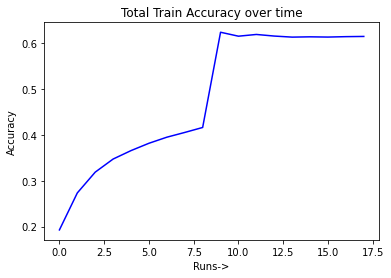

In [58]:
# plot Accuracy
plt.plot(total_acc, color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.title("Total Train Accuracy over time");

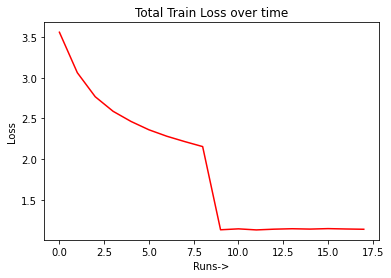

In [59]:
# plot Loss
plt.plot(total_loss, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

In [60]:
def get_answer(question, context):
    inputs = tokenizerFast.encode_plus(question, context, return_tensors='pt').to(device)
    with torch.no_grad():
        output_start, output_end = model(**inputs)
        
        answer_start = torch.argmax(output_start)  
        answer_end = torch.argmax(output_end) 

        answer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

        return(answer)

In [61]:
valid_questions[0]

'which nfl team represented the afc at super bowl 50?'

In [62]:
test_rec = 0

print(f"Context: {x}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: 47
Question: which nfl team represented the afc at super bowl 50?
Expected Answer: {'answer_start': 190, 'text': 'denver broncos', 'answer_end': 204}
Predicted Answer: carolina
